In [1]:
from google.colab import drive
drive.mount('/content/drive')
folderPath = "/content/drive/MyDrive/Colab4GPU/Project2"
# folderPath = "."

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Input, Dense, Dropout, Softmax, Flatten, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.applications.mobilenet import preprocess_input
import tensorflow as tf

from PIL import Image
from numpy import asarray

In [4]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D

In [6]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28
BATCH_SIZE = 3
ALPHA = 1

1.A.

In [7]:
data = np.load(folderPath + '/images.npy', allow_pickle=True)
data.shape

(409, 2)

1.B.

In [8]:
data[0]

array([array([[[42, 37, 34],
               [56, 51, 48],
               [71, 66, 63],
               ...,
               [23, 33, 34],
               [26, 36, 37],
               [28, 38, 39]],

              [[40, 35, 32],
               [51, 46, 43],
               [64, 59, 56],
               ...,
               [27, 36, 35],
               [24, 33, 32],
               [26, 35, 34]],

              [[43, 38, 35],
               [51, 46, 43],
               [61, 56, 53],
               ...,
               [28, 30, 27],
               [33, 35, 32],
               [35, 37, 34]],

              ...,

              [[56, 47, 40],
               [57, 48, 41],
               [61, 52, 45],
               ...,
               [67, 48, 42],
               [55, 35, 28],
               [60, 40, 33]],

              [[53, 44, 37],
               [54, 45, 38],
               [57, 48, 41],
               ...,
               [59, 40, 34],
               [60, 40, 33],
               [54, 34, 27]],



In [9]:
data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [10]:
data[0][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

Spliting data into Features(X) & labels(Y)

In [11]:
X = data[:,0]
X.shape

(409,)

In [12]:
Y = data[:,1]
Y.shape

(409,)

In [13]:
images = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  images[index] = preprocess_input(np.array(img, dtype=np.float32))
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # setting mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{images.shape}' and the shape of mask is '{masks.shape}' ")

Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


1.C.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=9, train_size=400)

In [15]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape

((400, 224, 224, 3),
 (7, 224, 224, 3),
 (400, 224, 224),
 (7, 224, 224),
 (2, 224, 224, 3),
 (2, 224, 224))

In [17]:
y_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

1.D.

In [18]:
random_num = np.random.choice(len(X_train))
random_num

179

Displaying original image

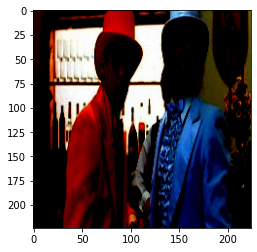

In [19]:
plt.imshow(X_train[random_num])

Masked image

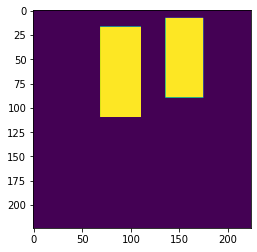

In [20]:
plt.imshow(y_train[random_num])

2.A.

In [21]:
model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [22]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    block00 = model.layers[0].input
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block00])

    decoderBlock = Conv2D(1, kernel_size=1, activation="sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(decoderBlock)

    return Model(inputs=model.input, outputs=decoderBlock) 

2.B.

In [23]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [24]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

2.C.

In [25]:
model = create_model(False)
model.summary()
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer = optimizer, metrics=[dice_coefficient])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

In [26]:
checkpoint = ModelCheckpoint("moblenet_face_detection.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=1, min_lr=1e-6, verbose=1, mode="min")

valid_steps = len(X_val)//BATCH_SIZE

model.fit(X_train, y_train, validation_data=(X_val, y_val), validation_steps=valid_steps, epochs=5, verbose=1, batch_size=BATCH_SIZE, callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/5

Epoch 1: loss improved from inf to 1.89876, saving model to moblenet_face_detection.h5
  1/134 [..............................] - ETA: 24:49 - loss: 1.8988 - dice_coefficient: 0.2912
Epoch 1: loss improved from 1.89876 to 1.80403, saving model to moblenet_face_detection.h5
  2/134 [..............................] - ETA: 31s - loss: 1.8040 - dice_coefficient: 0.3313  
Epoch 1: loss improved from 1.80403 to 1.74724, saving model to moblenet_face_detection.h5
  3/134 [..............................] - ETA: 32s - loss: 1.7472 - dice_coefficient: 0.3441
Epoch 1: loss did not improve from 1.74724
  4/134 [..............................] - ETA: 26s - loss: 1.9427 - dice_coefficient: 0.3029
Epoch 1: loss did not improve from 1.74724
  5/134 [>.............................] - ETA: 22s - loss: 1.9195 - dice_coefficient: 0.3001
Epoch 1: loss did not improve from 1.74724
  6/134 [>.............................] - ETA: 20s - loss: 1.9296 - dice_coefficient: 0.2946
Epoch 1: loss did not i

2.D.

In [27]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 1s/step - loss: 0.7505 - dice_coefficient: 0.6019


[0.7504779100418091, 0.6019384860992432]

we were able to get a Dice Coff which is above 50%

3.

1/1 [==============================] - 0s 444ms/step


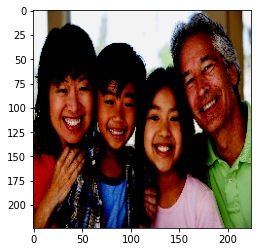

In [28]:
test_image = X_test[3]
plt.imshow(test_image)
test_image = cv2.resize(test_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = np.array(test_image, dtype=np.float32)
y_pred = model.predict(np.array([feat_scaled]))

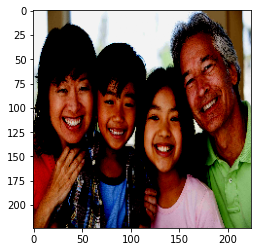

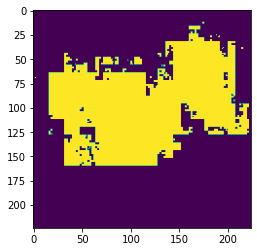

In [29]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH, IMAGE_HEIGHT))
plt.imshow(feat_scaled)
plt.show()
plt.imshow(pred_mask)
plt.show()

# PART B

1.

In [30]:
zipfile_path = os.path.join(folderPath, "training_images")
zipfile_path

'/content/drive/MyDrive/Colab4GPU/Project2/training_images'

In [31]:
from zipfile import ZipFile
with ZipFile(zipfile_path + '.zip', 'r') as z:
  print("Zip already extracted") if os.path.exists(zipfile_path) else z.extractall(path=folderPath)

In [32]:
import glob
import re
import skimage

In [33]:
training_images_paths = glob.glob(zipfile_path + "/*")
training_images_paths

['/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_00947.jpg',
 '/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_01052.jpg',
 '/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_01042.jpg',
 '/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_00964.jpg',
 '/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_01053.jpg',
 '/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_00971.jpg',
 '/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_01057.jpg',
 '/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_01044.jpg',
 '/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_01041.jpg',
 '/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_01067.jpg',
 '/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_00969.jpg',
 '/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_00956.jpg',
 '/content/drive/MyDrive/Colab4GPU/Project2/training_images/real_00975.jpg',

2.

In [34]:
haarcascade_frontalface_default_path = folderPath + "/haarcascade_frontalface_default.xml"
haarcascade_frontalface_default_path

'/content/drive/MyDrive/Colab4GPU/Project2/haarcascade_frontalface_default.xml'

In [35]:
cascade_model = cv2.CascadeClassifier(haarcascade_frontalface_default_path)

In [36]:
def extract_face(image):
    # Gets the face from the image passed using Haar-Cascade
    
    global cascade_model
    
    # Getting co-ordinates of the face
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = cascade_model.detectMultiScale(
        gray,
        scaleFactor=1.4,
        minNeighbors=5,
        minSize=(32, 32)
    )
    
    # Extracts the face from the image and returns it
    if len(faces)>0:
        x,y,w,h = faces[-1]
        return x,y,w,h, len(faces)
    return 0,0,0,0,0

In [37]:
df = pd.DataFrame(columns=('x','y','w','h','Total_Faces','Image_Name','pred_mask'))

for image_path in training_images_paths[:20]:
  image_name = re.split(r'[/\\]', image_path)[-1]
  image = cv2.imread(os.path.join(image_path))

  x,y,w,h, count = extract_face(image)
  df.loc[len(df)] = [x,y,w,h,count,image_name,pred_mask]

3.

In [38]:
df

x    y    w    h Total_Faces      Image_Name  \
0     0    0    0    0           0  real_00947.jpg   
1     0    0    0    0           0  real_01052.jpg   
2    49  159  354  354           2  real_01042.jpg   
3    26   90  496  496           1  real_00964.jpg   
4    59   45  496  496           1  real_01053.jpg   
5     0    0    0    0           0  real_00971.jpg   
6   139  186  354  354           1  real_01057.jpg   
7   183  176  354  354           1  real_01044.jpg   
8   173  142  354  354           1  real_01041.jpg   
9     0    0    0    0           0  real_01067.jpg   
10    0    0    0    0           0  real_00969.jpg   
11  164  171  354  354           1  real_00956.jpg   
12  148  131  354  354           2  real_00975.jpg   
13   64   79  496  496           1  real_01021.jpg   
14   39   72  496  496           1  real_00945.jpg   
15  111  175  354  354           1  real_01068.jpg   
16   36  162  354  354           1  real_01062.jpg   
17  115  154  354  354           2  real_01016.jpg   
18    0    0    0    0           0  real_01065.jpg   
19   81   69  496  496           1  real_01027.jpg   

                                            pred_mask  
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
5   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
6   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
7   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
8   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
9   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
10  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
11  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
12  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
13  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
14  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
15  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
16  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
17  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
18  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
19  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

4.

In [39]:
df.to_csv(folderPath + '/ExtractedFaces.csv')

# PART C

1.

In [40]:
zipfile_path = os.path.join(folderPath, "PINS")
zipfile_path

'/content/drive/MyDrive/Colab4GPU/Project2/PINS'

In [41]:
from zipfile import ZipFile
with ZipFile(zipfile_path + '.zip', 'r') as z:
  print("Zip already extracted") if os.path.exists(zipfile_path) else z.extractall(path=folderPath)

2. & 3.

In [42]:
class IdentityMetadata():
    def __init__(self, name, base, foldername, file):
        # identity name
        self.name = name
        # dataset base directory
        self.base = base
        # folder name
        self.foldername = foldername
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.foldername, self.file)

In [43]:
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                name = i.split('_')[-1]
                metadata.append(IdentityMetadata(name, path, i, f))
    return np.array(metadata)

In [44]:
metadata = load_metadata(zipfile_path)
metadata.shape

(10770,)

In [45]:
print("NAME             : ", metadata[1].name)
print("base folder      :", metadata[1].base)
print("image folder     :", metadata[1].foldername)
print("image file name  :", metadata[1].file)

NAME             :  mark zuckerberg
base folder      : /content/drive/MyDrive/Colab4GPU/Project2/PINS
image folder     : pins_mark zuckerberg
image file name  : mark zuckerberg50.jpg


4.

In [46]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

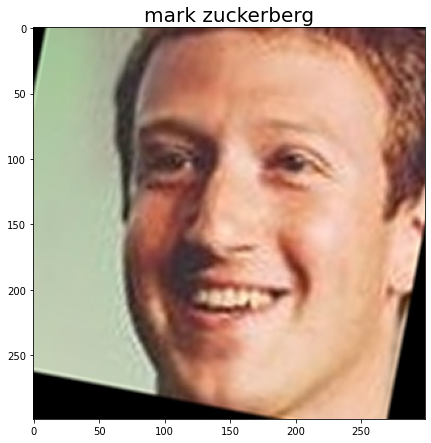

In [47]:
n = 15
img_path = metadata[n].image_path()
img = load_image(img_path)

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = metadata[n].name
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

In [48]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [49]:
model = vgg_face()
model.load_weights(folderPath +'/vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [50]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [51]:
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 1s/step
(2622,)


In [52]:
from tqdm import tqdm

In [53]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

1/1 [==============================] - 0s 19ms/step


1it [00:00,  5.24it/s]

1/1 [==============================] - 0s 16ms/step


2it [00:00,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


3it [00:00,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


4it [00:00,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


5it [00:00,  5.86it/s]

1/1 [==============================] - 0s 15ms/step


6it [00:01,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


7it [00:01,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


8it [00:01,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


9it [00:01,  5.98it/s]

1/1 [==============================] - 0s 15ms/step


10it [00:01,  5.74it/s]

1/1 [==============================] - 0s 15ms/step


11it [00:01,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


12it [00:02,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


13it [00:02,  5.94it/s]

1/1 [==============================] - 0s 15ms/step


14it [00:02,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


15it [00:02,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


16it [00:02,  5.99it/s]

1/1 [==============================] - 0s 16ms/step


17it [00:02,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


18it [00:02,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


19it [00:03,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


20it [00:03,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


21it [00:03,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


22it [00:03,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


23it [00:03,  6.69it/s]

1/1 [==============================] - 0s 18ms/step


24it [00:03,  7.28it/s]

1/1 [==============================] - 0s 15ms/step


25it [00:04,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


26it [00:04,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


27it [00:04,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


28it [00:04,  7.06it/s]

1/1 [==============================] - 0s 15ms/step


29it [00:04,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


30it [00:04,  7.99it/s]

1/1 [==============================] - 0s 19ms/step


31it [00:04,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


32it [00:04,  7.44it/s]

1/1 [==============================] - 0s 15ms/step


33it [00:05,  7.68it/s]

1/1 [==============================] - 0s 15ms/step


34it [00:05,  8.14it/s]

1/1 [==============================] - 0s 16ms/step


35it [00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


36it [00:05,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


37it [00:05,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


38it [00:05,  5.67it/s]

1/1 [==============================] - 0s 17ms/step


39it [00:06,  5.57it/s]

1/1 [==============================] - 0s 14ms/step


40it [00:06,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


41it [00:06,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


42it [00:06,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


43it [00:06,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


44it [00:06,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


45it [00:07,  5.97it/s]

1/1 [==============================] - 0s 15ms/step


46it [00:07,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


47it [00:07,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


48it [00:07,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


49it [00:07,  7.18it/s]

1/1 [==============================] - 0s 15ms/step


50it [00:07,  7.68it/s]

1/1 [==============================] - 0s 24ms/step


51it [00:07,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


52it [00:07,  8.27it/s]

1/1 [==============================] - 0s 18ms/step


53it [00:08,  8.45it/s]

1/1 [==============================] - 0s 15ms/step


54it [00:08,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


55it [00:08,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


56it [00:08,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


57it [00:08,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


58it [00:08,  6.80it/s]

1/1 [==============================] - 0s 15ms/step


59it [00:08,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


60it [00:09,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


61it [00:09,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


62it [00:09,  6.64it/s]

1/1 [==============================] - 0s 24ms/step


63it [00:09,  6.89it/s]

1/1 [==============================] - 0s 37ms/step


64it [00:09,  6.62it/s]

1/1 [==============================] - 0s 18ms/step


65it [00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


66it [00:10,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


67it [00:10,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


68it [00:10,  5.80it/s]

1/1 [==============================] - 0s 15ms/step


69it [00:10,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


70it [00:10,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


71it [00:10,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


72it [00:10,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


73it [00:11,  7.58it/s]

1/1 [==============================] - 0s 17ms/step


74it [00:11,  7.84it/s]

1/1 [==============================] - 0s 17ms/step


75it [00:11,  8.25it/s]

1/1 [==============================] - 0s 18ms/step


76it [00:11,  8.45it/s]

1/1 [==============================] - 0s 16ms/step


77it [00:11,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


78it [00:11,  7.69it/s]

1/1 [==============================] - 0s 19ms/step


79it [00:11,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


80it [00:11,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


81it [00:12,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


82it [00:12,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


83it [00:12,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


84it [00:12,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


85it [00:12,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


86it [00:12,  7.22it/s]

1/1 [==============================] - 0s 15ms/step


87it [00:13,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


88it [00:13,  7.15it/s]

1/1 [==============================] - 0s 14ms/step


89it [00:13,  7.70it/s]

1/1 [==============================] - 0s 16ms/step


90it [00:13,  8.08it/s]

1/1 [==============================] - 0s 17ms/step


91it [00:13,  8.36it/s]

1/1 [==============================] - 0s 18ms/step


92it [00:13,  8.59it/s]

1/1 [==============================] - 0s 17ms/step


93it [00:13,  8.49it/s]

1/1 [==============================] - 0s 18ms/step


94it [00:13,  8.55it/s]

1/1 [==============================] - 0s 14ms/step


95it [00:13,  8.76it/s]

1/1 [==============================] - 0s 16ms/step


96it [00:14,  7.32it/s]

1/1 [==============================] - 0s 15ms/step


97it [00:14,  7.83it/s]

1/1 [==============================] - 0s 17ms/step


98it [00:14,  6.89it/s]

1/1 [==============================] - 0s 15ms/step


99it [00:14,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


100it [00:14,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


101it [00:14,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


102it [00:15,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


103it [00:15,  7.72it/s]

1/1 [==============================] - 0s 15ms/step


104it [00:15,  8.16it/s]

1/1 [==============================] - 0s 16ms/step


105it [00:15,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


106it [00:15,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


107it [00:15,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


108it [00:15,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


109it [00:16,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


110it [00:16,  6.81it/s]

1/1 [==============================] - 0s 14ms/step


111it [00:16,  7.38it/s]

1/1 [==============================] - 0s 15ms/step


112it [00:16,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


113it [00:16,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


114it [00:16,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


115it [00:17,  5.87it/s]

1/1 [==============================] - 0s 15ms/step


116it [00:17,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


117it [00:17,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


118it [00:17,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


119it [00:17,  5.32it/s]

1/1 [==============================] - 0s 16ms/step


120it [00:17,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


121it [00:18,  6.02it/s]

1/1 [==============================] - 0s 15ms/step


122it [00:18,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


123it [00:18,  7.22it/s]

1/1 [==============================] - 0s 15ms/step


124it [00:18,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


125it [00:18,  6.09it/s]

1/1 [==============================] - 0s 16ms/step


126it [00:18,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


127it [00:18,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


128it [00:19,  7.09it/s]

1/1 [==============================] - 0s 15ms/step


129it [00:19,  7.57it/s]

1/1 [==============================] - 0s 15ms/step


130it [00:19,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


131it [00:19,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


132it [00:19,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


133it [00:19,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


134it [00:20,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


135it [00:20,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


136it [00:20,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


137it [00:20,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


138it [00:20,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


139it [00:20,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


140it [00:21,  5.82it/s]

1/1 [==============================] - 0s 15ms/step


141it [00:21,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


142it [00:21,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


143it [00:21,  6.81it/s]

1/1 [==============================] - 0s 15ms/step


144it [00:21,  7.40it/s]

1/1 [==============================] - 0s 17ms/step


145it [00:21,  7.77it/s]

1/1 [==============================] - 0s 17ms/step


146it [00:21,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


147it [00:21,  8.18it/s]

1/1 [==============================] - 0s 15ms/step


148it [00:22,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


149it [00:22,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


150it [00:22,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


151it [00:22,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


152it [00:22,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


153it [00:22,  7.52it/s]

1/1 [==============================] - 0s 15ms/step


154it [00:22,  7.85it/s]

1/1 [==============================] - 0s 17ms/step


155it [00:23,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


156it [00:23,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


157it [00:23,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


158it [00:23,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


159it [00:23,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


160it [00:23,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


161it [00:24,  5.62it/s]

1/1 [==============================] - 0s 15ms/step


162it [00:24,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


163it [00:24,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


164it [00:24,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


165it [00:24,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


166it [00:24,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


167it [00:24,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


168it [00:25,  7.68it/s]

1/1 [==============================] - 0s 15ms/step


169it [00:25,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


170it [00:25,  7.28it/s]

1/1 [==============================] - 0s 15ms/step


171it [00:25,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


172it [00:25,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


173it [00:25,  5.61it/s]

1/1 [==============================] - 0s 15ms/step


174it [00:26,  5.53it/s]

1/1 [==============================] - 0s 16ms/step


175it [00:26,  6.19it/s]

1/1 [==============================] - 0s 16ms/step


176it [00:26,  5.91it/s]

1/1 [==============================] - 0s 15ms/step


177it [00:26,  5.73it/s]

1/1 [==============================] - 0s 15ms/step


178it [00:26,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


179it [00:26,  6.74it/s]

1/1 [==============================] - 0s 16ms/step


180it [00:26,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


181it [00:27,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


182it [00:27,  8.07it/s]

1/1 [==============================] - 0s 15ms/step


183it [00:27,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


184it [00:27,  8.57it/s]

1/1 [==============================] - 0s 16ms/step


185it [00:27,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


186it [00:27,  7.67it/s]

1/1 [==============================] - 0s 17ms/step


187it [00:27,  8.06it/s]

1/1 [==============================] - 0s 15ms/step


188it [00:28,  7.00it/s]

1/1 [==============================] - 0s 15ms/step


189it [00:28,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


190it [00:28,  7.02it/s]

1/1 [==============================] - 0s 14ms/step


191it [00:28,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


192it [00:28,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


193it [00:28,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


194it [00:29,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


195it [00:29,  6.85it/s]

1/1 [==============================] - 0s 24ms/step


196it [00:29,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


197it [00:29,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


198it [00:29,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


199it [00:29,  6.01it/s]

1/1 [==============================] - 0s 15ms/step


200it [00:29,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


201it [00:30,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


202it [00:30,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


203it [00:30,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


204it [00:30,  7.72it/s]

1/1 [==============================] - 0s 17ms/step


205it [00:30,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


206it [00:30,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


207it [00:31,  5.79it/s]

1/1 [==============================] - 0s 16ms/step


208it [00:31,  5.68it/s]

1/1 [==============================] - 0s 16ms/step


209it [00:31,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


210it [00:31,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


211it [00:31,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


212it [00:31,  6.02it/s]

1/1 [==============================] - 0s 16ms/step


213it [00:31,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


214it [00:32,  6.27it/s]

1/1 [==============================] - 0s 15ms/step


215it [00:32,  5.97it/s]

1/1 [==============================] - 0s 15ms/step


216it [00:32,  6.52it/s]

1/1 [==============================] - 0s 18ms/step


217it [00:32,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


218it [00:32,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


219it [00:32,  6.61it/s]

1/1 [==============================] - 0s 23ms/step


220it [00:32,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


221it [00:33,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


222it [00:33,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


223it [00:33,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


224it [00:33,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


225it [00:33,  7.52it/s]

1/1 [==============================] - 0s 15ms/step


226it [00:33,  7.84it/s]

1/1 [==============================] - 0s 14ms/step


227it [00:33,  8.21it/s]

1/1 [==============================] - 0s 15ms/step


228it [00:34,  8.32it/s]

1/1 [==============================] - 0s 24ms/step


229it [00:34,  8.40it/s]

1/1 [==============================] - 0s 17ms/step


230it [00:34,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


231it [00:34,  7.60it/s]

1/1 [==============================] - 0s 16ms/step


232it [00:34,  8.00it/s]

1/1 [==============================] - 0s 17ms/step


233it [00:34,  8.32it/s]

1/1 [==============================] - 0s 17ms/step


234it [00:34,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


235it [00:35,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


236it [00:35,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


237it [00:35,  5.74it/s]

1/1 [==============================] - 0s 15ms/step


238it [00:35,  5.57it/s]

1/1 [==============================] - 0s 16ms/step


239it [00:35,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


240it [00:35,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


241it [00:36,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


242it [00:36,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


243it [00:36,  6.47it/s]

1/1 [==============================] - 0s 14ms/step


244it [00:36,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


245it [00:36,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


246it [00:36,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


247it [00:37,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


248it [00:37,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


249it [00:37,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


250it [00:37,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


251it [00:37,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


252it [00:37,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


253it [00:38,  5.95it/s]

1/1 [==============================] - 0s 15ms/step


254it [00:38,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


255it [00:38,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


256it [00:38,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


257it [00:38,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


258it [00:38,  5.86it/s]

1/1 [==============================] - 0s 16ms/step


259it [00:38,  5.65it/s]

1/1 [==============================] - 0s 15ms/step


260it [00:39,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


261it [00:39,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


262it [00:39,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


263it [00:39,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


264it [00:39,  5.75it/s]

1/1 [==============================] - 0s 15ms/step


265it [00:39,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


266it [00:40,  6.30it/s]

1/1 [==============================] - 0s 15ms/step


267it [00:40,  5.91it/s]

1/1 [==============================] - 0s 17ms/step


268it [00:40,  5.71it/s]

1/1 [==============================] - 0s 15ms/step


269it [00:40,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


270it [00:40,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


271it [00:40,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


272it [00:41,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


273it [00:41,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


274it [00:41,  7.68it/s]

1/1 [==============================] - 0s 17ms/step


275it [00:41,  8.00it/s]

1/1 [==============================] - 0s 18ms/step


276it [00:41,  8.22it/s]

1/1 [==============================] - 0s 15ms/step


277it [00:41,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


278it [00:41,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


279it [00:42,  5.98it/s]

1/1 [==============================] - 0s 15ms/step


280it [00:42,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


281it [00:42,  7.17it/s]

1/1 [==============================] - 0s 15ms/step


282it [00:42,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


283it [00:42,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


284it [00:42,  5.87it/s]

1/1 [==============================] - 0s 15ms/step


285it [00:42,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


286it [00:43,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


287it [00:43,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


288it [00:43,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


289it [00:43,  5.77it/s]

1/1 [==============================] - 0s 16ms/step


290it [00:43,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


291it [00:43,  6.05it/s]

1/1 [==============================] - 0s 15ms/step


292it [00:44,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


293it [00:44,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


294it [00:44,  5.53it/s]

1/1 [==============================] - 0s 15ms/step


295it [00:44,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


296it [00:44,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


297it [00:44,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


298it [00:45,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


299it [00:45,  7.43it/s]

1/1 [==============================] - 0s 15ms/step


300it [00:45,  6.62it/s]

1/1 [==============================] - 0s 19ms/step


301it [00:45,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


302it [00:45,  7.43it/s]

1/1 [==============================] - 0s 17ms/step


303it [00:45,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


304it [00:46,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


305it [00:46,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


306it [00:46,  6.06it/s]

1/1 [==============================] - 0s 15ms/step


307it [00:46,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


308it [00:46,  6.47it/s]

1/1 [==============================] - 0s 22ms/step


309it [00:46,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


310it [00:46,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


311it [00:47,  7.88it/s]

1/1 [==============================] - 0s 16ms/step


312it [00:47,  8.19it/s]

1/1 [==============================] - 0s 15ms/step


313it [00:47,  8.33it/s]

1/1 [==============================] - 0s 15ms/step


314it [00:47,  8.55it/s]

1/1 [==============================] - 0s 16ms/step


315it [00:47,  8.76it/s]

1/1 [==============================] - 0s 16ms/step


316it [00:47,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


317it [00:47,  7.73it/s]

1/1 [==============================] - 0s 19ms/step


318it [00:47,  7.75it/s]

1/1 [==============================] - 0s 14ms/step


319it [00:48,  8.08it/s]

1/1 [==============================] - 0s 14ms/step


320it [00:48,  8.36it/s]

1/1 [==============================] - 0s 15ms/step


321it [00:48,  8.45it/s]

1/1 [==============================] - 0s 17ms/step


322it [00:48,  7.19it/s]

1/1 [==============================] - 0s 15ms/step


323it [00:48,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


324it [00:48,  8.08it/s]

1/1 [==============================] - 0s 17ms/step


325it [00:48,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


326it [00:48,  7.54it/s]

1/1 [==============================] - 0s 14ms/step


327it [00:49,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


328it [00:49,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


329it [00:49,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


330it [00:49,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


331it [00:49,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


332it [00:49,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


333it [00:50,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


334it [00:50,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


335it [00:50,  7.53it/s]

1/1 [==============================] - 0s 17ms/step


336it [00:50,  7.85it/s]

1/1 [==============================] - 0s 16ms/step


337it [00:50,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


338it [00:50,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


339it [00:50,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


340it [00:51,  5.71it/s]

1/1 [==============================] - 0s 15ms/step


341it [00:51,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


342it [00:51,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


343it [00:51,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


344it [00:51,  7.56it/s]

1/1 [==============================] - 0s 15ms/step


345it [00:51,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


346it [00:52,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


347it [00:52,  6.90it/s]

1/1 [==============================] - 0s 15ms/step


348it [00:52,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


349it [00:52,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


350it [00:52,  7.19it/s]

1/1 [==============================] - 0s 15ms/step


351it [00:52,  7.73it/s]

1/1 [==============================] - 0s 15ms/step


352it [00:52,  8.11it/s]

1/1 [==============================] - 0s 16ms/step


353it [00:52,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


354it [00:53,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


355it [00:53,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


356it [00:53,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


357it [00:53,  5.92it/s]

1/1 [==============================] - 0s 16ms/step


358it [00:53,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


359it [00:53,  6.09it/s]

1/1 [==============================] - 0s 15ms/step


360it [00:54,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


361it [00:54,  7.31it/s]

1/1 [==============================] - 0s 15ms/step


362it [00:54,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


363it [00:54,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


364it [00:54,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


365it [00:54,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


366it [00:54,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


367it [00:55,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


368it [00:55,  7.58it/s]

1/1 [==============================] - 0s 14ms/step


369it [00:55,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


370it [00:55,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


371it [00:55,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


372it [00:55,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


373it [00:56,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


374it [00:56,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


375it [00:56,  7.11it/s]

1/1 [==============================] - 0s 15ms/step


376it [00:56,  7.44it/s]

1/1 [==============================] - 0s 14ms/step


377it [00:56,  6.59it/s]

1/1 [==============================] - 0s 17ms/step


378it [00:56,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


379it [00:56,  7.48it/s]

1/1 [==============================] - 0s 16ms/step


380it [00:56,  7.95it/s]

1/1 [==============================] - 0s 20ms/step


381it [00:57,  8.16it/s]

1/1 [==============================] - 0s 16ms/step


382it [00:57,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


383it [00:57,  7.56it/s]

1/1 [==============================] - 0s 15ms/step


384it [00:57,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


385it [00:57,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


386it [00:57,  6.53it/s]

1/1 [==============================] - 0s 19ms/step


387it [00:58,  6.02it/s]

1/1 [==============================] - 0s 16ms/step


388it [00:58,  5.63it/s]

1/1 [==============================] - 0s 15ms/step


389it [00:58,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


390it [00:58,  6.90it/s]

1/1 [==============================] - 0s 15ms/step


391it [00:58,  6.33it/s]

1/1 [==============================] - 0s 15ms/step


392it [00:58,  6.02it/s]

1/1 [==============================] - 0s 15ms/step


393it [00:59,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


394it [00:59,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


395it [00:59,  6.11it/s]

1/1 [==============================] - 0s 33ms/step


396it [00:59,  5.74it/s]

1/1 [==============================] - 0s 15ms/step


397it [00:59,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


398it [00:59,  6.95it/s]

1/1 [==============================] - 0s 15ms/step


399it [00:59,  7.52it/s]

1/1 [==============================] - 0s 17ms/step


400it [01:00,  6.69it/s]

1/1 [==============================] - 0s 14ms/step


401it [01:00,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


402it [01:00,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


403it [01:00,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


404it [01:00,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


405it [01:00,  5.70it/s]

1/1 [==============================] - 0s 14ms/step


406it [01:01,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


407it [01:01,  5.52it/s]

1/1 [==============================] - 0s 16ms/step


408it [01:01,  5.45it/s]

1/1 [==============================] - 0s 16ms/step


409it [01:01,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


410it [01:01,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


411it [01:01,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


412it [01:02,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


413it [01:02,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


414it [01:02,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


415it [01:02,  7.24it/s]

1/1 [==============================] - 0s 22ms/step


416it [01:02,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


417it [01:02,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


418it [01:03,  5.78it/s]

1/1 [==============================] - 0s 15ms/step


419it [01:03,  5.57it/s]

1/1 [==============================] - 0s 16ms/step


420it [01:03,  4.01it/s]

1/1 [==============================] - 0s 17ms/step


421it [01:03,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


422it [01:04,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


423it [01:04,  4.76it/s]

1/1 [==============================] - 0s 15ms/step


424it [01:04,  4.87it/s]

1/1 [==============================] - 0s 16ms/step


425it [01:04,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


426it [01:04,  5.11it/s]

1/1 [==============================] - 0s 16ms/step


427it [01:04,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


428it [01:05,  5.83it/s]

1/1 [==============================] - 0s 15ms/step


429it [01:05,  5.66it/s]

1/1 [==============================] - 0s 16ms/step


430it [01:05,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


431it [01:05,  5.41it/s]

1/1 [==============================] - 0s 15ms/step


432it [01:05,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


433it [01:05,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


434it [01:06,  6.30it/s]

1/1 [==============================] - 0s 15ms/step


435it [01:06,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


436it [01:06,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


437it [01:06,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


438it [01:06,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


439it [01:06,  5.65it/s]

1/1 [==============================] - 0s 14ms/step


440it [01:07,  5.56it/s]

1/1 [==============================] - 0s 15ms/step


441it [01:07,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


442it [01:07,  6.88it/s]

1/1 [==============================] - 0s 15ms/step


443it [01:07,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


444it [01:07,  7.76it/s]

1/1 [==============================] - 0s 16ms/step


445it [01:07,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


446it [01:07,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


447it [01:08,  7.67it/s]

1/1 [==============================] - 0s 17ms/step


448it [01:08,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


449it [01:08,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


450it [01:08,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


451it [01:08,  6.63it/s]

1/1 [==============================] - 0s 23ms/step


452it [01:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


453it [01:08,  6.48it/s]

1/1 [==============================] - 0s 18ms/step


454it [01:09,  7.05it/s]

1/1 [==============================] - 0s 15ms/step


455it [01:09,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


456it [01:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


457it [01:09,  7.55it/s]

1/1 [==============================] - 0s 17ms/step


458it [01:09,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


459it [01:09,  7.85it/s]

1/1 [==============================] - 0s 16ms/step


460it [01:09,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


461it [01:10,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


462it [01:10,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


463it [01:10,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


464it [01:10,  5.66it/s]

1/1 [==============================] - 0s 17ms/step


465it [01:10,  5.58it/s]

1/1 [==============================] - 0s 16ms/step


466it [01:10,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


467it [01:11,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


468it [01:11,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


469it [01:11,  5.94it/s]

1/1 [==============================] - 0s 15ms/step


470it [01:11,  6.65it/s]

1/1 [==============================] - 0s 18ms/step


471it [01:11,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


472it [01:11,  5.75it/s]

1/1 [==============================] - 0s 16ms/step


473it [01:12,  5.46it/s]

1/1 [==============================] - 0s 16ms/step


474it [01:12,  5.41it/s]

1/1 [==============================] - 0s 16ms/step


475it [01:12,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


476it [01:12,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


477it [01:12,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


478it [01:12,  7.14it/s]

1/1 [==============================] - 0s 15ms/step


479it [01:13,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


480it [01:13,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


481it [01:13,  6.09it/s]

1/1 [==============================] - 0s 15ms/step


482it [01:13,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


483it [01:13,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


484it [01:13,  6.05it/s]

1/1 [==============================] - 0s 15ms/step


485it [01:14,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


486it [01:14,  5.60it/s]

1/1 [==============================] - 0s 15ms/step


487it [01:14,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


488it [01:14,  5.99it/s]

1/1 [==============================] - 0s 15ms/step


489it [01:14,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


490it [01:14,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


491it [01:15,  5.83it/s]

1/1 [==============================] - 0s 15ms/step


492it [01:15,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


493it [01:15,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


494it [01:15,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


495it [01:15,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


496it [01:15,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


497it [01:16,  5.75it/s]

1/1 [==============================] - 0s 15ms/step


498it [01:16,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


499it [01:16,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


500it [01:16,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


501it [01:16,  7.02it/s]

1/1 [==============================] - 0s 15ms/step


502it [01:16,  7.44it/s]

1/1 [==============================] - 0s 16ms/step


503it [01:16,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


504it [01:17,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


505it [01:17,  7.78it/s]

1/1 [==============================] - 0s 15ms/step


506it [01:17,  8.11it/s]

1/1 [==============================] - 0s 15ms/step


507it [01:17,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


508it [01:17,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


509it [01:17,  5.92it/s]

1/1 [==============================] - 0s 16ms/step


510it [01:17,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


511it [01:18,  7.24it/s]

1/1 [==============================] - 0s 14ms/step


512it [01:18,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


513it [01:18,  8.12it/s]

1/1 [==============================] - 0s 15ms/step


514it [01:18,  6.92it/s]

1/1 [==============================] - 0s 15ms/step


515it [01:18,  7.20it/s]

1/1 [==============================] - 0s 15ms/step


516it [01:18,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


517it [01:18,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


518it [01:19,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


519it [01:19,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


520it [01:19,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


521it [01:19,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


522it [01:19,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


523it [01:19,  5.96it/s]

1/1 [==============================] - 0s 16ms/step


524it [01:20,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


525it [01:20,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


526it [01:20,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


527it [01:20,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


528it [01:20,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


529it [01:20,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


530it [01:20,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


531it [01:21,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


532it [01:21,  7.51it/s]

1/1 [==============================] - 0s 15ms/step


533it [01:21,  7.95it/s]

1/1 [==============================] - 0s 17ms/step


534it [01:21,  8.20it/s]

1/1 [==============================] - 0s 15ms/step


535it [01:21,  8.45it/s]

1/1 [==============================] - 0s 16ms/step


536it [01:21,  8.61it/s]

1/1 [==============================] - 0s 20ms/step


537it [01:21,  8.77it/s]

1/1 [==============================] - 0s 25ms/step


538it [01:21,  8.63it/s]

1/1 [==============================] - 0s 15ms/step


539it [01:21,  8.78it/s]

1/1 [==============================] - 0s 16ms/step


540it [01:22,  8.71it/s]

1/1 [==============================] - 0s 15ms/step


541it [01:22,  8.82it/s]

1/1 [==============================] - 0s 17ms/step


542it [01:22,  8.77it/s]

1/1 [==============================] - 0s 15ms/step


543it [01:22,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


544it [01:22,  7.76it/s]

1/1 [==============================] - 0s 15ms/step


545it [01:22,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


546it [01:23,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


547it [01:23,  6.85it/s]

1/1 [==============================] - 0s 15ms/step


548it [01:23,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


549it [01:23,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


550it [01:23,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


551it [01:23,  5.44it/s]

1/1 [==============================] - 0s 16ms/step


552it [01:24,  5.37it/s]

1/1 [==============================] - 0s 16ms/step


553it [01:24,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


554it [01:24,  5.34it/s]

1/1 [==============================] - 0s 27ms/step


555it [01:24,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


556it [01:24,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


557it [01:25,  5.30it/s]

1/1 [==============================] - 0s 16ms/step


558it [01:25,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


559it [01:25,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


560it [01:25,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


561it [01:25,  7.05it/s]

1/1 [==============================] - 0s 15ms/step


562it [01:25,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


563it [01:25,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


564it [01:25,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


565it [01:26,  7.83it/s]

1/1 [==============================] - 0s 18ms/step


566it [01:26,  8.05it/s]

1/1 [==============================] - 0s 15ms/step


567it [01:26,  8.37it/s]

1/1 [==============================] - 0s 15ms/step


568it [01:26,  7.08it/s]

1/1 [==============================] - 0s 15ms/step


569it [01:26,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


570it [01:26,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


571it [01:27,  6.32it/s]

1/1 [==============================] - 0s 21ms/step


572it [01:27,  5.79it/s]

1/1 [==============================] - 0s 15ms/step


573it [01:27,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


574it [01:27,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


575it [01:27,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


576it [01:27,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


577it [01:28,  5.82it/s]

1/1 [==============================] - 0s 16ms/step


578it [01:28,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


579it [01:28,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


580it [01:28,  6.88it/s]

1/1 [==============================] - 0s 15ms/step


581it [01:28,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


582it [01:28,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


583it [01:28,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


584it [01:29,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


585it [01:29,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


586it [01:29,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


587it [01:29,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


588it [01:29,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


589it [01:29,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


590it [01:29,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


591it [01:30,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


592it [01:30,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


593it [01:30,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


594it [01:30,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


595it [01:30,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


596it [01:30,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


597it [01:31,  6.80it/s]

1/1 [==============================] - 0s 15ms/step


598it [01:31,  7.20it/s]

1/1 [==============================] - 0s 15ms/step


599it [01:31,  7.67it/s]

1/1 [==============================] - 0s 15ms/step


600it [01:31,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


601it [01:31,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


602it [01:31,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


603it [01:31,  7.13it/s]

1/1 [==============================] - 0s 15ms/step


604it [01:32,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


605it [01:32,  7.06it/s]

1/1 [==============================] - 0s 15ms/step


606it [01:32,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


607it [01:32,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


608it [01:32,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


609it [01:32,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


610it [01:32,  7.64it/s]

1/1 [==============================] - 0s 15ms/step


611it [01:33,  6.69it/s]

1/1 [==============================] - 0s 18ms/step


612it [01:33,  7.25it/s]

1/1 [==============================] - 0s 15ms/step


613it [01:33,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


614it [01:33,  7.12it/s]

1/1 [==============================] - 0s 15ms/step


615it [01:33,  7.57it/s]

1/1 [==============================] - 0s 16ms/step


616it [01:33,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


617it [01:33,  6.63it/s]

1/1 [==============================] - 0s 30ms/step


618it [01:34,  6.06it/s]

1/1 [==============================] - 0s 16ms/step


619it [01:34,  6.64it/s]

1/1 [==============================] - 0s 17ms/step


620it [01:34,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


621it [01:34,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


622it [01:34,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


623it [01:34,  6.74it/s]

1/1 [==============================] - 0s 16ms/step


624it [01:35,  6.19it/s]

1/1 [==============================] - 0s 15ms/step


625it [01:35,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


626it [01:35,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


627it [01:35,  5.59it/s]

1/1 [==============================] - 0s 15ms/step


628it [01:35,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


629it [01:35,  5.87it/s]

1/1 [==============================] - 0s 16ms/step


630it [01:36,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


631it [01:36,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


632it [01:36,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


633it [01:36,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


634it [01:36,  7.06it/s]

1/1 [==============================] - 0s 15ms/step


635it [01:36,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


636it [01:37,  6.02it/s]

1/1 [==============================] - 0s 16ms/step


637it [01:37,  5.73it/s]

1/1 [==============================] - 0s 16ms/step


638it [01:37,  5.54it/s]

1/1 [==============================] - 0s 15ms/step


639it [01:37,  5.48it/s]

1/1 [==============================] - 0s 15ms/step


640it [01:37,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


641it [01:38,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


642it [01:38,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


643it [01:38,  5.91it/s]

1/1 [==============================] - 0s 15ms/step


644it [01:38,  5.71it/s]

1/1 [==============================] - 0s 16ms/step


645it [01:38,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


646it [01:38,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


647it [01:38,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


648it [01:39,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


649it [01:39,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


650it [01:39,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


651it [01:39,  6.33it/s]

1/1 [==============================] - 0s 15ms/step


652it [01:39,  6.99it/s]

1/1 [==============================] - 0s 15ms/step


653it [01:39,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


654it [01:39,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


655it [01:40,  6.16it/s]

1/1 [==============================] - 0s 16ms/step


656it [01:40,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


657it [01:40,  6.05it/s]

1/1 [==============================] - 0s 15ms/step


658it [01:40,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


659it [01:40,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


660it [01:40,  6.71it/s]

1/1 [==============================] - 0s 24ms/step


661it [01:41,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


662it [01:41,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


663it [01:41,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


664it [01:41,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


665it [01:41,  5.92it/s]

1/1 [==============================] - 0s 16ms/step


666it [01:41,  6.59it/s]

1/1 [==============================] - 0s 20ms/step


667it [01:41,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


668it [01:42,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


669it [01:42,  6.98it/s]

1/1 [==============================] - 0s 15ms/step


670it [01:42,  7.55it/s]

1/1 [==============================] - 0s 24ms/step


671it [01:42,  7.98it/s]

1/1 [==============================] - 0s 16ms/step


672it [01:42,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


673it [01:42,  7.42it/s]

1/1 [==============================] - 0s 17ms/step


674it [01:42,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


675it [01:42,  8.01it/s]

1/1 [==============================] - 0s 17ms/step


676it [01:43,  8.25it/s]

1/1 [==============================] - 0s 17ms/step


677it [01:43,  8.44it/s]

1/1 [==============================] - 0s 15ms/step


678it [01:43,  7.02it/s]

1/1 [==============================] - 0s 15ms/step


679it [01:43,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


680it [01:43,  6.95it/s]

1/1 [==============================] - 0s 15ms/step


681it [01:43,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


682it [01:44,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


683it [01:44,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


684it [01:44,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


685it [01:44,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


686it [01:44,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


687it [01:44,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


688it [01:44,  6.89it/s]

1/1 [==============================] - 0s 15ms/step


689it [01:45,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


690it [01:45,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


691it [01:45,  6.80it/s]

1/1 [==============================] - 0s 22ms/step


692it [01:45,  6.97it/s]

1/1 [==============================] - 0s 15ms/step


693it [01:45,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


694it [01:45,  6.58it/s]

1/1 [==============================] - 0s 18ms/step


695it [01:46,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


696it [01:46,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


697it [01:46,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


698it [01:46,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


699it [01:46,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


700it [01:46,  7.40it/s]

1/1 [==============================] - 0s 15ms/step


701it [01:46,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


702it [01:47,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


703it [01:47,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


704it [01:47,  5.99it/s]

1/1 [==============================] - 0s 15ms/step


705it [01:47,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


706it [01:47,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


707it [01:47,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


708it [01:47,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


709it [01:48,  6.38it/s]

1/1 [==============================] - 0s 22ms/step


710it [01:48,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


711it [01:48,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


712it [01:48,  5.99it/s]

1/1 [==============================] - 0s 15ms/step


713it [01:48,  6.55it/s]

1/1 [==============================] - 0s 30ms/step


714it [01:48,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


715it [01:49,  6.30it/s]

1/1 [==============================] - 0s 15ms/step


716it [01:49,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


717it [01:49,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


718it [01:49,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


719it [01:49,  7.18it/s]

1/1 [==============================] - 0s 15ms/step


720it [01:49,  7.57it/s]

1/1 [==============================] - 0s 17ms/step


721it [01:49,  7.83it/s]

1/1 [==============================] - 0s 20ms/step


722it [01:50,  6.80it/s]

1/1 [==============================] - 0s 16ms/step


723it [01:50,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


724it [01:50,  7.61it/s]

1/1 [==============================] - 0s 15ms/step


725it [01:50,  8.03it/s]

1/1 [==============================] - 0s 17ms/step


726it [01:50,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


727it [01:50,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


728it [01:50,  5.92it/s]

1/1 [==============================] - 0s 16ms/step


729it [01:51,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


730it [01:51,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


731it [01:51,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


732it [01:51,  7.38it/s]

1/1 [==============================] - 0s 14ms/step


733it [01:51,  7.65it/s]

1/1 [==============================] - 0s 18ms/step


734it [01:51,  7.60it/s]

1/1 [==============================] - 0s 15ms/step


735it [01:51,  8.03it/s]

1/1 [==============================] - 0s 15ms/step


736it [01:51,  8.27it/s]

1/1 [==============================] - 0s 20ms/step


737it [01:52,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


738it [01:52,  7.22it/s]

1/1 [==============================] - 0s 26ms/step


739it [01:52,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


740it [01:52,  6.70it/s]

1/1 [==============================] - 0s 22ms/step


741it [01:52,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


742it [01:52,  6.14it/s]

1/1 [==============================] - 0s 25ms/step


743it [01:53,  5.62it/s]

1/1 [==============================] - 0s 26ms/step


744it [01:53,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


745it [01:53,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


746it [01:53,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


747it [01:53,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


748it [01:54,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


749it [01:54,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


750it [01:54,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


751it [01:54,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


752it [01:54,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


753it [01:55,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


754it [01:55,  4.64it/s]

1/1 [==============================] - 0s 33ms/step


755it [01:55,  5.22it/s]

1/1 [==============================] - 0s 26ms/step


756it [01:55,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


757it [01:55,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


758it [01:56,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


759it [01:56,  5.92it/s]

1/1 [==============================] - 0s 16ms/step


760it [01:56,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


761it [01:56,  7.13it/s]

1/1 [==============================] - 0s 15ms/step


762it [01:56,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


763it [01:56,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


764it [01:57,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


765it [01:57,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


766it [01:57,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


767it [01:57,  7.15it/s]

1/1 [==============================] - 0s 15ms/step


768it [01:57,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


769it [01:57,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


770it [01:57,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


771it [01:58,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


772it [01:58,  7.50it/s]

1/1 [==============================] - 0s 16ms/step


773it [01:58,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


774it [01:58,  6.54it/s]

1/1 [==============================] - 0s 19ms/step


775it [01:58,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


776it [01:58,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


777it [01:58,  7.74it/s]

1/1 [==============================] - 0s 17ms/step


778it [01:59,  7.91it/s]

1/1 [==============================] - 0s 15ms/step


779it [01:59,  6.88it/s]

1/1 [==============================] - 0s 15ms/step


780it [01:59,  7.43it/s]

1/1 [==============================] - 0s 15ms/step


781it [01:59,  6.59it/s]

1/1 [==============================] - 0s 23ms/step


782it [01:59,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


783it [01:59,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


784it [01:59,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


785it [02:00,  7.54it/s]

1/1 [==============================] - 0s 17ms/step


786it [02:00,  7.86it/s]

1/1 [==============================] - 0s 22ms/step


787it [02:00,  8.00it/s]

1/1 [==============================] - 0s 18ms/step


788it [02:00,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


789it [02:00,  7.40it/s]

1/1 [==============================] - 0s 22ms/step


790it [02:00,  6.49it/s]

1/1 [==============================] - 0s 20ms/step


791it [02:00,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


792it [02:01,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


793it [02:01,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


794it [02:01,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


795it [02:01,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


796it [02:01,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


797it [02:01,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


798it [02:02,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


799it [02:02,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


800it [02:02,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


801it [02:02,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


802it [02:02,  5.58it/s]

1/1 [==============================] - 0s 16ms/step


803it [02:02,  5.49it/s]

1/1 [==============================] - 0s 30ms/step


804it [02:03,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


805it [02:03,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


806it [02:03,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


807it [02:03,  7.59it/s]

1/1 [==============================] - 0s 15ms/step


808it [02:03,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


809it [02:03,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


810it [02:04,  5.83it/s]

1/1 [==============================] - 0s 17ms/step


811it [02:04,  5.67it/s]

1/1 [==============================] - 0s 16ms/step


812it [02:04,  5.56it/s]

1/1 [==============================] - 0s 15ms/step


813it [02:04,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


814it [02:04,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


815it [02:04,  5.97it/s]

1/1 [==============================] - 0s 15ms/step


816it [02:05,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


817it [02:05,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


818it [02:05,  7.72it/s]

1/1 [==============================] - 0s 15ms/step


819it [02:05,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


820it [02:05,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


821it [02:05,  5.91it/s]

1/1 [==============================] - 0s 15ms/step


822it [02:05,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


823it [02:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


824it [02:06,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


825it [02:06,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


826it [02:06,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


827it [02:06,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


828it [02:06,  5.57it/s]

1/1 [==============================] - 0s 16ms/step


829it [02:07,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


830it [02:07,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


831it [02:07,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


832it [02:07,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


833it [02:07,  6.29it/s]

1/1 [==============================] - 0s 22ms/step


834it [02:07,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


835it [02:08,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


836it [02:08,  6.87it/s]

1/1 [==============================] - 0s 15ms/step


837it [02:08,  7.37it/s]

1/1 [==============================] - 0s 17ms/step


838it [02:08,  7.76it/s]

1/1 [==============================] - 0s 16ms/step


839it [02:08,  7.98it/s]

1/1 [==============================] - 0s 16ms/step


840it [02:08,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


841it [02:08,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


842it [02:08,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


843it [02:09,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


844it [02:09,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


845it [02:09,  7.21it/s]

1/1 [==============================] - 0s 15ms/step


846it [02:09,  7.66it/s]

1/1 [==============================] - 0s 19ms/step


847it [02:09,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


848it [02:09,  5.95it/s]

1/1 [==============================] - 0s 15ms/step


849it [02:10,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


850it [02:10,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


851it [02:10,  6.98it/s]

1/1 [==============================] - 0s 15ms/step


852it [02:10,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


853it [02:10,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


854it [02:10,  7.97it/s]

1/1 [==============================] - 0s 17ms/step


855it [02:10,  6.78it/s]

1/1 [==============================] - 0s 15ms/step


856it [02:11,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


857it [02:11,  5.79it/s]

1/1 [==============================] - 0s 16ms/step


858it [02:11,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


859it [02:11,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


860it [02:11,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


861it [02:11,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


862it [02:12,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


863it [02:12,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


864it [02:12,  5.54it/s]

1/1 [==============================] - 0s 15ms/step


865it [02:12,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


866it [02:12,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


867it [02:12,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


868it [02:13,  5.84it/s]

1/1 [==============================] - 0s 16ms/step


869it [02:13,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


870it [02:13,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


871it [02:13,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


872it [02:13,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


873it [02:13,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


874it [02:13,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


875it [02:14,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


876it [02:14,  7.74it/s]

1/1 [==============================] - 0s 15ms/step


877it [02:14,  8.08it/s]

1/1 [==============================] - 0s 22ms/step


878it [02:14,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


879it [02:14,  7.47it/s]

1/1 [==============================] - 0s 16ms/step


880it [02:14,  6.66it/s]

1/1 [==============================] - 0s 18ms/step


881it [02:14,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


882it [02:15,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


883it [02:15,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


884it [02:15,  5.88it/s]

1/1 [==============================] - 0s 15ms/step


885it [02:15,  5.65it/s]

1/1 [==============================] - 0s 15ms/step


886it [02:15,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


887it [02:15,  5.96it/s]

1/1 [==============================] - 0s 27ms/step


888it [02:16,  5.68it/s]

1/1 [==============================] - 0s 15ms/step


889it [02:16,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


890it [02:16,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


891it [02:16,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


892it [02:16,  5.86it/s]

1/1 [==============================] - 0s 15ms/step


893it [02:16,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


894it [02:17,  6.30it/s]

1/1 [==============================] - 0s 14ms/step


895it [02:17,  6.93it/s]

1/1 [==============================] - 0s 15ms/step


896it [02:17,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


897it [02:17,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


898it [02:17,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


899it [02:17,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


900it [02:17,  7.49it/s]

1/1 [==============================] - 0s 15ms/step


901it [02:18,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


902it [02:18,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


903it [02:18,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


904it [02:18,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


905it [02:18,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


906it [02:18,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


907it [02:19,  5.81it/s]

1/1 [==============================] - 0s 15ms/step


908it [02:19,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


909it [02:19,  5.94it/s]

1/1 [==============================] - 0s 15ms/step


910it [02:19,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


911it [02:19,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


912it [02:19,  7.36it/s]

1/1 [==============================] - 0s 15ms/step


913it [02:19,  7.72it/s]

1/1 [==============================] - 0s 15ms/step


914it [02:20,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


915it [02:20,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


916it [02:20,  5.83it/s]

1/1 [==============================] - 0s 15ms/step


917it [02:20,  5.69it/s]

1/1 [==============================] - 0s 15ms/step


918it [02:20,  5.55it/s]

1/1 [==============================] - 0s 15ms/step


919it [02:20,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


920it [02:21,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


921it [02:21,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


922it [02:21,  7.69it/s]

1/1 [==============================] - 0s 14ms/step


923it [02:21,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


924it [02:21,  6.25it/s]

1/1 [==============================] - 0s 15ms/step


925it [02:21,  5.89it/s]

1/1 [==============================] - 0s 15ms/step


926it [02:22,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


927it [02:22,  6.23it/s]

1/1 [==============================] - 0s 22ms/step


928it [02:22,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


929it [02:22,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


930it [02:22,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


931it [02:22,  6.06it/s]

1/1 [==============================] - 0s 15ms/step


932it [02:23,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


933it [02:23,  5.63it/s]

1/1 [==============================] - 0s 15ms/step


934it [02:23,  5.49it/s]

1/1 [==============================] - 0s 16ms/step


935it [02:23,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


936it [02:23,  5.29it/s]

1/1 [==============================] - 0s 24ms/step


937it [02:23,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


938it [02:24,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


939it [02:24,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


940it [02:24,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


941it [02:24,  7.40it/s]

1/1 [==============================] - 0s 16ms/step


942it [02:24,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


943it [02:24,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


944it [02:24,  7.48it/s]

1/1 [==============================] - 0s 14ms/step


945it [02:25,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


946it [02:25,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


947it [02:25,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


948it [02:25,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


949it [02:25,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


950it [02:25,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


951it [02:25,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


952it [02:26,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


953it [02:26,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


954it [02:26,  6.11it/s]

1/1 [==============================] - 0s 16ms/step


955it [02:26,  6.77it/s]

1/1 [==============================] - 0s 15ms/step


956it [02:26,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


957it [02:26,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


958it [02:26,  7.71it/s]

1/1 [==============================] - 0s 16ms/step


959it [02:27,  6.72it/s]

1/1 [==============================] - 0s 22ms/step


960it [02:27,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


961it [02:27,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


962it [02:27,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


963it [02:27,  7.54it/s]

1/1 [==============================] - 0s 16ms/step


964it [02:27,  7.89it/s]

1/1 [==============================] - 0s 15ms/step


965it [02:27,  8.05it/s]

1/1 [==============================] - 0s 16ms/step


966it [02:28,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


967it [02:28,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


968it [02:28,  7.78it/s]

1/1 [==============================] - 0s 15ms/step


969it [02:28,  8.13it/s]

1/1 [==============================] - 0s 16ms/step


970it [02:28,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


971it [02:28,  7.39it/s]

1/1 [==============================] - 0s 15ms/step


972it [02:28,  7.74it/s]

1/1 [==============================] - 0s 19ms/step


973it [02:29,  6.74it/s]

1/1 [==============================] - 0s 15ms/step


974it [02:29,  6.19it/s]

1/1 [==============================] - 0s 15ms/step


975it [02:29,  6.84it/s]

1/1 [==============================] - 0s 15ms/step


976it [02:29,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


977it [02:29,  7.61it/s]

1/1 [==============================] - 0s 17ms/step


978it [02:29,  6.57it/s]

1/1 [==============================] - 0s 20ms/step


979it [02:29,  6.05it/s]

1/1 [==============================] - 0s 15ms/step


980it [02:30,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


981it [02:30,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


982it [02:30,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


983it [02:30,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


984it [02:30,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


985it [02:30,  7.24it/s]

1/1 [==============================] - 0s 15ms/step


986it [02:31,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


987it [02:31,  7.04it/s]

1/1 [==============================] - 0s 15ms/step


988it [02:31,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


989it [02:31,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


990it [02:31,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


991it [02:31,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


992it [02:32,  5.41it/s]

1/1 [==============================] - 0s 15ms/step


993it [02:32,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


994it [02:32,  5.79it/s]

1/1 [==============================] - 0s 16ms/step


995it [02:32,  5.54it/s]

1/1 [==============================] - 0s 15ms/step


996it [02:32,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


997it [02:32,  5.87it/s]

1/1 [==============================] - 0s 15ms/step


998it [02:33,  5.65it/s]

1/1 [==============================] - 0s 15ms/step


999it [02:33,  6.36it/s]

1/1 [==============================] - 0s 22ms/step


1000it [02:33,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


1001it [02:33,  5.65it/s]

1/1 [==============================] - 0s 15ms/step


1002it [02:33,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


1003it [02:33,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


1004it [02:34,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


1005it [02:34,  6.22it/s]

1/1 [==============================] - 0s 28ms/step


1006it [02:34,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


1007it [02:34,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


1008it [02:34,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


1009it [02:34,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


1010it [02:35,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


1011it [02:35,  5.62it/s]

1/1 [==============================] - 0s 15ms/step


1012it [02:35,  5.54it/s]

1/1 [==============================] - 0s 16ms/step


1013it [02:35,  5.46it/s]

1/1 [==============================] - 0s 16ms/step


1014it [02:35,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


1015it [02:35,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


1016it [02:36,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


1017it [02:36,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


1018it [02:36,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


1019it [02:36,  6.09it/s]

1/1 [==============================] - 0s 24ms/step


1020it [02:36,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


1021it [02:36,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


1022it [02:36,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


1023it [02:37,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


1024it [02:37,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


1025it [02:37,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


1026it [02:37,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


1027it [02:37,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


1028it [02:37,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


1029it [02:38,  5.71it/s]

1/1 [==============================] - 0s 16ms/step


1030it [02:38,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


1031it [02:38,  5.98it/s]

1/1 [==============================] - 0s 15ms/step


1032it [02:38,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


1033it [02:38,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


1034it [02:38,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


1035it [02:39,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


1036it [02:39,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


1037it [02:39,  5.91it/s]

1/1 [==============================] - 0s 15ms/step


1038it [02:39,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


1039it [02:39,  7.02it/s]

1/1 [==============================] - 0s 15ms/step


1040it [02:39,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


1041it [02:39,  6.92it/s]

1/1 [==============================] - 0s 15ms/step


1042it [02:40,  7.36it/s]

1/1 [==============================] - 0s 15ms/step


1043it [02:40,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


1044it [02:40,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


1045it [02:40,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


1046it [02:40,  7.20it/s]

1/1 [==============================] - 0s 15ms/step


1047it [02:40,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


1048it [02:41,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


1049it [02:41,  6.19it/s]

1/1 [==============================] - 0s 16ms/step


1050it [02:41,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


1051it [02:41,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


1052it [02:41,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


1053it [02:41,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


1054it [02:42,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


1055it [02:42,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


1056it [02:42,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


1057it [02:42,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


1058it [02:42,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


1059it [02:42,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


1060it [02:42,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


1061it [02:43,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


1062it [02:43,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


1063it [02:43,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


1064it [02:43,  6.44it/s]

1/1 [==============================] - 0s 21ms/step


1065it [02:43,  5.99it/s]

1/1 [==============================] - 0s 25ms/step


1066it [02:43,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


1067it [02:44,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


1068it [02:44,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


1069it [02:44,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


1070it [02:44,  7.11it/s]

1/1 [==============================] - 0s 15ms/step


1071it [02:44,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


1072it [02:44,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


1073it [02:45,  5.69it/s]

1/1 [==============================] - 0s 16ms/step


1074it [02:45,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


1075it [02:45,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


1076it [02:45,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


1077it [02:45,  7.71it/s]

1/1 [==============================] - 0s 21ms/step


1078it [02:45,  7.96it/s]

1/1 [==============================] - 0s 16ms/step


1079it [02:45,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


1080it [02:45,  7.29it/s]

1/1 [==============================] - 0s 15ms/step


1081it [02:46,  7.67it/s]

1/1 [==============================] - 0s 18ms/step


1082it [02:46,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


1083it [02:46,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


1084it [02:46,  6.83it/s]

1/1 [==============================] - 0s 23ms/step


1085it [02:46,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


1086it [02:46,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


1087it [02:47,  6.05it/s]

1/1 [==============================] - 0s 15ms/step


1088it [02:47,  5.68it/s]

1/1 [==============================] - 0s 16ms/step


1089it [02:47,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


1090it [02:47,  6.11it/s]

1/1 [==============================] - 0s 24ms/step


1091it [02:47,  6.62it/s]

1/1 [==============================] - 0s 22ms/step


1092it [02:47,  6.02it/s]

1/1 [==============================] - 0s 15ms/step


1093it [02:48,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


1094it [02:48,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


1095it [02:48,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


1096it [02:48,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


1097it [02:48,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


1098it [02:48,  7.27it/s]

1/1 [==============================] - 0s 15ms/step


1099it [02:48,  7.67it/s]

1/1 [==============================] - 0s 15ms/step


1100it [02:48,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


1101it [02:49,  6.84it/s]

1/1 [==============================] - 0s 15ms/step


1102it [02:49,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


1103it [02:49,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


1104it [02:49,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


1105it [02:49,  5.97it/s]

1/1 [==============================] - 0s 15ms/step


1106it [02:49,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


1107it [02:50,  7.14it/s]

1/1 [==============================] - 0s 15ms/step


1108it [02:50,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


1109it [02:50,  7.69it/s]

1/1 [==============================] - 0s 15ms/step


1110it [02:50,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


1111it [02:50,  7.29it/s]

1/1 [==============================] - 0s 15ms/step


1112it [02:50,  7.61it/s]

1/1 [==============================] - 0s 17ms/step


1113it [02:50,  7.92it/s]

1/1 [==============================] - 0s 17ms/step


1114it [02:51,  6.85it/s]

1/1 [==============================] - 0s 15ms/step


1115it [02:51,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


1116it [02:51,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


1117it [02:51,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


1118it [02:51,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


1119it [02:51,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


1120it [02:51,  6.60it/s]

1/1 [==============================] - 0s 18ms/step


1121it [02:52,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


1122it [02:52,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


1123it [02:52,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


1124it [02:52,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


1125it [02:52,  7.46it/s]

1/1 [==============================] - 0s 16ms/step


1126it [02:52,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


1127it [02:52,  6.80it/s]

1/1 [==============================] - 0s 16ms/step


1128it [02:53,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


1129it [02:53,  7.64it/s]

1/1 [==============================] - 0s 19ms/step


1130it [02:53,  7.82it/s]

1/1 [==============================] - 0s 17ms/step


1131it [02:53,  6.83it/s]

1/1 [==============================] - 0s 15ms/step


1132it [02:53,  7.34it/s]

1/1 [==============================] - 0s 22ms/step


1133it [02:53,  6.42it/s]

1/1 [==============================] - 0s 22ms/step


1134it [02:53,  7.02it/s]

1/1 [==============================] - 0s 15ms/step


1135it [02:54,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


1136it [02:54,  6.49it/s]

1/1 [==============================] - 0s 14ms/step


1137it [02:54,  6.08it/s]

1/1 [==============================] - 0s 16ms/step


1138it [02:54,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


1139it [02:54,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


1140it [02:54,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


1141it [02:54,  7.49it/s]

1/1 [==============================] - 0s 16ms/step


1142it [02:55,  7.85it/s]

1/1 [==============================] - 0s 17ms/step


1143it [02:55,  8.04it/s]

1/1 [==============================] - 0s 15ms/step


1144it [02:55,  8.23it/s]

1/1 [==============================] - 0s 15ms/step


1145it [02:55,  8.35it/s]

1/1 [==============================] - 0s 15ms/step


1146it [02:55,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


1147it [02:55,  7.50it/s]

1/1 [==============================] - 0s 15ms/step


1148it [02:55,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


1149it [02:56,  7.04it/s]

1/1 [==============================] - 0s 15ms/step


1150it [02:56,  7.40it/s]

1/1 [==============================] - 0s 16ms/step


1151it [02:56,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


1152it [02:56,  8.02it/s]

1/1 [==============================] - 0s 15ms/step


1153it [02:56,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


1154it [02:56,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


1155it [02:56,  7.46it/s]

1/1 [==============================] - 0s 17ms/step


1156it [02:56,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


1157it [02:57,  6.74it/s]

1/1 [==============================] - 0s 15ms/step


1158it [02:57,  7.28it/s]

1/1 [==============================] - 0s 15ms/step


1159it [02:57,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


1160it [02:57,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


1161it [02:57,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


1162it [02:58,  5.43it/s]

1/1 [==============================] - 0s 16ms/step


1163it [02:58,  5.34it/s]

1/1 [==============================] - 0s 16ms/step


1164it [02:58,  5.30it/s]

1/1 [==============================] - 0s 16ms/step


1165it [02:58,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


1166it [02:58,  5.95it/s]

1/1 [==============================] - 0s 15ms/step


1167it [02:58,  6.61it/s]

1/1 [==============================] - 0s 19ms/step


1168it [02:59,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


1169it [02:59,  5.68it/s]

1/1 [==============================] - 0s 15ms/step


1170it [02:59,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


1171it [02:59,  5.91it/s]

1/1 [==============================] - 0s 16ms/step


1172it [02:59,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


1173it [02:59,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


1174it [03:00,  5.43it/s]

1/1 [==============================] - 0s 16ms/step


1175it [03:00,  6.15it/s]

1/1 [==============================] - 0s 15ms/step


1176it [03:00,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


1177it [03:00,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


1178it [03:00,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


1179it [03:00,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


1180it [03:01,  5.72it/s]

1/1 [==============================] - 0s 14ms/step


1181it [03:01,  5.59it/s]

1/1 [==============================] - 0s 15ms/step


1182it [03:01,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


1183it [03:01,  5.91it/s]

1/1 [==============================] - 0s 15ms/step


1184it [03:01,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


1185it [03:01,  6.94it/s]

1/1 [==============================] - 0s 15ms/step


1186it [03:01,  7.27it/s]

1/1 [==============================] - 0s 15ms/step


1187it [03:02,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


1188it [03:02,  6.06it/s]

1/1 [==============================] - 0s 15ms/step


1189it [03:02,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


1190it [03:02,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


1191it [03:02,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


1192it [03:02,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


1193it [03:03,  5.81it/s]

1/1 [==============================] - 0s 16ms/step


1194it [03:03,  6.30it/s]

1/1 [==============================] - 0s 15ms/step


1195it [03:03,  5.95it/s]

1/1 [==============================] - 0s 15ms/step


1196it [03:03,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


1197it [03:03,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


1198it [03:04,  5.36it/s]

1/1 [==============================] - 0s 15ms/step


1199it [03:04,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


1200it [03:04,  5.76it/s]

1/1 [==============================] - 0s 16ms/step


1201it [03:04,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


1202it [03:04,  6.93it/s]

1/1 [==============================] - 0s 15ms/step


1203it [03:04,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


1204it [03:04,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


1205it [03:05,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


1206it [03:05,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


1207it [03:05,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


1208it [03:05,  7.56it/s]

1/1 [==============================] - 0s 33ms/step


1209it [03:05,  7.56it/s]

1/1 [==============================] - 0s 17ms/step


1210it [03:05,  7.71it/s]

1/1 [==============================] - 0s 16ms/step


1211it [03:05,  6.67it/s]

1/1 [==============================] - 0s 19ms/step


1212it [03:06,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


1213it [03:06,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


1214it [03:06,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


1215it [03:06,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


1216it [03:06,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


1217it [03:06,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


1218it [03:07,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


1219it [03:07,  5.64it/s]

1/1 [==============================] - 0s 16ms/step


1220it [03:07,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


1221it [03:07,  6.83it/s]

1/1 [==============================] - 0s 15ms/step


1222it [03:07,  7.29it/s]

1/1 [==============================] - 0s 15ms/step


1223it [03:07,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


1224it [03:08,  5.89it/s]

1/1 [==============================] - 0s 16ms/step


1225it [03:08,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


1226it [03:08,  6.97it/s]

1/1 [==============================] - 0s 15ms/step


1227it [03:08,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


1228it [03:08,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


1229it [03:08,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


1230it [03:08,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


1231it [03:09,  6.99it/s]

1/1 [==============================] - 0s 15ms/step


1232it [03:09,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


1233it [03:09,  5.89it/s]

1/1 [==============================] - 0s 17ms/step


1234it [03:09,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


1235it [03:09,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


1236it [03:09,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


1237it [03:09,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


1238it [03:10,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


1239it [03:10,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


1240it [03:10,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


1241it [03:10,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


1242it [03:10,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


1243it [03:10,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


1244it [03:10,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


1245it [03:11,  7.78it/s]

1/1 [==============================] - 0s 24ms/step


1246it [03:11,  7.84it/s]

1/1 [==============================] - 0s 19ms/step


1247it [03:11,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


1248it [03:11,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


1249it [03:11,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


1250it [03:11,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


1251it [03:12,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


1252it [03:12,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


1253it [03:12,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


1254it [03:12,  7.65it/s]

1/1 [==============================] - 0s 19ms/step


1255it [03:12,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


1256it [03:12,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


1257it [03:12,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


1258it [03:13,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


1259it [03:13,  5.65it/s]

1/1 [==============================] - 0s 15ms/step


1260it [03:13,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


1261it [03:13,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


1262it [03:13,  5.32it/s]

1/1 [==============================] - 0s 16ms/step


1263it [03:14,  5.27it/s]

1/1 [==============================] - 0s 15ms/step


1264it [03:14,  5.27it/s]

1/1 [==============================] - 0s 15ms/step


1265it [03:14,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


1266it [03:14,  5.73it/s]

1/1 [==============================] - 0s 15ms/step


1267it [03:14,  5.54it/s]

1/1 [==============================] - 0s 16ms/step


1268it [03:14,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


1269it [03:15,  5.87it/s]

1/1 [==============================] - 0s 16ms/step


1270it [03:15,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


1271it [03:15,  5.34it/s]

1/1 [==============================] - 0s 16ms/step


1272it [03:15,  5.33it/s]

1/1 [==============================] - 0s 15ms/step


1273it [03:15,  5.28it/s]

1/1 [==============================] - 0s 16ms/step


1274it [03:15,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


1275it [03:16,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


1276it [03:16,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


1277it [03:16,  6.80it/s]

1/1 [==============================] - 0s 15ms/step


1278it [03:16,  7.23it/s]

1/1 [==============================] - 0s 26ms/step


1279it [03:16,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


1280it [03:16,  5.77it/s]

1/1 [==============================] - 0s 16ms/step


1281it [03:17,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


1282it [03:17,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


1283it [03:17,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


1284it [03:17,  6.08it/s]

1/1 [==============================] - 0s 16ms/step


1285it [03:17,  5.79it/s]

1/1 [==============================] - 0s 15ms/step


1286it [03:17,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


1287it [03:17,  7.00it/s]

1/1 [==============================] - 0s 15ms/step


1288it [03:18,  6.36it/s]

1/1 [==============================] - 0s 22ms/step


1289it [03:18,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


1290it [03:18,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


1291it [03:18,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


1292it [03:18,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


1293it [03:18,  5.79it/s]

1/1 [==============================] - 0s 16ms/step


1294it [03:19,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


1295it [03:19,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


1296it [03:19,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


1297it [03:19,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


1298it [03:19,  5.51it/s]

1/1 [==============================] - 0s 16ms/step


1299it [03:20,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


1300it [03:20,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


1301it [03:20,  5.92it/s]

1/1 [==============================] - 0s 15ms/step


1302it [03:20,  5.64it/s]

1/1 [==============================] - 0s 15ms/step


1303it [03:20,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


1304it [03:20,  5.42it/s]

1/1 [==============================] - 0s 15ms/step


1305it [03:21,  5.36it/s]

1/1 [==============================] - 0s 15ms/step


1306it [03:21,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


1307it [03:21,  5.73it/s]

1/1 [==============================] - 0s 15ms/step


1308it [03:21,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


1309it [03:21,  5.45it/s]

1/1 [==============================] - 0s 15ms/step


1310it [03:21,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


1311it [03:22,  5.70it/s]

1/1 [==============================] - 0s 15ms/step


1312it [03:22,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


1313it [03:22,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


1314it [03:22,  5.29it/s]

1/1 [==============================] - 0s 16ms/step


1315it [03:22,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


1316it [03:23,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


1317it [03:23,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


1318it [03:23,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


1319it [03:23,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


1320it [03:23,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


1321it [03:23,  5.91it/s]

1/1 [==============================] - 0s 15ms/step


1322it [03:24,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


1323it [03:24,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


1324it [03:24,  6.66it/s]

1/1 [==============================] - 0s 19ms/step


1325it [03:24,  6.08it/s]

1/1 [==============================] - 0s 16ms/step


1326it [03:24,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


1327it [03:24,  5.63it/s]

1/1 [==============================] - 0s 16ms/step


1328it [03:25,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


1329it [03:25,  5.96it/s]

1/1 [==============================] - 0s 15ms/step


1330it [03:25,  5.68it/s]

1/1 [==============================] - 0s 15ms/step


1331it [03:25,  5.46it/s]

1/1 [==============================] - 0s 25ms/step


1332it [03:25,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


1333it [03:25,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


1334it [03:26,  6.59it/s]

1/1 [==============================] - 0s 18ms/step


1335it [03:26,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


1336it [03:26,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


1337it [03:26,  5.92it/s]

1/1 [==============================] - 0s 15ms/step


1338it [03:26,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


1339it [03:26,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


1340it [03:26,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


1341it [03:27,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


1342it [03:27,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


1343it [03:27,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


1344it [03:27,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


1345it [03:27,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


1346it [03:27,  6.02it/s]

1/1 [==============================] - 0s 15ms/step


1347it [03:28,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


1348it [03:28,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


1349it [03:28,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


1350it [03:28,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


1351it [03:28,  7.35it/s]

1/1 [==============================] - 0s 15ms/step


1352it [03:28,  7.45it/s]

1/1 [==============================] - 0s 17ms/step


1353it [03:28,  7.83it/s]

1/1 [==============================] - 0s 18ms/step


1354it [03:28,  8.09it/s]

1/1 [==============================] - 0s 21ms/step


1355it [03:29,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


1356it [03:29,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


1357it [03:29,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


1358it [03:29,  6.75it/s]

1/1 [==============================] - 0s 25ms/step


1359it [03:29,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


1360it [03:29,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


1361it [03:30,  6.07it/s]

1/1 [==============================] - 0s 15ms/step


1362it [03:30,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


1363it [03:30,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


1364it [03:30,  6.15it/s]

1/1 [==============================] - 0s 16ms/step


1365it [03:30,  6.72it/s]

1/1 [==============================] - 0s 20ms/step


1366it [03:30,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


1367it [03:31,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


1368it [03:31,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


1369it [03:31,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


1370it [03:31,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


1371it [03:31,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


1372it [03:31,  7.65it/s]

1/1 [==============================] - 0s 15ms/step


1373it [03:31,  7.88it/s]

1/1 [==============================] - 0s 18ms/step


1374it [03:31,  8.04it/s]

1/1 [==============================] - 0s 15ms/step


1375it [03:32,  8.29it/s]

1/1 [==============================] - 0s 17ms/step


1376it [03:32,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


1377it [03:32,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


1378it [03:32,  6.00it/s]

1/1 [==============================] - 0s 17ms/step


1379it [03:32,  5.73it/s]

1/1 [==============================] - 0s 15ms/step


1380it [03:33,  5.54it/s]

1/1 [==============================] - 0s 14ms/step


1381it [03:33,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


1382it [03:33,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


1383it [03:33,  5.98it/s]

1/1 [==============================] - 0s 15ms/step


1384it [03:33,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


1385it [03:33,  6.98it/s]

1/1 [==============================] - 0s 15ms/step


1386it [03:33,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


1387it [03:34,  5.91it/s]

1/1 [==============================] - 0s 15ms/step


1388it [03:34,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


1389it [03:34,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


1390it [03:34,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


1391it [03:34,  5.70it/s]

1/1 [==============================] - 0s 15ms/step


1392it [03:34,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


1393it [03:35,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


1394it [03:35,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


1395it [03:35,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


1396it [03:35,  6.90it/s]

1/1 [==============================] - 0s 15ms/step


1397it [03:35,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


1398it [03:36,  5.91it/s]

1/1 [==============================] - 0s 15ms/step


1399it [03:36,  5.71it/s]

1/1 [==============================] - 0s 15ms/step


1400it [03:36,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


1401it [03:36,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


1402it [03:36,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


1403it [03:36,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


1404it [03:36,  7.19it/s]

1/1 [==============================] - 0s 15ms/step


1405it [03:36,  7.50it/s]

1/1 [==============================] - 0s 15ms/step


1406it [03:37,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


1407it [03:37,  7.17it/s]

1/1 [==============================] - 0s 15ms/step


1408it [03:37,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


1409it [03:37,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


1410it [03:37,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


1411it [03:38,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


1412it [03:38,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


1413it [03:38,  5.84it/s]

1/1 [==============================] - 0s 17ms/step


1414it [03:38,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


1415it [03:38,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


1416it [03:38,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


1417it [03:38,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


1418it [03:39,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


1419it [03:39,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


1420it [03:39,  5.96it/s]

1/1 [==============================] - 0s 15ms/step


1421it [03:39,  6.58it/s]

1/1 [==============================] - 0s 19ms/step


1422it [03:39,  5.92it/s]

1/1 [==============================] - 0s 16ms/step


1423it [03:39,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


1424it [03:40,  6.05it/s]

1/1 [==============================] - 0s 15ms/step


1425it [03:40,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


1426it [03:40,  6.10it/s]

1/1 [==============================] - 0s 16ms/step


1427it [03:40,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


1428it [03:40,  7.19it/s]

1/1 [==============================] - 0s 15ms/step


1429it [03:40,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


1430it [03:41,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


1431it [03:41,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


1432it [03:41,  6.05it/s]

1/1 [==============================] - 0s 15ms/step


1433it [03:41,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


1434it [03:41,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


1435it [03:41,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


1436it [03:42,  5.58it/s]

1/1 [==============================] - 0s 15ms/step


1437it [03:42,  5.49it/s]

1/1 [==============================] - 0s 16ms/step


1438it [03:42,  6.19it/s]

1/1 [==============================] - 0s 15ms/step


1439it [03:42,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


1440it [03:42,  5.64it/s]

1/1 [==============================] - 0s 16ms/step


1441it [03:42,  6.28it/s]

1/1 [==============================] - 0s 15ms/step


1442it [03:42,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


1443it [03:43,  7.18it/s]

1/1 [==============================] - 0s 15ms/step


1444it [03:43,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


1445it [03:43,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


1446it [03:43,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


1447it [03:43,  7.26it/s]

1/1 [==============================] - 0s 15ms/step


1448it [03:43,  7.55it/s]

1/1 [==============================] - 0s 17ms/step


1449it [03:43,  7.77it/s]

1/1 [==============================] - 0s 16ms/step


1450it [03:44,  6.72it/s]

1/1 [==============================] - 0s 15ms/step


1451it [03:44,  6.19it/s]

1/1 [==============================] - 0s 16ms/step


1452it [03:44,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


1453it [03:44,  7.25it/s]

1/1 [==============================] - 0s 15ms/step


1454it [03:44,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


1455it [03:44,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


1456it [03:45,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


1457it [03:45,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


1458it [03:45,  5.75it/s]

1/1 [==============================] - 0s 15ms/step


1459it [03:45,  5.58it/s]

1/1 [==============================] - 0s 16ms/step


1460it [03:45,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


1461it [03:45,  5.38it/s]

1/1 [==============================] - 0s 15ms/step


1462it [03:46,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


1463it [03:46,  5.70it/s]

1/1 [==============================] - 0s 15ms/step


1464it [03:46,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


1465it [03:46,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


1466it [03:46,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


1467it [03:46,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


1468it [03:46,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


1469it [03:47,  6.28it/s]

1/1 [==============================] - 0s 15ms/step


1470it [03:47,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


1471it [03:47,  7.33it/s]

1/1 [==============================] - 0s 15ms/step


1472it [03:47,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


1473it [03:47,  6.01it/s]

1/1 [==============================] - 0s 27ms/step


1474it [03:47,  6.46it/s]

1/1 [==============================] - 0s 18ms/step


1475it [03:48,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


1476it [03:48,  6.28it/s]

1/1 [==============================] - 0s 15ms/step


1477it [03:48,  5.93it/s]

1/1 [==============================] - 0s 16ms/step


1478it [03:48,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


1479it [03:48,  6.10it/s]

1/1 [==============================] - 0s 16ms/step


1480it [03:48,  5.77it/s]

1/1 [==============================] - 0s 16ms/step


1481it [03:49,  5.52it/s]

1/1 [==============================] - 0s 14ms/step


1482it [03:49,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


1483it [03:49,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


1484it [03:49,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


1485it [03:49,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


1486it [03:49,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


1487it [03:49,  7.43it/s]

1/1 [==============================] - 0s 17ms/step


1488it [03:50,  7.72it/s]

1/1 [==============================] - 0s 17ms/step


1489it [03:50,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


1490it [03:50,  7.13it/s]

1/1 [==============================] - 0s 15ms/step


1491it [03:50,  7.57it/s]

1/1 [==============================] - 0s 15ms/step


1492it [03:50,  6.62it/s]

1/1 [==============================] - 0s 25ms/step


1493it [03:50,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


1494it [03:51,  5.76it/s]

1/1 [==============================] - 0s 15ms/step


1495it [03:51,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


1496it [03:51,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


1497it [03:51,  6.51it/s]

1/1 [==============================] - 0s 18ms/step


1498it [03:51,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


1499it [03:51,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


1500it [03:52,  5.55it/s]

1/1 [==============================] - 0s 15ms/step


1501it [03:52,  5.46it/s]

1/1 [==============================] - 0s 16ms/step


1502it [03:52,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


1503it [03:52,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


1504it [03:52,  6.95it/s]

1/1 [==============================] - 0s 15ms/step


1505it [03:52,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


1506it [03:52,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


1507it [03:53,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


1508it [03:53,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


1509it [03:53,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


1510it [03:53,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


1511it [03:53,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


1512it [03:53,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


1513it [03:54,  5.71it/s]

1/1 [==============================] - 0s 15ms/step


1514it [03:54,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


1515it [03:54,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


1516it [03:54,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


1517it [03:54,  6.16it/s]

1/1 [==============================] - 0s 16ms/step


1518it [03:54,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


1519it [03:55,  5.58it/s]

1/1 [==============================] - 0s 15ms/step


1520it [03:55,  5.49it/s]

1/1 [==============================] - 0s 16ms/step


1521it [03:55,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


1522it [03:55,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


1523it [03:55,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


1524it [03:55,  5.33it/s]

1/1 [==============================] - 0s 16ms/step


1525it [03:56,  5.26it/s]

1/1 [==============================] - 0s 15ms/step


1526it [03:56,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


1527it [03:56,  5.16it/s]

1/1 [==============================] - 0s 16ms/step


1528it [03:56,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


1529it [03:56,  5.86it/s]

1/1 [==============================] - 0s 15ms/step


1530it [03:57,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


1531it [03:57,  6.16it/s]

1/1 [==============================] - 0s 16ms/step


1532it [03:57,  5.79it/s]

1/1 [==============================] - 0s 16ms/step


1533it [03:57,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


1534it [03:57,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


1535it [03:57,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


1536it [03:57,  7.53it/s]

1/1 [==============================] - 0s 16ms/step


1537it [03:57,  7.75it/s]

1/1 [==============================] - 0s 17ms/step


1538it [03:58,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


1539it [03:58,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


1540it [03:58,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


1541it [03:58,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


1542it [03:58,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


1543it [03:59,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


1544it [03:59,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


1545it [03:59,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


1546it [03:59,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


1547it [03:59,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


1548it [03:59,  5.44it/s]

1/1 [==============================] - 0s 15ms/step


1549it [04:00,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


1550it [04:00,  5.77it/s]

1/1 [==============================] - 0s 16ms/step


1551it [04:00,  5.50it/s]

1/1 [==============================] - 0s 15ms/step


1552it [04:00,  5.40it/s]

1/1 [==============================] - 0s 31ms/step


1553it [04:00,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


1554it [04:00,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


1555it [04:01,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


1556it [04:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


1557it [04:01,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


1558it [04:01,  6.01it/s]

1/1 [==============================] - 0s 15ms/step


1559it [04:01,  6.69it/s]

1/1 [==============================] - 0s 30ms/step


1560it [04:01,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


1561it [04:01,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


1562it [04:02,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


1563it [04:02,  6.78it/s]

1/1 [==============================] - 0s 213ms/step


1564it [04:02,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


1565it [04:02,  4.86it/s]

1/1 [==============================] - 0s 16ms/step


1566it [04:02,  5.57it/s]

1/1 [==============================] - 0s 16ms/step


1567it [04:03,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


1568it [04:03,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


1569it [04:03,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


1570it [04:03,  5.82it/s]

1/1 [==============================] - 0s 16ms/step


1571it [04:03,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


1572it [04:03,  6.86it/s]

1/1 [==============================] - 0s 15ms/step


1573it [04:03,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


1574it [04:04,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


1575it [04:04,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


1576it [04:04,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


1577it [04:04,  7.02it/s]

1/1 [==============================] - 0s 15ms/step


1578it [04:04,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


1579it [04:04,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


1580it [04:05,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


1581it [04:05,  5.88it/s]

1/1 [==============================] - 0s 16ms/step


1582it [04:05,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


1583it [04:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


1584it [04:05,  7.52it/s]

1/1 [==============================] - 0s 17ms/step


1585it [04:05,  7.59it/s]

1/1 [==============================] - 0s 16ms/step


1586it [04:05,  7.73it/s]

1/1 [==============================] - 0s 15ms/step


1587it [04:06,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


1588it [04:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


1589it [04:06,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


1590it [04:06,  7.55it/s]

1/1 [==============================] - 0s 15ms/step


1591it [04:06,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


1592it [04:06,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


1593it [04:06,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


1594it [04:07,  5.93it/s]

1/1 [==============================] - 0s 15ms/step


1595it [04:07,  5.63it/s]

1/1 [==============================] - 0s 16ms/step


1596it [04:07,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


1597it [04:07,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


1598it [04:07,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


1599it [04:08,  5.48it/s]

1/1 [==============================] - 0s 15ms/step


1600it [04:08,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


1601it [04:08,  6.00it/s]

1/1 [==============================] - 0s 17ms/step


1602it [04:08,  5.73it/s]

1/1 [==============================] - 0s 16ms/step


1603it [04:08,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


1604it [04:08,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


1605it [04:09,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


1606it [04:09,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


1607it [04:09,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


1608it [04:09,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


1609it [04:09,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


1610it [04:09,  5.45it/s]

1/1 [==============================] - 0s 16ms/step


1611it [04:10,  5.38it/s]

1/1 [==============================] - 0s 16ms/step


1612it [04:10,  6.11it/s]

1/1 [==============================] - 0s 16ms/step


1613it [04:10,  5.65it/s]

1/1 [==============================] - 0s 16ms/step


1614it [04:10,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


1615it [04:10,  5.83it/s]

1/1 [==============================] - 0s 15ms/step


1616it [04:10,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


1617it [04:11,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


1618it [04:11,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


1619it [04:11,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


1620it [04:11,  5.07it/s]

1/1 [==============================] - 0s 16ms/step


1621it [04:11,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


1622it [04:12,  5.10it/s]

1/1 [==============================] - 0s 17ms/step


1623it [04:12,  5.13it/s]

1/1 [==============================] - 0s 24ms/step


1624it [04:12,  5.06it/s]

1/1 [==============================] - 0s 15ms/step


1625it [04:12,  5.12it/s]

1/1 [==============================] - 0s 16ms/step


1626it [04:12,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


1627it [04:13,  5.57it/s]

1/1 [==============================] - 0s 16ms/step


1628it [04:13,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


1629it [04:13,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


1630it [04:13,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


1631it [04:13,  7.55it/s]

1/1 [==============================] - 0s 15ms/step


1632it [04:13,  7.87it/s]

1/1 [==============================] - 0s 16ms/step


1633it [04:13,  8.10it/s]

1/1 [==============================] - 0s 23ms/step


1634it [04:13,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


1635it [04:14,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


1636it [04:14,  7.54it/s]

1/1 [==============================] - 0s 15ms/step


1637it [04:14,  7.82it/s]

1/1 [==============================] - 0s 19ms/step


1638it [04:14,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


1639it [04:14,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


1640it [04:14,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


1641it [04:14,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


1642it [04:15,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


1643it [04:15,  7.63it/s]

1/1 [==============================] - 0s 14ms/step


1644it [04:15,  8.00it/s]

1/1 [==============================] - 0s 15ms/step


1645it [04:15,  6.75it/s]

1/1 [==============================] - 0s 15ms/step


1646it [04:15,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


1647it [04:15,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


1648it [04:15,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


1649it [04:16,  6.25it/s]

1/1 [==============================] - 0s 15ms/step


1650it [04:16,  5.84it/s]

1/1 [==============================] - 0s 15ms/step


1651it [04:16,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


1652it [04:16,  6.27it/s]

1/1 [==============================] - 0s 15ms/step


1653it [04:16,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


1654it [04:16,  7.20it/s]

1/1 [==============================] - 0s 15ms/step


1655it [04:16,  7.49it/s]

1/1 [==============================] - 0s 15ms/step


1656it [04:17,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


1657it [04:17,  7.03it/s]

1/1 [==============================] - 0s 15ms/step


1658it [04:17,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


1659it [04:17,  7.61it/s]

1/1 [==============================] - 0s 15ms/step


1660it [04:17,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


1661it [04:17,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


1662it [04:17,  7.47it/s]

1/1 [==============================] - 0s 16ms/step


1663it [04:18,  7.75it/s]

1/1 [==============================] - 0s 15ms/step


1664it [04:18,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


1665it [04:18,  6.73it/s]

1/1 [==============================] - 0s 26ms/step


1666it [04:18,  6.71it/s]

1/1 [==============================] - 0s 36ms/step


1667it [04:18,  6.82it/s]

1/1 [==============================] - 0s 23ms/step


1668it [04:18,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


1669it [04:19,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


1670it [04:19,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


1671it [04:19,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


1672it [04:19,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


1673it [04:19,  4.92it/s]

1/1 [==============================] - 0s 31ms/step


1674it [04:20,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


1675it [04:20,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


1676it [04:20,  4.75it/s]

1/1 [==============================] - 0s 27ms/step


1677it [04:20,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


1678it [04:20,  4.71it/s]

1/1 [==============================] - 0s 31ms/step


1679it [04:21,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


1680it [04:21,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


1681it [04:21,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


1682it [04:21,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


1683it [04:21,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


1684it [04:22,  4.80it/s]

1/1 [==============================] - 0s 15ms/step


1685it [04:22,  5.49it/s]

1/1 [==============================] - 0s 15ms/step


1686it [04:22,  5.40it/s]

1/1 [==============================] - 0s 15ms/step


1687it [04:22,  5.29it/s]

1/1 [==============================] - 0s 15ms/step


1688it [04:22,  6.02it/s]

1/1 [==============================] - 0s 25ms/step


1689it [04:22,  5.74it/s]

1/1 [==============================] - 0s 16ms/step


1690it [04:23,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


1691it [04:23,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


1692it [04:23,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


1693it [04:23,  7.12it/s]

1/1 [==============================] - 0s 15ms/step


1694it [04:23,  7.46it/s]

1/1 [==============================] - 0s 15ms/step


1695it [04:23,  6.52it/s]

1/1 [==============================] - 0s 22ms/step


1696it [04:23,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


1697it [04:24,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


1698it [04:24,  5.71it/s]

1/1 [==============================] - 0s 16ms/step


1699it [04:24,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


1700it [04:24,  5.95it/s]

1/1 [==============================] - 0s 15ms/step


1701it [04:24,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


1702it [04:25,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


1703it [04:25,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


1704it [04:25,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


1705it [04:25,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


1706it [04:25,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


1707it [04:25,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


1708it [04:25,  6.09it/s]

1/1 [==============================] - 0s 16ms/step


1709it [04:26,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


1710it [04:26,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


1711it [04:26,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


1712it [04:26,  7.37it/s]

1/1 [==============================] - 0s 17ms/step


1713it [04:26,  7.66it/s]

1/1 [==============================] - 0s 17ms/step


1714it [04:26,  7.89it/s]

1/1 [==============================] - 0s 16ms/step


1715it [04:26,  8.08it/s]

1/1 [==============================] - 0s 15ms/step


1716it [04:27,  6.85it/s]

1/1 [==============================] - 0s 15ms/step


1717it [04:27,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


1718it [04:27,  6.58it/s]

1/1 [==============================] - 0s 22ms/step


1719it [04:27,  6.81it/s]

1/1 [==============================] - 0s 15ms/step


1720it [04:27,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


1721it [04:27,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


1722it [04:28,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


1723it [04:28,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


1724it [04:28,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


1725it [04:28,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


1726it [04:28,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


1727it [04:28,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


1728it [04:29,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


1729it [04:29,  5.69it/s]

1/1 [==============================] - 0s 15ms/step


1730it [04:29,  5.55it/s]

1/1 [==============================] - 0s 16ms/step


1731it [04:29,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


1732it [04:29,  6.09it/s]

1/1 [==============================] - 0s 16ms/step


1733it [04:29,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


1734it [04:30,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


1735it [04:30,  6.80it/s]

1/1 [==============================] - 0s 16ms/step


1736it [04:30,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


1737it [04:30,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


1738it [04:30,  7.13it/s]

1/1 [==============================] - 0s 15ms/step


1739it [04:30,  7.38it/s]

1/1 [==============================] - 0s 21ms/step


1740it [04:30,  7.49it/s]

1/1 [==============================] - 0s 16ms/step


1741it [04:31,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


1742it [04:31,  7.01it/s]

1/1 [==============================] - 0s 15ms/step


1743it [04:31,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


1744it [04:31,  5.99it/s]

1/1 [==============================] - 0s 16ms/step


1745it [04:31,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


1746it [04:31,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


1747it [04:32,  5.64it/s]

1/1 [==============================] - 0s 16ms/step


1748it [04:32,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


1749it [04:32,  5.88it/s]

1/1 [==============================] - 0s 16ms/step


1750it [04:32,  5.65it/s]

1/1 [==============================] - 0s 16ms/step


1751it [04:32,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


1752it [04:32,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


1753it [04:33,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


1754it [04:33,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


1755it [04:33,  5.92it/s]

1/1 [==============================] - 0s 16ms/step


1756it [04:33,  5.67it/s]

1/1 [==============================] - 0s 17ms/step


1757it [04:33,  6.28it/s]

1/1 [==============================] - 0s 15ms/step


1758it [04:33,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


1759it [04:34,  5.60it/s]

1/1 [==============================] - 0s 15ms/step


1760it [04:34,  5.50it/s]

1/1 [==============================] - 0s 16ms/step


1761it [04:34,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


1762it [04:34,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


1763it [04:34,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


1764it [04:34,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


1765it [04:35,  6.73it/s]

1/1 [==============================] - 0s 23ms/step


1766it [04:35,  6.05it/s]

1/1 [==============================] - 0s 15ms/step


1767it [04:35,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


1768it [04:35,  5.57it/s]

1/1 [==============================] - 0s 15ms/step


1769it [04:35,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


1770it [04:35,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


1771it [04:36,  6.33it/s]

1/1 [==============================] - 0s 15ms/step


1772it [04:36,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


1773it [04:36,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


1774it [04:36,  6.00it/s]

1/1 [==============================] - 0s 17ms/step


1775it [04:36,  5.75it/s]

1/1 [==============================] - 0s 15ms/step


1776it [04:36,  5.51it/s]

1/1 [==============================] - 0s 16ms/step


1777it [04:37,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


1778it [04:37,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


1779it [04:37,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


1780it [04:37,  6.55it/s]

1/1 [==============================] - 0s 18ms/step


1781it [04:37,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


1782it [04:37,  7.47it/s]

1/1 [==============================] - 0s 15ms/step


1783it [04:38,  6.55it/s]

1/1 [==============================] - 0s 18ms/step


1784it [04:38,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


1785it [04:38,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


1786it [04:38,  6.98it/s]

1/1 [==============================] - 0s 15ms/step


1787it [04:38,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


1788it [04:38,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


1789it [04:39,  5.52it/s]

1/1 [==============================] - 0s 28ms/step


1790it [04:39,  5.24it/s]

1/1 [==============================] - 0s 15ms/step


1791it [04:39,  5.17it/s]

1/1 [==============================] - 0s 16ms/step


1792it [04:39,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


1793it [04:39,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


1794it [04:39,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


1795it [04:40,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


1796it [04:40,  6.08it/s]

1/1 [==============================] - 0s 16ms/step


1797it [04:40,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


1798it [04:40,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


1799it [04:40,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


1800it [04:40,  6.80it/s]

1/1 [==============================] - 0s 16ms/step


1801it [04:41,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


1802it [04:41,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


1803it [04:41,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


1804it [04:41,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


1805it [04:41,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


1806it [04:41,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


1807it [04:42,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


1808it [04:42,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


1809it [04:42,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


1810it [04:42,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


1811it [04:42,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


1812it [04:42,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


1813it [04:43,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


1814it [04:43,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


1815it [04:43,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


1816it [04:43,  5.16it/s]

1/1 [==============================] - 0s 16ms/step


1817it [04:43,  5.12it/s]

1/1 [==============================] - 0s 15ms/step


1818it [04:44,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


1819it [04:44,  6.33it/s]

1/1 [==============================] - 0s 15ms/step


1820it [04:44,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


1821it [04:44,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


1822it [04:44,  5.86it/s]

1/1 [==============================] - 0s 16ms/step


1823it [04:44,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


1824it [04:45,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


1825it [04:45,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


1826it [04:45,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


1827it [04:45,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


1828it [04:45,  7.00it/s]

1/1 [==============================] - 0s 30ms/step


1829it [04:45,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


1830it [04:46,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


1831it [04:46,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


1832it [04:46,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


1833it [04:46,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


1834it [04:46,  5.51it/s]

1/1 [==============================] - 0s 15ms/step


1835it [04:46,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


1836it [04:47,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


1837it [04:47,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


1838it [04:47,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


1839it [04:47,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


1840it [04:47,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


1841it [04:47,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


1842it [04:48,  5.72it/s]

1/1 [==============================] - 0s 15ms/step


1843it [04:48,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


1844it [04:48,  5.33it/s]

1/1 [==============================] - 0s 15ms/step


1845it [04:48,  6.03it/s]

1/1 [==============================] - 0s 16ms/step


1846it [04:48,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


1847it [04:49,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


1848it [04:49,  5.24it/s]

1/1 [==============================] - 0s 15ms/step


1849it [04:49,  5.21it/s]

1/1 [==============================] - 0s 15ms/step


1850it [04:49,  5.23it/s]

1/1 [==============================] - 0s 15ms/step


1851it [04:49,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


1852it [04:49,  6.38it/s]

1/1 [==============================] - 0s 21ms/step


1853it [04:50,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


1854it [04:50,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


1855it [04:50,  5.47it/s]

1/1 [==============================] - 0s 16ms/step


1856it [04:50,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


1857it [04:50,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


1858it [04:50,  5.62it/s]

1/1 [==============================] - 0s 16ms/step


1859it [04:51,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


1860it [04:51,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


1861it [04:51,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


1862it [04:51,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


1863it [04:51,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


1864it [04:51,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


1865it [04:52,  5.93it/s]

1/1 [==============================] - 0s 15ms/step


1866it [04:52,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


1867it [04:52,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


1868it [04:52,  5.66it/s]

1/1 [==============================] - 0s 17ms/step


1869it [04:52,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


1870it [04:52,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


1871it [04:53,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


1872it [04:53,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


1873it [04:53,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


1874it [04:53,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


1875it [04:53,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


1876it [04:53,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


1877it [04:54,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


1878it [04:54,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


1879it [04:54,  7.49it/s]

1/1 [==============================] - 0s 17ms/step


1880it [04:54,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


1881it [04:54,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


1882it [04:54,  5.75it/s]

1/1 [==============================] - 0s 16ms/step


1883it [04:55,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


1884it [04:55,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


1885it [04:55,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


1886it [04:55,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


1887it [04:55,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


1888it [04:55,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


1889it [04:55,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


1890it [04:56,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


1891it [04:56,  6.01it/s]

1/1 [==============================] - 0s 15ms/step


1892it [04:56,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


1893it [04:56,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


1894it [04:56,  5.96it/s]

1/1 [==============================] - 0s 16ms/step


1895it [04:56,  5.73it/s]

1/1 [==============================] - 0s 15ms/step


1896it [04:57,  5.54it/s]

1/1 [==============================] - 0s 15ms/step


1897it [04:57,  5.39it/s]

1/1 [==============================] - 0s 24ms/step


1898it [04:57,  5.25it/s]

1/1 [==============================] - 0s 15ms/step


1899it [04:57,  5.91it/s]

1/1 [==============================] - 0s 17ms/step


1900it [04:57,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


1901it [04:57,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


1902it [04:58,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


1903it [04:58,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


1904it [04:58,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


1905it [04:58,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


1906it [04:58,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


1907it [04:58,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


1908it [04:59,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


1909it [04:59,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


1910it [04:59,  5.81it/s]

1/1 [==============================] - 0s 16ms/step


1911it [04:59,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


1912it [04:59,  5.37it/s]

1/1 [==============================] - 0s 16ms/step


1913it [05:00,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


1914it [05:00,  5.72it/s]

1/1 [==============================] - 0s 16ms/step


1915it [05:00,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


1916it [05:00,  6.15it/s]

1/1 [==============================] - 0s 15ms/step


1917it [05:00,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


1918it [05:00,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


1919it [05:01,  5.45it/s]

1/1 [==============================] - 0s 27ms/step


1920it [05:01,  5.98it/s]

1/1 [==============================] - 0s 15ms/step


1921it [05:01,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


1922it [05:01,  5.50it/s]

1/1 [==============================] - 0s 16ms/step


1923it [05:01,  5.40it/s]

1/1 [==============================] - 0s 16ms/step


1924it [05:01,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


1925it [05:02,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


1926it [05:02,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


1927it [05:02,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


1928it [05:02,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


1929it [05:02,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


1930it [05:02,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


1931it [05:03,  5.86it/s]

1/1 [==============================] - 0s 15ms/step


1932it [05:03,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


1933it [05:03,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


1934it [05:03,  5.93it/s]

1/1 [==============================] - 0s 15ms/step


1935it [05:03,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


1936it [05:03,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


1937it [05:04,  6.74it/s]

1/1 [==============================] - 0s 15ms/step


1938it [05:04,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


1939it [05:04,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


1940it [05:04,  5.87it/s]

1/1 [==============================] - 0s 26ms/step


1941it [05:04,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


1942it [05:04,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


1943it [05:05,  5.73it/s]

1/1 [==============================] - 0s 15ms/step


1944it [05:05,  5.58it/s]

1/1 [==============================] - 0s 16ms/step


1945it [05:05,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


1946it [05:05,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


1947it [05:05,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


1948it [05:05,  5.69it/s]

1/1 [==============================] - 0s 15ms/step


1949it [05:06,  5.52it/s]

1/1 [==============================] - 0s 15ms/step


1950it [05:06,  5.35it/s]

1/1 [==============================] - 0s 15ms/step


1951it [05:06,  5.16it/s]

1/1 [==============================] - 0s 16ms/step


1952it [05:06,  5.06it/s]

1/1 [==============================] - 0s 16ms/step


1953it [05:06,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


1954it [05:07,  5.52it/s]

1/1 [==============================] - 0s 15ms/step


1955it [05:07,  5.40it/s]

1/1 [==============================] - 0s 16ms/step


1956it [05:07,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


1957it [05:07,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


1958it [05:07,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


1959it [05:07,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


1960it [05:07,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


1961it [05:08,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


1962it [05:08,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


1963it [05:08,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


1964it [05:08,  5.74it/s]

1/1 [==============================] - 0s 15ms/step


1965it [05:08,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


1966it [05:09,  5.39it/s]

1/1 [==============================] - 0s 15ms/step


1967it [05:09,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


1968it [05:09,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


1969it [05:09,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


1970it [05:09,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


1971it [05:10,  5.06it/s]

1/1 [==============================] - 0s 16ms/step


1972it [05:10,  5.07it/s]

1/1 [==============================] - 0s 15ms/step


1973it [05:10,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


1974it [05:10,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


1975it [05:10,  5.31it/s]

1/1 [==============================] - 0s 16ms/step


1976it [05:10,  6.01it/s]

1/1 [==============================] - 0s 15ms/step


1977it [05:11,  5.65it/s]

1/1 [==============================] - 0s 15ms/step


1978it [05:11,  5.52it/s]

1/1 [==============================] - 0s 16ms/step


1979it [05:11,  6.06it/s]

1/1 [==============================] - 0s 15ms/step


1980it [05:11,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


1981it [05:11,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


1982it [05:11,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


1983it [05:11,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


1984it [05:12,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


1985it [05:12,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


1986it [05:12,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


1987it [05:12,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


1988it [05:12,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


1989it [05:12,  6.93it/s]

1/1 [==============================] - 0s 15ms/step


1990it [05:13,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


1991it [05:13,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


1992it [05:13,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


1993it [05:13,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


1994it [05:13,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


1995it [05:13,  6.78it/s]

1/1 [==============================] - 0s 15ms/step


1996it [05:13,  7.13it/s]

1/1 [==============================] - 0s 15ms/step


1997it [05:14,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


1998it [05:14,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


1999it [05:14,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


2000it [05:14,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


2001it [05:14,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


2002it [05:14,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


2003it [05:15,  5.65it/s]

1/1 [==============================] - 0s 16ms/step


2004it [05:15,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


2005it [05:15,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


2006it [05:15,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


2007it [05:15,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


2008it [05:15,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


2009it [05:16,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


2010it [05:16,  5.93it/s]

1/1 [==============================] - 0s 15ms/step


2011it [05:16,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


2012it [05:16,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


2013it [05:16,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


2014it [05:16,  5.89it/s]

1/1 [==============================] - 0s 16ms/step


2015it [05:17,  5.59it/s]

1/1 [==============================] - 0s 16ms/step


2016it [05:17,  5.37it/s]

1/1 [==============================] - 0s 15ms/step


2017it [05:17,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


2018it [05:17,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


2019it [05:17,  6.06it/s]

1/1 [==============================] - 0s 16ms/step


2020it [05:17,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


2021it [05:17,  6.03it/s]

1/1 [==============================] - 0s 16ms/step


2022it [05:18,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


2023it [05:18,  5.45it/s]

1/1 [==============================] - 0s 16ms/step


2024it [05:18,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


2025it [05:18,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


2026it [05:18,  5.48it/s]

1/1 [==============================] - 0s 15ms/step


2027it [05:19,  5.38it/s]

1/1 [==============================] - 0s 15ms/step


2028it [05:19,  6.06it/s]

1/1 [==============================] - 0s 16ms/step


2029it [05:19,  5.68it/s]

1/1 [==============================] - 0s 17ms/step


2030it [05:19,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


2031it [05:19,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


2032it [05:19,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


2033it [05:20,  5.42it/s]

1/1 [==============================] - 0s 15ms/step


2034it [05:20,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


2035it [05:20,  5.29it/s]

1/1 [==============================] - 0s 15ms/step


2036it [05:20,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


2037it [05:20,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


2038it [05:21,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


2039it [05:21,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


2040it [05:21,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


2041it [05:21,  5.33it/s]

1/1 [==============================] - 0s 16ms/step


2042it [05:21,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


2043it [05:21,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


2044it [05:22,  6.89it/s]

1/1 [==============================] - 0s 15ms/step


2045it [05:22,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


2046it [05:22,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


2047it [05:22,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


2048it [05:22,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


2049it [05:22,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


2050it [05:23,  6.11it/s]

1/1 [==============================] - 0s 16ms/step


2051it [05:23,  5.74it/s]

1/1 [==============================] - 0s 16ms/step


2052it [05:23,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


2053it [05:23,  5.92it/s]

1/1 [==============================] - 0s 27ms/step


2054it [05:23,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


2055it [05:23,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


2056it [05:23,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


2057it [05:24,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


2058it [05:24,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


2059it [05:24,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


2060it [05:24,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


2061it [05:24,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


2062it [05:25,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


2063it [05:25,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


2064it [05:25,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


2065it [05:25,  6.52it/s]

1/1 [==============================] - 0s 18ms/step


2066it [05:25,  5.92it/s]

1/1 [==============================] - 0s 16ms/step


2067it [05:25,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


2068it [05:25,  6.07it/s]

1/1 [==============================] - 0s 15ms/step


2069it [05:26,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


2070it [05:26,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


2071it [05:26,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


2072it [05:26,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


2073it [05:26,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


2074it [05:26,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


2075it [05:27,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


2076it [05:27,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


2077it [05:27,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


2078it [05:27,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


2079it [05:27,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


2080it [05:27,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


2081it [05:28,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


2082it [05:28,  5.45it/s]

1/1 [==============================] - 0s 16ms/step


2083it [05:28,  5.36it/s]

1/1 [==============================] - 0s 15ms/step


2084it [05:28,  6.03it/s]

1/1 [==============================] - 0s 16ms/step


2085it [05:28,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


2086it [05:28,  7.13it/s]

1/1 [==============================] - 0s 15ms/step


2087it [05:29,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


2088it [05:29,  6.88it/s]

1/1 [==============================] - 0s 15ms/step


2089it [05:29,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


2090it [05:29,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


2091it [05:29,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


2092it [05:29,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


2093it [05:30,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


2094it [05:30,  5.67it/s]

1/1 [==============================] - 0s 16ms/step


2095it [05:30,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


2096it [05:30,  6.01it/s]

1/1 [==============================] - 0s 16ms/step


2097it [05:30,  6.58it/s]

1/1 [==============================] - 0s 28ms/step


2098it [05:30,  6.06it/s]

1/1 [==============================] - 0s 15ms/step


2099it [05:31,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


2100it [05:31,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


2101it [05:31,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


2102it [05:31,  5.55it/s]

1/1 [==============================] - 0s 15ms/step


2103it [05:31,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


2104it [05:31,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


2105it [05:32,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


2106it [05:32,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


2107it [05:32,  6.80it/s]

1/1 [==============================] - 0s 16ms/step


2108it [05:32,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


2109it [05:32,  6.36it/s]

1/1 [==============================] - 0s 22ms/step


2110it [05:32,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


2111it [05:32,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


2112it [05:33,  6.89it/s]

1/1 [==============================] - 0s 23ms/step


2113it [05:33,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


2114it [05:33,  5.85it/s]

1/1 [==============================] - 0s 16ms/step


2115it [05:33,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


2116it [05:33,  5.43it/s]

1/1 [==============================] - 0s 16ms/step


2117it [05:34,  5.32it/s]

1/1 [==============================] - 0s 15ms/step


2118it [05:34,  5.26it/s]

1/1 [==============================] - 0s 16ms/step


2119it [05:34,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


2120it [05:34,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


2121it [05:34,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


2122it [05:34,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


2123it [05:35,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


2124it [05:35,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


2125it [05:35,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


2126it [05:35,  5.00it/s]

1/1 [==============================] - 0s 16ms/step


2127it [05:35,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


2128it [05:36,  5.07it/s]

1/1 [==============================] - 0s 15ms/step


2129it [05:36,  5.81it/s]

1/1 [==============================] - 0s 16ms/step


2130it [05:36,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


2131it [05:36,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


2132it [05:36,  5.76it/s]

1/1 [==============================] - 0s 16ms/step


2133it [05:36,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


2134it [05:37,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


2135it [05:37,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


2136it [05:37,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


2137it [05:37,  5.57it/s]

1/1 [==============================] - 0s 15ms/step


2138it [05:37,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


2139it [05:37,  5.82it/s]

1/1 [==============================] - 0s 16ms/step


2140it [05:38,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


2141it [05:38,  5.40it/s]

1/1 [==============================] - 0s 16ms/step


2142it [05:38,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


2143it [05:38,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


2144it [05:38,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


2145it [05:38,  6.55it/s]

1/1 [==============================] - 0s 18ms/step


2146it [05:39,  5.99it/s]

1/1 [==============================] - 0s 16ms/step


2147it [05:39,  6.59it/s]

1/1 [==============================] - 0s 19ms/step


2148it [05:39,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


2149it [05:39,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


2150it [05:39,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


2151it [05:39,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


2152it [05:40,  5.69it/s]

1/1 [==============================] - 0s 16ms/step


2153it [05:40,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


2154it [05:40,  5.85it/s]

1/1 [==============================] - 0s 16ms/step


2155it [05:40,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


2156it [05:40,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


2157it [05:40,  6.68it/s]

1/1 [==============================] - 0s 20ms/step


2158it [05:41,  6.06it/s]

1/1 [==============================] - 0s 15ms/step


2159it [05:41,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


2160it [05:41,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


2161it [05:41,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


2162it [05:41,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


2163it [05:41,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


2164it [05:41,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


2165it [05:42,  5.76it/s]

1/1 [==============================] - 0s 16ms/step


2166it [05:42,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


2167it [05:42,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


2168it [05:42,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


2169it [05:42,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


2170it [05:43,  5.89it/s]

1/1 [==============================] - 0s 15ms/step


2171it [05:43,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


2172it [05:43,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


2173it [05:43,  6.30it/s]

1/1 [==============================] - 0s 15ms/step


2174it [05:43,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


2175it [05:43,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


2176it [05:43,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


2177it [05:44,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


2178it [05:44,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


2179it [05:44,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


2180it [05:44,  5.42it/s]

1/1 [==============================] - 0s 16ms/step


2181it [05:44,  5.28it/s]

1/1 [==============================] - 0s 16ms/step


2182it [05:45,  5.22it/s]

1/1 [==============================] - 0s 15ms/step


2183it [05:45,  5.91it/s]

1/1 [==============================] - 0s 16ms/step


2184it [05:45,  5.67it/s]

1/1 [==============================] - 0s 16ms/step


2185it [05:45,  5.42it/s]

1/1 [==============================] - 0s 15ms/step


2186it [05:45,  5.34it/s]

1/1 [==============================] - 0s 16ms/step


2187it [05:45,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


2188it [05:46,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


2189it [05:46,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


2190it [05:46,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


2191it [05:46,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


2192it [05:46,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


2193it [05:46,  5.74it/s]

1/1 [==============================] - 0s 26ms/step


2194it [05:47,  5.47it/s]

1/1 [==============================] - 0s 16ms/step


2195it [05:47,  5.38it/s]

1/1 [==============================] - 0s 16ms/step


2196it [05:47,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


2197it [05:47,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


2198it [05:47,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


2199it [05:47,  6.82it/s]

1/1 [==============================] - 0s 15ms/step


2200it [05:47,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


2201it [05:48,  7.54it/s]

1/1 [==============================] - 0s 28ms/step


2202it [05:48,  7.75it/s]

1/1 [==============================] - 0s 19ms/step


2203it [05:48,  6.56it/s]

1/1 [==============================] - 0s 19ms/step


2204it [05:48,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


2205it [05:48,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


2206it [05:49,  5.34it/s]

1/1 [==============================] - 0s 15ms/step


2207it [05:49,  5.27it/s]

1/1 [==============================] - 0s 16ms/step


2208it [05:49,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


2209it [05:49,  5.17it/s]

1/1 [==============================] - 0s 16ms/step


2210it [05:49,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


2211it [05:49,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


2212it [05:50,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


2213it [05:50,  5.32it/s]

1/1 [==============================] - 0s 15ms/step


2214it [05:50,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


2215it [05:50,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


2216it [05:50,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


2217it [05:50,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


2218it [05:51,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


2219it [05:51,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


2220it [05:51,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


2221it [05:51,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


2222it [05:51,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


2223it [05:51,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


2224it [05:52,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


2225it [05:52,  5.73it/s]

1/1 [==============================] - 0s 16ms/step


2226it [05:52,  5.50it/s]

1/1 [==============================] - 0s 16ms/step


2227it [05:52,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


2228it [05:52,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


2229it [05:52,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


2230it [05:53,  6.33it/s]

1/1 [==============================] - 0s 15ms/step


2231it [05:53,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


2232it [05:53,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


2233it [05:53,  5.85it/s]

1/1 [==============================] - 0s 15ms/step


2234it [05:53,  5.53it/s]

1/1 [==============================] - 0s 16ms/step


2235it [05:54,  5.39it/s]

1/1 [==============================] - 0s 17ms/step


2236it [05:54,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


2237it [05:54,  5.65it/s]

1/1 [==============================] - 0s 16ms/step


2238it [05:54,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


2239it [05:54,  6.83it/s]

1/1 [==============================] - 0s 15ms/step


2240it [05:54,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


2241it [05:54,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


2242it [05:55,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


2243it [05:55,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


2244it [05:55,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


2245it [05:55,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


2246it [05:55,  7.14it/s]

1/1 [==============================] - 0s 15ms/step


2247it [05:55,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


2248it [05:55,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


2249it [05:56,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


2250it [05:56,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


2251it [05:56,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


2252it [05:56,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


2253it [05:56,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


2254it [05:56,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


2255it [05:57,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


2256it [05:57,  6.48it/s]

1/1 [==============================] - 0s 22ms/step


2257it [05:57,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


2258it [05:57,  7.11it/s]

1/1 [==============================] - 0s 15ms/step


2259it [05:57,  7.45it/s]

1/1 [==============================] - 0s 15ms/step


2260it [05:57,  7.80it/s]

1/1 [==============================] - 0s 15ms/step


2261it [05:57,  6.66it/s]

1/1 [==============================] - 0s 18ms/step


2262it [05:58,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


2263it [05:58,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


2264it [05:58,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


2265it [05:58,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


2266it [05:58,  5.93it/s]

1/1 [==============================] - 0s 26ms/step


2267it [05:58,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


2268it [05:59,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


2269it [05:59,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


2270it [05:59,  5.47it/s]

1/1 [==============================] - 0s 15ms/step


2271it [05:59,  5.38it/s]

1/1 [==============================] - 0s 15ms/step


2272it [05:59,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


2273it [05:59,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


2274it [06:00,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


2275it [06:00,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


2276it [06:00,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


2277it [06:00,  5.12it/s]

1/1 [==============================] - 0s 16ms/step


2278it [06:00,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


2279it [06:01,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


2280it [06:01,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


2281it [06:01,  5.06it/s]

1/1 [==============================] - 0s 15ms/step


2282it [06:01,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


2283it [06:01,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


2284it [06:02,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


2285it [06:02,  5.39it/s]

1/1 [==============================] - 0s 17ms/step


2286it [06:02,  5.34it/s]

1/1 [==============================] - 0s 16ms/step


2287it [06:02,  5.27it/s]

1/1 [==============================] - 0s 16ms/step


2288it [06:02,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


2289it [06:03,  5.82it/s]

1/1 [==============================] - 0s 26ms/step


2290it [06:03,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


2291it [06:03,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


2292it [06:03,  7.00it/s]

1/1 [==============================] - 0s 15ms/step


2293it [06:03,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


2294it [06:03,  6.62it/s]

1/1 [==============================] - 0s 18ms/step


2295it [06:03,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


2296it [06:04,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


2297it [06:04,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


2298it [06:04,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


2299it [06:04,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


2300it [06:04,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


2301it [06:04,  6.06it/s]

1/1 [==============================] - 0s 16ms/step


2302it [06:05,  5.68it/s]

1/1 [==============================] - 0s 16ms/step


2303it [06:05,  5.34it/s]

1/1 [==============================] - 0s 16ms/step


2304it [06:05,  5.29it/s]

1/1 [==============================] - 0s 16ms/step


2305it [06:05,  5.24it/s]

1/1 [==============================] - 0s 16ms/step


2306it [06:05,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


2307it [06:06,  5.16it/s]

1/1 [==============================] - 0s 16ms/step


2308it [06:06,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


2309it [06:06,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


2310it [06:06,  5.42it/s]

1/1 [==============================] - 0s 16ms/step


2311it [06:06,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


2312it [06:07,  5.84it/s]

1/1 [==============================] - 0s 16ms/step


2313it [06:07,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


2314it [06:07,  5.39it/s]

1/1 [==============================] - 0s 15ms/step


2315it [06:07,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


2316it [06:07,  5.63it/s]

1/1 [==============================] - 0s 16ms/step


2317it [06:07,  5.43it/s]

1/1 [==============================] - 0s 16ms/step


2318it [06:08,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


2319it [06:08,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


2320it [06:08,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


2321it [06:08,  6.57it/s]

1/1 [==============================] - 0s 19ms/step


2322it [06:08,  6.09it/s]

1/1 [==============================] - 0s 15ms/step


2323it [06:08,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


2324it [06:09,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


2325it [06:09,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


2326it [06:09,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


2327it [06:09,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


2328it [06:09,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


2329it [06:09,  6.80it/s]

1/1 [==============================] - 0s 16ms/step


2330it [06:09,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


2331it [06:10,  7.40it/s]

1/1 [==============================] - 0s 15ms/step


2332it [06:10,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


2333it [06:10,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


2334it [06:10,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


2335it [06:10,  6.65it/s]

1/1 [==============================] - 0s 18ms/step


2336it [06:10,  7.08it/s]

1/1 [==============================] - 0s 15ms/step


2337it [06:11,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


2338it [06:11,  5.91it/s]

1/1 [==============================] - 0s 15ms/step


2339it [06:11,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


2340it [06:11,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


2341it [06:11,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


2342it [06:11,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


2343it [06:12,  5.65it/s]

1/1 [==============================] - 0s 15ms/step


2344it [06:12,  5.46it/s]

1/1 [==============================] - 0s 16ms/step


2345it [06:12,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


2346it [06:12,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


2347it [06:12,  5.20it/s]

1/1 [==============================] - 0s 15ms/step


2348it [06:13,  5.17it/s]

1/1 [==============================] - 0s 15ms/step


2349it [06:13,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


2350it [06:13,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


2351it [06:13,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


2352it [06:13,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


2353it [06:13,  5.56it/s]

1/1 [==============================] - 0s 15ms/step


2354it [06:14,  5.37it/s]

1/1 [==============================] - 0s 16ms/step


2355it [06:14,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


2356it [06:14,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


2357it [06:14,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


2358it [06:14,  5.81it/s]

1/1 [==============================] - 0s 16ms/step


2359it [06:15,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


2360it [06:15,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


2361it [06:15,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


2362it [06:15,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


2363it [06:15,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


2364it [06:15,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


2365it [06:16,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


2366it [06:16,  5.47it/s]

1/1 [==============================] - 0s 15ms/step


2367it [06:16,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


2368it [06:16,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


2369it [06:16,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


2370it [06:16,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


2371it [06:17,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


2372it [06:17,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


2373it [06:17,  6.07it/s]

1/1 [==============================] - 0s 16ms/step


2374it [06:17,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


2375it [06:17,  5.49it/s]

1/1 [==============================] - 0s 16ms/step


2376it [06:18,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


2377it [06:18,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


2378it [06:18,  5.49it/s]

1/1 [==============================] - 0s 15ms/step


2379it [06:18,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


2380it [06:18,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


2381it [06:18,  6.15it/s]

1/1 [==============================] - 0s 15ms/step


2382it [06:18,  6.58it/s]

1/1 [==============================] - 0s 19ms/step


2383it [06:19,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


2384it [06:19,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


2385it [06:19,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


2386it [06:19,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


2387it [06:19,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


2388it [06:19,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


2389it [06:20,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


2390it [06:20,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


2391it [06:20,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


2392it [06:20,  5.69it/s]

1/1 [==============================] - 0s 15ms/step


2393it [06:20,  5.53it/s]

1/1 [==============================] - 0s 16ms/step


2394it [06:20,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


2395it [06:21,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


2396it [06:21,  5.92it/s]

1/1 [==============================] - 0s 16ms/step


2397it [06:21,  5.62it/s]

1/1 [==============================] - 0s 16ms/step


2398it [06:21,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


2399it [06:21,  5.85it/s]

1/1 [==============================] - 0s 15ms/step


2400it [06:21,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


2401it [06:22,  5.39it/s]

1/1 [==============================] - 0s 15ms/step


2402it [06:22,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


2403it [06:22,  5.71it/s]

1/1 [==============================] - 0s 15ms/step


2404it [06:22,  5.54it/s]

1/1 [==============================] - 0s 15ms/step


2405it [06:22,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


2406it [06:23,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


2407it [06:23,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


2408it [06:23,  5.05it/s]

1/1 [==============================] - 0s 15ms/step


2409it [06:23,  5.07it/s]

1/1 [==============================] - 0s 16ms/step


2410it [06:23,  5.66it/s]

1/1 [==============================] - 0s 15ms/step


2411it [06:24,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


2412it [06:24,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


2413it [06:24,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


2414it [06:24,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


2415it [06:24,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


2416it [06:25,  5.06it/s]

1/1 [==============================] - 0s 15ms/step


2417it [06:25,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


2418it [06:25,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


2419it [06:25,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


2420it [06:25,  5.79it/s]

1/1 [==============================] - 0s 15ms/step


2421it [06:25,  5.59it/s]

1/1 [==============================] - 0s 16ms/step


2422it [06:25,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


2423it [06:26,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


2424it [06:26,  7.21it/s]

1/1 [==============================] - 0s 15ms/step


2425it [06:26,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


2426it [06:26,  6.83it/s]

1/1 [==============================] - 0s 15ms/step


2427it [06:26,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


2428it [06:26,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


2429it [06:27,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


2430it [06:27,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


2431it [06:27,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


2432it [06:27,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


2433it [06:27,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


2434it [06:27,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


2435it [06:28,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


2436it [06:28,  5.49it/s]

1/1 [==============================] - 0s 15ms/step


2437it [06:28,  5.39it/s]

1/1 [==============================] - 0s 17ms/step


2438it [06:28,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


2439it [06:28,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


2440it [06:28,  6.06it/s]

1/1 [==============================] - 0s 32ms/step


2441it [06:29,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


2442it [06:29,  5.42it/s]

1/1 [==============================] - 0s 16ms/step


2443it [06:29,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


2444it [06:29,  5.29it/s]

1/1 [==============================] - 0s 16ms/step


2445it [06:29,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


2446it [06:30,  5.84it/s]

1/1 [==============================] - 0s 18ms/step


2447it [06:30,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


2448it [06:30,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


2449it [06:30,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


2450it [06:30,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


2451it [06:30,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


2452it [06:31,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


2453it [06:31,  5.65it/s]

1/1 [==============================] - 0s 14ms/step


2454it [06:31,  5.47it/s]

1/1 [==============================] - 0s 16ms/step


2455it [06:31,  5.26it/s]

1/1 [==============================] - 0s 16ms/step


2456it [06:31,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


2457it [06:32,  5.09it/s]

1/1 [==============================] - 0s 16ms/step


2458it [06:32,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


2459it [06:32,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


2460it [06:32,  5.04it/s]

1/1 [==============================] - 0s 16ms/step


2461it [06:32,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


2462it [06:33,  5.07it/s]

1/1 [==============================] - 0s 16ms/step


2463it [06:33,  5.75it/s]

1/1 [==============================] - 0s 15ms/step


2464it [06:33,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


2465it [06:33,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


2466it [06:33,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


2467it [06:33,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


2468it [06:33,  6.30it/s]

1/1 [==============================] - 0s 23ms/step


2469it [06:34,  5.72it/s]

1/1 [==============================] - 0s 16ms/step


2470it [06:34,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


2471it [06:34,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


2472it [06:34,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


2473it [06:34,  5.11it/s]

1/1 [==============================] - 0s 16ms/step


2474it [06:35,  5.13it/s]

1/1 [==============================] - 0s 15ms/step


2475it [06:35,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


2476it [06:35,  5.50it/s]

1/1 [==============================] - 0s 28ms/step


2477it [06:35,  5.21it/s]

1/1 [==============================] - 0s 15ms/step


2478it [06:35,  5.90it/s]

1/1 [==============================] - 0s 15ms/step


2479it [06:36,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


2480it [06:36,  5.40it/s]

1/1 [==============================] - 0s 16ms/step


2481it [06:36,  5.29it/s]

1/1 [==============================] - 0s 16ms/step


2482it [06:36,  5.20it/s]

1/1 [==============================] - 0s 16ms/step


2483it [06:36,  5.16it/s]

1/1 [==============================] - 0s 15ms/step


2484it [06:37,  5.15it/s]

1/1 [==============================] - 0s 15ms/step


2485it [06:37,  5.74it/s]

1/1 [==============================] - 0s 25ms/step


2486it [06:37,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


2487it [06:37,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


2488it [06:37,  6.51it/s]

1/1 [==============================] - 0s 21ms/step


2489it [06:37,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


2490it [06:37,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


2491it [06:38,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


2492it [06:38,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


2493it [06:38,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


2494it [06:38,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


2495it [06:38,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


2496it [06:38,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


2497it [06:39,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


2498it [06:39,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


2499it [06:39,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


2500it [06:39,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


2501it [06:39,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


2502it [06:40,  5.26it/s]

1/1 [==============================] - 0s 16ms/step


2503it [06:40,  5.20it/s]

1/1 [==============================] - 0s 16ms/step


2504it [06:40,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


2505it [06:40,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


2506it [06:40,  4.98it/s]

1/1 [==============================] - 0s 16ms/step


2507it [06:41,  4.98it/s]

1/1 [==============================] - 0s 16ms/step


2508it [06:41,  5.57it/s]

1/1 [==============================] - 0s 15ms/step


2509it [06:41,  6.16it/s]

1/1 [==============================] - 0s 16ms/step


2510it [06:41,  5.78it/s]

1/1 [==============================] - 0s 15ms/step


2511it [06:41,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


2512it [06:41,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


2513it [06:42,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


2514it [06:42,  5.40it/s]

1/1 [==============================] - 0s 16ms/step


2515it [06:42,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


2516it [06:42,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


2517it [06:42,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


2518it [06:42,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


2519it [06:42,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


2520it [06:43,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


2521it [06:43,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


2522it [06:43,  5.96it/s]

1/1 [==============================] - 0s 16ms/step


2523it [06:43,  5.62it/s]

1/1 [==============================] - 0s 15ms/step


2524it [06:43,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


2525it [06:43,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


2526it [06:44,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


2527it [06:44,  7.14it/s]

1/1 [==============================] - 0s 34ms/step


2528it [06:44,  6.07it/s]

1/1 [==============================] - 0s 25ms/step


2529it [06:44,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


2530it [06:44,  5.48it/s]

1/1 [==============================] - 0s 33ms/step


2531it [06:44,  5.72it/s]

1/1 [==============================] - 0s 35ms/step


2532it [06:45,  5.35it/s]

1/1 [==============================] - 0s 33ms/step


2533it [06:45,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


2534it [06:45,  5.37it/s]

1/1 [==============================] - 0s 34ms/step


2535it [06:45,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


2536it [06:45,  5.44it/s]

1/1 [==============================] - 0s 36ms/step


2537it [06:46,  5.28it/s]

1/1 [==============================] - 0s 30ms/step


2538it [06:46,  4.93it/s]

1/1 [==============================] - 0s 41ms/step


2539it [06:46,  5.29it/s]

1/1 [==============================] - 0s 28ms/step


2540it [06:46,  5.12it/s]

1/1 [==============================] - 0s 33ms/step


2541it [06:46,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


2542it [06:46,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


2543it [06:47,  6.03it/s]

1/1 [==============================] - 0s 35ms/step


2544it [06:47,  6.19it/s]

1/1 [==============================] - 0s 31ms/step


2545it [06:47,  5.73it/s]

1/1 [==============================] - 0s 36ms/step


2546it [06:47,  5.95it/s]

1/1 [==============================] - 0s 35ms/step


2547it [06:47,  6.13it/s]

1/1 [==============================] - 0s 27ms/step


2548it [06:47,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


2549it [06:48,  5.09it/s]

1/1 [==============================] - 0s 30ms/step


2550it [06:48,  5.50it/s]

1/1 [==============================] - 0s 35ms/step


2551it [06:48,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


2552it [06:48,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


2553it [06:48,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


2554it [06:49,  5.41it/s]

1/1 [==============================] - 0s 15ms/step


2555it [06:49,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


2556it [06:49,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


2557it [06:49,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


2558it [06:49,  5.41it/s]

1/1 [==============================] - 0s 16ms/step


2559it [06:50,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


2560it [06:50,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


2561it [06:50,  5.50it/s]

1/1 [==============================] - 0s 25ms/step


2562it [06:50,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


2563it [06:50,  5.20it/s]

1/1 [==============================] - 0s 16ms/step


2564it [06:50,  5.74it/s]

1/1 [==============================] - 0s 29ms/step


2565it [06:51,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


2566it [06:51,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


2567it [06:51,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


2568it [06:51,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


2569it [06:51,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


2570it [06:52,  5.01it/s]

1/1 [==============================] - 0s 15ms/step


2571it [06:52,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


2572it [06:52,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


2573it [06:52,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


2574it [06:52,  5.62it/s]

1/1 [==============================] - 0s 16ms/step


2575it [06:53,  5.44it/s]

1/1 [==============================] - 0s 16ms/step


2576it [06:53,  5.21it/s]

1/1 [==============================] - 0s 15ms/step


2577it [06:53,  5.17it/s]

1/1 [==============================] - 0s 26ms/step


2578it [06:53,  5.08it/s]

1/1 [==============================] - 0s 16ms/step


2579it [06:53,  5.04it/s]

1/1 [==============================] - 0s 16ms/step


2580it [06:53,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


2581it [06:54,  5.48it/s]

1/1 [==============================] - 0s 16ms/step


2582it [06:54,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


2583it [06:54,  5.73it/s]

1/1 [==============================] - 0s 15ms/step


2584it [06:54,  5.54it/s]

1/1 [==============================] - 0s 16ms/step


2585it [06:54,  5.39it/s]

1/1 [==============================] - 0s 15ms/step


2586it [06:55,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


2587it [06:55,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


2588it [06:55,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


2589it [06:55,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


2590it [06:55,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


2591it [06:55,  5.69it/s]

1/1 [==============================] - 0s 16ms/step


2592it [06:56,  6.29it/s]

1/1 [==============================] - 0s 27ms/step


2593it [06:56,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


2594it [06:56,  5.53it/s]

1/1 [==============================] - 0s 15ms/step


2595it [06:56,  5.36it/s]

1/1 [==============================] - 0s 16ms/step


2596it [06:56,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


2597it [06:57,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


2598it [06:57,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


2599it [06:57,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


2600it [06:57,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


2601it [06:57,  4.98it/s]

1/1 [==============================] - 0s 16ms/step


2602it [06:58,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


2603it [06:58,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


2604it [06:58,  5.06it/s]

1/1 [==============================] - 0s 16ms/step


2605it [06:58,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


2606it [06:58,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


2607it [06:58,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


2608it [06:59,  5.25it/s]

1/1 [==============================] - 0s 16ms/step


2609it [06:59,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


2610it [06:59,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


2611it [06:59,  5.40it/s]

1/1 [==============================] - 0s 16ms/step


2612it [06:59,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


2613it [07:00,  5.23it/s]

1/1 [==============================] - 0s 15ms/step


2614it [07:00,  5.21it/s]

1/1 [==============================] - 0s 15ms/step


2615it [07:00,  5.20it/s]

1/1 [==============================] - 0s 16ms/step


2616it [07:00,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


2617it [07:00,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


2618it [07:00,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


2619it [07:01,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


2620it [07:01,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


2621it [07:01,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


2622it [07:01,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


2623it [07:01,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


2624it [07:01,  5.78it/s]

1/1 [==============================] - 0s 15ms/step


2625it [07:02,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


2626it [07:02,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


2627it [07:02,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


2628it [07:02,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


2629it [07:02,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


2630it [07:03,  5.04it/s]

1/1 [==============================] - 0s 16ms/step


2631it [07:03,  5.04it/s]

1/1 [==============================] - 0s 15ms/step


2632it [07:03,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


2633it [07:03,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


2634it [07:03,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


2635it [07:04,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


2636it [07:04,  5.08it/s]

1/1 [==============================] - 0s 16ms/step


2637it [07:04,  5.44it/s]

1/1 [==============================] - 0s 15ms/step


2638it [07:04,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


2639it [07:04,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


2640it [07:04,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


2641it [07:05,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


2642it [07:05,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


2643it [07:05,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


2644it [07:05,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


2645it [07:05,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


2646it [07:05,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


2647it [07:06,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


2648it [07:06,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


2649it [07:06,  5.76it/s]

1/1 [==============================] - 0s 16ms/step


2650it [07:06,  5.51it/s]

1/1 [==============================] - 0s 15ms/step


2651it [07:06,  5.38it/s]

1/1 [==============================] - 0s 16ms/step


2652it [07:07,  5.11it/s]

1/1 [==============================] - 0s 16ms/step


2653it [07:07,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


2654it [07:07,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


2655it [07:07,  5.98it/s]

1/1 [==============================] - 0s 15ms/step


2656it [07:07,  5.68it/s]

1/1 [==============================] - 0s 15ms/step


2657it [07:07,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


2658it [07:08,  6.06it/s]

1/1 [==============================] - 0s 24ms/step


2659it [07:08,  5.67it/s]

1/1 [==============================] - 0s 15ms/step


2660it [07:08,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


2661it [07:08,  5.72it/s]

1/1 [==============================] - 0s 16ms/step


2662it [07:08,  5.53it/s]

1/1 [==============================] - 0s 16ms/step


2663it [07:08,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


2664it [07:09,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


2665it [07:09,  6.60it/s]

1/1 [==============================] - 0s 18ms/step


2666it [07:09,  6.01it/s]

1/1 [==============================] - 0s 16ms/step


2667it [07:09,  5.66it/s]

1/1 [==============================] - 0s 17ms/step


2668it [07:09,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


2669it [07:09,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


2670it [07:10,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


2671it [07:10,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


2672it [07:10,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


2673it [07:10,  5.83it/s]

1/1 [==============================] - 0s 17ms/step


2674it [07:10,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


2675it [07:10,  5.87it/s]

1/1 [==============================] - 0s 16ms/step


2676it [07:11,  5.59it/s]

1/1 [==============================] - 0s 15ms/step


2677it [07:11,  5.42it/s]

1/1 [==============================] - 0s 15ms/step


2678it [07:11,  5.24it/s]

1/1 [==============================] - 0s 15ms/step


2679it [07:11,  5.21it/s]

1/1 [==============================] - 0s 16ms/step


2680it [07:11,  5.14it/s]

1/1 [==============================] - 0s 16ms/step


2681it [07:11,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


2682it [07:12,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


2683it [07:12,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


2684it [07:12,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


2685it [07:12,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


2686it [07:12,  5.62it/s]

1/1 [==============================] - 0s 15ms/step


2687it [07:13,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


2688it [07:13,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


2689it [07:13,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


2690it [07:13,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


2691it [07:13,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


2692it [07:14,  5.08it/s]

1/1 [==============================] - 0s 15ms/step


2693it [07:14,  5.69it/s]

1/1 [==============================] - 0s 16ms/step


2694it [07:14,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


2695it [07:14,  5.37it/s]

1/1 [==============================] - 0s 27ms/step


2696it [07:14,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


2697it [07:14,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


2698it [07:15,  5.31it/s]

1/1 [==============================] - 0s 15ms/step


2699it [07:15,  5.93it/s]

1/1 [==============================] - 0s 16ms/step


2700it [07:15,  5.63it/s]

1/1 [==============================] - 0s 16ms/step


2701it [07:15,  5.45it/s]

1/1 [==============================] - 0s 16ms/step


2702it [07:15,  6.06it/s]

1/1 [==============================] - 0s 26ms/step


2703it [07:15,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


2704it [07:16,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


2705it [07:16,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


2706it [07:16,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


2707it [07:16,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


2708it [07:16,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


2709it [07:17,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


2710it [07:17,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


2711it [07:17,  5.61it/s]

1/1 [==============================] - 0s 15ms/step


2712it [07:17,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


2713it [07:17,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


2714it [07:17,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


2715it [07:18,  5.42it/s]

1/1 [==============================] - 0s 16ms/step


2716it [07:18,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


2717it [07:18,  6.61it/s]

1/1 [==============================] - 0s 20ms/step


2718it [07:18,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


2719it [07:18,  5.67it/s]

1/1 [==============================] - 0s 16ms/step


2720it [07:18,  5.46it/s]

1/1 [==============================] - 0s 16ms/step


2721it [07:19,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


2722it [07:19,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


2723it [07:19,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


2724it [07:19,  5.33it/s]

1/1 [==============================] - 0s 16ms/step


2725it [07:19,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


2726it [07:19,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


2727it [07:20,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


2728it [07:20,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


2729it [07:20,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


2730it [07:20,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


2731it [07:20,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


2732it [07:20,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


2733it [07:21,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


2734it [07:21,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


2735it [07:21,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


2736it [07:21,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


2737it [07:21,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


2738it [07:21,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


2739it [07:22,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


2740it [07:22,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


2741it [07:22,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


2742it [07:22,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


2743it [07:22,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


2744it [07:22,  6.41it/s]

1/1 [==============================] - 0s 22ms/step


2745it [07:23,  5.84it/s]

1/1 [==============================] - 0s 16ms/step


2746it [07:23,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


2747it [07:23,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


2748it [07:23,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


2749it [07:23,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


2750it [07:23,  5.65it/s]

1/1 [==============================] - 0s 17ms/step


2751it [07:24,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


2752it [07:24,  6.75it/s]

1/1 [==============================] - 0s 22ms/step


2753it [07:24,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


2754it [07:24,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


2755it [07:24,  6.73it/s]

1/1 [==============================] - 0s 30ms/step


2756it [07:24,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


2757it [07:24,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


2758it [07:25,  5.79it/s]

1/1 [==============================] - 0s 15ms/step


2759it [07:25,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


2760it [07:25,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


2761it [07:25,  5.91it/s]

1/1 [==============================] - 0s 17ms/step


2762it [07:25,  6.37it/s]

1/1 [==============================] - 0s 22ms/step


2763it [07:26,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


2764it [07:26,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


2765it [07:26,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


2766it [07:26,  5.63it/s]

1/1 [==============================] - 0s 16ms/step


2767it [07:26,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


2768it [07:26,  5.31it/s]

1/1 [==============================] - 0s 16ms/step


2769it [07:27,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


2770it [07:27,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


2771it [07:27,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


2772it [07:27,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


2773it [07:27,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


2774it [07:28,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


2775it [07:28,  5.54it/s]

1/1 [==============================] - 0s 15ms/step


2776it [07:28,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


2777it [07:28,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


2778it [07:28,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


2779it [07:28,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


2780it [07:29,  5.23it/s]

1/1 [==============================] - 0s 17ms/step


2781it [07:29,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


2782it [07:29,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


2783it [07:29,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


2784it [07:29,  6.15it/s]

1/1 [==============================] - 0s 24ms/step


2785it [07:29,  5.71it/s]

1/1 [==============================] - 0s 16ms/step


2786it [07:30,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


2787it [07:30,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


2788it [07:30,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


2789it [07:30,  5.11it/s]

1/1 [==============================] - 0s 16ms/step


2790it [07:30,  5.06it/s]

1/1 [==============================] - 0s 17ms/step


2791it [07:31,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


2792it [07:31,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


2793it [07:31,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


2794it [07:31,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


2795it [07:31,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


2796it [07:32,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


2797it [07:32,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


2798it [07:32,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


2799it [07:32,  5.55it/s]

1/1 [==============================] - 0s 25ms/step


2800it [07:32,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


2801it [07:32,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


2802it [07:33,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


2803it [07:33,  5.66it/s]

1/1 [==============================] - 0s 16ms/step


2804it [07:33,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


2805it [07:33,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


2806it [07:33,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


2807it [07:33,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


2808it [07:34,  5.67it/s]

1/1 [==============================] - 0s 16ms/step


2809it [07:34,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


2810it [07:34,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


2811it [07:34,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


2812it [07:34,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


2813it [07:34,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


2814it [07:35,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


2815it [07:35,  5.68it/s]

1/1 [==============================] - 0s 16ms/step


2816it [07:35,  5.51it/s]

1/1 [==============================] - 0s 15ms/step


2817it [07:35,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


2818it [07:35,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


2819it [07:35,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


2820it [07:36,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


2821it [07:36,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


2822it [07:36,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


2823it [07:36,  6.06it/s]

1/1 [==============================] - 0s 30ms/step


2824it [07:36,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


2825it [07:36,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


2826it [07:37,  5.58it/s]

1/1 [==============================] - 0s 16ms/step


2827it [07:37,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


2828it [07:37,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


2829it [07:37,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


2830it [07:37,  5.89it/s]

1/1 [==============================] - 0s 17ms/step


2831it [07:37,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


2832it [07:38,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


2833it [07:38,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


2834it [07:38,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


2835it [07:38,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


2836it [07:38,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


2837it [07:38,  6.37it/s]

1/1 [==============================] - 0s 22ms/step


2838it [07:39,  5.84it/s]

1/1 [==============================] - 0s 17ms/step


2839it [07:39,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


2840it [07:39,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


2841it [07:39,  5.53it/s]

1/1 [==============================] - 0s 27ms/step


2842it [07:39,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


2843it [07:40,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


2844it [07:40,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


2845it [07:40,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


2846it [07:40,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


2847it [07:40,  5.17it/s]

1/1 [==============================] - 0s 16ms/step


2848it [07:40,  5.08it/s]

1/1 [==============================] - 0s 15ms/step


2849it [07:41,  5.09it/s]

1/1 [==============================] - 0s 15ms/step


2850it [07:41,  4.85it/s]

1/1 [==============================] - 0s 15ms/step


2851it [07:41,  5.54it/s]

1/1 [==============================] - 0s 16ms/step


2852it [07:41,  5.39it/s]

1/1 [==============================] - 0s 17ms/step


2853it [07:41,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


2854it [07:42,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


2855it [07:42,  5.13it/s]

1/1 [==============================] - 0s 15ms/step


2856it [07:42,  5.84it/s]

1/1 [==============================] - 0s 16ms/step


2857it [07:42,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


2858it [07:42,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


2859it [07:42,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


2860it [07:43,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


2861it [07:43,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


2862it [07:43,  5.73it/s]

1/1 [==============================] - 0s 15ms/step


2863it [07:43,  5.53it/s]

1/1 [==============================] - 0s 15ms/step


2864it [07:43,  5.40it/s]

1/1 [==============================] - 0s 16ms/step


2865it [07:44,  5.33it/s]

1/1 [==============================] - 0s 16ms/step


2866it [07:44,  5.96it/s]

1/1 [==============================] - 0s 26ms/step


2867it [07:44,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


2868it [07:44,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


2869it [07:44,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


2870it [07:44,  5.46it/s]

1/1 [==============================] - 0s 16ms/step


2871it [07:45,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


2872it [07:45,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


2873it [07:45,  6.75it/s]

1/1 [==============================] - 0s 22ms/step


2874it [07:45,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


2875it [07:45,  5.71it/s]

1/1 [==============================] - 0s 16ms/step


2876it [07:45,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


2877it [07:46,  6.01it/s]

1/1 [==============================] - 0s 16ms/step


2878it [07:46,  5.70it/s]

1/1 [==============================] - 0s 18ms/step


2879it [07:46,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


2880it [07:46,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


2881it [07:46,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


2882it [07:46,  5.39it/s]

1/1 [==============================] - 0s 15ms/step


2883it [07:47,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


2884it [07:47,  5.19it/s]

1/1 [==============================] - 0s 16ms/step


2885it [07:47,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


2886it [07:47,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


2887it [07:47,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


2888it [07:48,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


2889it [07:48,  5.33it/s]

1/1 [==============================] - 0s 24ms/step


2890it [07:48,  5.15it/s]

1/1 [==============================] - 0s 16ms/step


2891it [07:48,  5.04it/s]

1/1 [==============================] - 0s 16ms/step


2892it [07:48,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


2893it [07:49,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


2894it [07:49,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


2895it [07:49,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


2896it [07:49,  5.88it/s]

1/1 [==============================] - 0s 16ms/step


2897it [07:49,  5.63it/s]

1/1 [==============================] - 0s 16ms/step


2898it [07:49,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


2899it [07:50,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


2900it [07:50,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


2901it [07:50,  6.95it/s]

1/1 [==============================] - 0s 23ms/step


2902it [07:50,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


2903it [07:50,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


2904it [07:50,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


2905it [07:50,  5.87it/s]

1/1 [==============================] - 0s 16ms/step


2906it [07:51,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


2907it [07:51,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


2908it [07:51,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


2909it [07:51,  5.29it/s]

1/1 [==============================] - 0s 26ms/step


2910it [07:51,  5.14it/s]

1/1 [==============================] - 0s 16ms/step


2911it [07:52,  5.07it/s]

1/1 [==============================] - 0s 15ms/step


2912it [07:52,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


2913it [07:52,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


2914it [07:52,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


2915it [07:52,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


2916it [07:52,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


2917it [07:53,  6.31it/s]

1/1 [==============================] - 0s 31ms/step


2918it [07:53,  6.54it/s]

1/1 [==============================] - 0s 19ms/step


2919it [07:53,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


2920it [07:53,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


2921it [07:53,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


2922it [07:53,  6.36it/s]

1/1 [==============================] - 0s 21ms/step


2923it [07:54,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


2924it [07:54,  5.60it/s]

1/1 [==============================] - 0s 15ms/step


2925it [07:54,  5.47it/s]

1/1 [==============================] - 0s 26ms/step


2926it [07:54,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


2927it [07:54,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


2928it [07:54,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


2929it [07:55,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


2930it [07:55,  6.22it/s]

1/1 [==============================] - 0s 32ms/step


2931it [07:55,  6.61it/s]

1/1 [==============================] - 0s 28ms/step


2932it [07:55,  6.93it/s]

1/1 [==============================] - 0s 26ms/step


2933it [07:55,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


2934it [07:55,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


2935it [07:55,  6.96it/s]

1/1 [==============================] - 0s 15ms/step


2936it [07:56,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


2937it [07:56,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


2938it [07:56,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


2939it [07:56,  6.53it/s]

1/1 [==============================] - 0s 39ms/step


2940it [07:56,  6.61it/s]

1/1 [==============================] - 0s 25ms/step


2941it [07:56,  6.00it/s]

1/1 [==============================] - 0s 17ms/step


2942it [07:57,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


2943it [07:57,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


2944it [07:57,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


2945it [07:57,  5.22it/s]

1/1 [==============================] - 0s 16ms/step


2946it [07:57,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


2947it [07:58,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


2948it [07:58,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


2949it [07:58,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


2950it [07:58,  6.67it/s]

1/1 [==============================] - 0s 28ms/step


2951it [07:58,  6.01it/s]

1/1 [==============================] - 0s 16ms/step


2952it [07:58,  5.68it/s]

1/1 [==============================] - 0s 17ms/step


2953it [07:59,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


2954it [07:59,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


2955it [07:59,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


2956it [07:59,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


2957it [07:59,  6.63it/s]

1/1 [==============================] - 0s 19ms/step


2958it [07:59,  6.03it/s]

1/1 [==============================] - 0s 16ms/step


2959it [08:00,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


2960it [08:00,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


2961it [08:00,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


2962it [08:00,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


2963it [08:00,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


2964it [08:00,  5.76it/s]

1/1 [==============================] - 0s 27ms/step


2965it [08:00,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


2966it [08:01,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


2967it [08:01,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


2968it [08:01,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


2969it [08:01,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


2970it [08:01,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


2971it [08:02,  5.82it/s]

1/1 [==============================] - 0s 16ms/step


2972it [08:02,  5.54it/s]

1/1 [==============================] - 0s 16ms/step


2973it [08:02,  5.39it/s]

1/1 [==============================] - 0s 16ms/step


2974it [08:02,  5.96it/s]

1/1 [==============================] - 0s 16ms/step


2975it [08:02,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


2976it [08:02,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


2977it [08:03,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


2978it [08:03,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


2979it [08:03,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


2980it [08:03,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


2981it [08:03,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


2982it [08:03,  6.66it/s]

1/1 [==============================] - 0s 20ms/step


2983it [08:03,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


2984it [08:04,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


2985it [08:04,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


2986it [08:04,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


2987it [08:04,  5.16it/s]

1/1 [==============================] - 0s 16ms/step


2988it [08:04,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


2989it [08:05,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


2990it [08:05,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


2991it [08:05,  5.77it/s]

1/1 [==============================] - 0s 16ms/step


2992it [08:05,  5.53it/s]

1/1 [==============================] - 0s 16ms/step


2993it [08:05,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


2994it [08:06,  5.29it/s]

1/1 [==============================] - 0s 16ms/step


2995it [08:06,  5.23it/s]

1/1 [==============================] - 0s 20ms/step


2996it [08:06,  5.18it/s]

1/1 [==============================] - 0s 16ms/step


2997it [08:06,  5.17it/s]

1/1 [==============================] - 0s 16ms/step


2998it [08:06,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


2999it [08:06,  5.98it/s]

1/1 [==============================] - 0s 15ms/step


3000it [08:07,  5.67it/s]

1/1 [==============================] - 0s 15ms/step


3001it [08:07,  5.45it/s]

1/1 [==============================] - 0s 15ms/step


3002it [08:07,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


3003it [08:07,  5.88it/s]

1/1 [==============================] - 0s 16ms/step


3004it [08:07,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


3005it [08:07,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


3006it [08:08,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


3007it [08:08,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


3008it [08:08,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


3009it [08:08,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


3010it [08:08,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


3011it [08:09,  5.28it/s]

1/1 [==============================] - 0s 16ms/step


3012it [08:09,  5.01it/s]

1/1 [==============================] - 0s 16ms/step


3013it [08:09,  5.01it/s]

1/1 [==============================] - 0s 16ms/step


3014it [08:09,  5.70it/s]

1/1 [==============================] - 0s 15ms/step


3015it [08:09,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


3016it [08:10,  5.26it/s]

1/1 [==============================] - 0s 26ms/step


3017it [08:10,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


3018it [08:10,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


3019it [08:10,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


3020it [08:10,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


3021it [08:10,  6.79it/s]

1/1 [==============================] - 0s 28ms/step


3022it [08:11,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


3023it [08:11,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


3024it [08:11,  5.93it/s]

1/1 [==============================] - 0s 15ms/step


3025it [08:11,  5.65it/s]

1/1 [==============================] - 0s 16ms/step


3026it [08:11,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


3027it [08:11,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


3028it [08:12,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


3029it [08:12,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


3030it [08:12,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


3031it [08:12,  5.55it/s]

1/1 [==============================] - 0s 16ms/step


3032it [08:12,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


3033it [08:13,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


3034it [08:13,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


3035it [08:13,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


3036it [08:13,  5.41it/s]

1/1 [==============================] - 0s 15ms/step


3037it [08:13,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


3038it [08:13,  6.51it/s]

1/1 [==============================] - 0s 21ms/step


3039it [08:13,  5.91it/s]

1/1 [==============================] - 0s 17ms/step


3040it [08:14,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


3041it [08:14,  5.33it/s]

1/1 [==============================] - 0s 15ms/step


3042it [08:14,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


3043it [08:14,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


3044it [08:14,  5.43it/s]

1/1 [==============================] - 0s 43ms/step


3045it [08:15,  5.08it/s]

1/1 [==============================] - 0s 16ms/step


3046it [08:15,  5.07it/s]

1/1 [==============================] - 0s 16ms/step


3047it [08:15,  5.70it/s]

1/1 [==============================] - 0s 25ms/step


3048it [08:15,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


3049it [08:15,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


3050it [08:16,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


3051it [08:16,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


3052it [08:16,  5.25it/s]

1/1 [==============================] - 0s 16ms/step


3053it [08:16,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


3054it [08:16,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


3055it [08:16,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


3056it [08:17,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


3057it [08:17,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


3058it [08:17,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


3059it [08:17,  6.26it/s]

1/1 [==============================] - 0s 22ms/step


3060it [08:17,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


3061it [08:17,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


3062it [08:18,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


3063it [08:18,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


3064it [08:18,  5.41it/s]

1/1 [==============================] - 0s 15ms/step


3065it [08:18,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


3066it [08:18,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


3067it [08:19,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


3068it [08:19,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


3069it [08:19,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


3070it [08:19,  6.10it/s]

1/1 [==============================] - 0s 16ms/step


3071it [08:19,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


3072it [08:19,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


3073it [08:20,  4.98it/s]

1/1 [==============================] - 0s 15ms/step


3074it [08:20,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


3075it [08:20,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


3076it [08:20,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


3077it [08:20,  5.33it/s]

1/1 [==============================] - 0s 16ms/step


3078it [08:21,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


3079it [08:21,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


3080it [08:21,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


3081it [08:21,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


3082it [08:21,  5.19it/s]

1/1 [==============================] - 0s 16ms/step


3083it [08:22,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


3084it [08:22,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


3085it [08:22,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


3086it [08:22,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


3087it [08:22,  6.75it/s]

1/1 [==============================] - 0s 24ms/step


3088it [08:22,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


3089it [08:23,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


3090it [08:23,  5.82it/s]

1/1 [==============================] - 0s 15ms/step


3091it [08:23,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


3092it [08:23,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


3093it [08:23,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


3094it [08:23,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


3095it [08:24,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


3096it [08:24,  5.09it/s]

1/1 [==============================] - 0s 16ms/step


3097it [08:24,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


3098it [08:24,  6.32it/s]

1/1 [==============================] - 0s 27ms/step


3099it [08:24,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


3100it [08:24,  6.32it/s]

1/1 [==============================] - 0s 21ms/step


3101it [08:25,  5.84it/s]

1/1 [==============================] - 0s 25ms/step


3102it [08:25,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


3103it [08:25,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


3104it [08:25,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


3105it [08:25,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


3106it [08:26,  5.42it/s]

1/1 [==============================] - 0s 16ms/step


3107it [08:26,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


3108it [08:26,  5.03it/s]

1/1 [==============================] - 0s 28ms/step


3109it [08:26,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


3110it [08:26,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


3111it [08:26,  6.11it/s]

1/1 [==============================] - 0s 25ms/step


3112it [08:27,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


3113it [08:27,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


3114it [08:27,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


3115it [08:27,  5.38it/s]

1/1 [==============================] - 0s 16ms/step


3116it [08:27,  5.91it/s]

1/1 [==============================] - 0s 17ms/step


3117it [08:27,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


3118it [08:28,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


3119it [08:28,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


3120it [08:28,  6.20it/s]

1/1 [==============================] - 0s 24ms/step


3121it [08:28,  5.71it/s]

1/1 [==============================] - 0s 15ms/step


3122it [08:28,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


3123it [08:28,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


3124it [08:29,  5.51it/s]

1/1 [==============================] - 0s 16ms/step


3125it [08:29,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


3126it [08:29,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


3127it [08:29,  5.90it/s]

1/1 [==============================] - 0s 25ms/step


3128it [08:29,  6.27it/s]

1/1 [==============================] - 0s 29ms/step


3129it [08:30,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


3130it [08:30,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


3131it [08:30,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


3132it [08:30,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


3133it [08:30,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


3134it [08:30,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


3135it [08:31,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


3136it [08:31,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


3137it [08:31,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


3138it [08:31,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


3139it [08:31,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


3140it [08:31,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


3141it [08:31,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


3142it [08:32,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


3143it [08:32,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


3144it [08:32,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


3145it [08:32,  5.59it/s]

1/1 [==============================] - 0s 16ms/step


3146it [08:32,  5.43it/s]

1/1 [==============================] - 0s 16ms/step


3147it [08:33,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


3148it [08:33,  5.66it/s]

1/1 [==============================] - 0s 17ms/step


3149it [08:33,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


3150it [08:33,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


3151it [08:33,  5.24it/s]

1/1 [==============================] - 0s 15ms/step


3152it [08:33,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


3153it [08:34,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


3154it [08:34,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


3155it [08:34,  5.20it/s]

1/1 [==============================] - 0s 15ms/step


3156it [08:34,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


3157it [08:34,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


3158it [08:34,  6.12it/s]

1/1 [==============================] - 0s 38ms/step


3159it [08:35,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


3160it [08:35,  6.05it/s]

1/1 [==============================] - 0s 32ms/step


3161it [08:35,  5.64it/s]

1/1 [==============================] - 0s 15ms/step


3162it [08:35,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


3163it [08:35,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


3164it [08:36,  5.65it/s]

1/1 [==============================] - 0s 16ms/step


3165it [08:36,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


3166it [08:36,  6.09it/s]

1/1 [==============================] - 0s 25ms/step


3167it [08:36,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


3168it [08:36,  5.39it/s]

1/1 [==============================] - 0s 16ms/step


3169it [08:36,  5.25it/s]

1/1 [==============================] - 0s 16ms/step


3170it [08:37,  5.90it/s]

1/1 [==============================] - 0s 27ms/step


3171it [08:37,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


3172it [08:37,  5.71it/s]

1/1 [==============================] - 0s 15ms/step


3173it [08:37,  6.25it/s]

1/1 [==============================] - 0s 26ms/step


3174it [08:37,  6.66it/s]

1/1 [==============================] - 0s 21ms/step


3175it [08:37,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


3176it [08:38,  6.55it/s]

1/1 [==============================] - 0s 27ms/step


3177it [08:38,  5.91it/s]

1/1 [==============================] - 0s 16ms/step


3178it [08:38,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


3179it [08:38,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


3180it [08:38,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


3181it [08:38,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


3182it [08:39,  5.43it/s]

1/1 [==============================] - 0s 16ms/step


3183it [08:39,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


3184it [08:39,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


3185it [08:39,  6.12it/s]

1/1 [==============================] - 0s 28ms/step


3186it [08:39,  5.62it/s]

1/1 [==============================] - 0s 16ms/step


3187it [08:39,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


3188it [08:40,  6.60it/s]

1/1 [==============================] - 0s 21ms/step


3189it [08:40,  5.95it/s]

1/1 [==============================] - 0s 15ms/step


3190it [08:40,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


3191it [08:40,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


3192it [08:40,  5.48it/s]

1/1 [==============================] - 0s 16ms/step


3193it [08:41,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


3194it [08:41,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


3195it [08:41,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


3196it [08:41,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


3197it [08:41,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


3198it [08:41,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


3199it [08:42,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


3200it [08:42,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


3201it [08:42,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


3202it [08:42,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


3203it [08:42,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


3204it [08:43,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


3205it [08:43,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


3206it [08:43,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


3207it [08:43,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


3208it [08:43,  4.99it/s]

1/1 [==============================] - 0s 16ms/step


3209it [08:44,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


3210it [08:44,  5.31it/s]

1/1 [==============================] - 0s 16ms/step


3211it [08:44,  5.23it/s]

1/1 [==============================] - 0s 16ms/step


3212it [08:44,  5.19it/s]

1/1 [==============================] - 0s 24ms/step


3213it [08:44,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


3214it [08:44,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


3215it [08:45,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


3216it [08:45,  5.12it/s]

1/1 [==============================] - 0s 15ms/step


3217it [08:45,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


3218it [08:45,  5.75it/s]

1/1 [==============================] - 0s 26ms/step


3219it [08:45,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


3220it [08:46,  6.05it/s]

1/1 [==============================] - 0s 25ms/step


3221it [08:46,  5.67it/s]

1/1 [==============================] - 0s 17ms/step


3222it [08:46,  5.43it/s]

1/1 [==============================] - 0s 16ms/step


3223it [08:46,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


3224it [08:46,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


3225it [08:46,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


3226it [08:47,  6.17it/s]

1/1 [==============================] - 0s 27ms/step


3227it [08:47,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


3228it [08:47,  6.32it/s]

1/1 [==============================] - 0s 26ms/step


3229it [08:47,  6.71it/s]

1/1 [==============================] - 0s 24ms/step


3230it [08:47,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


3231it [08:47,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


3232it [08:48,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


3233it [08:48,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


3234it [08:48,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


3235it [08:48,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


3236it [08:48,  5.22it/s]

1/1 [==============================] - 0s 16ms/step


3237it [08:49,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


3238it [08:49,  5.85it/s]

1/1 [==============================] - 0s 30ms/step


3239it [08:49,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


3240it [08:49,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


3241it [08:49,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


3242it [08:49,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


3243it [08:50,  5.25it/s]

1/1 [==============================] - 0s 16ms/step


3244it [08:50,  5.16it/s]

1/1 [==============================] - 0s 16ms/step


3245it [08:50,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


3246it [08:50,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


3247it [08:50,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


3248it [08:51,  5.22it/s]

1/1 [==============================] - 0s 22ms/step


3249it [08:51,  5.86it/s]

1/1 [==============================] - 0s 25ms/step


3250it [08:51,  6.32it/s]

1/1 [==============================] - 0s 22ms/step


3251it [08:51,  5.84it/s]

1/1 [==============================] - 0s 18ms/step


3252it [08:51,  5.52it/s]

1/1 [==============================] - 0s 16ms/step


3253it [08:51,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


3254it [08:52,  5.14it/s]

1/1 [==============================] - 0s 15ms/step


3255it [08:52,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


3256it [08:52,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


3257it [08:52,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


3258it [08:52,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


3259it [08:53,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


3260it [08:53,  5.93it/s]

1/1 [==============================] - 0s 26ms/step


3261it [08:53,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


3262it [08:53,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


3263it [08:53,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


3264it [08:54,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


3265it [08:54,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


3266it [08:54,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


3267it [08:54,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


3268it [08:54,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


3269it [08:54,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


3270it [08:55,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


3271it [08:55,  4.98it/s]

1/1 [==============================] - 0s 16ms/step


3272it [08:55,  5.58it/s]

1/1 [==============================] - 0s 15ms/step


3273it [08:55,  5.42it/s]

1/1 [==============================] - 0s 15ms/step


3274it [08:55,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


3275it [08:56,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


3276it [08:56,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


3277it [08:56,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


3278it [08:56,  5.99it/s]

1/1 [==============================] - 0s 15ms/step


3279it [08:56,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


3280it [08:56,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


3281it [08:56,  6.11it/s]

1/1 [==============================] - 0s 16ms/step


3282it [08:57,  5.67it/s]

1/1 [==============================] - 0s 15ms/step


3283it [08:57,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


3284it [08:57,  6.04it/s]

1/1 [==============================] - 0s 26ms/step


3285it [08:57,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


3286it [08:57,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


3287it [08:58,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


3288it [08:58,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


3289it [08:58,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


3290it [08:58,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


3291it [08:58,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


3292it [08:58,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


3293it [08:58,  6.61it/s]

1/1 [==============================] - 0s 21ms/step


3294it [08:59,  6.71it/s]

1/1 [==============================] - 0s 26ms/step


3295it [08:59,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


3296it [08:59,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


3297it [08:59,  5.47it/s]

1/1 [==============================] - 0s 15ms/step


3298it [08:59,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


3299it [09:00,  5.95it/s]

1/1 [==============================] - 0s 25ms/step


3300it [09:00,  5.36it/s]

1/1 [==============================] - 0s 15ms/step


3301it [09:00,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


3302it [09:00,  5.65it/s]

1/1 [==============================] - 0s 17ms/step


3303it [09:00,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


3304it [09:00,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


3305it [09:01,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


3306it [09:01,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


3307it [09:01,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


3308it [09:01,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


3309it [09:01,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


3310it [09:02,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


3311it [09:02,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


3312it [09:02,  5.68it/s]

1/1 [==============================] - 0s 30ms/step


3313it [09:02,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


3314it [09:02,  5.13it/s]

1/1 [==============================] - 0s 16ms/step


3315it [09:02,  5.08it/s]

1/1 [==============================] - 0s 28ms/step


3316it [09:03,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


3317it [09:03,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


3318it [09:03,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


3319it [09:03,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


3320it [09:03,  5.46it/s]

1/1 [==============================] - 0s 27ms/step


3321it [09:03,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


3322it [09:04,  6.39it/s]

1/1 [==============================] - 0s 22ms/step


3323it [09:04,  5.79it/s]

1/1 [==============================] - 0s 15ms/step


3324it [09:04,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


3325it [09:04,  5.87it/s]

1/1 [==============================] - 0s 15ms/step


3326it [09:04,  6.40it/s]

1/1 [==============================] - 0s 27ms/step


3327it [09:04,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


3328it [09:05,  6.32it/s]

1/1 [==============================] - 0s 31ms/step


3329it [09:05,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


3330it [09:05,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


3331it [09:05,  5.39it/s]

1/1 [==============================] - 0s 16ms/step


3332it [09:05,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


3333it [09:05,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


3334it [09:06,  5.75it/s]

1/1 [==============================] - 0s 15ms/step


3335it [09:06,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


3336it [09:06,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


3337it [09:06,  5.99it/s]

1/1 [==============================] - 0s 25ms/step


3338it [09:06,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


3339it [09:07,  5.42it/s]

1/1 [==============================] - 0s 15ms/step


3340it [09:07,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


3341it [09:07,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


3342it [09:07,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


3343it [09:07,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


3344it [09:08,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


3345it [09:08,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


3346it [09:08,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


3347it [09:08,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


3348it [09:08,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


3349it [09:08,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


3350it [09:09,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


3351it [09:09,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


3352it [09:09,  5.60it/s]

1/1 [==============================] - 0s 16ms/step


3353it [09:09,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


3354it [09:09,  6.06it/s]

1/1 [==============================] - 0s 27ms/step


3355it [09:10,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


3356it [09:10,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


3357it [09:10,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


3358it [09:10,  5.58it/s]

1/1 [==============================] - 0s 15ms/step


3359it [09:10,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


3360it [09:10,  5.21it/s]

1/1 [==============================] - 0s 16ms/step


3361it [09:11,  5.12it/s]

1/1 [==============================] - 0s 30ms/step


3362it [09:11,  5.09it/s]

1/1 [==============================] - 0s 36ms/step


3363it [09:11,  4.86it/s]

1/1 [==============================] - 0s 34ms/step


3364it [09:11,  5.30it/s]

1/1 [==============================] - 0s 26ms/step


3365it [09:11,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


3366it [09:12,  5.46it/s]

1/1 [==============================] - 0s 45ms/step


3367it [09:12,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


3368it [09:12,  5.32it/s]

1/1 [==============================] - 0s 29ms/step


3369it [09:12,  5.05it/s]

1/1 [==============================] - 0s 34ms/step


3370it [09:12,  5.41it/s]

1/1 [==============================] - 0s 48ms/step


3371it [09:13,  5.56it/s]

1/1 [==============================] - 0s 52ms/step


3372it [09:13,  5.72it/s]

1/1 [==============================] - 0s 34ms/step


3373it [09:13,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


3374it [09:13,  5.01it/s]

1/1 [==============================] - 0s 46ms/step


3375it [09:13,  4.66it/s]

1/1 [==============================] - 0s 39ms/step


3376it [09:14,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


3377it [09:14,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


3378it [09:14,  5.40it/s]

1/1 [==============================] - 0s 31ms/step


3379it [09:14,  5.75it/s]

1/1 [==============================] - 0s 49ms/step


3380it [09:14,  5.43it/s]

1/1 [==============================] - 0s 42ms/step


3381it [09:14,  5.69it/s]

1/1 [==============================] - 0s 31ms/step


3382it [09:15,  5.90it/s]

1/1 [==============================] - 0s 33ms/step


3383it [09:15,  6.22it/s]

1/1 [==============================] - 0s 35ms/step


3384it [09:15,  5.68it/s]

1/1 [==============================] - 0s 35ms/step


3385it [09:15,  5.17it/s]

1/1 [==============================] - 0s 32ms/step


3386it [09:15,  5.25it/s]

1/1 [==============================] - 0s 53ms/step


3387it [09:16,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


3388it [09:16,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


3389it [09:16,  5.34it/s]

1/1 [==============================] - 0s 27ms/step


3390it [09:16,  5.20it/s]

1/1 [==============================] - 0s 24ms/step


3391it [09:16,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


3392it [09:17,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


3393it [09:17,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


3394it [09:17,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


3395it [09:17,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


3396it [09:17,  5.25it/s]

1/1 [==============================] - 0s 16ms/step


3397it [09:17,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


3398it [09:18,  5.50it/s]

1/1 [==============================] - 0s 16ms/step


3399it [09:18,  5.29it/s]

1/1 [==============================] - 0s 16ms/step


3400it [09:18,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


3401it [09:18,  5.54it/s]

1/1 [==============================] - 0s 16ms/step


3402it [09:18,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


3403it [09:19,  5.29it/s]

1/1 [==============================] - 0s 15ms/step


3404it [09:19,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


3405it [09:19,  5.17it/s]

1/1 [==============================] - 0s 16ms/step


3406it [09:19,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


3407it [09:19,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


3408it [09:19,  6.62it/s]

1/1 [==============================] - 0s 18ms/step


3409it [09:20,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


3410it [09:20,  5.51it/s]

1/1 [==============================] - 0s 16ms/step


3411it [09:20,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


3412it [09:20,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


3413it [09:20,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


3414it [09:21,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


3415it [09:21,  5.12it/s]

1/1 [==============================] - 0s 20ms/step


3416it [09:21,  5.00it/s]

1/1 [==============================] - 0s 16ms/step


3417it [09:21,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


3418it [09:21,  5.04it/s]

1/1 [==============================] - 0s 16ms/step


3419it [09:21,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


3420it [09:22,  6.07it/s]

1/1 [==============================] - 0s 25ms/step


3421it [09:22,  5.71it/s]

1/1 [==============================] - 0s 16ms/step


3422it [09:22,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


3423it [09:22,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


3424it [09:22,  6.19it/s]

1/1 [==============================] - 0s 27ms/step


3425it [09:22,  6.52it/s]

1/1 [==============================] - 0s 21ms/step


3426it [09:23,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


3427it [09:23,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


3428it [09:23,  6.74it/s]

1/1 [==============================] - 0s 23ms/step


3429it [09:23,  6.09it/s]

1/1 [==============================] - 0s 27ms/step


3430it [09:23,  5.73it/s]

1/1 [==============================] - 0s 16ms/step


3431it [09:23,  5.51it/s]

1/1 [==============================] - 0s 16ms/step


3432it [09:24,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


3433it [09:24,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


3434it [09:24,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


3435it [09:24,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


3436it [09:24,  6.08it/s]

1/1 [==============================] - 0s 16ms/step


3437it [09:24,  6.59it/s]

1/1 [==============================] - 0s 20ms/step


3438it [09:25,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


3439it [09:25,  7.14it/s]

1/1 [==============================] - 0s 26ms/step


3440it [09:25,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


3441it [09:25,  5.86it/s]

1/1 [==============================] - 0s 15ms/step


3442it [09:25,  5.61it/s]

1/1 [==============================] - 0s 15ms/step


3443it [09:25,  6.21it/s]

1/1 [==============================] - 0s 30ms/step


3444it [09:26,  5.53it/s]

1/1 [==============================] - 0s 16ms/step


3445it [09:26,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


3446it [09:26,  5.67it/s]

1/1 [==============================] - 0s 16ms/step


3447it [09:26,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


3448it [09:26,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


3449it [09:26,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


3450it [09:27,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


3451it [09:27,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


3452it [09:27,  6.21it/s]

1/1 [==============================] - 0s 22ms/step


3453it [09:27,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


3454it [09:27,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


3455it [09:27,  5.72it/s]

1/1 [==============================] - 0s 16ms/step


3456it [09:28,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


3457it [09:28,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


3458it [09:28,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


3459it [09:28,  6.42it/s]

1/1 [==============================] - 0s 21ms/step


3460it [09:28,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


3461it [09:28,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


3462it [09:29,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


3463it [09:29,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


3464it [09:29,  5.81it/s]

1/1 [==============================] - 0s 29ms/step


3465it [09:29,  5.41it/s]

1/1 [==============================] - 0s 15ms/step


3466it [09:29,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


3467it [09:30,  5.12it/s]

1/1 [==============================] - 0s 16ms/step


3468it [09:30,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


3469it [09:30,  5.48it/s]

1/1 [==============================] - 0s 15ms/step


3470it [09:30,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


3471it [09:30,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


3472it [09:30,  6.40it/s]

1/1 [==============================] - 0s 29ms/step


3473it [09:31,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


3474it [09:31,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


3475it [09:31,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


3476it [09:31,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


3477it [09:31,  5.74it/s]

1/1 [==============================] - 0s 31ms/step


3478it [09:31,  6.18it/s]

1/1 [==============================] - 0s 25ms/step


3479it [09:32,  5.71it/s]

1/1 [==============================] - 0s 15ms/step


3480it [09:32,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


3481it [09:32,  5.32it/s]

1/1 [==============================] - 0s 16ms/step


3482it [09:32,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


3483it [09:32,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


3484it [09:33,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


3485it [09:33,  5.62it/s]

1/1 [==============================] - 0s 26ms/step


3486it [09:33,  5.33it/s]

1/1 [==============================] - 0s 16ms/step


3487it [09:33,  5.21it/s]

1/1 [==============================] - 0s 17ms/step


3488it [09:33,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


3489it [09:34,  4.94it/s]

1/1 [==============================] - 0s 16ms/step


3490it [09:34,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


3491it [09:34,  4.96it/s]

1/1 [==============================] - 0s 16ms/step


3492it [09:34,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


3493it [09:34,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


3494it [09:35,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


3495it [09:35,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


3496it [09:35,  5.35it/s]

1/1 [==============================] - 0s 15ms/step


3497it [09:35,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


3498it [09:35,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


3499it [09:35,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


3500it [09:36,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


3501it [09:36,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


3502it [09:36,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


3503it [09:36,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


3504it [09:36,  5.39it/s]

1/1 [==============================] - 0s 28ms/step


3505it [09:37,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


3506it [09:37,  5.18it/s]

1/1 [==============================] - 0s 25ms/step


3507it [09:37,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


3508it [09:37,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


3509it [09:37,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


3510it [09:37,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


3511it [09:38,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


3512it [09:38,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


3513it [09:38,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


3514it [09:38,  5.76it/s]

1/1 [==============================] - 0s 15ms/step


3515it [09:38,  5.55it/s]

1/1 [==============================] - 0s 25ms/step


3516it [09:38,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


3517it [09:39,  6.37it/s]

1/1 [==============================] - 0s 28ms/step


3518it [09:39,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


3519it [09:39,  5.50it/s]

1/1 [==============================] - 0s 16ms/step


3520it [09:39,  5.36it/s]

1/1 [==============================] - 0s 16ms/step


3521it [09:39,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


3522it [09:39,  6.30it/s]

1/1 [==============================] - 0s 38ms/step


3523it [09:40,  5.68it/s]

1/1 [==============================] - 0s 17ms/step


3524it [09:40,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


3525it [09:40,  5.34it/s]

1/1 [==============================] - 0s 16ms/step


3526it [09:40,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


3527it [09:40,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


3528it [09:41,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


3529it [09:41,  5.66it/s]

1/1 [==============================] - 0s 25ms/step


3530it [09:41,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


3531it [09:41,  5.73it/s]

1/1 [==============================] - 0s 15ms/step


3532it [09:41,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


3533it [09:41,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


3534it [09:42,  5.57it/s]

1/1 [==============================] - 0s 15ms/step


3535it [09:42,  5.41it/s]

1/1 [==============================] - 0s 16ms/step


3536it [09:42,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


3537it [09:42,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


3538it [09:42,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


3539it [09:43,  5.24it/s]

1/1 [==============================] - 0s 15ms/step


3540it [09:43,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


3541it [09:43,  5.03it/s]

1/1 [==============================] - 0s 16ms/step


3542it [09:43,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


3543it [09:43,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


3544it [09:44,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


3545it [09:44,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


3546it [09:44,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


3547it [09:44,  4.89it/s]

1/1 [==============================] - 0s 16ms/step


3548it [09:44,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


3549it [09:45,  4.95it/s]

1/1 [==============================] - 0s 16ms/step


3550it [09:45,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


3551it [09:45,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


3552it [09:45,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


3553it [09:45,  5.24it/s]

1/1 [==============================] - 0s 16ms/step


3554it [09:46,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


3555it [09:46,  5.10it/s]

1/1 [==============================] - 0s 16ms/step


3556it [09:46,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


3557it [09:46,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


3558it [09:46,  5.02it/s]

1/1 [==============================] - 0s 16ms/step


3559it [09:47,  5.63it/s]

1/1 [==============================] - 0s 29ms/step


3560it [09:47,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


3561it [09:47,  5.14it/s]

1/1 [==============================] - 0s 15ms/step


3562it [09:47,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


3563it [09:47,  5.11it/s]

1/1 [==============================] - 0s 28ms/step


3564it [09:48,  5.01it/s]

1/1 [==============================] - 0s 16ms/step


3565it [09:48,  5.68it/s]

1/1 [==============================] - 0s 27ms/step


3566it [09:48,  6.04it/s]

1/1 [==============================] - 0s 25ms/step


3567it [09:48,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


3568it [09:48,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


3569it [09:48,  5.57it/s]

1/1 [==============================] - 0s 16ms/step


3570it [09:49,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


3571it [09:49,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


3572it [09:49,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


3573it [09:49,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


3574it [09:49,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


3575it [09:50,  5.47it/s]

1/1 [==============================] - 0s 16ms/step


3576it [09:50,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


3577it [09:50,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


3578it [09:50,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


3579it [09:50,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


3580it [09:51,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


3581it [09:51,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


3582it [09:51,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


3583it [09:51,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


3584it [09:51,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


3585it [09:51,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


3586it [09:52,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


3587it [09:52,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


3588it [09:52,  5.07it/s]

1/1 [==============================] - 0s 15ms/step


3589it [09:52,  5.07it/s]

1/1 [==============================] - 0s 16ms/step


3590it [09:52,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


3591it [09:53,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


3592it [09:53,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


3593it [09:53,  6.18it/s]

1/1 [==============================] - 0s 27ms/step


3594it [09:53,  6.51it/s]

1/1 [==============================] - 0s 21ms/step


3595it [09:53,  6.94it/s]

1/1 [==============================] - 0s 30ms/step


3596it [09:53,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


3597it [09:54,  5.62it/s]

1/1 [==============================] - 0s 16ms/step


3598it [09:54,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


3599it [09:54,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


3600it [09:54,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


3601it [09:54,  5.53it/s]

1/1 [==============================] - 0s 16ms/step


3602it [09:54,  6.06it/s]

1/1 [==============================] - 0s 25ms/step


3603it [09:55,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


3604it [09:55,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


3605it [09:55,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


3606it [09:55,  5.32it/s]

1/1 [==============================] - 0s 16ms/step


3607it [09:55,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


3608it [09:55,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


3609it [09:56,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


3610it [09:56,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


3611it [09:56,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


3612it [09:56,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


3613it [09:56,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


3614it [09:56,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


3615it [09:57,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


3616it [09:57,  6.31it/s]

1/1 [==============================] - 0s 22ms/step


3617it [09:57,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


3618it [09:57,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


3619it [09:57,  5.36it/s]

1/1 [==============================] - 0s 31ms/step


3620it [09:58,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


3621it [09:58,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


3622it [09:58,  6.10it/s]

1/1 [==============================] - 0s 25ms/step


3623it [09:58,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


3624it [09:58,  5.42it/s]

1/1 [==============================] - 0s 16ms/step


3625it [09:58,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


3626it [09:59,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


3627it [09:59,  5.44it/s]

1/1 [==============================] - 0s 16ms/step


3628it [09:59,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


3629it [09:59,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


3630it [09:59,  5.15it/s]

1/1 [==============================] - 0s 26ms/step


3631it [10:00,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


3632it [10:00,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


3633it [10:00,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


3634it [10:00,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


3635it [10:00,  5.06it/s]

1/1 [==============================] - 0s 16ms/step


3636it [10:01,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


3637it [10:01,  5.75it/s]

1/1 [==============================] - 0s 30ms/step


3638it [10:01,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


3639it [10:01,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


3640it [10:01,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


3641it [10:01,  5.47it/s]

1/1 [==============================] - 0s 16ms/step


3642it [10:02,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


3643it [10:02,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


3644it [10:02,  5.85it/s]

1/1 [==============================] - 0s 31ms/step


3645it [10:02,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


3646it [10:02,  6.04it/s]

1/1 [==============================] - 0s 25ms/step


3647it [10:03,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


3648it [10:03,  6.07it/s]

1/1 [==============================] - 0s 28ms/step


3649it [10:03,  6.46it/s]

1/1 [==============================] - 0s 26ms/step


3650it [10:03,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


3651it [10:03,  5.55it/s]

1/1 [==============================] - 0s 16ms/step


3652it [10:03,  6.12it/s]

1/1 [==============================] - 0s 32ms/step


3653it [10:03,  6.30it/s]

1/1 [==============================] - 0s 29ms/step


3654it [10:04,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


3655it [10:04,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


3656it [10:04,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


3657it [10:04,  6.48it/s]

1/1 [==============================] - 0s 34ms/step


3658it [10:04,  5.78it/s]

1/1 [==============================] - 0s 26ms/step


3659it [10:05,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


3660it [10:05,  6.02it/s]

1/1 [==============================] - 0s 26ms/step


3661it [10:05,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


3662it [10:05,  6.21it/s]

1/1 [==============================] - 0s 29ms/step


3663it [10:05,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


3664it [10:05,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


3665it [10:06,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


3666it [10:06,  5.59it/s]

1/1 [==============================] - 0s 15ms/step


3667it [10:06,  5.41it/s]

1/1 [==============================] - 0s 16ms/step


3668it [10:06,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


3669it [10:06,  6.54it/s]

1/1 [==============================] - 0s 32ms/step


3670it [10:06,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


3671it [10:07,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


3672it [10:07,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


3673it [10:07,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


3674it [10:07,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


3675it [10:07,  5.25it/s]

1/1 [==============================] - 0s 16ms/step


3676it [10:08,  5.14it/s]

1/1 [==============================] - 0s 24ms/step


3677it [10:08,  5.07it/s]

1/1 [==============================] - 0s 16ms/step


3678it [10:08,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


3679it [10:08,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


3680it [10:08,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


3681it [10:09,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


3682it [10:09,  5.33it/s]

1/1 [==============================] - 0s 16ms/step


3683it [10:09,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


3684it [10:09,  5.15it/s]

1/1 [==============================] - 0s 16ms/step


3685it [10:09,  5.70it/s]

1/1 [==============================] - 0s 26ms/step


3686it [10:09,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


3687it [10:10,  5.26it/s]

1/1 [==============================] - 0s 16ms/step


3688it [10:10,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


3689it [10:10,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


3690it [10:10,  5.39it/s]

1/1 [==============================] - 0s 16ms/step


3691it [10:10,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


3692it [10:11,  5.50it/s]

1/1 [==============================] - 0s 27ms/step


3693it [10:11,  6.03it/s]

1/1 [==============================] - 0s 24ms/step


3694it [10:11,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


3695it [10:11,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


3696it [10:11,  5.31it/s]

1/1 [==============================] - 0s 26ms/step


3697it [10:11,  5.81it/s]

1/1 [==============================] - 0s 30ms/step


3698it [10:12,  6.26it/s]

1/1 [==============================] - 0s 22ms/step


3699it [10:12,  6.62it/s]

1/1 [==============================] - 0s 26ms/step


3700it [10:12,  6.83it/s]

1/1 [==============================] - 0s 24ms/step


3701it [10:12,  5.74it/s]

1/1 [==============================] - 0s 26ms/step


3702it [10:12,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


3703it [10:12,  6.07it/s]

1/1 [==============================] - 0s 24ms/step


3704it [10:13,  6.52it/s]

1/1 [==============================] - 0s 25ms/step


3705it [10:13,  5.91it/s]

1/1 [==============================] - 0s 16ms/step


3706it [10:13,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


3707it [10:13,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


3708it [10:13,  5.72it/s]

1/1 [==============================] - 0s 16ms/step


3709it [10:13,  6.18it/s]

1/1 [==============================] - 0s 29ms/step


3710it [10:14,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


3711it [10:14,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


3712it [10:14,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


3713it [10:14,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


3714it [10:14,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


3715it [10:15,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


3716it [10:15,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


3717it [10:15,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


3718it [10:15,  5.08it/s]

1/1 [==============================] - 0s 16ms/step


3719it [10:15,  5.68it/s]

1/1 [==============================] - 0s 26ms/step


3720it [10:15,  6.15it/s]

1/1 [==============================] - 0s 25ms/step


3721it [10:16,  6.63it/s]

1/1 [==============================] - 0s 22ms/step


3722it [10:16,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


3723it [10:16,  6.43it/s]

1/1 [==============================] - 0s 22ms/step


3724it [10:16,  5.71it/s]

1/1 [==============================] - 0s 16ms/step


3725it [10:16,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


3726it [10:16,  5.91it/s]

1/1 [==============================] - 0s 27ms/step


3727it [10:17,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


3728it [10:17,  5.39it/s]

1/1 [==============================] - 0s 17ms/step


3729it [10:17,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


3730it [10:17,  5.16it/s]

1/1 [==============================] - 0s 16ms/step


3731it [10:17,  5.14it/s]

1/1 [==============================] - 0s 30ms/step


3732it [10:18,  5.56it/s]

1/1 [==============================] - 0s 28ms/step


3733it [10:18,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


3734it [10:18,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


3735it [10:18,  5.18it/s]

1/1 [==============================] - 0s 16ms/step


3736it [10:18,  5.04it/s]

1/1 [==============================] - 0s 31ms/step


3737it [10:19,  5.63it/s]

1/1 [==============================] - 0s 32ms/step


3738it [10:19,  5.96it/s]

1/1 [==============================] - 0s 26ms/step


3739it [10:19,  5.55it/s]

1/1 [==============================] - 0s 16ms/step


3740it [10:19,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


3741it [10:19,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


3742it [10:19,  5.47it/s]

1/1 [==============================] - 0s 24ms/step


3743it [10:20,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


3744it [10:20,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


3745it [10:20,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


3746it [10:20,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


3747it [10:20,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


3748it [10:21,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


3749it [10:21,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


3750it [10:21,  5.59it/s]

1/1 [==============================] - 0s 25ms/step


3751it [10:21,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


3752it [10:21,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


3753it [10:22,  5.12it/s]

1/1 [==============================] - 0s 20ms/step


3754it [10:22,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


3755it [10:22,  5.03it/s]

1/1 [==============================] - 0s 16ms/step


3756it [10:22,  4.99it/s]

1/1 [==============================] - 0s 16ms/step


3757it [10:22,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


3758it [10:23,  4.99it/s]

1/1 [==============================] - 0s 15ms/step


3759it [10:23,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


3760it [10:23,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


3761it [10:23,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


3762it [10:23,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


3763it [10:23,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


3764it [10:24,  5.38it/s]

1/1 [==============================] - 0s 26ms/step


3765it [10:24,  5.94it/s]

1/1 [==============================] - 0s 26ms/step


3766it [10:24,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


3767it [10:24,  6.74it/s]

1/1 [==============================] - 0s 23ms/step


3768it [10:24,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


3769it [10:24,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


3770it [10:25,  5.31it/s]

1/1 [==============================] - 0s 25ms/step


3771it [10:25,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


3772it [10:25,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


3773it [10:25,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


3774it [10:25,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


3775it [10:26,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


3776it [10:26,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


3777it [10:26,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


3778it [10:26,  6.62it/s]

1/1 [==============================] - 0s 23ms/step


3779it [10:26,  6.92it/s]

1/1 [==============================] - 0s 27ms/step


3780it [10:26,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


3781it [10:26,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


3782it [10:27,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


3783it [10:27,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


3784it [10:27,  5.22it/s]

1/1 [==============================] - 0s 16ms/step


3785it [10:27,  5.16it/s]

1/1 [==============================] - 0s 16ms/step


3786it [10:27,  5.12it/s]

1/1 [==============================] - 0s 16ms/step


3787it [10:28,  5.64it/s]

1/1 [==============================] - 0s 26ms/step


3788it [10:28,  6.21it/s]

1/1 [==============================] - 0s 26ms/step


3789it [10:28,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


3790it [10:28,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


3791it [10:28,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


3792it [10:28,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


3793it [10:29,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


3794it [10:29,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


3795it [10:29,  5.81it/s]

1/1 [==============================] - 0s 26ms/step


3796it [10:29,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


3797it [10:29,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


3798it [10:29,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


3799it [10:30,  6.56it/s]

1/1 [==============================] - 0s 21ms/step


3800it [10:30,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


3801it [10:30,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


3802it [10:30,  6.69it/s]

1/1 [==============================] - 0s 22ms/step


3803it [10:30,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


3804it [10:30,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


3805it [10:31,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


3806it [10:31,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


3807it [10:31,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


3808it [10:31,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


3809it [10:31,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


3810it [10:32,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


3811it [10:32,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


3812it [10:32,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


3813it [10:32,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


3814it [10:32,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


3815it [10:33,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


3816it [10:33,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


3817it [10:33,  5.57it/s]

1/1 [==============================] - 0s 28ms/step


3818it [10:33,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


3819it [10:33,  5.93it/s]

1/1 [==============================] - 0s 27ms/step


3820it [10:33,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


3821it [10:34,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


3822it [10:34,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


3823it [10:34,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


3824it [10:34,  5.10it/s]

1/1 [==============================] - 0s 16ms/step


3825it [10:34,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


3826it [10:35,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


3827it [10:35,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


3828it [10:35,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


3829it [10:35,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


3830it [10:35,  5.02it/s]

1/1 [==============================] - 0s 16ms/step


3831it [10:36,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


3832it [10:36,  5.61it/s]

1/1 [==============================] - 0s 31ms/step


3833it [10:36,  5.23it/s]

1/1 [==============================] - 0s 16ms/step


3834it [10:36,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


3835it [10:36,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


3836it [10:37,  5.25it/s]

1/1 [==============================] - 0s 26ms/step


3837it [10:37,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


3838it [10:37,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


3839it [10:37,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


3840it [10:37,  5.22it/s]

1/1 [==============================] - 0s 16ms/step


3841it [10:37,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


3842it [10:38,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


3843it [10:38,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


3844it [10:38,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


3845it [10:38,  5.40it/s]

1/1 [==============================] - 0s 16ms/step


3846it [10:38,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


3847it [10:39,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


3848it [10:39,  5.14it/s]

1/1 [==============================] - 0s 17ms/step


3849it [10:39,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


3850it [10:39,  5.74it/s]

1/1 [==============================] - 0s 32ms/step


3851it [10:39,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


3852it [10:40,  3.72it/s]

1/1 [==============================] - 0s 19ms/step


3853it [10:40,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


3854it [10:40,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


3855it [10:40,  4.91it/s]

1/1 [==============================] - 0s 27ms/step


3856it [10:40,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


3857it [10:41,  4.97it/s]

1/1 [==============================] - 0s 16ms/step


3858it [10:41,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


3859it [10:41,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


3860it [10:41,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


3861it [10:41,  5.46it/s]

1/1 [==============================] - 0s 29ms/step


3862it [10:42,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


3863it [10:42,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


3864it [10:42,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


3865it [10:42,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


3866it [10:42,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


3867it [10:43,  5.58it/s]

1/1 [==============================] - 0s 27ms/step


3868it [10:43,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


3869it [10:43,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


3870it [10:43,  6.28it/s]

1/1 [==============================] - 0s 22ms/step


3871it [10:43,  6.65it/s]

1/1 [==============================] - 0s 26ms/step


3872it [10:43,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


3873it [10:44,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


3874it [10:44,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


3875it [10:44,  6.06it/s]

1/1 [==============================] - 0s 25ms/step


3876it [10:44,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


3877it [10:44,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


3878it [10:44,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


3879it [10:44,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


3880it [10:45,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


3881it [10:45,  6.21it/s]

1/1 [==============================] - 0s 27ms/step


3882it [10:45,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


3883it [10:45,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


3884it [10:45,  6.06it/s]

1/1 [==============================] - 0s 24ms/step


3885it [10:46,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


3886it [10:46,  5.36it/s]

1/1 [==============================] - 0s 26ms/step


3887it [10:46,  5.80it/s]

1/1 [==============================] - 0s 30ms/step


3888it [10:46,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


3889it [10:46,  6.06it/s]

1/1 [==============================] - 0s 26ms/step


3890it [10:46,  5.69it/s]

1/1 [==============================] - 0s 28ms/step


3891it [10:47,  5.29it/s]

1/1 [==============================] - 0s 16ms/step


3892it [10:47,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


3893it [10:47,  5.83it/s]

1/1 [==============================] - 0s 28ms/step


3894it [10:47,  6.22it/s]

1/1 [==============================] - 0s 30ms/step


3895it [10:47,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


3896it [10:48,  5.40it/s]

1/1 [==============================] - 0s 28ms/step


3897it [10:48,  5.95it/s]

1/1 [==============================] - 0s 26ms/step


3898it [10:48,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


3899it [10:48,  6.18it/s]

1/1 [==============================] - 0s 24ms/step


3900it [10:48,  5.69it/s]

1/1 [==============================] - 0s 15ms/step


3901it [10:48,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


3902it [10:49,  6.00it/s]

1/1 [==============================] - 0s 27ms/step


3903it [10:49,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


3904it [10:49,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


3905it [10:49,  6.00it/s]

1/1 [==============================] - 0s 27ms/step


3906it [10:49,  5.66it/s]

1/1 [==============================] - 0s 16ms/step


3907it [10:49,  6.21it/s]

1/1 [==============================] - 0s 30ms/step


3908it [10:50,  5.67it/s]

1/1 [==============================] - 0s 16ms/step


3909it [10:50,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


3910it [10:50,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


3911it [10:50,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


3912it [10:50,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


3913it [10:50,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


3914it [10:51,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


3915it [10:51,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


3916it [10:51,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


3917it [10:51,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


3918it [10:51,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


3919it [10:52,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


3920it [10:52,  4.98it/s]

1/1 [==============================] - 0s 16ms/step


3921it [10:52,  4.95it/s]

1/1 [==============================] - 0s 26ms/step


3922it [10:52,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


3923it [10:53,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


3924it [10:53,  4.92it/s]

1/1 [==============================] - 0s 15ms/step


3925it [10:53,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


3926it [10:53,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


3927it [10:53,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


3928it [10:53,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


3929it [10:54,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


3930it [10:54,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


3931it [10:54,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


3932it [10:54,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


3933it [10:54,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


3934it [10:54,  5.56it/s]

1/1 [==============================] - 0s 27ms/step


3935it [10:55,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


3936it [10:55,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


3937it [10:55,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


3938it [10:55,  5.52it/s]

1/1 [==============================] - 0s 16ms/step


3939it [10:55,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


3940it [10:56,  5.21it/s]

1/1 [==============================] - 0s 15ms/step


3941it [10:56,  5.76it/s]

1/1 [==============================] - 0s 27ms/step


3942it [10:56,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


3943it [10:56,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


3944it [10:56,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


3945it [10:56,  6.04it/s]

1/1 [==============================] - 0s 26ms/step


3946it [10:57,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


3947it [10:57,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


3948it [10:57,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


3949it [10:57,  6.25it/s]

1/1 [==============================] - 0s 30ms/step


3950it [10:57,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


3951it [10:57,  5.40it/s]

1/1 [==============================] - 0s 16ms/step


3952it [10:58,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


3953it [10:58,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


3954it [10:58,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


3955it [10:58,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


3956it [10:58,  5.68it/s]

1/1 [==============================] - 0s 31ms/step


3957it [10:59,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


3958it [10:59,  6.00it/s]

1/1 [==============================] - 0s 25ms/step


3959it [10:59,  5.61it/s]

1/1 [==============================] - 0s 18ms/step


3960it [10:59,  6.20it/s]

1/1 [==============================] - 0s 32ms/step


3961it [10:59,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


3962it [10:59,  6.15it/s]

1/1 [==============================] - 0s 26ms/step


3963it [11:00,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


3964it [11:00,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


3965it [11:00,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


3966it [11:00,  5.19it/s]

1/1 [==============================] - 0s 16ms/step


3967it [11:00,  5.65it/s]

1/1 [==============================] - 0s 28ms/step


3968it [11:01,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


3969it [11:01,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


3970it [11:01,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


3971it [11:01,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


3972it [11:01,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


3973it [11:01,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


3974it [11:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


3975it [11:02,  6.32it/s]

1/1 [==============================] - 0s 31ms/step


3976it [11:02,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


3977it [11:02,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


3978it [11:02,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


3979it [11:02,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


3980it [11:03,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


3981it [11:03,  5.28it/s]

1/1 [==============================] - 0s 16ms/step


3982it [11:03,  5.15it/s]

1/1 [==============================] - 0s 16ms/step


3983it [11:03,  5.60it/s]

1/1 [==============================] - 0s 26ms/step


3984it [11:03,  6.09it/s]

1/1 [==============================] - 0s 24ms/step


3985it [11:04,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


3986it [11:04,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


3987it [11:04,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


3988it [11:04,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


3989it [11:04,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


3990it [11:04,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


3991it [11:05,  6.44it/s]

1/1 [==============================] - 0s 30ms/step


3992it [11:05,  5.78it/s]

1/1 [==============================] - 0s 27ms/step


3993it [11:05,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


3994it [11:05,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


3995it [11:05,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


3996it [11:06,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


3997it [11:06,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


3998it [11:06,  5.36it/s]

1/1 [==============================] - 0s 16ms/step


3999it [11:06,  5.96it/s]

1/1 [==============================] - 0s 27ms/step


4000it [11:06,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


4001it [11:06,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


4002it [11:07,  5.62it/s]

1/1 [==============================] - 0s 16ms/step


4003it [11:07,  6.14it/s]

1/1 [==============================] - 0s 28ms/step


4004it [11:07,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


4005it [11:07,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


4006it [11:07,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


4007it [11:08,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


4008it [11:08,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


4009it [11:08,  5.38it/s]

1/1 [==============================] - 0s 16ms/step


4010it [11:08,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


4011it [11:08,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


4012it [11:09,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


4013it [11:09,  5.48it/s]

1/1 [==============================] - 0s 32ms/step


4014it [11:09,  6.01it/s]

1/1 [==============================] - 0s 27ms/step


4015it [11:09,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


4016it [11:09,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


4017it [11:09,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


4018it [11:09,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


4019it [11:10,  5.58it/s]

1/1 [==============================] - 0s 28ms/step


4020it [11:10,  6.15it/s]

1/1 [==============================] - 0s 25ms/step


4021it [11:10,  6.48it/s]

1/1 [==============================] - 0s 26ms/step


4022it [11:10,  6.69it/s]

1/1 [==============================] - 0s 23ms/step


4023it [11:10,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


4024it [11:11,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


4025it [11:11,  6.14it/s]

1/1 [==============================] - 0s 25ms/step


4026it [11:11,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


4027it [11:11,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


4028it [11:11,  6.01it/s]

1/1 [==============================] - 0s 25ms/step


4029it [11:11,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


4030it [11:12,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


4031it [11:12,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


4032it [11:12,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


4033it [11:12,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


4034it [11:12,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


4035it [11:12,  6.22it/s]

1/1 [==============================] - 0s 23ms/step


4036it [11:13,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


4037it [11:13,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


4038it [11:13,  5.22it/s]

1/1 [==============================] - 0s 41ms/step


4039it [11:13,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


4040it [11:13,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


4041it [11:14,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


4042it [11:14,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


4043it [11:14,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


4044it [11:14,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


4045it [11:14,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


4046it [11:14,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


4047it [11:15,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


4048it [11:15,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


4049it [11:15,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


4050it [11:15,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


4051it [11:15,  5.96it/s]

1/1 [==============================] - 0s 30ms/step


4052it [11:15,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


4053it [11:16,  5.81it/s]

1/1 [==============================] - 0s 16ms/step


4054it [11:16,  6.25it/s]

1/1 [==============================] - 0s 25ms/step


4055it [11:16,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


4056it [11:16,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


4057it [11:16,  6.02it/s]

1/1 [==============================] - 0s 26ms/step


4058it [11:17,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


4059it [11:17,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


4060it [11:17,  5.95it/s]

1/1 [==============================] - 0s 27ms/step


4061it [11:17,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


4062it [11:17,  5.42it/s]

1/1 [==============================] - 0s 16ms/step


4063it [11:17,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


4064it [11:18,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


4065it [11:18,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


4066it [11:18,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


4067it [11:18,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


4068it [11:18,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


4069it [11:19,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


4070it [11:19,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


4071it [11:19,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


4072it [11:19,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


4073it [11:19,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


4074it [11:20,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


4075it [11:20,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


4076it [11:20,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


4077it [11:20,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


4078it [11:20,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


4079it [11:21,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


4080it [11:21,  4.98it/s]

1/1 [==============================] - 0s 16ms/step


4081it [11:21,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


4082it [11:21,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


4083it [11:21,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


4084it [11:21,  6.00it/s]

1/1 [==============================] - 0s 29ms/step


4085it [11:22,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


4086it [11:22,  6.14it/s]

1/1 [==============================] - 0s 29ms/step


4087it [11:22,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


4088it [11:22,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


4089it [11:22,  6.07it/s]

1/1 [==============================] - 0s 25ms/step


4090it [11:22,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


4091it [11:23,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


4092it [11:23,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


4093it [11:23,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


4094it [11:23,  5.52it/s]

1/1 [==============================] - 0s 28ms/step


4095it [11:23,  6.02it/s]

1/1 [==============================] - 0s 29ms/step


4096it [11:24,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


4097it [11:24,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


4098it [11:24,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


4099it [11:24,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


4100it [11:24,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


4101it [11:24,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


4102it [11:25,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


4103it [11:25,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


4104it [11:25,  5.82it/s]

1/1 [==============================] - 0s 30ms/step


4105it [11:25,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


4106it [11:25,  6.10it/s]

1/1 [==============================] - 0s 27ms/step


4107it [11:26,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


4108it [11:26,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


4109it [11:26,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


4110it [11:26,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


4111it [11:26,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


4112it [11:27,  4.93it/s]

1/1 [==============================] - 0s 16ms/step


4113it [11:27,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


4114it [11:27,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


4115it [11:27,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


4116it [11:27,  6.55it/s]

1/1 [==============================] - 0s 30ms/step


4117it [11:27,  6.73it/s]

1/1 [==============================] - 0s 26ms/step


4118it [11:27,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


4119it [11:28,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


4120it [11:28,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


4121it [11:28,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


4122it [11:28,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


4123it [11:29,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


4124it [11:29,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


4125it [11:29,  5.32it/s]

1/1 [==============================] - 0s 35ms/step


4126it [11:29,  5.74it/s]

1/1 [==============================] - 0s 25ms/step


4127it [11:29,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


4128it [11:29,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


4129it [11:30,  5.50it/s]

1/1 [==============================] - 0s 26ms/step


4130it [11:30,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


4131it [11:30,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


4132it [11:30,  5.81it/s]

1/1 [==============================] - 0s 32ms/step


4133it [11:30,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


4134it [11:31,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


4135it [11:31,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


4136it [11:31,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


4137it [11:31,  6.03it/s]

1/1 [==============================] - 0s 24ms/step


4138it [11:31,  6.11it/s]

1/1 [==============================] - 0s 27ms/step


4139it [11:31,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


4140it [11:31,  6.17it/s]

1/1 [==============================] - 0s 33ms/step


4141it [11:32,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


4142it [11:32,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


4143it [11:32,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


4144it [11:32,  5.67it/s]

1/1 [==============================] - 0s 17ms/step


4145it [11:32,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


4146it [11:33,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


4147it [11:33,  5.78it/s]

1/1 [==============================] - 0s 45ms/step


4148it [11:33,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


4149it [11:33,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


4150it [11:33,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


4151it [11:33,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


4152it [11:34,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


4153it [11:34,  6.09it/s]

1/1 [==============================] - 0s 27ms/step


4154it [11:34,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


4155it [11:34,  5.38it/s]

1/1 [==============================] - 0s 16ms/step


4156it [11:34,  5.92it/s]

1/1 [==============================] - 0s 30ms/step


4157it [11:35,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


4158it [11:35,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


4159it [11:35,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


4160it [11:35,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


4161it [11:35,  5.11it/s]

1/1 [==============================] - 0s 29ms/step


4162it [11:35,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


4163it [11:36,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


4164it [11:36,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


4165it [11:36,  5.06it/s]

1/1 [==============================] - 0s 17ms/step


4166it [11:36,  5.01it/s]

1/1 [==============================] - 0s 28ms/step


4167it [11:37,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


4168it [11:37,  5.42it/s]

1/1 [==============================] - 0s 27ms/step


4169it [11:37,  5.22it/s]

1/1 [==============================] - 0s 24ms/step


4170it [11:37,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


4171it [11:37,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


4172it [11:37,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


4173it [11:38,  6.08it/s]

1/1 [==============================] - 0s 24ms/step


4174it [11:38,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


4175it [11:38,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


4176it [11:38,  5.24it/s]

1/1 [==============================] - 0s 16ms/step


4177it [11:38,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


4178it [11:38,  6.19it/s]

1/1 [==============================] - 0s 25ms/step


4179it [11:39,  6.62it/s]

1/1 [==============================] - 0s 23ms/step


4180it [11:39,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


4181it [11:39,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


4182it [11:39,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


4183it [11:39,  5.97it/s]

1/1 [==============================] - 0s 35ms/step


4184it [11:39,  6.31it/s]

1/1 [==============================] - 0s 31ms/step


4185it [11:40,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


4186it [11:40,  5.13it/s]

1/1 [==============================] - 0s 32ms/step


4187it [11:40,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


4188it [11:40,  5.15it/s]

1/1 [==============================] - 0s 32ms/step


4189it [11:40,  5.58it/s]

1/1 [==============================] - 0s 47ms/step


4190it [11:41,  5.69it/s]

1/1 [==============================] - 0s 28ms/step


4191it [11:41,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


4192it [11:41,  6.30it/s]

1/1 [==============================] - 0s 37ms/step


4193it [11:41,  6.35it/s]

1/1 [==============================] - 0s 40ms/step


4194it [11:41,  5.63it/s]

1/1 [==============================] - 0s 45ms/step


4195it [11:42,  4.99it/s]

1/1 [==============================] - 0s 35ms/step


4196it [11:42,  4.81it/s]

1/1 [==============================] - 0s 36ms/step


4197it [11:42,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


4198it [11:42,  5.09it/s]

1/1 [==============================] - 0s 43ms/step


4199it [11:42,  4.96it/s]

1/1 [==============================] - 0s 38ms/step


4200it [11:43,  4.80it/s]

1/1 [==============================] - 0s 44ms/step


4201it [11:43,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


4202it [11:43,  5.12it/s]

1/1 [==============================] - 0s 45ms/step


4203it [11:43,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


4204it [11:43,  4.80it/s]

1/1 [==============================] - 0s 46ms/step


4205it [11:44,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


4206it [11:44,  4.85it/s]

1/1 [==============================] - 0s 35ms/step


4207it [11:44,  5.18it/s]

1/1 [==============================] - 0s 48ms/step


4208it [11:44,  4.81it/s]

1/1 [==============================] - 0s 42ms/step


4209it [11:44,  5.12it/s]

1/1 [==============================] - 0s 48ms/step


4210it [11:45,  5.38it/s]

1/1 [==============================] - 0s 30ms/step


4211it [11:45,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


4212it [11:45,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


4213it [11:45,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


4214it [11:45,  6.21it/s]

1/1 [==============================] - 0s 26ms/step


4215it [11:45,  5.72it/s]

1/1 [==============================] - 0s 29ms/step


4216it [11:46,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


4217it [11:46,  5.16it/s]

1/1 [==============================] - 0s 28ms/step


4218it [11:46,  5.07it/s]

1/1 [==============================] - 0s 27ms/step


4219it [11:46,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


4220it [11:46,  5.34it/s]

1/1 [==============================] - 0s 33ms/step


4221it [11:47,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


4222it [11:47,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


4223it [11:47,  5.28it/s]

1/1 [==============================] - 0s 29ms/step


4224it [11:47,  5.81it/s]

1/1 [==============================] - 0s 28ms/step


4225it [11:47,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


4226it [11:47,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


4227it [11:48,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


4228it [11:48,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


4229it [11:48,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


4230it [11:48,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


4231it [11:48,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


4232it [11:49,  5.37it/s]

1/1 [==============================] - 0s 16ms/step


4233it [11:49,  5.26it/s]

1/1 [==============================] - 0s 15ms/step


4234it [11:49,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


4235it [11:49,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


4236it [11:49,  5.66it/s]

1/1 [==============================] - 0s 26ms/step


4237it [11:49,  5.42it/s]

1/1 [==============================] - 0s 31ms/step


4238it [11:50,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


4239it [11:50,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


4240it [11:50,  5.47it/s]

1/1 [==============================] - 0s 28ms/step


4241it [11:50,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


4242it [11:50,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


4243it [11:51,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


4244it [11:51,  5.97it/s]

1/1 [==============================] - 0s 27ms/step


4245it [11:51,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


4246it [11:51,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


4247it [11:51,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


4248it [11:51,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


4249it [11:52,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


4250it [11:52,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


4251it [11:52,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


4252it [11:52,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


4253it [11:52,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


4254it [11:53,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


4255it [11:53,  5.12it/s]

1/1 [==============================] - 0s 20ms/step


4256it [11:53,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


4257it [11:53,  5.37it/s]

1/1 [==============================] - 0s 36ms/step


4258it [11:53,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


4259it [11:54,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


4260it [11:54,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


4261it [11:54,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


4262it [11:54,  5.73it/s]

1/1 [==============================] - 0s 26ms/step


4263it [11:54,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


4264it [11:54,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


4265it [11:55,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


4266it [11:55,  6.04it/s]

1/1 [==============================] - 0s 26ms/step


4267it [11:55,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


4268it [11:55,  5.45it/s]

1/1 [==============================] - 0s 27ms/step


4269it [11:55,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


4270it [11:55,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


4271it [11:56,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


4272it [11:56,  5.69it/s]

1/1 [==============================] - 0s 15ms/step


4273it [11:56,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


4274it [11:56,  6.05it/s]

1/1 [==============================] - 0s 52ms/step


4275it [11:56,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


4276it [11:57,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


4277it [11:57,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


4278it [11:57,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


4279it [11:57,  5.68it/s]

1/1 [==============================] - 0s 25ms/step


4280it [11:57,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


4281it [11:58,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


4282it [11:58,  5.57it/s]

1/1 [==============================] - 0s 31ms/step


4283it [11:58,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


4284it [11:58,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


4285it [11:58,  5.47it/s]

1/1 [==============================] - 0s 27ms/step


4286it [11:58,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


4287it [11:59,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


4288it [11:59,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


4289it [11:59,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


4290it [11:59,  5.97it/s]

1/1 [==============================] - 0s 26ms/step


4291it [11:59,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


4292it [12:00,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


4293it [12:00,  5.95it/s]

1/1 [==============================] - 0s 26ms/step


4294it [12:00,  5.58it/s]

1/1 [==============================] - 0s 28ms/step


4295it [12:00,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


4296it [12:00,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


4297it [12:00,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


4298it [12:01,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


4299it [12:01,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


4300it [12:01,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


4301it [12:01,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


4302it [12:01,  5.66it/s]

1/1 [==============================] - 0s 28ms/step


4303it [12:02,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


4304it [12:02,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


4305it [12:02,  5.75it/s]

1/1 [==============================] - 0s 27ms/step


4306it [12:02,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


4307it [12:02,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


4308it [12:02,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


4309it [12:03,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


4310it [12:03,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


4311it [12:03,  6.10it/s]

1/1 [==============================] - 0s 28ms/step


4312it [12:03,  5.62it/s]

1/1 [==============================] - 0s 26ms/step


4313it [12:03,  5.41it/s]

1/1 [==============================] - 0s 28ms/step


4314it [12:04,  5.23it/s]

1/1 [==============================] - 0s 17ms/step


4315it [12:04,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


4316it [12:04,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


4317it [12:04,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


4318it [12:04,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


4319it [12:05,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


4320it [12:05,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


4321it [12:05,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


4322it [12:05,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


4323it [12:05,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


4324it [12:05,  5.66it/s]

1/1 [==============================] - 0s 27ms/step


4325it [12:06,  5.32it/s]

1/1 [==============================] - 0s 16ms/step


4326it [12:06,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


4327it [12:06,  5.85it/s]

1/1 [==============================] - 0s 27ms/step


4328it [12:06,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


4329it [12:06,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


4330it [12:06,  5.90it/s]

1/1 [==============================] - 0s 34ms/step


4331it [12:07,  6.28it/s]

1/1 [==============================] - 0s 29ms/step


4332it [12:07,  6.63it/s]

1/1 [==============================] - 0s 26ms/step


4333it [12:07,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


4334it [12:07,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


4335it [12:07,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


4336it [12:07,  5.91it/s]

1/1 [==============================] - 0s 28ms/step


4337it [12:08,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


4338it [12:08,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


4339it [12:08,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


4340it [12:08,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


4341it [12:08,  5.95it/s]

1/1 [==============================] - 0s 29ms/step


4342it [12:09,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


4343it [12:09,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


4344it [12:09,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


4345it [12:09,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


4346it [12:09,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


4347it [12:09,  5.82it/s]

1/1 [==============================] - 0s 26ms/step


4348it [12:10,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


4349it [12:10,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


4350it [12:10,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


4351it [12:10,  5.30it/s]

1/1 [==============================] - 0s 16ms/step


4352it [12:10,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


4353it [12:11,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


4354it [12:11,  4.89it/s]

1/1 [==============================] - 0s 26ms/step


4355it [12:11,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


4356it [12:11,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


4357it [12:11,  5.32it/s]

1/1 [==============================] - 0s 24ms/step


4358it [12:12,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


4359it [12:12,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


4360it [12:12,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


4361it [12:12,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


4362it [12:12,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


4363it [12:12,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


4364it [12:13,  6.06it/s]

1/1 [==============================] - 0s 24ms/step


4365it [12:13,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


4366it [12:13,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


4367it [12:13,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


4368it [12:13,  5.09it/s]

1/1 [==============================] - 0s 24ms/step


4369it [12:14,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


4370it [12:14,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


4371it [12:14,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


4372it [12:14,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


4373it [12:14,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


4374it [12:15,  5.01it/s]

1/1 [==============================] - 0s 16ms/step


4375it [12:15,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


4376it [12:15,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


4377it [12:15,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


4378it [12:15,  5.46it/s]

1/1 [==============================] - 0s 24ms/step


4379it [12:16,  6.00it/s]

1/1 [==============================] - 0s 27ms/step


4380it [12:16,  6.38it/s]

1/1 [==============================] - 0s 22ms/step


4381it [12:16,  5.87it/s]

1/1 [==============================] - 0s 31ms/step


4382it [12:16,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


4383it [12:16,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


4384it [12:16,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


4385it [12:17,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


4386it [12:17,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


4387it [12:17,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


4388it [12:17,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


4389it [12:17,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


4390it [12:18,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


4391it [12:18,  5.01it/s]

1/1 [==============================] - 0s 27ms/step


4392it [12:18,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


4393it [12:18,  5.19it/s]

1/1 [==============================] - 0s 27ms/step


4394it [12:18,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


4395it [12:19,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


4396it [12:19,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


4397it [12:19,  6.18it/s]

1/1 [==============================] - 0s 37ms/step


4398it [12:19,  6.26it/s]

1/1 [==============================] - 0s 22ms/step


4399it [12:19,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


4400it [12:19,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


4401it [12:20,  6.07it/s]

1/1 [==============================] - 0s 27ms/step


4402it [12:20,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


4403it [12:20,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


4404it [12:20,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


4405it [12:20,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


4406it [12:20,  5.95it/s]

1/1 [==============================] - 0s 32ms/step


4407it [12:21,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


4408it [12:21,  6.00it/s]

1/1 [==============================] - 0s 27ms/step


4409it [12:21,  6.27it/s]

1/1 [==============================] - 0s 29ms/step


4410it [12:21,  6.62it/s]

1/1 [==============================] - 0s 25ms/step


4411it [12:21,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


4412it [12:21,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


4413it [12:22,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


4414it [12:22,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


4415it [12:22,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


4416it [12:22,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


4417it [12:22,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


4418it [12:23,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


4419it [12:23,  5.41it/s]

1/1 [==============================] - 0s 15ms/step


4420it [12:23,  5.86it/s]

1/1 [==============================] - 0s 26ms/step


4421it [12:23,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


4422it [12:23,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


4423it [12:23,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


4424it [12:24,  6.37it/s]

1/1 [==============================] - 0s 36ms/step


4425it [12:24,  6.59it/s]

1/1 [==============================] - 0s 24ms/step


4426it [12:24,  5.92it/s]

1/1 [==============================] - 0s 27ms/step


4427it [12:24,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


4428it [12:24,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


4429it [12:24,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


4430it [12:24,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


4431it [12:25,  6.11it/s]

1/1 [==============================] - 0s 28ms/step


4432it [12:25,  6.45it/s]

1/1 [==============================] - 0s 31ms/step


4433it [12:25,  6.74it/s]

1/1 [==============================] - 0s 22ms/step


4434it [12:25,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


4435it [12:25,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


4436it [12:26,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


4437it [12:26,  6.21it/s]

1/1 [==============================] - 0s 25ms/step


4438it [12:26,  6.53it/s]

1/1 [==============================] - 0s 29ms/step


4439it [12:26,  6.80it/s]

1/1 [==============================] - 0s 27ms/step


4440it [12:26,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


4441it [12:26,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


4442it [12:26,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


4443it [12:27,  6.35it/s]

1/1 [==============================] - 0s 22ms/step


4444it [12:27,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


4445it [12:27,  5.52it/s]

1/1 [==============================] - 0s 15ms/step


4446it [12:27,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


4447it [12:27,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


4448it [12:28,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


4449it [12:28,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


4450it [12:28,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


4451it [12:28,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


4452it [12:28,  5.79it/s]

1/1 [==============================] - 0s 25ms/step


4453it [12:28,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


4454it [12:29,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


4455it [12:29,  5.08it/s]

1/1 [==============================] - 0s 16ms/step


4456it [12:29,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


4457it [12:29,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


4458it [12:30,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


4459it [12:30,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


4460it [12:30,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


4461it [12:30,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


4462it [12:30,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


4463it [12:30,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


4464it [12:31,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


4465it [12:31,  5.28it/s]

1/1 [==============================] - 0s 16ms/step


4466it [12:31,  5.66it/s]

1/1 [==============================] - 0s 26ms/step


4467it [12:31,  6.09it/s]

1/1 [==============================] - 0s 28ms/step


4468it [12:31,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


4469it [12:31,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


4470it [12:32,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


4471it [12:32,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


4472it [12:32,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


4473it [12:32,  5.86it/s]

1/1 [==============================] - 0s 29ms/step


4474it [12:32,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


4475it [12:32,  6.03it/s]

1/1 [==============================] - 0s 26ms/step


4476it [12:33,  5.52it/s]

1/1 [==============================] - 0s 24ms/step


4477it [12:33,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


4478it [12:33,  5.81it/s]

1/1 [==============================] - 0s 26ms/step


4479it [12:33,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


4480it [12:33,  6.06it/s]

1/1 [==============================] - 0s 29ms/step


4481it [12:34,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


4482it [12:34,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


4483it [12:34,  6.44it/s]

1/1 [==============================] - 0s 22ms/step


4484it [12:34,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


4485it [12:34,  6.36it/s]

1/1 [==============================] - 0s 27ms/step


4486it [12:34,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


4487it [12:35,  5.56it/s]

1/1 [==============================] - 0s 31ms/step


4488it [12:35,  5.28it/s]

1/1 [==============================] - 0s 16ms/step


4489it [12:35,  5.75it/s]

1/1 [==============================] - 0s 29ms/step


4490it [12:35,  5.33it/s]

1/1 [==============================] - 0s 24ms/step


4491it [12:35,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


4492it [12:35,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


4493it [12:36,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


4494it [12:36,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


4495it [12:36,  5.17it/s]

1/1 [==============================] - 0s 16ms/step


4496it [12:36,  5.66it/s]

1/1 [==============================] - 0s 27ms/step


4497it [12:36,  6.13it/s]

1/1 [==============================] - 0s 28ms/step


4498it [12:36,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


4499it [12:37,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


4500it [12:37,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


4501it [12:37,  5.38it/s]

1/1 [==============================] - 0s 27ms/step


4502it [12:37,  5.20it/s]

1/1 [==============================] - 0s 29ms/step


4503it [12:37,  5.73it/s]

1/1 [==============================] - 0s 26ms/step


4504it [12:38,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


4505it [12:38,  6.37it/s]

1/1 [==============================] - 0s 36ms/step


4506it [12:38,  6.63it/s]

1/1 [==============================] - 0s 24ms/step


4507it [12:38,  6.02it/s]

1/1 [==============================] - 0s 29ms/step


4508it [12:38,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


4509it [12:38,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


4510it [12:39,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


4511it [12:39,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


4512it [12:39,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


4513it [12:39,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


4514it [12:39,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


4515it [12:40,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


4516it [12:40,  5.25it/s]

1/1 [==============================] - 0s 26ms/step


4517it [12:40,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


4518it [12:40,  5.76it/s]

1/1 [==============================] - 0s 33ms/step


4519it [12:40,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


4520it [12:41,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


4521it [12:41,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


4522it [12:41,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


4523it [12:41,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


4524it [12:41,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


4525it [12:42,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


4526it [12:42,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


4527it [12:42,  5.96it/s]

1/1 [==============================] - 0s 44ms/step


4528it [12:42,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


4529it [12:42,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


4530it [12:42,  6.32it/s]

1/1 [==============================] - 0s 32ms/step


4531it [12:42,  6.65it/s]

1/1 [==============================] - 0s 24ms/step


4532it [12:43,  6.97it/s]

1/1 [==============================] - 0s 24ms/step


4533it [12:43,  7.15it/s]

1/1 [==============================] - 0s 27ms/step


4534it [12:43,  5.94it/s]

1/1 [==============================] - 0s 26ms/step


4535it [12:43,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


4536it [12:43,  6.10it/s]

1/1 [==============================] - 0s 27ms/step


4537it [12:43,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


4538it [12:44,  6.24it/s]

1/1 [==============================] - 0s 27ms/step


4539it [12:44,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


4540it [12:44,  6.21it/s]

1/1 [==============================] - 0s 27ms/step


4541it [12:44,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


4542it [12:44,  6.17it/s]

1/1 [==============================] - 0s 23ms/step


4543it [12:44,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


4544it [12:45,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


4545it [12:45,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


4546it [12:45,  5.56it/s]

1/1 [==============================] - 0s 27ms/step


4547it [12:45,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


4548it [12:45,  6.49it/s]

1/1 [==============================] - 0s 22ms/step


4549it [12:45,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


4550it [12:46,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


4551it [12:46,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


4552it [12:46,  6.47it/s]

1/1 [==============================] - 0s 22ms/step


4553it [12:46,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


4554it [12:46,  5.47it/s]

1/1 [==============================] - 0s 16ms/step


4555it [12:47,  5.26it/s]

1/1 [==============================] - 0s 30ms/step


4556it [12:47,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


4557it [12:47,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


4558it [12:47,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


4559it [12:47,  5.64it/s]

1/1 [==============================] - 0s 34ms/step


4560it [12:47,  5.94it/s]

1/1 [==============================] - 0s 36ms/step


4561it [12:48,  6.01it/s]

1/1 [==============================] - 0s 29ms/step


4562it [12:48,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


4563it [12:48,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


4564it [12:48,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


4565it [12:48,  5.67it/s]

1/1 [==============================] - 0s 33ms/step


4566it [12:49,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


4567it [12:49,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


4568it [12:49,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


4569it [12:49,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


4570it [12:49,  5.84it/s]

1/1 [==============================] - 0s 25ms/step


4571it [12:49,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


4572it [12:50,  5.31it/s]

1/1 [==============================] - 0s 28ms/step


4573it [12:50,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


4574it [12:50,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


4575it [12:50,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


4576it [12:50,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


4577it [12:51,  5.29it/s]

1/1 [==============================] - 0s 24ms/step


4578it [12:51,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


4579it [12:51,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


4580it [12:51,  5.33it/s]

1/1 [==============================] - 0s 29ms/step


4581it [12:51,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


4582it [12:51,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


4583it [12:52,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


4584it [12:52,  6.29it/s]

1/1 [==============================] - 0s 39ms/step


4585it [12:52,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


4586it [12:52,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


4587it [12:52,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


4588it [12:53,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


4589it [12:53,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


4590it [12:53,  5.91it/s]

1/1 [==============================] - 0s 27ms/step


4591it [12:53,  6.40it/s]

1/1 [==============================] - 0s 27ms/step


4592it [12:53,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


4593it [12:53,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


4594it [12:54,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


4595it [12:54,  6.23it/s]

1/1 [==============================] - 0s 23ms/step


4596it [12:54,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


4597it [12:54,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


4598it [12:54,  5.33it/s]

1/1 [==============================] - 0s 26ms/step


4599it [12:54,  5.78it/s]

1/1 [==============================] - 0s 29ms/step


4600it [12:55,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


4601it [12:55,  5.30it/s]

1/1 [==============================] - 0s 29ms/step


4602it [12:55,  5.89it/s]

1/1 [==============================] - 0s 31ms/step


4603it [12:55,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


4604it [12:55,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


4605it [12:55,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


4606it [12:56,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


4607it [12:56,  5.26it/s]

1/1 [==============================] - 0s 24ms/step


4608it [12:56,  5.15it/s]

1/1 [==============================] - 0s 24ms/step


4609it [12:56,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


4610it [12:57,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


4611it [12:57,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


4612it [12:57,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


4613it [12:57,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


4614it [12:57,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


4615it [12:57,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


4616it [12:58,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


4617it [12:58,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


4618it [12:58,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


4619it [12:58,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


4620it [12:58,  5.76it/s]

1/1 [==============================] - 0s 27ms/step


4621it [12:59,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


4622it [12:59,  5.27it/s]

1/1 [==============================] - 0s 16ms/step


4623it [12:59,  5.13it/s]

1/1 [==============================] - 0s 32ms/step


4624it [12:59,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


4625it [12:59,  5.55it/s]

1/1 [==============================] - 0s 36ms/step


4626it [12:59,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


4627it [13:00,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


4628it [13:00,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


4629it [13:00,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


4630it [13:00,  5.12it/s]

1/1 [==============================] - 0s 27ms/step


4631it [13:00,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


4632it [13:01,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


4633it [13:01,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


4634it [13:01,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


4635it [13:01,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


4636it [13:01,  5.64it/s]

1/1 [==============================] - 0s 27ms/step


4637it [13:02,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


4638it [13:02,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


4639it [13:02,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


4640it [13:02,  6.66it/s]

1/1 [==============================] - 0s 25ms/step


4641it [13:02,  6.04it/s]

1/1 [==============================] - 0s 31ms/step


4642it [13:02,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


4643it [13:03,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


4644it [13:03,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


4645it [13:03,  5.11it/s]

1/1 [==============================] - 0s 35ms/step


4646it [13:03,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


4647it [13:03,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


4648it [13:04,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


4649it [13:04,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


4650it [13:04,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


4651it [13:04,  4.80it/s]

1/1 [==============================] - 0s 27ms/step


4652it [13:04,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


4653it [13:05,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


4654it [13:05,  5.46it/s]

1/1 [==============================] - 0s 31ms/step


4655it [13:05,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


4656it [13:05,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


4657it [13:05,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


4658it [13:06,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


4659it [13:06,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


4660it [13:06,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


4661it [13:06,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


4662it [13:06,  6.09it/s]

1/1 [==============================] - 0s 24ms/step


4663it [13:06,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


4664it [13:07,  6.19it/s]

1/1 [==============================] - 0s 27ms/step


4665it [13:07,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


4666it [13:07,  6.18it/s]

1/1 [==============================] - 0s 24ms/step


4667it [13:07,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


4668it [13:07,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


4669it [13:07,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


4670it [13:08,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


4671it [13:08,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


4672it [13:08,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


4673it [13:08,  5.11it/s]

1/1 [==============================] - 0s 32ms/step


4674it [13:08,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


4675it [13:09,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


4676it [13:09,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


4677it [13:09,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


4678it [13:09,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


4679it [13:09,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


4680it [13:10,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


4681it [13:10,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


4682it [13:10,  6.00it/s]

1/1 [==============================] - 0s 25ms/step


4683it [13:10,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


4684it [13:10,  6.75it/s]

1/1 [==============================] - 0s 22ms/step


4685it [13:10,  6.10it/s]

1/1 [==============================] - 0s 25ms/step


4686it [13:11,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


4687it [13:11,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


4688it [13:11,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


4689it [13:11,  5.86it/s]

1/1 [==============================] - 0s 31ms/step


4690it [13:11,  6.19it/s]

1/1 [==============================] - 0s 30ms/step


4691it [13:11,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


4692it [13:12,  6.16it/s]

1/1 [==============================] - 0s 24ms/step


4693it [13:12,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


4694it [13:12,  5.44it/s]

1/1 [==============================] - 0s 29ms/step


4695it [13:12,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


4696it [13:12,  6.40it/s]

1/1 [==============================] - 0s 32ms/step


4697it [13:12,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


4698it [13:13,  5.43it/s]

1/1 [==============================] - 0s 26ms/step


4699it [13:13,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


4700it [13:13,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


4701it [13:13,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


4702it [13:13,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


4703it [13:14,  5.07it/s]

1/1 [==============================] - 0s 25ms/step


4704it [13:14,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


4705it [13:14,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


4706it [13:14,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


4707it [13:14,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


4708it [13:15,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


4709it [13:15,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


4710it [13:15,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


4711it [13:15,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


4712it [13:15,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


4713it [13:16,  5.53it/s]

1/1 [==============================] - 0s 26ms/step


4714it [13:16,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


4715it [13:16,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


4716it [13:16,  5.73it/s]

1/1 [==============================] - 0s 25ms/step


4717it [13:16,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


4718it [13:17,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


4719it [13:17,  5.20it/s]

1/1 [==============================] - 0s 34ms/step


4720it [13:17,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


4721it [13:17,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


4722it [13:17,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


4723it [13:17,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


4724it [13:18,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


4725it [13:18,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


4726it [13:18,  5.42it/s]

1/1 [==============================] - 0s 24ms/step


4727it [13:18,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


4728it [13:18,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


4729it [13:18,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


4730it [13:19,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


4731it [13:19,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


4732it [13:19,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


4733it [13:19,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


4734it [13:20,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


4735it [13:20,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


4736it [13:20,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


4737it [13:20,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


4738it [13:20,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


4739it [13:20,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


4740it [13:21,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


4741it [13:21,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


4742it [13:21,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


4743it [13:21,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


4744it [13:21,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


4745it [13:21,  5.47it/s]

1/1 [==============================] - 0s 32ms/step


4746it [13:22,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


4747it [13:22,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


4748it [13:22,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


4749it [13:22,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


4750it [13:22,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


4751it [13:23,  6.16it/s]

1/1 [==============================] - 0s 32ms/step


4752it [13:23,  5.60it/s]

1/1 [==============================] - 0s 31ms/step


4753it [13:23,  5.33it/s]

1/1 [==============================] - 0s 25ms/step


4754it [13:23,  5.92it/s]

1/1 [==============================] - 0s 25ms/step


4755it [13:23,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


4756it [13:24,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


4757it [13:24,  5.21it/s]

1/1 [==============================] - 0s 30ms/step


4758it [13:24,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


4759it [13:24,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


4760it [13:24,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


4761it [13:24,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


4762it [13:25,  6.40it/s]

1/1 [==============================] - 0s 22ms/step


4763it [13:25,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


4764it [13:25,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


4765it [13:25,  6.50it/s]

1/1 [==============================] - 0s 31ms/step


4766it [13:25,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


4767it [13:25,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


4768it [13:26,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


4769it [13:26,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


4770it [13:26,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


4771it [13:26,  6.02it/s]

1/1 [==============================] - 0s 34ms/step


4772it [13:26,  5.55it/s]

1/1 [==============================] - 0s 28ms/step


4773it [13:26,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


4774it [13:27,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


4775it [13:27,  5.46it/s]

1/1 [==============================] - 0s 24ms/step


4776it [13:27,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


4777it [13:27,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


4778it [13:27,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


4779it [13:27,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


4780it [13:28,  6.53it/s]

1/1 [==============================] - 0s 25ms/step


4781it [13:28,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


4782it [13:28,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


4783it [13:28,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


4784it [13:28,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


4785it [13:29,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


4786it [13:29,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


4787it [13:29,  5.62it/s]

1/1 [==============================] - 0s 24ms/step


4788it [13:29,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


4789it [13:29,  5.24it/s]

1/1 [==============================] - 0s 29ms/step


4790it [13:29,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


4791it [13:30,  5.77it/s]

1/1 [==============================] - 0s 26ms/step


4792it [13:30,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


4793it [13:30,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


4794it [13:30,  5.03it/s]

1/1 [==============================] - 0s 26ms/step


4795it [13:30,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


4796it [13:31,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


4797it [13:31,  5.52it/s]

1/1 [==============================] - 0s 28ms/step


4798it [13:31,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


4799it [13:31,  6.27it/s]

1/1 [==============================] - 0s 27ms/step


4800it [13:31,  6.56it/s]

1/1 [==============================] - 0s 27ms/step


4801it [13:31,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


4802it [13:32,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


4803it [13:32,  6.13it/s]

1/1 [==============================] - 0s 30ms/step


4804it [13:32,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


4805it [13:32,  6.21it/s]

1/1 [==============================] - 0s 27ms/step


4806it [13:32,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


4807it [13:32,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


4808it [13:33,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


4809it [13:33,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


4810it [13:33,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


4811it [13:33,  6.11it/s]

1/1 [==============================] - 0s 26ms/step


4812it [13:33,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


4813it [13:34,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


4814it [13:34,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


4815it [13:34,  5.65it/s]

1/1 [==============================] - 0s 31ms/step


4816it [13:34,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


4817it [13:34,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


4818it [13:34,  5.38it/s]

1/1 [==============================] - 0s 29ms/step


4819it [13:35,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


4820it [13:35,  5.09it/s]

1/1 [==============================] - 0s 33ms/step


4821it [13:35,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


4822it [13:35,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


4823it [13:35,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


4824it [13:36,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


4825it [13:36,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


4826it [13:36,  5.55it/s]

1/1 [==============================] - 0s 28ms/step


4827it [13:36,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


4828it [13:36,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


4829it [13:36,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


4830it [13:37,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


4831it [13:37,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


4832it [13:37,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


4833it [13:37,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


4834it [13:37,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


4835it [13:38,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


4836it [13:38,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


4837it [13:38,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


4838it [13:38,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


4839it [13:38,  5.38it/s]

1/1 [==============================] - 0s 26ms/step


4840it [13:39,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


4841it [13:39,  5.59it/s]

1/1 [==============================] - 0s 25ms/step


4842it [13:39,  5.36it/s]

1/1 [==============================] - 0s 28ms/step


4843it [13:39,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


4844it [13:39,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


4845it [13:40,  4.97it/s]

1/1 [==============================] - 0s 32ms/step


4846it [13:40,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


4847it [13:40,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


4848it [13:40,  5.40it/s]

1/1 [==============================] - 0s 28ms/step


4849it [13:40,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


4850it [13:40,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


4851it [13:41,  5.53it/s]

1/1 [==============================] - 0s 31ms/step


4852it [13:41,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


4853it [13:41,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


4854it [13:41,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


4855it [13:41,  5.21it/s]

1/1 [==============================] - 0s 31ms/step


4856it [13:42,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


4857it [13:42,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


4858it [13:42,  5.61it/s]

1/1 [==============================] - 0s 28ms/step


4859it [13:42,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


4860it [13:42,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


4861it [13:43,  4.93it/s]

1/1 [==============================] - 0s 33ms/step


4862it [13:43,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


4863it [13:43,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


4864it [13:43,  4.82it/s]

1/1 [==============================] - 0s 27ms/step


4865it [13:43,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


4866it [13:44,  5.91it/s]

1/1 [==============================] - 0s 26ms/step


4867it [13:44,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


4868it [13:44,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


4869it [13:44,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


4870it [13:44,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


4871it [13:44,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


4872it [13:45,  6.21it/s]

1/1 [==============================] - 0s 25ms/step


4873it [13:45,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


4874it [13:45,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


4875it [13:45,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


4876it [13:45,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


4877it [13:45,  5.68it/s]

1/1 [==============================] - 0s 33ms/step


4878it [13:46,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


4879it [13:46,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


4880it [13:46,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


4881it [13:46,  5.42it/s]

1/1 [==============================] - 0s 24ms/step


4882it [13:46,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


4883it [13:47,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


4884it [13:47,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


4885it [13:47,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


4886it [13:47,  4.94it/s]

1/1 [==============================] - 0s 24ms/step


4887it [13:47,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


4888it [13:48,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


4889it [13:48,  5.89it/s]

1/1 [==============================] - 0s 27ms/step


4890it [13:48,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


4891it [13:48,  6.12it/s]

1/1 [==============================] - 0s 28ms/step


4892it [13:48,  5.69it/s]

1/1 [==============================] - 0s 27ms/step


4893it [13:48,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


4894it [13:49,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


4895it [13:49,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


4896it [13:49,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


4897it [13:49,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


4898it [13:50,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


4899it [13:50,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


4900it [13:50,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


4901it [13:50,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


4902it [13:50,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


4903it [13:51,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


4904it [13:51,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


4905it [13:51,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


4906it [13:51,  5.37it/s]

1/1 [==============================] - 0s 30ms/step


4907it [13:51,  5.17it/s]

1/1 [==============================] - 0s 37ms/step


4908it [13:51,  5.61it/s]

1/1 [==============================] - 0s 25ms/step


4909it [13:52,  6.04it/s]

1/1 [==============================] - 0s 28ms/step


4910it [13:52,  5.62it/s]

1/1 [==============================] - 0s 27ms/step


4911it [13:52,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


4912it [13:52,  5.25it/s]

1/1 [==============================] - 0s 25ms/step


4913it [13:52,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


4914it [13:52,  6.08it/s]

1/1 [==============================] - 0s 28ms/step


4915it [13:53,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


4916it [13:53,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


4917it [13:53,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


4918it [13:53,  5.11it/s]

1/1 [==============================] - 0s 27ms/step


4919it [13:54,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


4920it [13:54,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


4921it [13:54,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


4922it [13:54,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


4923it [13:54,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


4924it [13:54,  5.79it/s]

1/1 [==============================] - 0s 30ms/step


4925it [13:55,  5.34it/s]

1/1 [==============================] - 0s 25ms/step


4926it [13:55,  5.86it/s]

1/1 [==============================] - 0s 29ms/step


4927it [13:55,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


4928it [13:55,  5.38it/s]

1/1 [==============================] - 0s 26ms/step


4929it [13:55,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


4930it [13:55,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


4931it [13:56,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


4932it [13:56,  5.89it/s]

1/1 [==============================] - 0s 33ms/step


4933it [13:56,  5.48it/s]

1/1 [==============================] - 0s 28ms/step


4934it [13:56,  5.15it/s]

1/1 [==============================] - 0s 36ms/step


4935it [13:56,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


4936it [13:57,  5.54it/s]

1/1 [==============================] - 0s 30ms/step


4937it [13:57,  5.94it/s]

1/1 [==============================] - 0s 29ms/step


4938it [13:57,  5.47it/s]

1/1 [==============================] - 0s 31ms/step


4939it [13:57,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


4940it [13:57,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


4941it [13:58,  5.46it/s]

1/1 [==============================] - 0s 30ms/step


4942it [13:58,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


4943it [13:58,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


4944it [13:58,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


4945it [13:58,  6.11it/s]

1/1 [==============================] - 0s 25ms/step


4946it [13:58,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


4947it [13:59,  5.44it/s]

1/1 [==============================] - 0s 24ms/step


4948it [13:59,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


4949it [13:59,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


4950it [13:59,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


4951it [13:59,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


4952it [13:59,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


4953it [14:00,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


4954it [14:00,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


4955it [14:00,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


4956it [14:00,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


4957it [14:00,  5.16it/s]

1/1 [==============================] - 0s 30ms/step


4958it [14:01,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


4959it [14:01,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


4960it [14:01,  4.91it/s]

1/1 [==============================] - 0s 16ms/step


4961it [14:01,  4.88it/s]

1/1 [==============================] - 0s 25ms/step


4962it [14:01,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


4963it [14:02,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


4964it [14:02,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


4965it [14:02,  4.86it/s]

1/1 [==============================] - 0s 27ms/step


4966it [14:02,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


4967it [14:02,  5.28it/s]

1/1 [==============================] - 0s 24ms/step


4968it [14:03,  5.10it/s]

1/1 [==============================] - 0s 27ms/step


4969it [14:03,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


4970it [14:03,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


4971it [14:03,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


4972it [14:03,  5.56it/s]

1/1 [==============================] - 0s 27ms/step


4973it [14:03,  6.03it/s]

1/1 [==============================] - 0s 26ms/step


4974it [14:04,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


4975it [14:04,  5.34it/s]

1/1 [==============================] - 0s 25ms/step


4976it [14:04,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


4977it [14:04,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


4978it [14:04,  5.32it/s]

1/1 [==============================] - 0s 25ms/step


4979it [14:05,  5.85it/s]

1/1 [==============================] - 0s 45ms/step


4980it [14:05,  6.13it/s]

1/1 [==============================] - 0s 33ms/step


4981it [14:05,  6.46it/s]

1/1 [==============================] - 0s 25ms/step


4982it [14:05,  5.89it/s]

1/1 [==============================] - 0s 26ms/step


4983it [14:05,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


4984it [14:05,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


4985it [14:06,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


4986it [14:06,  5.06it/s]

1/1 [==============================] - 0s 31ms/step


4987it [14:06,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


4988it [14:06,  6.06it/s]

1/1 [==============================] - 0s 25ms/step


4989it [14:06,  5.48it/s]

1/1 [==============================] - 0s 27ms/step


4990it [14:07,  5.28it/s]

1/1 [==============================] - 0s 28ms/step


4991it [14:07,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


4992it [14:07,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


4993it [14:07,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


4994it [14:07,  5.74it/s]

1/1 [==============================] - 0s 26ms/step


4995it [14:07,  6.12it/s]

1/1 [==============================] - 0s 27ms/step


4996it [14:08,  6.45it/s]

1/1 [==============================] - 0s 26ms/step


4997it [14:08,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


4998it [14:08,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


4999it [14:08,  5.33it/s]

1/1 [==============================] - 0s 28ms/step


5000it [14:08,  5.17it/s]

1/1 [==============================] - 0s 46ms/step


5001it [14:08,  5.46it/s]

1/1 [==============================] - 0s 41ms/step


5002it [14:09,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


5003it [14:09,  5.24it/s]

1/1 [==============================] - 0s 33ms/step


5004it [14:09,  5.53it/s]

1/1 [==============================] - 0s 27ms/step


5005it [14:09,  5.29it/s]

1/1 [==============================] - 0s 29ms/step


5006it [14:10,  3.50it/s]

1/1 [==============================] - 0s 50ms/step


5007it [14:10,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


5008it [14:10,  4.40it/s]

1/1 [==============================] - 0s 48ms/step


5009it [14:10,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


5010it [14:11,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


5011it [14:11,  4.40it/s]

1/1 [==============================] - 0s 50ms/step


5012it [14:11,  4.31it/s]

1/1 [==============================] - 0s 46ms/step


5013it [14:11,  4.23it/s]

1/1 [==============================] - 0s 64ms/step


5014it [14:11,  4.54it/s]

1/1 [==============================] - 0s 54ms/step


5015it [14:12,  4.88it/s]

1/1 [==============================] - 0s 33ms/step


5016it [14:12,  4.74it/s]

1/1 [==============================] - 0s 43ms/step


5017it [14:12,  5.05it/s]

1/1 [==============================] - 0s 55ms/step


5018it [14:12,  5.23it/s]

1/1 [==============================] - 0s 51ms/step


5019it [14:12,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


5020it [14:13,  5.81it/s]

1/1 [==============================] - 0s 50ms/step


5021it [14:13,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


5022it [14:13,  5.41it/s]

1/1 [==============================] - 0s 56ms/step


5023it [14:13,  5.45it/s]

1/1 [==============================] - 0s 35ms/step


5024it [14:13,  5.11it/s]

1/1 [==============================] - 0s 41ms/step


5025it [14:13,  5.38it/s]

1/1 [==============================] - 0s 31ms/step


5026it [14:14,  5.17it/s]

1/1 [==============================] - 0s 31ms/step


5027it [14:14,  5.77it/s]

1/1 [==============================] - 0s 26ms/step


5028it [14:14,  5.25it/s]

1/1 [==============================] - 0s 27ms/step


5029it [14:14,  5.80it/s]

1/1 [==============================] - 0s 30ms/step


5030it [14:14,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


5031it [14:15,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


5032it [14:15,  5.54it/s]

1/1 [==============================] - 0s 25ms/step


5033it [14:15,  5.32it/s]

1/1 [==============================] - 0s 25ms/step


5034it [14:15,  5.20it/s]

1/1 [==============================] - 0s 24ms/step


5035it [14:15,  5.04it/s]

1/1 [==============================] - 0s 24ms/step


5036it [14:16,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


5037it [14:16,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


5038it [14:16,  4.93it/s]

1/1 [==============================] - 0s 27ms/step


5039it [14:16,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


5040it [14:16,  4.89it/s]

1/1 [==============================] - 0s 25ms/step


5041it [14:17,  5.51it/s]

1/1 [==============================] - 0s 28ms/step


5042it [14:17,  5.20it/s]

1/1 [==============================] - 0s 24ms/step


5043it [14:17,  5.11it/s]

1/1 [==============================] - 0s 36ms/step


5044it [14:17,  5.04it/s]

1/1 [==============================] - 0s 32ms/step


5045it [14:17,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


5046it [14:18,  4.81it/s]

1/1 [==============================] - 0s 25ms/step


5047it [14:18,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


5048it [14:18,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


5049it [14:18,  4.89it/s]

1/1 [==============================] - 0s 25ms/step


5050it [14:18,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


5051it [14:19,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


5052it [14:19,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


5053it [14:19,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


5054it [14:19,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


5055it [14:19,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


5056it [14:19,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


5057it [14:20,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


5058it [14:20,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


5059it [14:20,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


5060it [14:20,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


5061it [14:20,  5.95it/s]

1/1 [==============================] - 0s 25ms/step


5062it [14:21,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


5063it [14:21,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


5064it [14:21,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


5065it [14:21,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


5066it [14:21,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


5067it [14:22,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


5068it [14:22,  5.58it/s]

1/1 [==============================] - 0s 28ms/step


5069it [14:22,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


5070it [14:22,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


5071it [14:22,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


5072it [14:22,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


5073it [14:23,  5.44it/s]

1/1 [==============================] - 0s 24ms/step


5074it [14:23,  5.29it/s]

1/1 [==============================] - 0s 27ms/step


5075it [14:23,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


5076it [14:23,  5.06it/s]

1/1 [==============================] - 0s 43ms/step


5077it [14:23,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


5078it [14:24,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


5079it [14:24,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


5080it [14:24,  5.39it/s]

1/1 [==============================] - 0s 24ms/step


5081it [14:24,  5.24it/s]

1/1 [==============================] - 0s 26ms/step


5082it [14:24,  5.15it/s]

1/1 [==============================] - 0s 24ms/step


5083it [14:25,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


5084it [14:25,  5.69it/s]

1/1 [==============================] - 0s 28ms/step


5085it [14:25,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


5086it [14:25,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


5087it [14:25,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


5088it [14:25,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


5089it [14:26,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


5090it [14:26,  5.61it/s]

1/1 [==============================] - 0s 18ms/step


5091it [14:26,  6.08it/s]

1/1 [==============================] - 0s 28ms/step


5092it [14:26,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


5093it [14:26,  5.41it/s]

1/1 [==============================] - 0s 27ms/step


5094it [14:27,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


5095it [14:27,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


5096it [14:27,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


5097it [14:27,  5.43it/s]

1/1 [==============================] - 0s 43ms/step


5098it [14:27,  5.77it/s]

1/1 [==============================] - 0s 26ms/step


5099it [14:27,  6.19it/s]

1/1 [==============================] - 0s 25ms/step


5100it [14:28,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


5101it [14:28,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


5102it [14:28,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


5103it [14:28,  5.13it/s]

1/1 [==============================] - 0s 24ms/step


5104it [14:28,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


5105it [14:28,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


5106it [14:29,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


5107it [14:29,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


5108it [14:29,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


5109it [14:29,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


5110it [14:29,  5.36it/s]

1/1 [==============================] - 0s 28ms/step


5111it [14:30,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


5112it [14:30,  6.45it/s]

1/1 [==============================] - 0s 21ms/step


5113it [14:30,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


5114it [14:30,  5.53it/s]

1/1 [==============================] - 0s 33ms/step


5115it [14:30,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


5116it [14:30,  5.47it/s]

1/1 [==============================] - 0s 28ms/step


5117it [14:31,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


5118it [14:31,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


5119it [14:31,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


5120it [14:31,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


5121it [14:32,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


5122it [14:32,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


5123it [14:32,  5.43it/s]

1/1 [==============================] - 0s 24ms/step


5124it [14:32,  5.24it/s]

1/1 [==============================] - 0s 24ms/step


5125it [14:32,  5.80it/s]

1/1 [==============================] - 0s 33ms/step


5126it [14:32,  6.16it/s]

1/1 [==============================] - 0s 28ms/step


5127it [14:32,  6.29it/s]

1/1 [==============================] - 0s 22ms/step


5128it [14:33,  5.75it/s]

1/1 [==============================] - 0s 27ms/step


5129it [14:33,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


5130it [14:33,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


5131it [14:33,  5.73it/s]

1/1 [==============================] - 0s 35ms/step


5132it [14:33,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


5133it [14:34,  5.98it/s]

1/1 [==============================] - 0s 25ms/step


5134it [14:34,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


5135it [14:34,  5.43it/s]

1/1 [==============================] - 0s 34ms/step


5136it [14:34,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


5137it [14:34,  5.48it/s]

1/1 [==============================] - 0s 28ms/step


5138it [14:35,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


5139it [14:35,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


5140it [14:35,  5.63it/s]

1/1 [==============================] - 0s 26ms/step


5141it [14:35,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


5142it [14:35,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


5143it [14:35,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


5144it [14:36,  5.74it/s]

1/1 [==============================] - 0s 29ms/step


5145it [14:36,  6.00it/s]

1/1 [==============================] - 0s 26ms/step


5146it [14:36,  5.53it/s]

1/1 [==============================] - 0s 27ms/step


5147it [14:36,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


5148it [14:36,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


5149it [14:37,  5.79it/s]

1/1 [==============================] - 0s 31ms/step


5150it [14:37,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


5151it [14:37,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


5152it [14:37,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


5153it [14:37,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


5154it [14:38,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


5155it [14:38,  5.65it/s]

1/1 [==============================] - 0s 36ms/step


5156it [14:38,  5.95it/s]

1/1 [==============================] - 0s 27ms/step


5157it [14:38,  5.55it/s]

1/1 [==============================] - 0s 27ms/step


5158it [14:38,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


5159it [14:38,  5.62it/s]

1/1 [==============================] - 0s 31ms/step


5160it [14:39,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


5161it [14:39,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


5162it [14:39,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


5163it [14:39,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


5164it [14:39,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


5165it [14:40,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


5166it [14:40,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


5167it [14:40,  5.30it/s]

1/1 [==============================] - 0s 25ms/step


5168it [14:40,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


5169it [14:40,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


5170it [14:40,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


5171it [14:41,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


5172it [14:41,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


5173it [14:41,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


5174it [14:41,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


5175it [14:41,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


5176it [14:42,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


5177it [14:42,  5.44it/s]

1/1 [==============================] - 0s 24ms/step


5178it [14:42,  5.92it/s]

1/1 [==============================] - 0s 28ms/step


5179it [14:42,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


5180it [14:42,  5.34it/s]

1/1 [==============================] - 0s 25ms/step


5181it [14:42,  5.89it/s]

1/1 [==============================] - 0s 28ms/step


5182it [14:43,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


5183it [14:43,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


5184it [14:43,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


5185it [14:43,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


5186it [14:44,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


5187it [14:44,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


5188it [14:44,  6.12it/s]

1/1 [==============================] - 0s 25ms/step


5189it [14:44,  5.68it/s]

1/1 [==============================] - 0s 28ms/step


5190it [14:44,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


5191it [14:44,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


5192it [14:45,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


5193it [14:45,  5.73it/s]

1/1 [==============================] - 0s 31ms/step


5194it [14:45,  5.27it/s]

1/1 [==============================] - 0s 27ms/step


5195it [14:45,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


5196it [14:45,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


5197it [14:46,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


5198it [14:46,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


5199it [14:46,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


5200it [14:46,  5.31it/s]

1/1 [==============================] - 0s 25ms/step


5201it [14:46,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


5202it [14:47,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


5203it [14:47,  5.44it/s]

1/1 [==============================] - 0s 36ms/step


5204it [14:47,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


5205it [14:47,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


5206it [14:47,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


5207it [14:47,  6.47it/s]

1/1 [==============================] - 0s 34ms/step


5208it [14:48,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


5209it [14:48,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


5210it [14:48,  6.02it/s]

1/1 [==============================] - 0s 31ms/step


5211it [14:48,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


5212it [14:48,  5.77it/s]

1/1 [==============================] - 0s 28ms/step


5213it [14:48,  5.36it/s]

1/1 [==============================] - 0s 27ms/step


5214it [14:49,  5.19it/s]

1/1 [==============================] - 0s 29ms/step


5215it [14:49,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


5216it [14:49,  6.11it/s]

1/1 [==============================] - 0s 25ms/step


5217it [14:49,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


5218it [14:49,  5.36it/s]

1/1 [==============================] - 0s 26ms/step


5219it [14:50,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


5220it [14:50,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


5221it [14:50,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


5222it [14:50,  5.27it/s]

1/1 [==============================] - 0s 27ms/step


5223it [14:50,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


5224it [14:50,  6.34it/s]

1/1 [==============================] - 0s 28ms/step


5225it [14:50,  6.73it/s]

1/1 [==============================] - 0s 26ms/step


5226it [14:51,  6.75it/s]

1/1 [==============================] - 0s 34ms/step


5227it [14:51,  5.94it/s]

1/1 [==============================] - 0s 27ms/step


5228it [14:51,  5.53it/s]

1/1 [==============================] - 0s 29ms/step


5229it [14:51,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


5230it [14:51,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


5231it [14:52,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


5232it [14:52,  5.35it/s]

1/1 [==============================] - 0s 29ms/step


5233it [14:52,  5.24it/s]

1/1 [==============================] - 0s 36ms/step


5234it [14:52,  5.61it/s]

1/1 [==============================] - 0s 29ms/step


5235it [14:52,  5.27it/s]

1/1 [==============================] - 0s 26ms/step


5236it [14:52,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


5237it [14:53,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


5238it [14:53,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


5239it [14:53,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


5240it [14:53,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


5241it [14:54,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


5242it [14:54,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


5243it [14:54,  5.25it/s]

1/1 [==============================] - 0s 25ms/step


5244it [14:54,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


5245it [14:54,  5.72it/s]

1/1 [==============================] - 0s 35ms/step


5246it [14:54,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


5247it [14:55,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


5248it [14:55,  6.18it/s]

1/1 [==============================] - 0s 24ms/step


5249it [14:55,  5.76it/s]

1/1 [==============================] - 0s 27ms/step


5250it [14:55,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


5251it [14:55,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


5252it [14:55,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


5253it [14:56,  5.62it/s]

1/1 [==============================] - 0s 27ms/step


5254it [14:56,  6.10it/s]

1/1 [==============================] - 0s 25ms/step


5255it [14:56,  6.52it/s]

1/1 [==============================] - 0s 22ms/step


5256it [14:56,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


5257it [14:56,  5.52it/s]

1/1 [==============================] - 0s 24ms/step


5258it [14:57,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


5259it [14:57,  5.18it/s]

1/1 [==============================] - 0s 25ms/step


5260it [14:57,  5.77it/s]

1/1 [==============================] - 0s 29ms/step


5261it [14:57,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


5262it [14:57,  6.62it/s]

1/1 [==============================] - 0s 22ms/step


5263it [14:57,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


5264it [14:58,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


5265it [14:58,  5.32it/s]

1/1 [==============================] - 0s 26ms/step


5266it [14:58,  5.91it/s]

1/1 [==============================] - 0s 26ms/step


5267it [14:58,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


5268it [14:58,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


5269it [14:58,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


5270it [14:59,  5.47it/s]

1/1 [==============================] - 0s 26ms/step


5271it [14:59,  5.25it/s]

1/1 [==============================] - 0s 26ms/step


5272it [14:59,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


5273it [14:59,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


5274it [14:59,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


5275it [14:59,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


5276it [15:00,  6.81it/s]

1/1 [==============================] - 0s 23ms/step


5277it [15:00,  6.92it/s]

1/1 [==============================] - 0s 26ms/step


5278it [15:00,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


5279it [15:00,  6.23it/s]

1/1 [==============================] - 0s 26ms/step


5280it [15:00,  5.66it/s]

1/1 [==============================] - 0s 27ms/step


5281it [15:00,  6.10it/s]

1/1 [==============================] - 0s 24ms/step


5282it [15:01,  5.61it/s]

1/1 [==============================] - 0s 31ms/step


5283it [15:01,  6.12it/s]

1/1 [==============================] - 0s 29ms/step


5284it [15:01,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


5285it [15:01,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


5286it [15:01,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


5287it [15:01,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


5288it [15:02,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


5289it [15:02,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


5290it [15:02,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


5291it [15:02,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


5292it [15:02,  5.42it/s]

1/1 [==============================] - 0s 34ms/step


5293it [15:03,  5.13it/s]

1/1 [==============================] - 0s 24ms/step


5294it [15:03,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


5295it [15:03,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


5296it [15:03,  6.18it/s]

1/1 [==============================] - 0s 28ms/step


5297it [15:03,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


5298it [15:03,  5.41it/s]

1/1 [==============================] - 0s 28ms/step


5299it [15:04,  5.18it/s]

1/1 [==============================] - 0s 27ms/step


5300it [15:04,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


5301it [15:04,  5.65it/s]

1/1 [==============================] - 0s 27ms/step


5302it [15:04,  6.17it/s]

1/1 [==============================] - 0s 25ms/step


5303it [15:04,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


5304it [15:05,  5.34it/s]

1/1 [==============================] - 0s 27ms/step


5305it [15:05,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


5306it [15:05,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


5307it [15:05,  5.54it/s]

1/1 [==============================] - 0s 29ms/step


5308it [15:05,  5.31it/s]

1/1 [==============================] - 0s 26ms/step


5309it [15:06,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


5310it [15:06,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


5311it [15:06,  6.24it/s]

1/1 [==============================] - 0s 34ms/step


5312it [15:06,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


5313it [15:06,  6.23it/s]

1/1 [==============================] - 0s 23ms/step


5314it [15:06,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


5315it [15:07,  5.48it/s]

1/1 [==============================] - 0s 34ms/step


5316it [15:07,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


5317it [15:07,  5.08it/s]

1/1 [==============================] - 0s 27ms/step


5318it [15:07,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


5319it [15:07,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


5320it [15:07,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


5321it [15:08,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


5322it [15:08,  5.19it/s]

1/1 [==============================] - 0s 31ms/step


5323it [15:08,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


5324it [15:08,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


5325it [15:09,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


5326it [15:09,  5.52it/s]

1/1 [==============================] - 0s 29ms/step


5327it [15:09,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


5328it [15:09,  6.42it/s]

1/1 [==============================] - 0s 27ms/step


5329it [15:09,  5.83it/s]

1/1 [==============================] - 0s 31ms/step


5330it [15:09,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


5331it [15:09,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


5332it [15:10,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


5333it [15:10,  5.99it/s]

1/1 [==============================] - 0s 25ms/step


5334it [15:10,  5.62it/s]

1/1 [==============================] - 0s 24ms/step


5335it [15:10,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


5336it [15:10,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


5337it [15:11,  5.05it/s]

1/1 [==============================] - 0s 26ms/step


5338it [15:11,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


5339it [15:11,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


5340it [15:11,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


5341it [15:11,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


5342it [15:12,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


5343it [15:12,  5.08it/s]

1/1 [==============================] - 0s 34ms/step


5344it [15:12,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


5345it [15:12,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


5346it [15:12,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


5347it [15:12,  6.08it/s]

1/1 [==============================] - 0s 33ms/step


5348it [15:13,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


5349it [15:13,  5.00it/s]

1/1 [==============================] - 0s 31ms/step


5350it [15:13,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


5351it [15:13,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


5352it [15:13,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


5353it [15:13,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


5354it [15:14,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


5355it [15:14,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


5356it [15:14,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


5357it [15:14,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


5358it [15:14,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


5359it [15:15,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


5360it [15:15,  6.42it/s]

1/1 [==============================] - 0s 22ms/step


5361it [15:15,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


5362it [15:15,  7.02it/s]

1/1 [==============================] - 0s 23ms/step


5363it [15:15,  6.25it/s]

1/1 [==============================] - 0s 22ms/step


5364it [15:15,  6.63it/s]

1/1 [==============================] - 0s 23ms/step


5365it [15:15,  5.98it/s]

1/1 [==============================] - 0s 25ms/step


5366it [15:16,  6.43it/s]

1/1 [==============================] - 0s 27ms/step


5367it [15:16,  6.71it/s]

1/1 [==============================] - 0s 25ms/step


5368it [15:16,  5.74it/s]

1/1 [==============================] - 0s 25ms/step


5369it [15:16,  5.43it/s]

1/1 [==============================] - 0s 25ms/step


5370it [15:16,  5.18it/s]

1/1 [==============================] - 0s 29ms/step


5371it [15:17,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


5372it [15:17,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


5373it [15:17,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


5374it [15:17,  6.03it/s]

1/1 [==============================] - 0s 32ms/step


5375it [15:17,  6.38it/s]

1/1 [==============================] - 0s 26ms/step


5376it [15:17,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


5377it [15:18,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


5378it [15:18,  5.26it/s]

1/1 [==============================] - 0s 25ms/step


5379it [15:18,  5.81it/s]

1/1 [==============================] - 0s 28ms/step


5380it [15:18,  6.13it/s]

1/1 [==============================] - 0s 29ms/step


5381it [15:18,  6.47it/s]

1/1 [==============================] - 0s 22ms/step


5382it [15:18,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


5383it [15:19,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


5384it [15:19,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


5385it [15:19,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


5386it [15:19,  5.75it/s]

1/1 [==============================] - 0s 26ms/step


5387it [15:19,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


5388it [15:20,  5.31it/s]

1/1 [==============================] - 0s 27ms/step


5389it [15:20,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


5390it [15:20,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


5391it [15:20,  6.22it/s]

1/1 [==============================] - 0s 34ms/step


5392it [15:20,  5.76it/s]

1/1 [==============================] - 0s 42ms/step


5393it [15:20,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


5394it [15:21,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


5395it [15:21,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


5396it [15:21,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


5397it [15:21,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


5398it [15:21,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


5399it [15:22,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


5400it [15:22,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


5401it [15:22,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


5402it [15:22,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


5403it [15:22,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


5404it [15:23,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


5405it [15:23,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


5406it [15:23,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


5407it [15:23,  6.12it/s]

1/1 [==============================] - 0s 24ms/step


5408it [15:23,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


5409it [15:23,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


5410it [15:24,  5.03it/s]

1/1 [==============================] - 0s 35ms/step


5411it [15:24,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


5412it [15:24,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


5413it [15:24,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


5414it [15:24,  6.03it/s]

1/1 [==============================] - 0s 28ms/step


5415it [15:25,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


5416it [15:25,  6.12it/s]

1/1 [==============================] - 0s 25ms/step


5417it [15:25,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


5418it [15:25,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


5419it [15:25,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


5420it [15:25,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


5421it [15:26,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


5422it [15:26,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


5423it [15:26,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


5424it [15:26,  5.49it/s]

1/1 [==============================] - 0s 27ms/step


5425it [15:26,  5.96it/s]

1/1 [==============================] - 0s 29ms/step


5426it [15:26,  5.54it/s]

1/1 [==============================] - 0s 26ms/step


5427it [15:27,  5.32it/s]

1/1 [==============================] - 0s 28ms/step


5428it [15:27,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


5429it [15:27,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


5430it [15:27,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


5431it [15:27,  6.33it/s]

1/1 [==============================] - 0s 44ms/step


5432it [15:27,  6.43it/s]

1/1 [==============================] - 0s 32ms/step


5433it [15:28,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


5434it [15:28,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


5435it [15:28,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


5436it [15:28,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


5437it [15:28,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


5438it [15:29,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


5439it [15:29,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


5440it [15:29,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


5441it [15:29,  6.09it/s]

1/1 [==============================] - 0s 29ms/step


5442it [15:29,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


5443it [15:29,  5.71it/s]

1/1 [==============================] - 0s 31ms/step


5444it [15:30,  5.43it/s]

1/1 [==============================] - 0s 26ms/step


5445it [15:30,  5.22it/s]

1/1 [==============================] - 0s 31ms/step


5446it [15:30,  5.13it/s]

1/1 [==============================] - 0s 27ms/step


5447it [15:30,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


5448it [15:30,  5.40it/s]

1/1 [==============================] - 0s 27ms/step


5449it [15:31,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


5450it [15:31,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


5451it [15:31,  5.25it/s]

1/1 [==============================] - 0s 27ms/step


5452it [15:31,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


5453it [15:31,  5.32it/s]

1/1 [==============================] - 0s 28ms/step


5454it [15:32,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


5455it [15:32,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


5456it [15:32,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


5457it [15:32,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


5458it [15:32,  5.93it/s]

1/1 [==============================] - 0s 48ms/step


5459it [15:32,  6.01it/s]

1/1 [==============================] - 0s 28ms/step


5460it [15:32,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


5461it [15:33,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


5462it [15:33,  5.48it/s]

1/1 [==============================] - 0s 26ms/step


5463it [15:33,  5.31it/s]

1/1 [==============================] - 0s 27ms/step


5464it [15:33,  5.13it/s]

1/1 [==============================] - 0s 24ms/step


5465it [15:33,  5.06it/s]

1/1 [==============================] - 0s 29ms/step


5466it [15:34,  5.59it/s]

1/1 [==============================] - 0s 28ms/step


5467it [15:34,  6.06it/s]

1/1 [==============================] - 0s 24ms/step


5468it [15:34,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


5469it [15:34,  5.34it/s]

1/1 [==============================] - 0s 27ms/step


5470it [15:34,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


5471it [15:35,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


5472it [15:35,  6.06it/s]

1/1 [==============================] - 0s 26ms/step


5473it [15:35,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


5474it [15:35,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


5475it [15:35,  5.66it/s]

1/1 [==============================] - 0s 26ms/step


5476it [15:35,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


5477it [15:36,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


5478it [15:36,  5.13it/s]

1/1 [==============================] - 0s 24ms/step


5479it [15:36,  5.63it/s]

1/1 [==============================] - 0s 27ms/step


5480it [15:36,  5.36it/s]

1/1 [==============================] - 0s 26ms/step


5481it [15:36,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


5482it [15:37,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


5483it [15:37,  4.96it/s]

1/1 [==============================] - 0s 25ms/step


5484it [15:37,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


5485it [15:37,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


5486it [15:37,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


5487it [15:37,  5.46it/s]

1/1 [==============================] - 0s 16ms/step


5488it [15:38,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


5489it [15:38,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


5490it [15:38,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


5491it [15:38,  4.91it/s]

1/1 [==============================] - 0s 24ms/step


5492it [15:38,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


5493it [15:39,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


5494it [15:39,  5.18it/s]

1/1 [==============================] - 0s 25ms/step


5495it [15:39,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


5496it [15:39,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


5497it [15:39,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


5498it [15:40,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


5499it [15:40,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


5500it [15:40,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


5501it [15:40,  5.36it/s]

1/1 [==============================] - 0s 27ms/step


5502it [15:40,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


5503it [15:41,  5.45it/s]

1/1 [==============================] - 0s 34ms/step


5504it [15:41,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


5505it [15:41,  5.12it/s]

1/1 [==============================] - 0s 30ms/step


5506it [15:41,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


5507it [15:41,  5.36it/s]

1/1 [==============================] - 0s 32ms/step


5508it [15:42,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


5509it [15:42,  6.37it/s]

1/1 [==============================] - 0s 26ms/step


5510it [15:42,  5.79it/s]

1/1 [==============================] - 0s 28ms/step


5511it [15:42,  5.44it/s]

1/1 [==============================] - 0s 31ms/step


5512it [15:42,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


5513it [15:42,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


5514it [15:43,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


5515it [15:43,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


5516it [15:43,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


5517it [15:43,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


5518it [15:43,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


5519it [15:44,  5.37it/s]

1/1 [==============================] - 0s 26ms/step


5520it [15:44,  5.81it/s]

1/1 [==============================] - 0s 26ms/step


5521it [15:44,  5.48it/s]

1/1 [==============================] - 0s 29ms/step


5522it [15:44,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


5523it [15:44,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


5524it [15:44,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


5525it [15:45,  5.35it/s]

1/1 [==============================] - 0s 24ms/step


5526it [15:45,  5.78it/s]

1/1 [==============================] - 0s 34ms/step


5527it [15:45,  5.28it/s]

1/1 [==============================] - 0s 26ms/step


5528it [15:45,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


5529it [15:45,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


5530it [15:46,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


5531it [15:46,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


5532it [15:46,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


5533it [15:46,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


5534it [15:46,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


5535it [15:46,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


5536it [15:47,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


5537it [15:47,  5.25it/s]

1/1 [==============================] - 0s 28ms/step


5538it [15:47,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


5539it [15:47,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


5540it [15:47,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


5541it [15:48,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


5542it [15:48,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


5543it [15:48,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


5544it [15:48,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


5545it [15:48,  4.79it/s]

1/1 [==============================] - 0s 27ms/step


5546it [15:49,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


5547it [15:49,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


5548it [15:49,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


5549it [15:49,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


5550it [15:49,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


5551it [15:50,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


5552it [15:50,  5.31it/s]

1/1 [==============================] - 0s 25ms/step


5553it [15:50,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


5554it [15:50,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


5555it [15:50,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


5556it [15:51,  5.53it/s]

1/1 [==============================] - 0s 26ms/step


5557it [15:51,  5.36it/s]

1/1 [==============================] - 0s 27ms/step


5558it [15:51,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


5559it [15:51,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


5560it [15:51,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


5561it [15:51,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


5562it [15:52,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


5563it [15:52,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


5564it [15:52,  5.14it/s]

1/1 [==============================] - 0s 29ms/step


5565it [15:52,  5.72it/s]

1/1 [==============================] - 0s 27ms/step


5566it [15:52,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


5567it [15:53,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


5568it [15:53,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


5569it [15:53,  5.65it/s]

1/1 [==============================] - 0s 28ms/step


5570it [15:53,  5.37it/s]

1/1 [==============================] - 0s 28ms/step


5571it [15:53,  5.19it/s]

1/1 [==============================] - 0s 24ms/step


5572it [15:54,  5.12it/s]

1/1 [==============================] - 0s 24ms/step


5573it [15:54,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


5574it [15:54,  6.28it/s]

1/1 [==============================] - 0s 29ms/step


5575it [15:54,  6.66it/s]

1/1 [==============================] - 0s 23ms/step


5576it [15:54,  7.04it/s]

1/1 [==============================] - 0s 38ms/step


5577it [15:54,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


5578it [15:54,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


5579it [15:55,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


5580it [15:55,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


5581it [15:55,  5.06it/s]

1/1 [==============================] - 0s 27ms/step


5582it [15:55,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


5583it [15:55,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


5584it [15:56,  5.24it/s]

1/1 [==============================] - 0s 28ms/step


5585it [15:56,  5.73it/s]

1/1 [==============================] - 0s 26ms/step


5586it [15:56,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


5587it [15:56,  5.23it/s]

1/1 [==============================] - 0s 20ms/step


5588it [15:56,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


5589it [15:57,  5.42it/s]

1/1 [==============================] - 0s 24ms/step


5590it [15:57,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


5591it [15:57,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


5592it [15:57,  5.68it/s]

1/1 [==============================] - 0s 41ms/step


5593it [15:57,  5.94it/s]

1/1 [==============================] - 0s 29ms/step


5594it [15:57,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


5595it [15:58,  6.09it/s]

1/1 [==============================] - 0s 24ms/step


5596it [15:58,  6.40it/s]

1/1 [==============================] - 0s 22ms/step


5597it [15:58,  5.88it/s]

1/1 [==============================] - 0s 27ms/step


5598it [15:58,  6.26it/s]

1/1 [==============================] - 0s 27ms/step


5599it [15:58,  6.58it/s]

1/1 [==============================] - 0s 23ms/step


5600it [15:58,  6.86it/s]

1/1 [==============================] - 0s 25ms/step


5601it [15:59,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


5602it [15:59,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


5603it [15:59,  5.44it/s]

1/1 [==============================] - 0s 24ms/step


5604it [15:59,  5.21it/s]

1/1 [==============================] - 0s 43ms/step


5605it [15:59,  5.60it/s]

1/1 [==============================] - 0s 32ms/step


5606it [15:59,  5.98it/s]

1/1 [==============================] - 0s 26ms/step


5607it [16:00,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


5608it [16:00,  5.29it/s]

1/1 [==============================] - 0s 24ms/step


5609it [16:00,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


5610it [16:00,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


5611it [16:00,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


5612it [16:01,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


5613it [16:01,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


5614it [16:01,  5.56it/s]

1/1 [==============================] - 0s 29ms/step


5615it [16:01,  6.02it/s]

1/1 [==============================] - 0s 25ms/step


5616it [16:01,  6.52it/s]

1/1 [==============================] - 0s 30ms/step


5617it [16:01,  5.84it/s]

1/1 [==============================] - 0s 32ms/step


5618it [16:02,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


5619it [16:02,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


5620it [16:02,  5.91it/s]

1/1 [==============================] - 0s 34ms/step


5621it [16:02,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


5622it [16:02,  5.17it/s]

1/1 [==============================] - 0s 27ms/step


5623it [16:02,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


5624it [16:03,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


5625it [16:03,  5.84it/s]

1/1 [==============================] - 0s 29ms/step


5626it [16:03,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


5627it [16:03,  5.26it/s]

1/1 [==============================] - 0s 32ms/step


5628it [16:03,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


5629it [16:04,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


5630it [16:04,  5.14it/s]

1/1 [==============================] - 0s 33ms/step


5631it [16:04,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


5632it [16:04,  4.95it/s]

1/1 [==============================] - 0s 26ms/step


5633it [16:04,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


5634it [16:05,  4.96it/s]

1/1 [==============================] - 0s 26ms/step


5635it [16:05,  5.44it/s]

1/1 [==============================] - 0s 25ms/step


5636it [16:05,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


5637it [16:05,  5.87it/s]

1/1 [==============================] - 0s 30ms/step


5638it [16:05,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


5639it [16:05,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


5640it [16:06,  5.41it/s]

1/1 [==============================] - 0s 26ms/step


5641it [16:06,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


5642it [16:06,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


5643it [16:06,  5.00it/s]

1/1 [==============================] - 0s 24ms/step


5644it [16:06,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


5645it [16:07,  6.12it/s]

1/1 [==============================] - 0s 31ms/step


5646it [16:07,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


5647it [16:07,  5.44it/s]

1/1 [==============================] - 0s 25ms/step


5648it [16:07,  5.26it/s]

1/1 [==============================] - 0s 24ms/step


5649it [16:07,  5.09it/s]

1/1 [==============================] - 0s 24ms/step


5650it [16:07,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


5651it [16:08,  5.50it/s]

1/1 [==============================] - 0s 26ms/step


5652it [16:08,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


5653it [16:08,  5.64it/s]

1/1 [==============================] - 0s 32ms/step


5654it [16:08,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


5655it [16:08,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


5656it [16:09,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


5657it [16:09,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


5658it [16:09,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


5659it [16:09,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


5660it [16:09,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


5661it [16:10,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


5662it [16:10,  5.17it/s]

1/1 [==============================] - 0s 32ms/step


5663it [16:10,  5.68it/s]

1/1 [==============================] - 0s 26ms/step


5664it [16:10,  5.38it/s]

1/1 [==============================] - 0s 26ms/step


5665it [16:10,  5.89it/s]

1/1 [==============================] - 0s 27ms/step


5666it [16:10,  6.19it/s]

1/1 [==============================] - 0s 23ms/step


5667it [16:10,  6.56it/s]

1/1 [==============================] - 0s 23ms/step


5668it [16:11,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


5669it [16:11,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


5670it [16:11,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


5671it [16:11,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


5672it [16:11,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


5673it [16:12,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


5674it [16:12,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


5675it [16:12,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


5676it [16:12,  5.19it/s]

1/1 [==============================] - 0s 27ms/step


5677it [16:12,  5.75it/s]

1/1 [==============================] - 0s 27ms/step


5678it [16:12,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


5679it [16:13,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


5680it [16:13,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


5681it [16:13,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


5682it [16:13,  5.49it/s]

1/1 [==============================] - 0s 34ms/step


5683it [16:13,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


5684it [16:14,  5.46it/s]

1/1 [==============================] - 0s 24ms/step


5685it [16:14,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


5686it [16:14,  5.15it/s]

1/1 [==============================] - 0s 25ms/step


5687it [16:14,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


5688it [16:14,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


5689it [16:15,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


5690it [16:15,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


5691it [16:15,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


5692it [16:15,  4.87it/s]

1/1 [==============================] - 0s 31ms/step


5693it [16:15,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


5694it [16:16,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


5695it [16:16,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


5696it [16:16,  5.29it/s]

1/1 [==============================] - 0s 31ms/step


5697it [16:16,  5.08it/s]

1/1 [==============================] - 0s 27ms/step


5698it [16:16,  4.97it/s]

1/1 [==============================] - 0s 36ms/step


5699it [16:17,  5.43it/s]

1/1 [==============================] - 0s 30ms/step


5700it [16:17,  5.18it/s]

1/1 [==============================] - 0s 30ms/step


5701it [16:17,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


5702it [16:17,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


5703it [16:17,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


5704it [16:17,  5.37it/s]

1/1 [==============================] - 0s 24ms/step


5705it [16:18,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


5706it [16:18,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


5707it [16:18,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


5708it [16:18,  6.00it/s]

1/1 [==============================] - 0s 25ms/step


5709it [16:18,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


5710it [16:19,  5.40it/s]

1/1 [==============================] - 0s 25ms/step


5711it [16:19,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


5712it [16:19,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


5713it [16:19,  5.04it/s]

1/1 [==============================] - 0s 25ms/step


5714it [16:19,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


5715it [16:20,  4.85it/s]

1/1 [==============================] - 0s 27ms/step


5716it [16:20,  4.82it/s]

1/1 [==============================] - 0s 27ms/step


5717it [16:20,  5.44it/s]

1/1 [==============================] - 0s 25ms/step


5718it [16:20,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


5719it [16:20,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


5720it [16:21,  5.09it/s]

1/1 [==============================] - 0s 25ms/step


5721it [16:21,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


5722it [16:21,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


5723it [16:21,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


5724it [16:21,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


5725it [16:21,  5.46it/s]

1/1 [==============================] - 0s 29ms/step


5726it [16:22,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


5727it [16:22,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


5728it [16:22,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


5729it [16:22,  6.28it/s]

1/1 [==============================] - 0s 22ms/step


5730it [16:22,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


5731it [16:22,  5.46it/s]

1/1 [==============================] - 0s 26ms/step


5732it [16:23,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


5733it [16:23,  5.50it/s]

1/1 [==============================] - 0s 24ms/step


5734it [16:23,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


5735it [16:23,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


5736it [16:23,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


5737it [16:24,  4.89it/s]

1/1 [==============================] - 0s 27ms/step


5738it [16:24,  5.47it/s]

1/1 [==============================] - 0s 41ms/step


5739it [16:24,  5.18it/s]

1/1 [==============================] - 0s 25ms/step


5740it [16:24,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


5741it [16:24,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


5742it [16:25,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


5743it [16:25,  5.19it/s]

1/1 [==============================] - 0s 31ms/step


5744it [16:25,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


5745it [16:25,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


5746it [16:25,  6.25it/s]

1/1 [==============================] - 0s 29ms/step


5747it [16:25,  6.37it/s]

1/1 [==============================] - 0s 26ms/step


5748it [16:26,  5.77it/s]

1/1 [==============================] - 0s 26ms/step


5749it [16:26,  5.43it/s]

1/1 [==============================] - 0s 25ms/step


5750it [16:26,  5.24it/s]

1/1 [==============================] - 0s 27ms/step


5751it [16:26,  5.14it/s]

1/1 [==============================] - 0s 27ms/step


5752it [16:26,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


5753it [16:27,  5.64it/s]

1/1 [==============================] - 0s 32ms/step


5754it [16:27,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


5755it [16:27,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


5756it [16:27,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


5757it [16:27,  5.00it/s]

1/1 [==============================] - 0s 37ms/step


5758it [16:28,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


5759it [16:28,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


5760it [16:28,  5.37it/s]

1/1 [==============================] - 0s 33ms/step


5761it [16:28,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


5762it [16:28,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


5763it [16:28,  6.07it/s]

1/1 [==============================] - 0s 36ms/step


5764it [16:29,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


5765it [16:29,  5.38it/s]

1/1 [==============================] - 0s 28ms/step


5766it [16:29,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


5767it [16:29,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


5768it [16:29,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


5769it [16:30,  5.40it/s]

1/1 [==============================] - 0s 36ms/step


5770it [16:30,  5.08it/s]

1/1 [==============================] - 0s 27ms/step


5771it [16:30,  5.60it/s]

1/1 [==============================] - 0s 29ms/step


5772it [16:30,  5.15it/s]

1/1 [==============================] - 0s 27ms/step


5773it [16:30,  5.69it/s]

1/1 [==============================] - 0s 28ms/step


5774it [16:30,  5.25it/s]

1/1 [==============================] - 0s 23ms/step


5775it [16:31,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


5776it [16:31,  5.77it/s]

1/1 [==============================] - 0s 27ms/step


5777it [16:31,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


5778it [16:31,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


5779it [16:31,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


5780it [16:32,  5.50it/s]

1/1 [==============================] - 0s 32ms/step


5781it [16:32,  5.13it/s]

1/1 [==============================] - 0s 25ms/step


5782it [16:32,  5.76it/s]

1/1 [==============================] - 0s 25ms/step


5783it [16:32,  6.31it/s]

1/1 [==============================] - 0s 29ms/step


5784it [16:32,  5.65it/s]

1/1 [==============================] - 0s 27ms/step


5785it [16:32,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


5786it [16:33,  5.20it/s]

1/1 [==============================] - 0s 28ms/step


5787it [16:33,  5.04it/s]

1/1 [==============================] - 0s 28ms/step


5788it [16:33,  5.59it/s]

1/1 [==============================] - 0s 28ms/step


5789it [16:33,  6.08it/s]

1/1 [==============================] - 0s 24ms/step


5790it [16:33,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


5791it [16:34,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


5792it [16:34,  5.28it/s]

1/1 [==============================] - 0s 35ms/step


5793it [16:34,  5.75it/s]

1/1 [==============================] - 0s 30ms/step


5794it [16:34,  5.37it/s]

1/1 [==============================] - 0s 32ms/step


5795it [16:34,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


5796it [16:34,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


5797it [16:35,  5.36it/s]

1/1 [==============================] - 0s 24ms/step


5798it [16:35,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


5799it [16:35,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


5800it [16:35,  5.50it/s]

1/1 [==============================] - 0s 26ms/step


5801it [16:35,  5.92it/s]

1/1 [==============================] - 0s 28ms/step


5802it [16:36,  5.53it/s]

1/1 [==============================] - 0s 28ms/step


5803it [16:36,  5.25it/s]

1/1 [==============================] - 0s 23ms/step


5804it [16:36,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


5805it [16:36,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


5806it [16:36,  5.51it/s]

1/1 [==============================] - 0s 35ms/step


5807it [16:37,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


5808it [16:37,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


5809it [16:37,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


5810it [16:37,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


5811it [16:37,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


5812it [16:38,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


5813it [16:38,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


5814it [16:38,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


5815it [16:38,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


5816it [16:38,  5.47it/s]

1/1 [==============================] - 0s 29ms/step


5817it [16:38,  5.26it/s]

1/1 [==============================] - 0s 25ms/step


5818it [16:39,  5.13it/s]

1/1 [==============================] - 0s 27ms/step


5819it [16:39,  5.04it/s]

1/1 [==============================] - 0s 27ms/step


5820it [16:39,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


5821it [16:39,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


5822it [16:40,  4.94it/s]

1/1 [==============================] - 0s 36ms/step


5823it [16:40,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


5824it [16:40,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


5825it [16:40,  5.09it/s]

1/1 [==============================] - 0s 27ms/step


5826it [16:40,  5.00it/s]

1/1 [==============================] - 0s 26ms/step


5827it [16:40,  5.57it/s]

1/1 [==============================] - 0s 27ms/step


5828it [16:41,  5.16it/s]

1/1 [==============================] - 0s 29ms/step


5829it [16:41,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


5830it [16:41,  5.35it/s]

1/1 [==============================] - 0s 26ms/step


5831it [16:41,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


5832it [16:41,  5.09it/s]

1/1 [==============================] - 0s 35ms/step


5833it [16:42,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


5834it [16:42,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


5835it [16:42,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


5836it [16:42,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


5837it [16:42,  5.75it/s]

1/1 [==============================] - 0s 28ms/step


5838it [16:42,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


5839it [16:43,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


5840it [16:43,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


5841it [16:43,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


5842it [16:43,  5.18it/s]

1/1 [==============================] - 0s 28ms/step


5843it [16:43,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


5844it [16:44,  5.06it/s]

1/1 [==============================] - 0s 29ms/step


5845it [16:44,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


5846it [16:44,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


5847it [16:44,  4.93it/s]

1/1 [==============================] - 0s 26ms/step


5848it [16:44,  5.52it/s]

1/1 [==============================] - 0s 24ms/step


5849it [16:45,  5.33it/s]

1/1 [==============================] - 0s 24ms/step


5850it [16:45,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


5851it [16:45,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


5852it [16:45,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


5853it [16:45,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


5854it [16:46,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


5855it [16:46,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


5856it [16:46,  5.46it/s]

1/1 [==============================] - 0s 30ms/step


5857it [16:46,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


5858it [16:46,  5.16it/s]

1/1 [==============================] - 0s 32ms/step


5859it [16:47,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


5860it [16:47,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


5861it [16:47,  5.26it/s]

1/1 [==============================] - 0s 25ms/step


5862it [16:47,  5.84it/s]

1/1 [==============================] - 0s 34ms/step


5863it [16:47,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


5864it [16:47,  5.34it/s]

1/1 [==============================] - 0s 27ms/step


5865it [16:48,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


5866it [16:48,  5.00it/s]

1/1 [==============================] - 0s 31ms/step


5867it [16:48,  5.53it/s]

1/1 [==============================] - 0s 49ms/step


5868it [16:48,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


5869it [16:48,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


5870it [16:49,  4.88it/s]

1/1 [==============================] - 0s 16ms/step


5871it [16:49,  4.75it/s]

1/1 [==============================] - 0s 24ms/step


5872it [16:49,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


5873it [16:49,  4.83it/s]

1/1 [==============================] - 0s 27ms/step


5874it [16:50,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


5875it [16:50,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


5876it [16:50,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


5877it [16:50,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


5878it [16:50,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


5879it [16:50,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


5880it [16:51,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


5881it [16:51,  5.42it/s]

1/1 [==============================] - 0s 27ms/step


5882it [16:51,  5.17it/s]

1/1 [==============================] - 0s 26ms/step


5883it [16:51,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


5884it [16:51,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


5885it [16:52,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


5886it [16:52,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


5887it [16:52,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


5888it [16:52,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


5889it [16:52,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


5890it [16:52,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


5891it [16:53,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


5892it [16:53,  5.36it/s]

1/1 [==============================] - 0s 40ms/step


5893it [16:53,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


5894it [16:53,  5.13it/s]

1/1 [==============================] - 0s 34ms/step


5895it [16:53,  5.53it/s]

1/1 [==============================] - 0s 30ms/step


5896it [16:54,  5.26it/s]

1/1 [==============================] - 0s 26ms/step


5897it [16:54,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


5898it [16:54,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


5899it [16:54,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


5900it [16:54,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


5901it [16:55,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


5902it [16:55,  5.39it/s]

1/1 [==============================] - 0s 32ms/step


5903it [16:55,  5.85it/s]

1/1 [==============================] - 0s 41ms/step


5904it [16:55,  5.41it/s]

1/1 [==============================] - 0s 48ms/step


5905it [16:55,  4.85it/s]

1/1 [==============================] - 0s 50ms/step


5906it [16:56,  5.11it/s]

1/1 [==============================] - 0s 42ms/step


5907it [16:56,  4.83it/s]

1/1 [==============================] - 0s 34ms/step


5908it [16:56,  5.22it/s]

1/1 [==============================] - 0s 35ms/step


5909it [16:56,  5.56it/s]

1/1 [==============================] - 0s 39ms/step


5910it [16:56,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


5911it [16:57,  5.11it/s]

1/1 [==============================] - 0s 46ms/step


5912it [16:57,  4.78it/s]

1/1 [==============================] - 0s 59ms/step


5913it [16:57,  5.08it/s]

1/1 [==============================] - 0s 27ms/step


5914it [16:57,  4.88it/s]

1/1 [==============================] - 0s 32ms/step


5915it [16:57,  5.34it/s]

1/1 [==============================] - 0s 27ms/step


5916it [16:58,  4.96it/s]

1/1 [==============================] - 0s 53ms/step


5917it [16:58,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


5918it [16:58,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


5919it [16:58,  5.04it/s]

1/1 [==============================] - 0s 52ms/step


5920it [16:58,  4.71it/s]

1/1 [==============================] - 0s 47ms/step


5921it [16:59,  5.05it/s]

1/1 [==============================] - 0s 32ms/step


5922it [16:59,  5.54it/s]

1/1 [==============================] - 0s 32ms/step


5923it [16:59,  5.21it/s]

1/1 [==============================] - 0s 52ms/step


5924it [16:59,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


5925it [16:59,  5.81it/s]

1/1 [==============================] - 0s 35ms/step


5926it [16:59,  5.60it/s]

1/1 [==============================] - 0s 32ms/step


5927it [17:00,  5.86it/s]

1/1 [==============================] - 0s 34ms/step


5928it [17:00,  6.05it/s]

1/1 [==============================] - 0s 24ms/step


5929it [17:00,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


5930it [17:00,  5.43it/s]

1/1 [==============================] - 0s 33ms/step


5931it [17:00,  4.94it/s]

1/1 [==============================] - 0s 24ms/step


5932it [17:01,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


5933it [17:01,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


5934it [17:01,  5.46it/s]

1/1 [==============================] - 0s 24ms/step


5935it [17:01,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


5936it [17:01,  5.53it/s]

1/1 [==============================] - 0s 26ms/step


5937it [17:01,  6.03it/s]

1/1 [==============================] - 0s 25ms/step


5938it [17:02,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


5939it [17:02,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


5940it [17:02,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


5941it [17:02,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


5942it [17:02,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


5943it [17:03,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


5944it [17:03,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


5945it [17:03,  4.79it/s]

1/1 [==============================] - 0s 31ms/step


5946it [17:03,  4.71it/s]

1/1 [==============================] - 0s 34ms/step


5947it [17:03,  4.75it/s]

1/1 [==============================] - 0s 27ms/step


5948it [17:04,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


5949it [17:04,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


5950it [17:04,  4.83it/s]

1/1 [==============================] - 0s 26ms/step


5951it [17:04,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


5952it [17:04,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


5953it [17:04,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


5954it [17:05,  6.76it/s]

1/1 [==============================] - 0s 21ms/step


5955it [17:05,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


5956it [17:05,  7.25it/s]

1/1 [==============================] - 0s 24ms/step


5957it [17:05,  7.50it/s]

1/1 [==============================] - 0s 25ms/step


5958it [17:05,  7.52it/s]

1/1 [==============================] - 0s 26ms/step


5959it [17:05,  7.26it/s]

1/1 [==============================] - 0s 23ms/step


5960it [17:05,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


5961it [17:06,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


5962it [17:06,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


5963it [17:06,  5.27it/s]

1/1 [==============================] - 0s 43ms/step


5964it [17:06,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


5965it [17:07,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


5966it [17:07,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


5967it [17:07,  4.85it/s]

1/1 [==============================] - 0s 27ms/step


5968it [17:07,  4.70it/s]

1/1 [==============================] - 0s 24ms/step


5969it [17:07,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


5970it [17:08,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


5971it [17:08,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


5972it [17:08,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


5973it [17:08,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


5974it [17:08,  5.20it/s]

1/1 [==============================] - 0s 24ms/step


5975it [17:09,  5.11it/s]

1/1 [==============================] - 0s 35ms/step


5976it [17:09,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


5977it [17:09,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


5978it [17:09,  5.34it/s]

1/1 [==============================] - 0s 24ms/step


5979it [17:09,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


5980it [17:10,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


5981it [17:10,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


5982it [17:10,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


5983it [17:10,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


5984it [17:10,  5.37it/s]

1/1 [==============================] - 0s 26ms/step


5985it [17:11,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


5986it [17:11,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


5987it [17:11,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


5988it [17:11,  5.27it/s]

1/1 [==============================] - 0s 24ms/step


5989it [17:11,  5.15it/s]

1/1 [==============================] - 0s 25ms/step


5990it [17:11,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


5991it [17:12,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


5992it [17:12,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


5993it [17:12,  5.23it/s]

1/1 [==============================] - 0s 25ms/step


5994it [17:12,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


5995it [17:12,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


5996it [17:13,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


5997it [17:13,  4.80it/s]

1/1 [==============================] - 0s 27ms/step


5998it [17:13,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


5999it [17:13,  4.87it/s]

1/1 [==============================] - 0s 35ms/step


6000it [17:14,  4.76it/s]

1/1 [==============================] - 0s 26ms/step


6001it [17:14,  5.24it/s]

1/1 [==============================] - 0s 33ms/step


6002it [17:14,  4.99it/s]

1/1 [==============================] - 0s 44ms/step


6003it [17:14,  4.60it/s]

1/1 [==============================] - 0s 23ms/step


6004it [17:14,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


6005it [17:15,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


6006it [17:15,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


6007it [17:15,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


6008it [17:15,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


6009it [17:15,  5.00it/s]

1/1 [==============================] - 0s 26ms/step


6010it [17:16,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


6011it [17:16,  5.53it/s]

1/1 [==============================] - 0s 30ms/step


6012it [17:16,  5.24it/s]

1/1 [==============================] - 0s 31ms/step


6013it [17:16,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


6014it [17:16,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


6015it [17:17,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


6016it [17:17,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


6017it [17:17,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


6018it [17:17,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


6019it [17:17,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


6020it [17:18,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


6021it [17:18,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


6022it [17:18,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


6023it [17:18,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


6024it [17:18,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


6025it [17:19,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


6026it [17:19,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


6027it [17:19,  4.83it/s]

1/1 [==============================] - 0s 27ms/step


6028it [17:19,  5.38it/s]

1/1 [==============================] - 0s 28ms/step


6029it [17:19,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


6030it [17:20,  5.12it/s]

1/1 [==============================] - 0s 24ms/step


6031it [17:20,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


6032it [17:20,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


6033it [17:20,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


6034it [17:20,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


6035it [17:20,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


6036it [17:21,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


6037it [17:21,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


6038it [17:21,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


6039it [17:21,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


6040it [17:21,  4.99it/s]

1/1 [==============================] - 0s 31ms/step


6041it [17:22,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


6042it [17:22,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


6043it [17:22,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


6044it [17:22,  4.87it/s]

1/1 [==============================] - 0s 27ms/step


6045it [17:22,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


6046it [17:23,  4.81it/s]

1/1 [==============================] - 0s 25ms/step


6047it [17:23,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


6048it [17:23,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


6049it [17:23,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


6050it [17:23,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


6051it [17:24,  5.00it/s]

1/1 [==============================] - 0s 24ms/step


6052it [17:24,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


6053it [17:24,  4.98it/s]

1/1 [==============================] - 0s 27ms/step


6054it [17:24,  4.98it/s]

1/1 [==============================] - 0s 24ms/step


6055it [17:24,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


6056it [17:25,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


6057it [17:25,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


6058it [17:25,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


6059it [17:25,  5.50it/s]

1/1 [==============================] - 0s 29ms/step


6060it [17:25,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


6061it [17:26,  5.21it/s]

1/1 [==============================] - 0s 46ms/step


6062it [17:26,  5.52it/s]

1/1 [==============================] - 0s 32ms/step


6063it [17:26,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


6064it [17:26,  5.22it/s]

1/1 [==============================] - 0s 26ms/step


6065it [17:26,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


6066it [17:27,  5.32it/s]

1/1 [==============================] - 0s 29ms/step


6067it [17:27,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


6068it [17:27,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


6069it [17:27,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


6070it [17:27,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


6071it [17:28,  4.91it/s]

1/1 [==============================] - 0s 24ms/step


6072it [17:28,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


6073it [17:28,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


6074it [17:28,  6.42it/s]

1/1 [==============================] - 0s 22ms/step


6075it [17:28,  6.89it/s]

1/1 [==============================] - 0s 25ms/step


6076it [17:28,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


6077it [17:28,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


6078it [17:29,  5.82it/s]

1/1 [==============================] - 0s 29ms/step


6079it [17:29,  6.20it/s]

1/1 [==============================] - 0s 22ms/step


6080it [17:29,  6.59it/s]

1/1 [==============================] - 0s 25ms/step


6081it [17:29,  6.90it/s]

1/1 [==============================] - 0s 29ms/step


6082it [17:29,  6.17it/s]

1/1 [==============================] - 0s 24ms/step


6083it [17:29,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


6084it [17:30,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


6085it [17:30,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


6086it [17:30,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


6087it [17:30,  5.73it/s]

1/1 [==============================] - 0s 42ms/step


6088it [17:30,  5.29it/s]

1/1 [==============================] - 0s 29ms/step


6089it [17:31,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


6090it [17:31,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


6091it [17:31,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


6092it [17:31,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


6093it [17:31,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


6094it [17:32,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


6095it [17:32,  5.30it/s]

1/1 [==============================] - 0s 29ms/step


6096it [17:32,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


6097it [17:32,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


6098it [17:32,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


6099it [17:33,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


6100it [17:33,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


6101it [17:33,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


6102it [17:33,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


6103it [17:33,  4.92it/s]

1/1 [==============================] - 0s 33ms/step


6104it [17:34,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


6105it [17:34,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


6106it [17:34,  6.03it/s]

1/1 [==============================] - 0s 28ms/step


6107it [17:34,  6.30it/s]

1/1 [==============================] - 0s 22ms/step


6108it [17:34,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


6109it [17:34,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


6110it [17:34,  5.94it/s]

1/1 [==============================] - 0s 27ms/step


6111it [17:35,  5.47it/s]

1/1 [==============================] - 0s 25ms/step


6112it [17:35,  5.26it/s]

1/1 [==============================] - 0s 29ms/step


6113it [17:35,  5.04it/s]

1/1 [==============================] - 0s 25ms/step


6114it [17:35,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


6115it [17:35,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


6116it [17:36,  5.36it/s]

1/1 [==============================] - 0s 31ms/step


6117it [17:36,  5.06it/s]

1/1 [==============================] - 0s 29ms/step


6118it [17:36,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


6119it [17:36,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


6120it [17:37,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


6121it [17:37,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


6122it [17:37,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


6123it [17:37,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


6124it [17:37,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


6125it [17:37,  5.57it/s]

1/1 [==============================] - 0s 40ms/step


6126it [17:38,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


6127it [17:38,  5.07it/s]

1/1 [==============================] - 0s 27ms/step


6128it [17:38,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


6129it [17:38,  4.94it/s]

1/1 [==============================] - 0s 27ms/step


6130it [17:38,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


6131it [17:39,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


6132it [17:39,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


6133it [17:39,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


6134it [17:39,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


6135it [17:40,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


6136it [17:40,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


6137it [17:40,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


6138it [17:40,  5.20it/s]

1/1 [==============================] - 0s 25ms/step


6139it [17:40,  4.95it/s]

1/1 [==============================] - 0s 33ms/step


6140it [17:40,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


6141it [17:41,  5.24it/s]

1/1 [==============================] - 0s 27ms/step


6142it [17:41,  5.15it/s]

1/1 [==============================] - 0s 29ms/step


6143it [17:41,  5.76it/s]

1/1 [==============================] - 0s 29ms/step


6144it [17:41,  5.41it/s]

1/1 [==============================] - 0s 25ms/step


6145it [17:41,  5.18it/s]

1/1 [==============================] - 0s 27ms/step


6146it [17:42,  5.72it/s]

1/1 [==============================] - 0s 28ms/step


6147it [17:42,  5.34it/s]

1/1 [==============================] - 0s 24ms/step


6148it [17:42,  5.15it/s]

1/1 [==============================] - 0s 27ms/step


6149it [17:42,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


6150it [17:42,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


6151it [17:43,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


6152it [17:43,  5.52it/s]

1/1 [==============================] - 0s 26ms/step


6153it [17:43,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


6154it [17:43,  5.14it/s]

1/1 [==============================] - 0s 26ms/step


6155it [17:43,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


6156it [17:43,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


6157it [17:44,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


6158it [17:44,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


6159it [17:44,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


6160it [17:45,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


6161it [17:45,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


6162it [17:45,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


6163it [17:45,  5.20it/s]

1/1 [==============================] - 0s 29ms/step


6164it [17:45,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


6165it [17:45,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


6166it [17:46,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


6167it [17:46,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


6168it [17:46,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


6169it [17:46,  5.38it/s]

1/1 [==============================] - 0s 26ms/step


6170it [17:46,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


6171it [17:47,  5.08it/s]

1/1 [==============================] - 0s 32ms/step


6172it [17:47,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


6173it [17:47,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


6174it [17:47,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


6175it [17:47,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


6176it [17:48,  5.26it/s]

1/1 [==============================] - 0s 31ms/step


6177it [17:48,  5.78it/s]

1/1 [==============================] - 0s 32ms/step


6178it [17:48,  6.18it/s]

1/1 [==============================] - 0s 46ms/step


6179it [17:48,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


6180it [17:48,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


6181it [17:48,  5.46it/s]

1/1 [==============================] - 0s 24ms/step


6182it [17:49,  5.26it/s]

1/1 [==============================] - 0s 36ms/step


6183it [17:49,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


6184it [17:49,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


6185it [17:49,  4.94it/s]

1/1 [==============================] - 0s 24ms/step


6186it [17:49,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


6187it [17:50,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


6188it [17:50,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


6189it [17:50,  5.52it/s]

1/1 [==============================] - 0s 48ms/step


6190it [17:50,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


6191it [17:50,  5.60it/s]

1/1 [==============================] - 0s 49ms/step


6192it [17:51,  5.13it/s]

1/1 [==============================] - 0s 27ms/step


6193it [17:51,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


6194it [17:51,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


6195it [17:51,  6.14it/s]

1/1 [==============================] - 0s 24ms/step


6196it [17:51,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


6197it [17:51,  5.21it/s]

1/1 [==============================] - 0s 26ms/step


6198it [17:52,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


6199it [17:52,  5.74it/s]

1/1 [==============================] - 0s 25ms/step


6200it [17:52,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


6201it [17:52,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


6202it [17:52,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


6203it [17:52,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


6204it [17:53,  5.57it/s]

1/1 [==============================] - 0s 28ms/step


6205it [17:53,  5.33it/s]

1/1 [==============================] - 0s 28ms/step


6206it [17:53,  5.18it/s]

1/1 [==============================] - 0s 35ms/step


6207it [17:53,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


6208it [17:54,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


6209it [17:54,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


6210it [17:54,  5.32it/s]

1/1 [==============================] - 0s 26ms/step


6211it [17:54,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


6212it [17:54,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


6213it [17:54,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


6214it [17:55,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


6215it [17:55,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


6216it [17:55,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


6217it [17:55,  4.93it/s]

1/1 [==============================] - 0s 31ms/step


6218it [17:55,  4.91it/s]

1/1 [==============================] - 0s 34ms/step


6219it [17:56,  5.28it/s]

1/1 [==============================] - 0s 29ms/step


6220it [17:56,  5.08it/s]

1/1 [==============================] - 0s 26ms/step


6221it [17:56,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


6222it [17:56,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


6223it [17:56,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


6224it [17:57,  5.09it/s]

1/1 [==============================] - 0s 24ms/step


6225it [17:57,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


6226it [17:57,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


6227it [17:57,  5.21it/s]

1/1 [==============================] - 0s 33ms/step


6228it [17:57,  5.08it/s]

1/1 [==============================] - 0s 33ms/step


6229it [17:58,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


6230it [17:58,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


6231it [17:58,  5.33it/s]

1/1 [==============================] - 0s 28ms/step


6232it [17:58,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


6233it [17:58,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


6234it [17:58,  5.20it/s]

1/1 [==============================] - 0s 25ms/step


6235it [17:59,  5.10it/s]

1/1 [==============================] - 0s 27ms/step


6236it [17:59,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


6237it [17:59,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


6238it [17:59,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


6239it [17:59,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


6240it [18:00,  5.35it/s]

1/1 [==============================] - 0s 26ms/step


6241it [18:00,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


6242it [18:00,  5.79it/s]

1/1 [==============================] - 0s 27ms/step


6243it [18:00,  6.16it/s]

1/1 [==============================] - 0s 24ms/step


6244it [18:00,  5.74it/s]

1/1 [==============================] - 0s 29ms/step


6245it [18:00,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


6246it [18:01,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


6247it [18:01,  5.33it/s]

1/1 [==============================] - 0s 28ms/step


6248it [18:01,  5.12it/s]

1/1 [==============================] - 0s 29ms/step


6249it [18:01,  5.68it/s]

1/1 [==============================] - 0s 25ms/step


6250it [18:01,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


6251it [18:02,  5.15it/s]

1/1 [==============================] - 0s 28ms/step


6252it [18:02,  5.04it/s]

1/1 [==============================] - 0s 28ms/step


6253it [18:02,  5.59it/s]

1/1 [==============================] - 0s 31ms/step


6254it [18:02,  5.32it/s]

1/1 [==============================] - 0s 31ms/step


6255it [18:02,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


6256it [18:03,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


6257it [18:03,  5.68it/s]

1/1 [==============================] - 0s 29ms/step


6258it [18:03,  6.04it/s]

1/1 [==============================] - 0s 25ms/step


6259it [18:03,  6.40it/s]

1/1 [==============================] - 0s 28ms/step


6260it [18:03,  5.79it/s]

1/1 [==============================] - 0s 33ms/step


6261it [18:03,  5.38it/s]

1/1 [==============================] - 0s 28ms/step


6262it [18:04,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


6263it [18:04,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


6264it [18:04,  4.99it/s]

1/1 [==============================] - 0s 27ms/step


6265it [18:04,  4.96it/s]

1/1 [==============================] - 0s 32ms/step


6266it [18:04,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


6267it [18:05,  5.31it/s]

1/1 [==============================] - 0s 27ms/step


6268it [18:05,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


6269it [18:05,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


6270it [18:05,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


6271it [18:05,  5.08it/s]

1/1 [==============================] - 0s 28ms/step


6272it [18:05,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


6273it [18:06,  5.40it/s]

1/1 [==============================] - 0s 25ms/step


6274it [18:06,  5.96it/s]

1/1 [==============================] - 0s 27ms/step


6275it [18:06,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


6276it [18:06,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


6277it [18:06,  5.15it/s]

1/1 [==============================] - 0s 25ms/step


6278it [18:07,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


6279it [18:07,  4.93it/s]

1/1 [==============================] - 0s 25ms/step


6280it [18:07,  5.36it/s]

1/1 [==============================] - 0s 31ms/step


6281it [18:07,  5.22it/s]

1/1 [==============================] - 0s 28ms/step


6282it [18:07,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


6283it [18:08,  4.99it/s]

1/1 [==============================] - 0s 28ms/step


6284it [18:08,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


6285it [18:08,  5.53it/s]

1/1 [==============================] - 0s 31ms/step


6286it [18:08,  5.96it/s]

1/1 [==============================] - 0s 54ms/step


6287it [18:08,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


6288it [18:08,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


6289it [18:09,  5.38it/s]

1/1 [==============================] - 0s 27ms/step


6290it [18:09,  5.22it/s]

1/1 [==============================] - 0s 36ms/step


6291it [18:09,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


6292it [18:09,  4.94it/s]

1/1 [==============================] - 0s 35ms/step


6293it [18:09,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


6294it [18:10,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


6295it [18:10,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


6296it [18:10,  4.91it/s]

1/1 [==============================] - 0s 27ms/step


6297it [18:10,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


6298it [18:10,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


6299it [18:11,  5.40it/s]

1/1 [==============================] - 0s 25ms/step


6300it [18:11,  5.23it/s]

1/1 [==============================] - 0s 27ms/step


6301it [18:11,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


6302it [18:11,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


6303it [18:11,  5.42it/s]

1/1 [==============================] - 0s 30ms/step


6304it [18:12,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


6305it [18:12,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


6306it [18:12,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


6307it [18:12,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


6308it [18:12,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


6309it [18:13,  5.14it/s]

1/1 [==============================] - 0s 24ms/step


6310it [18:13,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


6311it [18:13,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


6312it [18:13,  5.66it/s]

1/1 [==============================] - 0s 25ms/step


6313it [18:13,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


6314it [18:13,  5.28it/s]

1/1 [==============================] - 0s 26ms/step


6315it [18:14,  5.79it/s]

1/1 [==============================] - 0s 40ms/step


6316it [18:14,  5.36it/s]

1/1 [==============================] - 0s 48ms/step


6317it [18:14,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


6318it [18:14,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


6319it [18:14,  5.35it/s]

1/1 [==============================] - 0s 35ms/step


6320it [18:14,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


6321it [18:15,  5.53it/s]

1/1 [==============================] - 0s 24ms/step


6322it [18:15,  5.31it/s]

1/1 [==============================] - 0s 24ms/step


6323it [18:15,  5.88it/s]

1/1 [==============================] - 0s 36ms/step


6324it [18:15,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


6325it [18:15,  5.21it/s]

1/1 [==============================] - 0s 33ms/step


6326it [18:16,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


6327it [18:16,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


6328it [18:16,  5.32it/s]

1/1 [==============================] - 0s 27ms/step


6329it [18:16,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


6330it [18:16,  5.07it/s]

1/1 [==============================] - 0s 27ms/step


6331it [18:17,  4.98it/s]

1/1 [==============================] - 0s 38ms/step


6332it [18:17,  4.86it/s]

1/1 [==============================] - 0s 27ms/step


6333it [18:17,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


6334it [18:17,  5.27it/s]

1/1 [==============================] - 0s 24ms/step


6335it [18:17,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


6336it [18:18,  5.43it/s]

1/1 [==============================] - 0s 25ms/step


6337it [18:18,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


6338it [18:18,  5.08it/s]

1/1 [==============================] - 0s 27ms/step


6339it [18:18,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


6340it [18:18,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


6341it [18:19,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


6342it [18:19,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


6343it [18:19,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


6344it [18:19,  5.44it/s]

1/1 [==============================] - 0s 35ms/step


6345it [18:19,  5.94it/s]

1/1 [==============================] - 0s 34ms/step


6346it [18:19,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


6347it [18:20,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


6348it [18:20,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


6349it [18:20,  5.08it/s]

1/1 [==============================] - 0s 33ms/step


6350it [18:20,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


6351it [18:20,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


6352it [18:21,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


6353it [18:21,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


6354it [18:21,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


6355it [18:21,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


6356it [18:21,  5.23it/s]

1/1 [==============================] - 0s 25ms/step


6357it [18:22,  5.07it/s]

1/1 [==============================] - 0s 25ms/step


6358it [18:22,  4.96it/s]

1/1 [==============================] - 0s 26ms/step


6359it [18:22,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


6360it [18:22,  5.30it/s]

1/1 [==============================] - 0s 37ms/step


6361it [18:22,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


6362it [18:23,  4.97it/s]

1/1 [==============================] - 0s 27ms/step


6363it [18:23,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


6364it [18:23,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


6365it [18:23,  5.64it/s]

1/1 [==============================] - 0s 27ms/step


6366it [18:23,  6.06it/s]

1/1 [==============================] - 0s 25ms/step


6367it [18:23,  5.36it/s]

1/1 [==============================] - 0s 30ms/step


6368it [18:24,  5.90it/s]

1/1 [==============================] - 0s 33ms/step


6369it [18:24,  6.03it/s]

1/1 [==============================] - 0s 24ms/step


6370it [18:24,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


6371it [18:24,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


6372it [18:24,  5.49it/s]

1/1 [==============================] - 0s 27ms/step


6373it [18:24,  5.83it/s]

1/1 [==============================] - 0s 29ms/step


6374it [18:25,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


6375it [18:25,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


6376it [18:25,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


6377it [18:25,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


6378it [18:26,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


6379it [18:26,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


6380it [18:26,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


6381it [18:26,  4.82it/s]

1/1 [==============================] - 0s 33ms/step


6382it [18:26,  4.81it/s]

1/1 [==============================] - 0s 37ms/step


6383it [18:26,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


6384it [18:27,  5.25it/s]

1/1 [==============================] - 0s 27ms/step


6385it [18:27,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


6386it [18:27,  5.08it/s]

1/1 [==============================] - 0s 29ms/step


6387it [18:27,  5.54it/s]

1/1 [==============================] - 0s 26ms/step


6388it [18:27,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


6389it [18:28,  5.10it/s]

1/1 [==============================] - 0s 30ms/step


6390it [18:28,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


6391it [18:28,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


6392it [18:28,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


6393it [18:28,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


6394it [18:29,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


6395it [18:29,  6.08it/s]

1/1 [==============================] - 0s 28ms/step


6396it [18:29,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


6397it [18:29,  5.40it/s]

1/1 [==============================] - 0s 25ms/step


6398it [18:29,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


6399it [18:29,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


6400it [18:30,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


6401it [18:30,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


6402it [18:30,  4.96it/s]

1/1 [==============================] - 0s 31ms/step


6403it [18:30,  4.92it/s]

1/1 [==============================] - 0s 31ms/step


6404it [18:30,  5.41it/s]

1/1 [==============================] - 0s 34ms/step


6405it [18:31,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


6406it [18:31,  5.48it/s]

1/1 [==============================] - 0s 32ms/step


6407it [18:31,  5.93it/s]

1/1 [==============================] - 0s 35ms/step


6408it [18:31,  6.26it/s]

1/1 [==============================] - 0s 23ms/step


6409it [18:31,  5.67it/s]

1/1 [==============================] - 0s 27ms/step


6410it [18:32,  5.36it/s]

1/1 [==============================] - 0s 32ms/step


6411it [18:32,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


6412it [18:32,  4.99it/s]

1/1 [==============================] - 0s 27ms/step


6413it [18:32,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


6414it [18:32,  4.95it/s]

1/1 [==============================] - 0s 26ms/step


6415it [18:33,  4.93it/s]

1/1 [==============================] - 0s 36ms/step


6416it [18:33,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


6417it [18:33,  5.41it/s]

1/1 [==============================] - 0s 25ms/step


6418it [18:33,  5.22it/s]

1/1 [==============================] - 0s 26ms/step


6419it [18:33,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


6420it [18:34,  4.96it/s]

1/1 [==============================] - 0s 27ms/step


6421it [18:34,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


6422it [18:34,  5.36it/s]

1/1 [==============================] - 0s 25ms/step


6423it [18:34,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


6424it [18:34,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


6425it [18:34,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


6426it [18:35,  5.39it/s]

1/1 [==============================] - 0s 29ms/step


6427it [18:35,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


6428it [18:35,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


6429it [18:35,  5.59it/s]

1/1 [==============================] - 0s 35ms/step


6430it [18:35,  6.09it/s]

1/1 [==============================] - 0s 26ms/step


6431it [18:35,  6.34it/s]

1/1 [==============================] - 0s 22ms/step


6432it [18:36,  5.84it/s]

1/1 [==============================] - 0s 32ms/step


6433it [18:36,  6.28it/s]

1/1 [==============================] - 0s 26ms/step


6434it [18:36,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


6435it [18:36,  5.41it/s]

1/1 [==============================] - 0s 25ms/step


6436it [18:36,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


6437it [18:37,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


6438it [18:37,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


6439it [18:37,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


6440it [18:37,  5.36it/s]

1/1 [==============================] - 0s 26ms/step


6441it [18:37,  5.22it/s]

1/1 [==============================] - 0s 27ms/step


6442it [18:38,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


6443it [18:38,  5.63it/s]

1/1 [==============================] - 0s 34ms/step


6444it [18:38,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


6445it [18:38,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


6446it [18:38,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


6447it [18:39,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


6448it [18:39,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


6449it [18:39,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


6450it [18:39,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


6451it [18:39,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


6452it [18:40,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


6453it [18:40,  4.96it/s]

1/1 [==============================] - 0s 26ms/step


6454it [18:40,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


6455it [18:40,  4.89it/s]

1/1 [==============================] - 0s 36ms/step


6456it [18:40,  5.34it/s]

1/1 [==============================] - 0s 24ms/step


6457it [18:40,  5.20it/s]

1/1 [==============================] - 0s 29ms/step


6458it [18:41,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


6459it [18:41,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


6460it [18:41,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


6461it [18:41,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


6462it [18:41,  5.23it/s]

1/1 [==============================] - 0s 57ms/step


6463it [18:42,  4.88it/s]

1/1 [==============================] - 0s 34ms/step


6464it [18:42,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


6465it [18:42,  4.88it/s]

1/1 [==============================] - 0s 36ms/step


6466it [18:42,  4.81it/s]

1/1 [==============================] - 0s 51ms/step


6467it [18:42,  5.19it/s]

1/1 [==============================] - 0s 35ms/step


6468it [18:43,  5.65it/s]

1/1 [==============================] - 0s 23ms/step


6469it [18:43,  5.38it/s]

1/1 [==============================] - 0s 30ms/step


6470it [18:43,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


6471it [18:43,  5.52it/s]

1/1 [==============================] - 0s 27ms/step


6472it [18:43,  5.16it/s]

1/1 [==============================] - 0s 35ms/step


6473it [18:44,  5.71it/s]

1/1 [==============================] - 0s 28ms/step


6474it [18:44,  5.43it/s]

1/1 [==============================] - 0s 26ms/step


6475it [18:44,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


6476it [18:44,  5.00it/s]

1/1 [==============================] - 0s 27ms/step


6477it [18:44,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


6478it [18:45,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


6479it [18:45,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


6480it [18:45,  5.90it/s]

1/1 [==============================] - 0s 28ms/step


6481it [18:45,  6.24it/s]

1/1 [==============================] - 0s 23ms/step


6482it [18:45,  5.70it/s]

1/1 [==============================] - 0s 29ms/step


6483it [18:45,  6.19it/s]

1/1 [==============================] - 0s 27ms/step


6484it [18:46,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


6485it [18:46,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


6486it [18:46,  5.26it/s]

1/1 [==============================] - 0s 75ms/step


6487it [18:46,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


6488it [18:46,  4.70it/s]

1/1 [==============================] - 0s 24ms/step


6489it [18:47,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


6490it [18:47,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


6491it [18:47,  5.32it/s]

1/1 [==============================] - 0s 27ms/step


6492it [18:47,  5.22it/s]

1/1 [==============================] - 0s 26ms/step


6493it [18:47,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


6494it [18:47,  5.67it/s]

1/1 [==============================] - 0s 35ms/step


6495it [18:48,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


6496it [18:48,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


6497it [18:48,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


6498it [18:48,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


6499it [18:48,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


6500it [18:49,  6.01it/s]

1/1 [==============================] - 0s 31ms/step


6501it [18:49,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


6502it [18:49,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


6503it [18:49,  5.15it/s]

1/1 [==============================] - 0s 24ms/step


6504it [18:49,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


6505it [18:50,  4.99it/s]

1/1 [==============================] - 0s 32ms/step


6506it [18:50,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


6507it [18:50,  4.90it/s]

1/1 [==============================] - 0s 42ms/step


6508it [18:50,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


6509it [18:50,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


6510it [18:51,  5.09it/s]

1/1 [==============================] - 0s 24ms/step


6511it [18:51,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


6512it [18:51,  4.96it/s]

1/1 [==============================] - 0s 25ms/step


6513it [18:51,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


6514it [18:51,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


6515it [18:52,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


6516it [18:52,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


6517it [18:52,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


6518it [18:52,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


6519it [18:52,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


6520it [18:53,  5.26it/s]

1/1 [==============================] - 0s 50ms/step


6521it [18:53,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


6522it [18:53,  6.18it/s]

1/1 [==============================] - 0s 27ms/step


6523it [18:53,  6.60it/s]

1/1 [==============================] - 0s 22ms/step


6524it [18:53,  6.01it/s]

1/1 [==============================] - 0s 28ms/step


6525it [18:53,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


6526it [18:54,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


6527it [18:54,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


6528it [18:54,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


6529it [18:54,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


6530it [18:54,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


6531it [18:55,  5.29it/s]

1/1 [==============================] - 0s 24ms/step


6532it [18:55,  5.18it/s]

1/1 [==============================] - 0s 30ms/step


6533it [18:55,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


6534it [18:55,  4.98it/s]

1/1 [==============================] - 0s 32ms/step


6535it [18:55,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


6536it [18:56,  5.39it/s]

1/1 [==============================] - 0s 26ms/step


6537it [18:56,  5.19it/s]

1/1 [==============================] - 0s 29ms/step


6538it [18:56,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


6539it [18:56,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


6540it [18:56,  5.55it/s]

1/1 [==============================] - 0s 29ms/step


6541it [18:56,  5.26it/s]

1/1 [==============================] - 0s 30ms/step


6542it [18:57,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


6543it [18:57,  5.05it/s]

1/1 [==============================] - 0s 27ms/step


6544it [18:57,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


6545it [18:57,  4.97it/s]

1/1 [==============================] - 0s 27ms/step


6546it [18:58,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


6547it [18:58,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


6548it [18:58,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


6549it [18:58,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


6550it [18:58,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


6551it [18:58,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


6552it [18:59,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


6553it [18:59,  5.13it/s]

1/1 [==============================] - 0s 24ms/step


6554it [18:59,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


6555it [18:59,  4.95it/s]

1/1 [==============================] - 0s 28ms/step


6556it [18:59,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


6557it [19:00,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


6558it [19:00,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


6559it [19:00,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


6560it [19:00,  5.15it/s]

1/1 [==============================] - 0s 26ms/step


6561it [19:00,  5.03it/s]

1/1 [==============================] - 0s 52ms/step


6562it [19:01,  5.20it/s]

1/1 [==============================] - 0s 26ms/step


6563it [19:01,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


6564it [19:01,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


6565it [19:01,  5.28it/s]

1/1 [==============================] - 0s 28ms/step


6566it [19:01,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


6567it [19:02,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


6568it [19:02,  4.98it/s]

1/1 [==============================] - 0s 24ms/step


6569it [19:02,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


6570it [19:02,  5.34it/s]

1/1 [==============================] - 0s 25ms/step


6571it [19:02,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


6572it [19:02,  5.10it/s]

1/1 [==============================] - 0s 32ms/step


6573it [19:03,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


6574it [19:03,  5.36it/s]

1/1 [==============================] - 0s 27ms/step


6575it [19:03,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


6576it [19:03,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


6577it [19:03,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


6578it [19:04,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


6579it [19:04,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


6580it [19:04,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


6581it [19:04,  5.51it/s]

1/1 [==============================] - 0s 43ms/step


6582it [19:04,  5.86it/s]

1/1 [==============================] - 0s 29ms/step


6583it [19:05,  5.47it/s]

1/1 [==============================] - 0s 32ms/step


6584it [19:05,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


6585it [19:05,  5.65it/s]

1/1 [==============================] - 0s 27ms/step


6586it [19:05,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


6587it [19:05,  5.94it/s]

1/1 [==============================] - 0s 26ms/step


6588it [19:05,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


6589it [19:06,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


6590it [19:06,  5.12it/s]

1/1 [==============================] - 0s 34ms/step


6591it [19:06,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


6592it [19:06,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


6593it [19:06,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


6594it [19:07,  5.45it/s]

1/1 [==============================] - 0s 58ms/step


6595it [19:07,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


6596it [19:07,  5.27it/s]

1/1 [==============================] - 0s 42ms/step


6597it [19:07,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


6598it [19:07,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


6599it [19:07,  5.96it/s]

1/1 [==============================] - 0s 27ms/step


6600it [19:08,  6.34it/s]

1/1 [==============================] - 0s 32ms/step


6601it [19:08,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


6602it [19:08,  5.38it/s]

1/1 [==============================] - 0s 29ms/step


6603it [19:08,  5.21it/s]

1/1 [==============================] - 0s 25ms/step


6604it [19:08,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


6605it [19:09,  5.62it/s]

1/1 [==============================] - 0s 27ms/step


6606it [19:09,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


6607it [19:09,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


6608it [19:09,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


6609it [19:09,  5.02it/s]

1/1 [==============================] - 0s 28ms/step


6610it [19:10,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


6611it [19:10,  5.82it/s]

1/1 [==============================] - 0s 28ms/step


6612it [19:10,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


6613it [19:10,  6.61it/s]

1/1 [==============================] - 0s 22ms/step


6614it [19:10,  6.01it/s]

1/1 [==============================] - 0s 24ms/step


6615it [19:10,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


6616it [19:11,  5.28it/s]

1/1 [==============================] - 0s 27ms/step


6617it [19:11,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


6618it [19:11,  6.15it/s]

1/1 [==============================] - 0s 29ms/step


6619it [19:11,  6.53it/s]

1/1 [==============================] - 0s 22ms/step


6620it [19:11,  5.91it/s]

1/1 [==============================] - 0s 30ms/step


6621it [19:11,  6.30it/s]

1/1 [==============================] - 0s 22ms/step


6622it [19:12,  5.59it/s]

1/1 [==============================] - 0s 26ms/step


6623it [19:12,  5.34it/s]

1/1 [==============================] - 0s 29ms/step


6624it [19:12,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


6625it [19:12,  5.66it/s]

1/1 [==============================] - 0s 25ms/step


6626it [19:12,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


6627it [19:13,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


6628it [19:13,  5.03it/s]

1/1 [==============================] - 0s 43ms/step


6629it [19:13,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


6630it [19:13,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


6631it [19:13,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


6632it [19:14,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


6633it [19:14,  5.53it/s]

1/1 [==============================] - 0s 24ms/step


6634it [19:14,  5.35it/s]

1/1 [==============================] - 0s 24ms/step


6635it [19:14,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


6636it [19:14,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


6637it [19:14,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


6638it [19:15,  5.35it/s]

1/1 [==============================] - 0s 26ms/step


6639it [19:15,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


6640it [19:15,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


6641it [19:15,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


6642it [19:16,  4.87it/s]

1/1 [==============================] - 0s 32ms/step


6643it [19:16,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


6644it [19:16,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


6645it [19:16,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


6646it [19:16,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


6647it [19:16,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


6648it [19:17,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


6649it [19:17,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


6650it [19:17,  5.83it/s]

1/1 [==============================] - 0s 27ms/step


6651it [19:17,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


6652it [19:17,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


6653it [19:18,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


6654it [19:18,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


6655it [19:18,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


6656it [19:18,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


6657it [19:18,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


6658it [19:19,  4.94it/s]

1/1 [==============================] - 0s 24ms/step


6659it [19:19,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


6660it [19:19,  5.24it/s]

1/1 [==============================] - 0s 26ms/step


6661it [19:19,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


6662it [19:19,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


6663it [19:20,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


6664it [19:20,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


6665it [19:20,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


6666it [19:20,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


6667it [19:20,  5.09it/s]

1/1 [==============================] - 0s 24ms/step


6668it [19:21,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


6669it [19:21,  5.68it/s]

1/1 [==============================] - 0s 25ms/step


6670it [19:21,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


6671it [19:21,  5.27it/s]

1/1 [==============================] - 0s 49ms/step


6672it [19:21,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


6673it [19:21,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


6674it [19:22,  4.87it/s]

1/1 [==============================] - 0s 32ms/step


6675it [19:22,  5.37it/s]

1/1 [==============================] - 0s 26ms/step


6676it [19:22,  5.22it/s]

1/1 [==============================] - 0s 27ms/step


6677it [19:22,  5.74it/s]

1/1 [==============================] - 0s 33ms/step


6678it [19:22,  5.34it/s]

1/1 [==============================] - 0s 33ms/step


6679it [19:23,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


6680it [19:23,  6.24it/s]

1/1 [==============================] - 0s 43ms/step


6681it [19:23,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


6682it [19:23,  5.67it/s]

1/1 [==============================] - 0s 36ms/step


6683it [19:23,  5.99it/s]

1/1 [==============================] - 0s 30ms/step


6684it [19:23,  5.54it/s]

1/1 [==============================] - 0s 31ms/step


6685it [19:24,  5.19it/s]

1/1 [==============================] - 0s 35ms/step


6686it [19:24,  4.93it/s]

1/1 [==============================] - 0s 34ms/step


6687it [19:24,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


6688it [19:24,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


6689it [19:24,  5.11it/s]

1/1 [==============================] - 0s 42ms/step


6690it [19:25,  5.50it/s]

1/1 [==============================] - 0s 27ms/step


6691it [19:25,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


6692it [19:25,  5.31it/s]

1/1 [==============================] - 0s 30ms/step


6693it [19:25,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


6694it [19:25,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


6695it [19:25,  5.43it/s]

1/1 [==============================] - 0s 29ms/step


6696it [19:26,  5.84it/s]

1/1 [==============================] - 0s 45ms/step


6697it [19:26,  5.90it/s]

1/1 [==============================] - 0s 46ms/step


6698it [19:26,  5.87it/s]

1/1 [==============================] - 0s 26ms/step


6699it [19:26,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


6700it [19:26,  5.82it/s]

1/1 [==============================] - 0s 30ms/step


6701it [19:26,  6.05it/s]

1/1 [==============================] - 0s 27ms/step


6702it [19:27,  5.50it/s]

1/1 [==============================] - 0s 31ms/step


6703it [19:27,  5.01it/s]

1/1 [==============================] - 0s 37ms/step


6704it [19:27,  5.15it/s]

1/1 [==============================] - 0s 44ms/step


6705it [19:27,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


6706it [19:27,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


6707it [19:28,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


6708it [19:28,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


6709it [19:28,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


6710it [19:28,  5.33it/s]

1/1 [==============================] - 0s 32ms/step


6711it [19:28,  5.16it/s]

1/1 [==============================] - 0s 29ms/step


6712it [19:29,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


6713it [19:29,  5.36it/s]

1/1 [==============================] - 0s 35ms/step


6714it [19:29,  5.80it/s]

1/1 [==============================] - 0s 29ms/step


6715it [19:29,  5.43it/s]

1/1 [==============================] - 0s 32ms/step


6716it [19:29,  5.92it/s]

1/1 [==============================] - 0s 30ms/step


6717it [19:29,  6.33it/s]

1/1 [==============================] - 0s 35ms/step


6718it [19:30,  6.57it/s]

1/1 [==============================] - 0s 29ms/step


6719it [19:30,  6.63it/s]

1/1 [==============================] - 0s 23ms/step


6720it [19:30,  5.97it/s]

1/1 [==============================] - 0s 43ms/step


6721it [19:30,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


6722it [19:30,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


6723it [19:30,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


6724it [19:31,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


6725it [19:31,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


6726it [19:31,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


6727it [19:31,  4.94it/s]

1/1 [==============================] - 0s 24ms/step


6728it [19:32,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


6729it [19:32,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


6730it [19:32,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


6731it [19:32,  5.30it/s]

1/1 [==============================] - 0s 32ms/step


6732it [19:32,  5.13it/s]

1/1 [==============================] - 0s 33ms/step


6733it [19:32,  4.99it/s]

1/1 [==============================] - 0s 51ms/step


6734it [19:33,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


6735it [19:33,  4.74it/s]

1/1 [==============================] - 0s 46ms/step


6736it [19:33,  5.20it/s]

1/1 [==============================] - 0s 29ms/step


6737it [19:33,  5.10it/s]

1/1 [==============================] - 0s 35ms/step


6738it [19:33,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


6739it [19:34,  4.91it/s]

1/1 [==============================] - 0s 25ms/step


6740it [19:34,  4.89it/s]

1/1 [==============================] - 0s 42ms/step


6741it [19:34,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


6742it [19:34,  5.20it/s]

1/1 [==============================] - 0s 25ms/step


6743it [19:34,  5.14it/s]

1/1 [==============================] - 0s 26ms/step


6744it [19:35,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


6745it [19:35,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


6746it [19:35,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


6747it [19:35,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


6748it [19:35,  4.85it/s]

1/1 [==============================] - 0s 27ms/step


6749it [19:36,  4.72it/s]

1/1 [==============================] - 0s 23ms/step


6750it [19:36,  4.76it/s]

1/1 [==============================] - 0s 25ms/step


6751it [19:36,  4.80it/s]

1/1 [==============================] - 0s 27ms/step


6752it [19:36,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


6753it [19:36,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


6754it [19:37,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


6755it [19:37,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


6756it [19:37,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


6757it [19:37,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


6758it [19:38,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


6759it [19:38,  4.85it/s]

1/1 [==============================] - 0s 34ms/step


6760it [19:38,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


6761it [19:38,  4.99it/s]

1/1 [==============================] - 0s 28ms/step


6762it [19:38,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


6763it [19:39,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


6764it [19:39,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


6765it [19:39,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


6766it [19:39,  4.91it/s]

1/1 [==============================] - 0s 27ms/step


6767it [19:39,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


6768it [19:39,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


6769it [19:40,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


6770it [19:40,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


6771it [19:40,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


6772it [19:40,  4.80it/s]

1/1 [==============================] - 0s 25ms/step


6773it [19:40,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


6774it [19:41,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


6775it [19:41,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


6776it [19:41,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


6777it [19:41,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


6778it [19:41,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


6779it [19:41,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


6780it [19:42,  5.36it/s]

1/1 [==============================] - 0s 28ms/step


6781it [19:42,  5.18it/s]

1/1 [==============================] - 0s 26ms/step


6782it [19:42,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


6783it [19:42,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


6784it [19:42,  5.83it/s]

1/1 [==============================] - 0s 28ms/step


6785it [19:43,  5.55it/s]

1/1 [==============================] - 0s 28ms/step


6786it [19:43,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


6787it [19:43,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


6788it [19:43,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


6789it [19:43,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


6790it [19:44,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


6791it [19:44,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


6792it [19:44,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


6793it [19:44,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


6794it [19:44,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


6795it [19:45,  4.84it/s]

1/1 [==============================] - 0s 36ms/step


6796it [19:45,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


6797it [19:45,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


6798it [19:45,  5.02it/s]

1/1 [==============================] - 0s 28ms/step


6799it [19:45,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


6800it [19:46,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


6801it [19:46,  5.24it/s]

1/1 [==============================] - 0s 24ms/step


6802it [19:46,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


6803it [19:46,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


6804it [19:46,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


6805it [19:46,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


6806it [19:47,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


6807it [19:47,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


6808it [19:47,  4.90it/s]

1/1 [==============================] - 0s 27ms/step


6809it [19:47,  4.87it/s]

1/1 [==============================] - 0s 46ms/step


6810it [19:48,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


6811it [19:48,  4.75it/s]

1/1 [==============================] - 0s 26ms/step


6812it [19:48,  4.76it/s]

1/1 [==============================] - 0s 34ms/step


6813it [19:48,  5.35it/s]

1/1 [==============================] - 0s 25ms/step


6814it [19:48,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


6815it [19:48,  5.09it/s]

1/1 [==============================] - 0s 31ms/step


6816it [19:49,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


6817it [19:49,  4.78it/s]

1/1 [==============================] - 0s 27ms/step


6818it [19:49,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


6819it [19:49,  4.84it/s]

1/1 [==============================] - 0s 31ms/step


6820it [19:50,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


6821it [19:50,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


6822it [19:50,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


6823it [19:50,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


6824it [19:50,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


6825it [19:50,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


6826it [19:51,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


6827it [19:51,  4.95it/s]

1/1 [==============================] - 0s 26ms/step


6828it [19:51,  4.95it/s]

1/1 [==============================] - 0s 32ms/step


6829it [19:51,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


6830it [19:51,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


6831it [19:52,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


6832it [19:52,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


6833it [19:52,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


6834it [19:52,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


6835it [19:53,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


6836it [19:53,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


6837it [19:53,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


6838it [19:53,  4.85it/s]

1/1 [==============================] - 0s 27ms/step


6839it [19:53,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


6840it [19:54,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


6841it [19:54,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


6842it [19:54,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


6843it [19:54,  4.75it/s]

1/1 [==============================] - 0s 26ms/step


6844it [19:54,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


6845it [19:55,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


6846it [19:55,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


6847it [19:55,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


6848it [19:55,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


6849it [19:55,  5.83it/s]

1/1 [==============================] - 0s 32ms/step


6850it [19:55,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


6851it [19:56,  5.75it/s]

1/1 [==============================] - 0s 27ms/step


6852it [19:56,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


6853it [19:56,  5.25it/s]

1/1 [==============================] - 0s 23ms/step


6854it [19:56,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


6855it [19:56,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


6856it [19:57,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


6857it [19:57,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


6858it [19:57,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


6859it [19:57,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


6860it [19:57,  5.48it/s]

1/1 [==============================] - 0s 26ms/step


6861it [19:58,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


6862it [19:58,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


6863it [19:58,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


6864it [19:58,  5.41it/s]

1/1 [==============================] - 0s 30ms/step


6865it [19:58,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


6866it [19:58,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


6867it [19:59,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


6868it [19:59,  5.15it/s]

1/1 [==============================] - 0s 30ms/step


6869it [19:59,  5.07it/s]

1/1 [==============================] - 0s 28ms/step


6870it [19:59,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


6871it [20:00,  4.80it/s]

1/1 [==============================] - 0s 33ms/step


6872it [20:00,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


6873it [20:00,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


6874it [20:00,  5.43it/s]

1/1 [==============================] - 0s 24ms/step


6875it [20:00,  5.22it/s]

1/1 [==============================] - 0s 22ms/step


6876it [20:00,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


6877it [20:01,  5.05it/s]

1/1 [==============================] - 0s 27ms/step


6878it [20:01,  4.98it/s]

1/1 [==============================] - 0s 33ms/step


6879it [20:01,  5.49it/s]

1/1 [==============================] - 0s 27ms/step


6880it [20:01,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


6881it [20:01,  5.19it/s]

1/1 [==============================] - 0s 33ms/step


6882it [20:02,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


6883it [20:02,  5.31it/s]

1/1 [==============================] - 0s 25ms/step


6884it [20:02,  5.86it/s]

1/1 [==============================] - 0s 25ms/step


6885it [20:02,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


6886it [20:02,  5.11it/s]

1/1 [==============================] - 0s 30ms/step


6887it [20:03,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


6888it [20:03,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


6889it [20:03,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


6890it [20:03,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


6891it [20:03,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


6892it [20:04,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


6893it [20:04,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


6894it [20:04,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


6895it [20:04,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


6896it [20:04,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


6897it [20:05,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


6898it [20:05,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


6899it [20:05,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


6900it [20:05,  4.87it/s]

1/1 [==============================] - 0s 34ms/step


6901it [20:05,  5.32it/s]

1/1 [==============================] - 0s 24ms/step


6902it [20:06,  5.89it/s]

1/1 [==============================] - 0s 31ms/step


6903it [20:06,  5.41it/s]

1/1 [==============================] - 0s 26ms/step


6904it [20:06,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


6905it [20:06,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


6906it [20:06,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


6907it [20:07,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


6908it [20:07,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


6909it [20:07,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


6910it [20:07,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


6911it [20:07,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


6912it [20:08,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


6913it [20:08,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


6914it [20:08,  5.06it/s]

1/1 [==============================] - 0s 46ms/step


6915it [20:08,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


6916it [20:08,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


6917it [20:09,  4.78it/s]

1/1 [==============================] - 0s 36ms/step


6918it [20:09,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


6919it [20:09,  5.80it/s]

1/1 [==============================] - 0s 26ms/step


6920it [20:09,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


6921it [20:09,  5.31it/s]

1/1 [==============================] - 0s 24ms/step


6922it [20:10,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


6923it [20:10,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


6924it [20:10,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


6925it [20:10,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


6926it [20:10,  4.91it/s]

1/1 [==============================] - 0s 36ms/step


6927it [20:11,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


6928it [20:11,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


6929it [20:11,  5.38it/s]

1/1 [==============================] - 0s 27ms/step


6930it [20:11,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


6931it [20:11,  5.12it/s]

1/1 [==============================] - 0s 28ms/step


6932it [20:11,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


6933it [20:12,  5.44it/s]

1/1 [==============================] - 0s 32ms/step


6934it [20:12,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


6935it [20:12,  5.47it/s]

1/1 [==============================] - 0s 27ms/step


6936it [20:12,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


6937it [20:12,  5.16it/s]

1/1 [==============================] - 0s 30ms/step


6938it [20:13,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


6939it [20:13,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


6940it [20:13,  5.70it/s]

1/1 [==============================] - 0s 25ms/step


6941it [20:13,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


6942it [20:13,  5.14it/s]

1/1 [==============================] - 0s 24ms/step


6943it [20:14,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


6944it [20:14,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


6945it [20:14,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


6946it [20:14,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


6947it [20:14,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


6948it [20:15,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


6949it [20:15,  4.88it/s]

1/1 [==============================] - 0s 27ms/step


6950it [20:15,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


6951it [20:15,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


6952it [20:15,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


6953it [20:16,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


6954it [20:16,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


6955it [20:16,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


6956it [20:16,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


6957it [20:16,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


6958it [20:17,  4.74it/s]

1/1 [==============================] - 0s 26ms/step


6959it [20:17,  4.78it/s]

1/1 [==============================] - 0s 25ms/step


6960it [20:17,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


6961it [20:17,  5.21it/s]

1/1 [==============================] - 0s 29ms/step


6962it [20:17,  5.77it/s]

1/1 [==============================] - 0s 40ms/step


6963it [20:18,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


6964it [20:18,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


6965it [20:18,  5.65it/s]

1/1 [==============================] - 0s 23ms/step


6966it [20:18,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


6967it [20:18,  6.49it/s]

1/1 [==============================] - 0s 22ms/step


6968it [20:18,  5.93it/s]

1/1 [==============================] - 0s 26ms/step


6969it [20:19,  5.57it/s]

1/1 [==============================] - 0s 27ms/step


6970it [20:19,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


6971it [20:19,  5.24it/s]

1/1 [==============================] - 0s 34ms/step


6972it [20:19,  5.68it/s]

1/1 [==============================] - 0s 28ms/step


6973it [20:19,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


6974it [20:20,  5.22it/s]

1/1 [==============================] - 0s 22ms/step


6975it [20:20,  5.15it/s]

1/1 [==============================] - 0s 25ms/step


6976it [20:20,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


6977it [20:20,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


6978it [20:20,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


6979it [20:21,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


6980it [20:21,  4.72it/s]

1/1 [==============================] - 0s 23ms/step


6981it [20:21,  4.73it/s]

1/1 [==============================] - 0s 27ms/step


6982it [20:21,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


6983it [20:21,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


6984it [20:22,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


6985it [20:22,  5.25it/s]

1/1 [==============================] - 0s 31ms/step


6986it [20:22,  5.68it/s]

1/1 [==============================] - 0s 43ms/step


6987it [20:22,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


6988it [20:22,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


6989it [20:23,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


6990it [20:23,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


6991it [20:23,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


6992it [20:23,  5.45it/s]

1/1 [==============================] - 0s 33ms/step


6993it [20:23,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


6994it [20:23,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


6995it [20:24,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


6996it [20:24,  5.04it/s]

1/1 [==============================] - 0s 35ms/step


6997it [20:24,  4.96it/s]

1/1 [==============================] - 0s 26ms/step


6998it [20:24,  5.48it/s]

1/1 [==============================] - 0s 26ms/step


6999it [20:24,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


7000it [20:25,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


7001it [20:25,  5.35it/s]

1/1 [==============================] - 0s 24ms/step


7002it [20:25,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


7003it [20:25,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


7004it [20:25,  5.08it/s]

1/1 [==============================] - 0s 32ms/step


7005it [20:25,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


7006it [20:26,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


7007it [20:26,  5.16it/s]

1/1 [==============================] - 0s 27ms/step


7008it [20:26,  5.02it/s]

1/1 [==============================] - 0s 31ms/step


7009it [20:26,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


7010it [20:27,  4.88it/s]

1/1 [==============================] - 0s 27ms/step


7011it [20:27,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


7012it [20:27,  5.96it/s]

1/1 [==============================] - 0s 29ms/step


7013it [20:27,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


7014it [20:27,  5.31it/s]

1/1 [==============================] - 0s 26ms/step


7015it [20:27,  5.16it/s]

1/1 [==============================] - 0s 28ms/step


7016it [20:28,  5.10it/s]

1/1 [==============================] - 0s 28ms/step


7017it [20:28,  5.59it/s]

1/1 [==============================] - 0s 25ms/step


7018it [20:28,  5.37it/s]

1/1 [==============================] - 0s 29ms/step


7019it [20:28,  5.81it/s]

1/1 [==============================] - 0s 25ms/step


7020it [20:28,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


7021it [20:28,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


7022it [20:29,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


7023it [20:29,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


7024it [20:29,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


7025it [20:29,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


7026it [20:29,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


7027it [20:30,  5.50it/s]

1/1 [==============================] - 0s 24ms/step


7028it [20:30,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


7029it [20:30,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


7030it [20:30,  5.32it/s]

1/1 [==============================] - 0s 31ms/step


7031it [20:30,  5.85it/s]

1/1 [==============================] - 0s 29ms/step


7032it [20:30,  5.41it/s]

1/1 [==============================] - 0s 30ms/step


7033it [20:31,  5.95it/s]

1/1 [==============================] - 0s 27ms/step


7034it [20:31,  5.57it/s]

1/1 [==============================] - 0s 27ms/step


7035it [20:31,  6.03it/s]

1/1 [==============================] - 0s 36ms/step


7036it [20:31,  5.62it/s]

1/1 [==============================] - 0s 30ms/step


7037it [20:31,  5.94it/s]

1/1 [==============================] - 0s 34ms/step


7038it [20:32,  5.53it/s]

1/1 [==============================] - 0s 30ms/step


7039it [20:32,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


7040it [20:32,  5.14it/s]

1/1 [==============================] - 0s 28ms/step


7041it [20:32,  5.04it/s]

1/1 [==============================] - 0s 24ms/step


7042it [20:32,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


7043it [20:33,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


7044it [20:33,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


7045it [20:33,  4.94it/s]

1/1 [==============================] - 0s 27ms/step


7046it [20:33,  4.86it/s]

1/1 [==============================] - 0s 24ms/step


7047it [20:33,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


7048it [20:34,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


7049it [20:34,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


7050it [20:34,  4.72it/s]

1/1 [==============================] - 0s 23ms/step


7051it [20:34,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


7052it [20:34,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


7053it [20:35,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


7054it [20:35,  4.88it/s]

1/1 [==============================] - 0s 35ms/step


7055it [20:35,  4.71it/s]

1/1 [==============================] - 0s 31ms/step


7056it [20:35,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


7057it [20:36,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


7058it [20:36,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


7059it [20:36,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


7060it [20:36,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


7061it [20:36,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


7062it [20:36,  5.40it/s]

1/1 [==============================] - 0s 25ms/step


7063it [20:37,  5.26it/s]

1/1 [==============================] - 0s 25ms/step


7064it [20:37,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


7065it [20:37,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


7066it [20:37,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


7067it [20:37,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


7068it [20:38,  5.25it/s]

1/1 [==============================] - 0s 34ms/step


7069it [20:38,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


7070it [20:38,  5.34it/s]

1/1 [==============================] - 0s 28ms/step


7071it [20:38,  5.19it/s]

1/1 [==============================] - 0s 32ms/step


7072it [20:38,  5.69it/s]

1/1 [==============================] - 0s 26ms/step


7073it [20:38,  6.11it/s]

1/1 [==============================] - 0s 30ms/step


7074it [20:39,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


7075it [20:39,  6.73it/s]

1/1 [==============================] - 0s 24ms/step


7076it [20:39,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


7077it [20:39,  5.39it/s]

1/1 [==============================] - 0s 24ms/step


7078it [20:39,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


7079it [20:40,  5.09it/s]

1/1 [==============================] - 0s 29ms/step


7080it [20:40,  5.65it/s]

1/1 [==============================] - 0s 28ms/step


7081it [20:40,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


7082it [20:40,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


7083it [20:40,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


7084it [20:41,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


7085it [20:41,  4.95it/s]

1/1 [==============================] - 0s 32ms/step


7086it [20:41,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


7087it [20:41,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


7088it [20:41,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


7089it [20:42,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


7090it [20:42,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


7091it [20:42,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


7092it [20:42,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


7093it [20:42,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


7094it [20:43,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


7095it [20:43,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


7096it [20:43,  5.41it/s]

1/1 [==============================] - 0s 26ms/step


7097it [20:43,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


7098it [20:43,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


7099it [20:44,  4.91it/s]

1/1 [==============================] - 0s 24ms/step


7100it [20:44,  4.85it/s]

1/1 [==============================] - 0s 27ms/step


7101it [20:44,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


7102it [20:44,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


7103it [20:44,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


7104it [20:44,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


7105it [20:45,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


7106it [20:45,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


7107it [20:45,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


7108it [20:45,  5.42it/s]

1/1 [==============================] - 0s 29ms/step


7109it [20:45,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


7110it [20:46,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


7111it [20:46,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


7112it [20:46,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


7113it [20:46,  5.18it/s]

1/1 [==============================] - 0s 25ms/step


7114it [20:46,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


7115it [20:46,  6.18it/s]

1/1 [==============================] - 0s 27ms/step


7116it [20:47,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


7117it [20:47,  5.46it/s]

1/1 [==============================] - 0s 24ms/step


7118it [20:47,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


7119it [20:47,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


7120it [20:48,  5.00it/s]

1/1 [==============================] - 0s 28ms/step


7121it [20:48,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


7122it [20:48,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


7123it [20:48,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


7124it [20:48,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


7125it [20:48,  5.27it/s]

1/1 [==============================] - 0s 31ms/step


7126it [20:49,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


7127it [20:49,  5.01it/s]

1/1 [==============================] - 0s 35ms/step


7128it [20:49,  5.43it/s]

1/1 [==============================] - 0s 25ms/step


7129it [20:49,  5.11it/s]

1/1 [==============================] - 0s 29ms/step


7130it [20:49,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


7131it [20:50,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


7132it [20:50,  5.28it/s]

1/1 [==============================] - 0s 26ms/step


7133it [20:50,  5.12it/s]

1/1 [==============================] - 0s 30ms/step


7134it [20:50,  5.08it/s]

1/1 [==============================] - 0s 29ms/step


7135it [20:50,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


7136it [20:51,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


7137it [20:51,  5.26it/s]

1/1 [==============================] - 0s 24ms/step


7138it [20:51,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


7139it [20:51,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


7140it [20:51,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


7141it [20:52,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


7142it [20:52,  5.22it/s]

1/1 [==============================] - 0s 24ms/step


7143it [20:52,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


7144it [20:52,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


7145it [20:52,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


7146it [20:53,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


7147it [20:53,  4.83it/s]

1/1 [==============================] - 0s 37ms/step


7148it [20:53,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


7149it [20:53,  4.76it/s]

1/1 [==============================] - 0s 31ms/step


7150it [20:53,  5.26it/s]

1/1 [==============================] - 0s 25ms/step


7151it [20:54,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


7152it [20:54,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


7153it [20:54,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


7154it [20:54,  4.88it/s]

1/1 [==============================] - 0s 36ms/step


7155it [20:54,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


7156it [20:55,  5.04it/s]

1/1 [==============================] - 0s 24ms/step


7157it [20:55,  4.97it/s]

1/1 [==============================] - 0s 27ms/step


7158it [20:55,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


7159it [20:55,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


7160it [20:55,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


7161it [20:56,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


7162it [20:56,  4.86it/s]

1/1 [==============================] - 0s 27ms/step


7163it [20:56,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


7164it [20:56,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


7165it [20:56,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


7166it [20:57,  4.79it/s]

1/1 [==============================] - 0s 32ms/step


7167it [20:57,  5.21it/s]

1/1 [==============================] - 0s 30ms/step


7168it [20:57,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


7169it [20:57,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


7170it [20:57,  4.80it/s]

1/1 [==============================] - 0s 37ms/step


7171it [20:58,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


7172it [20:58,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


7173it [20:58,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


7174it [20:58,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


7175it [20:58,  5.14it/s]

1/1 [==============================] - 0s 24ms/step


7176it [20:59,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


7177it [20:59,  5.05it/s]

1/1 [==============================] - 0s 29ms/step


7178it [20:59,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


7179it [20:59,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


7180it [20:59,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


7181it [21:00,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


7182it [21:00,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


7183it [21:00,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


7184it [21:00,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


7185it [21:00,  4.94it/s]

1/1 [==============================] - 0s 31ms/step


7186it [21:01,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


7187it [21:01,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


7188it [21:01,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


7189it [21:01,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


7190it [21:01,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


7191it [21:02,  4.81it/s]

1/1 [==============================] - 0s 34ms/step


7192it [21:02,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


7193it [21:02,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


7194it [21:02,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


7195it [21:02,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


7196it [21:03,  5.78it/s]

1/1 [==============================] - 0s 28ms/step


7197it [21:03,  5.39it/s]

1/1 [==============================] - 0s 26ms/step


7198it [21:03,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


7199it [21:03,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


7200it [21:03,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


7201it [21:03,  6.57it/s]

1/1 [==============================] - 0s 28ms/step


7202it [21:03,  6.83it/s]

1/1 [==============================] - 0s 23ms/step


7203it [21:04,  6.14it/s]

1/1 [==============================] - 0s 24ms/step


7204it [21:04,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


7205it [21:04,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


7206it [21:04,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


7207it [21:04,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


7208it [21:05,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


7209it [21:05,  5.11it/s]

1/1 [==============================] - 0s 36ms/step


7210it [21:05,  5.45it/s]

1/1 [==============================] - 0s 31ms/step


7211it [21:05,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


7212it [21:05,  5.47it/s]

1/1 [==============================] - 0s 27ms/step


7213it [21:05,  5.96it/s]

1/1 [==============================] - 0s 34ms/step


7214it [21:06,  5.62it/s]

1/1 [==============================] - 0s 43ms/step


7215it [21:06,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


7216it [21:06,  4.99it/s]

1/1 [==============================] - 0s 32ms/step


7217it [21:06,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


7218it [21:07,  4.89it/s]

1/1 [==============================] - 0s 43ms/step


7219it [21:07,  4.72it/s]

1/1 [==============================] - 0s 27ms/step


7220it [21:07,  4.70it/s]

1/1 [==============================] - 0s 24ms/step


7221it [21:07,  4.75it/s]

1/1 [==============================] - 0s 27ms/step


7222it [21:07,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


7223it [21:08,  4.72it/s]

1/1 [==============================] - 0s 37ms/step


7224it [21:08,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


7225it [21:08,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


7226it [21:08,  4.69it/s]

1/1 [==============================] - 0s 24ms/step


7227it [21:08,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


7228it [21:09,  4.82it/s]

1/1 [==============================] - 0s 31ms/step


7229it [21:09,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


7230it [21:09,  4.73it/s]

1/1 [==============================] - 0s 27ms/step


7231it [21:09,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


7232it [21:10,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


7233it [21:10,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


7234it [21:10,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


7235it [21:10,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


7236it [21:10,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


7237it [21:11,  5.17it/s]

1/1 [==============================] - 0s 29ms/step


7238it [21:11,  5.05it/s]

1/1 [==============================] - 0s 29ms/step


7239it [21:11,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


7240it [21:11,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


7241it [21:11,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


7242it [21:12,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


7243it [21:12,  4.87it/s]

1/1 [==============================] - 0s 32ms/step


7244it [21:12,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


7245it [21:12,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


7246it [21:12,  5.42it/s]

1/1 [==============================] - 0s 30ms/step


7247it [21:12,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


7248it [21:13,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


7249it [21:13,  5.28it/s]

1/1 [==============================] - 0s 24ms/step


7250it [21:13,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


7251it [21:13,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


7252it [21:13,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


7253it [21:14,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


7254it [21:14,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


7255it [21:14,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


7256it [21:14,  5.12it/s]

1/1 [==============================] - 0s 34ms/step


7257it [21:14,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


7258it [21:15,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


7259it [21:15,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


7260it [21:15,  5.05it/s]

1/1 [==============================] - 0s 32ms/step


7261it [21:15,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


7262it [21:15,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


7263it [21:15,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


7264it [21:16,  5.30it/s]

1/1 [==============================] - 0s 30ms/step


7265it [21:16,  5.09it/s]

1/1 [==============================] - 0s 37ms/step


7266it [21:16,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


7267it [21:16,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


7268it [21:16,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


7269it [21:17,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


7270it [21:17,  6.28it/s]

1/1 [==============================] - 0s 30ms/step


7271it [21:17,  6.52it/s]

1/1 [==============================] - 0s 32ms/step


7272it [21:17,  5.87it/s]

1/1 [==============================] - 0s 28ms/step


7273it [21:17,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


7274it [21:17,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


7275it [21:18,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


7276it [21:18,  5.23it/s]

1/1 [==============================] - 0s 25ms/step


7277it [21:18,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


7278it [21:18,  5.49it/s]

1/1 [==============================] - 0s 31ms/step


7279it [21:18,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


7280it [21:18,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


7281it [21:19,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


7282it [21:19,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


7283it [21:19,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


7284it [21:19,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


7285it [21:20,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


7286it [21:20,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


7287it [21:20,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


7288it [21:20,  5.32it/s]

1/1 [==============================] - 0s 30ms/step


7289it [21:20,  5.84it/s]

1/1 [==============================] - 0s 25ms/step


7290it [21:20,  5.43it/s]

1/1 [==============================] - 0s 28ms/step


7291it [21:21,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


7292it [21:21,  5.08it/s]

1/1 [==============================] - 0s 33ms/step


7293it [21:21,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


7294it [21:21,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


7295it [21:22,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


7296it [21:22,  4.83it/s]

1/1 [==============================] - 0s 26ms/step


7297it [21:22,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


7298it [21:22,  4.83it/s]

1/1 [==============================] - 0s 32ms/step


7299it [21:22,  4.79it/s]

1/1 [==============================] - 0s 39ms/step


7300it [21:23,  5.25it/s]

1/1 [==============================] - 0s 31ms/step


7301it [21:23,  5.66it/s]

1/1 [==============================] - 0s 25ms/step


7302it [21:23,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


7303it [21:23,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


7304it [21:23,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


7305it [21:23,  5.19it/s]

1/1 [==============================] - 0s 24ms/step


7306it [21:24,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


7307it [21:24,  5.06it/s]

1/1 [==============================] - 0s 27ms/step


7308it [21:24,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


7309it [21:24,  4.93it/s]

1/1 [==============================] - 0s 26ms/step


7310it [21:24,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


7311it [21:25,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


7312it [21:25,  3.40it/s]

1/1 [==============================] - 0s 22ms/step


7313it [21:25,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


7314it [21:26,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


7315it [21:26,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


7316it [21:26,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


7317it [21:26,  4.56it/s]

1/1 [==============================] - 0s 24ms/step


7318it [21:26,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


7319it [21:26,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


7320it [21:27,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


7321it [21:27,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


7322it [21:27,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


7323it [21:27,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


7324it [21:28,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


7325it [21:28,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


7326it [21:28,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


7327it [21:28,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


7328it [21:28,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


7329it [21:28,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


7330it [21:29,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


7331it [21:29,  5.15it/s]

1/1 [==============================] - 0s 36ms/step


7332it [21:29,  5.58it/s]

1/1 [==============================] - 0s 28ms/step


7333it [21:29,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


7334it [21:29,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


7335it [21:30,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


7336it [21:30,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


7337it [21:30,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


7338it [21:30,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


7339it [21:31,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


7340it [21:31,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


7341it [21:31,  5.34it/s]

1/1 [==============================] - 0s 25ms/step


7342it [21:31,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


7343it [21:31,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


7344it [21:31,  5.30it/s]

1/1 [==============================] - 0s 29ms/step


7345it [21:32,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


7346it [21:32,  6.16it/s]

1/1 [==============================] - 0s 25ms/step


7347it [21:32,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


7348it [21:32,  5.46it/s]

1/1 [==============================] - 0s 33ms/step


7349it [21:32,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


7350it [21:32,  5.56it/s]

1/1 [==============================] - 0s 29ms/step


7351it [21:33,  5.25it/s]

1/1 [==============================] - 0s 27ms/step


7352it [21:33,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


7353it [21:33,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


7354it [21:33,  5.57it/s]

1/1 [==============================] - 0s 31ms/step


7355it [21:33,  5.34it/s]

1/1 [==============================] - 0s 25ms/step


7356it [21:34,  5.18it/s]

1/1 [==============================] - 0s 30ms/step


7357it [21:34,  4.98it/s]

1/1 [==============================] - 0s 34ms/step


7358it [21:34,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


7359it [21:34,  5.96it/s]

1/1 [==============================] - 0s 31ms/step


7360it [21:34,  5.52it/s]

1/1 [==============================] - 0s 29ms/step


7361it [21:34,  5.92it/s]

1/1 [==============================] - 0s 26ms/step


7362it [21:35,  6.42it/s]

1/1 [==============================] - 0s 22ms/step


7363it [21:35,  5.90it/s]

1/1 [==============================] - 0s 32ms/step


7364it [21:35,  6.24it/s]

1/1 [==============================] - 0s 23ms/step


7365it [21:35,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


7366it [21:35,  5.32it/s]

1/1 [==============================] - 0s 26ms/step


7367it [21:36,  5.18it/s]

1/1 [==============================] - 0s 28ms/step


7368it [21:36,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


7369it [21:36,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


7370it [21:36,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


7371it [21:36,  4.89it/s]

1/1 [==============================] - 0s 41ms/step


7372it [21:37,  5.38it/s]

1/1 [==============================] - 0s 28ms/step


7373it [21:37,  5.19it/s]

1/1 [==============================] - 0s 31ms/step


7374it [21:37,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


7375it [21:37,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


7376it [21:37,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


7377it [21:38,  4.98it/s]

1/1 [==============================] - 0s 27ms/step


7378it [21:38,  5.56it/s]

1/1 [==============================] - 0s 27ms/step


7379it [21:38,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


7380it [21:38,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


7381it [21:38,  5.34it/s]

1/1 [==============================] - 0s 25ms/step


7382it [21:38,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


7383it [21:38,  6.40it/s]

1/1 [==============================] - 0s 26ms/step


7384it [21:39,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


7385it [21:39,  5.41it/s]

1/1 [==============================] - 0s 26ms/step


7386it [21:39,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


7387it [21:39,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


7388it [21:39,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


7389it [21:40,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


7390it [21:40,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


7391it [21:40,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


7392it [21:40,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


7393it [21:41,  4.74it/s]

1/1 [==============================] - 0s 45ms/step


7394it [21:41,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


7395it [21:41,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


7396it [21:41,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


7397it [21:41,  4.78it/s]

1/1 [==============================] - 0s 27ms/step


7398it [21:42,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


7399it [21:42,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


7400it [21:42,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


7401it [21:42,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


7402it [21:42,  5.37it/s]

1/1 [==============================] - 0s 24ms/step


7403it [21:43,  5.23it/s]

1/1 [==============================] - 0s 29ms/step


7404it [21:43,  5.80it/s]

1/1 [==============================] - 0s 27ms/step


7405it [21:43,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


7406it [21:43,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


7407it [21:43,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


7408it [21:43,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


7409it [21:44,  5.26it/s]

1/1 [==============================] - 0s 30ms/step


7410it [21:44,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


7411it [21:44,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


7412it [21:44,  5.36it/s]

1/1 [==============================] - 0s 33ms/step


7413it [21:44,  5.01it/s]

1/1 [==============================] - 0s 32ms/step


7414it [21:45,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


7415it [21:45,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


7416it [21:45,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


7417it [21:45,  5.06it/s]

1/1 [==============================] - 0s 44ms/step


7418it [21:45,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


7419it [21:46,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


7420it [21:46,  5.15it/s]

1/1 [==============================] - 0s 26ms/step


7421it [21:46,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


7422it [21:46,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


7423it [21:46,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


7424it [21:47,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


7425it [21:47,  4.89it/s]

1/1 [==============================] - 0s 34ms/step


7426it [21:47,  5.32it/s]

1/1 [==============================] - 0s 25ms/step


7427it [21:47,  5.13it/s]

1/1 [==============================] - 0s 24ms/step


7428it [21:47,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


7429it [21:48,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


7430it [21:48,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


7431it [21:48,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


7432it [21:48,  4.82it/s]

1/1 [==============================] - 0s 36ms/step


7433it [21:48,  4.81it/s]

1/1 [==============================] - 0s 27ms/step


7434it [21:49,  4.81it/s]

1/1 [==============================] - 0s 25ms/step


7435it [21:49,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


7436it [21:49,  4.75it/s]

1/1 [==============================] - 0s 24ms/step


7437it [21:49,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


7438it [21:49,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


7439it [21:49,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


7440it [21:50,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


7441it [21:50,  5.35it/s]

1/1 [==============================] - 0s 41ms/step


7442it [21:50,  5.47it/s]

1/1 [==============================] - 0s 47ms/step


7443it [21:50,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


7444it [21:50,  5.40it/s]

1/1 [==============================] - 0s 33ms/step


7445it [21:51,  5.08it/s]

1/1 [==============================] - 0s 31ms/step


7446it [21:51,  5.46it/s]

1/1 [==============================] - 0s 29ms/step


7447it [21:51,  5.10it/s]

1/1 [==============================] - 0s 48ms/step


7448it [21:51,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


7449it [21:51,  5.18it/s]

1/1 [==============================] - 0s 31ms/step


7450it [21:52,  5.09it/s]

1/1 [==============================] - 0s 34ms/step


7451it [21:52,  5.39it/s]

1/1 [==============================] - 0s 35ms/step


7452it [21:52,  5.46it/s]

1/1 [==============================] - 0s 49ms/step


7453it [21:52,  4.93it/s]

1/1 [==============================] - 0s 35ms/step


7454it [21:52,  5.30it/s]

1/1 [==============================] - 0s 36ms/step


7455it [21:53,  4.98it/s]

1/1 [==============================] - 0s 42ms/step


7456it [21:53,  5.29it/s]

1/1 [==============================] - 0s 47ms/step


7457it [21:53,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


7458it [21:53,  5.32it/s]

1/1 [==============================] - 0s 49ms/step


7459it [21:53,  5.51it/s]

1/1 [==============================] - 0s 32ms/step


7460it [21:53,  5.85it/s]

1/1 [==============================] - 0s 61ms/step


7461it [21:54,  5.90it/s]

1/1 [==============================] - 0s 40ms/step


7462it [21:54,  5.22it/s]

1/1 [==============================] - 0s 36ms/step


7463it [21:54,  4.98it/s]

1/1 [==============================] - 0s 35ms/step


7464it [21:54,  4.81it/s]

1/1 [==============================] - 0s 59ms/step


7465it [21:55,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


7466it [21:55,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


7467it [21:55,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


7468it [21:55,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


7469it [21:55,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


7470it [21:56,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


7471it [21:56,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


7472it [21:56,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


7473it [21:56,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


7474it [21:56,  4.71it/s]

1/1 [==============================] - 0s 24ms/step


7475it [21:57,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


7476it [21:57,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


7477it [21:57,  5.35it/s]

1/1 [==============================] - 0s 35ms/step


7478it [21:57,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


7479it [21:57,  5.36it/s]

1/1 [==============================] - 0s 29ms/step


7480it [21:58,  5.18it/s]

1/1 [==============================] - 0s 34ms/step


7481it [21:58,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


7482it [21:58,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


7483it [21:58,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


7484it [21:58,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


7485it [21:59,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


7486it [21:59,  4.81it/s]

1/1 [==============================] - 0s 32ms/step


7487it [21:59,  5.33it/s]

1/1 [==============================] - 0s 25ms/step


7488it [21:59,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


7489it [21:59,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


7490it [22:00,  5.17it/s]

1/1 [==============================] - 0s 27ms/step


7491it [22:00,  5.57it/s]

1/1 [==============================] - 0s 29ms/step


7492it [22:00,  5.28it/s]

1/1 [==============================] - 0s 33ms/step


7493it [22:00,  4.99it/s]

1/1 [==============================] - 0s 34ms/step


7494it [22:00,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


7495it [22:00,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


7496it [22:01,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


7497it [22:01,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


7498it [22:01,  5.14it/s]

1/1 [==============================] - 0s 33ms/step


7499it [22:01,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


7500it [22:01,  6.07it/s]

1/1 [==============================] - 0s 32ms/step


7501it [22:01,  5.66it/s]

1/1 [==============================] - 0s 25ms/step


7502it [22:02,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


7503it [22:02,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


7504it [22:02,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


7505it [22:02,  4.94it/s]

1/1 [==============================] - 0s 27ms/step


7506it [22:02,  5.50it/s]

1/1 [==============================] - 0s 42ms/step


7507it [22:03,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


7508it [22:03,  5.36it/s]

1/1 [==============================] - 0s 24ms/step


7509it [22:03,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


7510it [22:03,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


7511it [22:03,  5.36it/s]

1/1 [==============================] - 0s 24ms/step


7512it [22:04,  5.95it/s]

1/1 [==============================] - 0s 27ms/step


7513it [22:04,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


7514it [22:04,  5.82it/s]

1/1 [==============================] - 0s 33ms/step


7515it [22:04,  6.20it/s]

1/1 [==============================] - 0s 24ms/step


7516it [22:04,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


7517it [22:04,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


7518it [22:05,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


7519it [22:05,  5.07it/s]

1/1 [==============================] - 0s 25ms/step


7520it [22:05,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


7521it [22:05,  5.31it/s]

1/1 [==============================] - 0s 57ms/step


7522it [22:05,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


7523it [22:06,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


7524it [22:06,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


7525it [22:06,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


7526it [22:06,  5.33it/s]

1/1 [==============================] - 0s 24ms/step


7527it [22:06,  5.18it/s]

1/1 [==============================] - 0s 28ms/step


7528it [22:07,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


7529it [22:07,  5.04it/s]

1/1 [==============================] - 0s 33ms/step


7530it [22:07,  5.34it/s]

1/1 [==============================] - 0s 24ms/step


7531it [22:07,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


7532it [22:07,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


7533it [22:08,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


7534it [22:08,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


7535it [22:08,  5.35it/s]

1/1 [==============================] - 0s 25ms/step


7536it [22:08,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


7537it [22:08,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


7538it [22:08,  5.04it/s]

1/1 [==============================] - 0s 34ms/step


7539it [22:09,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


7540it [22:09,  5.33it/s]

1/1 [==============================] - 0s 24ms/step


7541it [22:09,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


7542it [22:09,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


7543it [22:09,  4.83it/s]

1/1 [==============================] - 0s 37ms/step


7544it [22:10,  5.35it/s]

1/1 [==============================] - 0s 25ms/step


7545it [22:10,  5.24it/s]

1/1 [==============================] - 0s 26ms/step


7546it [22:10,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


7547it [22:10,  5.00it/s]

1/1 [==============================] - 0s 27ms/step


7548it [22:10,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


7549it [22:11,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


7550it [22:11,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


7551it [22:11,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


7552it [22:11,  4.94it/s]

1/1 [==============================] - 0s 31ms/step


7553it [22:11,  5.45it/s]

1/1 [==============================] - 0s 28ms/step


7554it [22:12,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


7555it [22:12,  5.44it/s]

1/1 [==============================] - 0s 27ms/step


7556it [22:12,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


7557it [22:12,  5.10it/s]

1/1 [==============================] - 0s 26ms/step


7558it [22:12,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


7559it [22:13,  4.97it/s]

1/1 [==============================] - 0s 34ms/step


7560it [22:13,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


7561it [22:13,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


7562it [22:13,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


7563it [22:13,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


7564it [22:14,  5.36it/s]

1/1 [==============================] - 0s 25ms/step


7565it [22:14,  5.81it/s]

1/1 [==============================] - 0s 29ms/step


7566it [22:14,  5.44it/s]

1/1 [==============================] - 0s 25ms/step


7567it [22:14,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


7568it [22:14,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


7569it [22:15,  4.91it/s]

1/1 [==============================] - 0s 42ms/step


7570it [22:15,  5.35it/s]

1/1 [==============================] - 0s 34ms/step


7571it [22:15,  5.77it/s]

1/1 [==============================] - 0s 30ms/step


7572it [22:15,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


7573it [22:15,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


7574it [22:15,  5.00it/s]

1/1 [==============================] - 0s 28ms/step


7575it [22:16,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


7576it [22:16,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


7577it [22:16,  4.85it/s]

1/1 [==============================] - 0s 41ms/step


7578it [22:16,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


7579it [22:16,  5.86it/s]

1/1 [==============================] - 0s 30ms/step


7580it [22:17,  6.17it/s]

1/1 [==============================] - 0s 23ms/step


7581it [22:17,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


7582it [22:17,  5.34it/s]

1/1 [==============================] - 0s 29ms/step


7583it [22:17,  5.70it/s]

1/1 [==============================] - 0s 35ms/step


7584it [22:17,  5.31it/s]

1/1 [==============================] - 0s 24ms/step


7585it [22:17,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


7586it [22:18,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


7587it [22:18,  5.25it/s]

1/1 [==============================] - 0s 23ms/step


7588it [22:18,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


7589it [22:18,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


7590it [22:18,  5.00it/s]

1/1 [==============================] - 0s 28ms/step


7591it [22:19,  4.88it/s]

1/1 [==============================] - 0s 32ms/step


7592it [22:19,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


7593it [22:19,  4.78it/s]

1/1 [==============================] - 0s 41ms/step


7594it [22:19,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


7595it [22:19,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


7596it [22:20,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


7597it [22:20,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


7598it [22:20,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


7599it [22:20,  5.12it/s]

1/1 [==============================] - 0s 24ms/step


7600it [22:20,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


7601it [22:21,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


7602it [22:21,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


7603it [22:21,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


7604it [22:21,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


7605it [22:21,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


7606it [22:22,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


7607it [22:22,  5.49it/s]

1/1 [==============================] - 0s 35ms/step


7608it [22:22,  5.22it/s]

1/1 [==============================] - 0s 31ms/step


7609it [22:22,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


7610it [22:22,  5.41it/s]

1/1 [==============================] - 0s 26ms/step


7611it [22:22,  5.24it/s]

1/1 [==============================] - 0s 29ms/step


7612it [22:23,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


7613it [22:23,  5.04it/s]

1/1 [==============================] - 0s 24ms/step


7614it [22:23,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


7615it [22:23,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


7616it [22:23,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


7617it [22:24,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


7618it [22:24,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


7619it [22:24,  5.21it/s]

1/1 [==============================] - 0s 27ms/step


7620it [22:24,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


7621it [22:24,  5.88it/s]

1/1 [==============================] - 0s 29ms/step


7622it [22:24,  6.21it/s]

1/1 [==============================] - 0s 22ms/step


7623it [22:25,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


7624it [22:25,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


7625it [22:25,  5.24it/s]

1/1 [==============================] - 0s 29ms/step


7626it [22:25,  5.12it/s]

1/1 [==============================] - 0s 29ms/step


7627it [22:25,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


7628it [22:26,  5.42it/s]

1/1 [==============================] - 0s 32ms/step


7629it [22:26,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


7630it [22:26,  5.01it/s]

1/1 [==============================] - 0s 28ms/step


7631it [22:26,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


7632it [22:27,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


7633it [22:27,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


7634it [22:27,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


7635it [22:27,  5.24it/s]

1/1 [==============================] - 0s 28ms/step


7636it [22:27,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


7637it [22:27,  5.02it/s]

1/1 [==============================] - 0s 50ms/step


7638it [22:28,  5.34it/s]

1/1 [==============================] - 0s 34ms/step


7639it [22:28,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


7640it [22:28,  5.78it/s]

1/1 [==============================] - 0s 41ms/step


7641it [22:28,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


7642it [22:28,  5.18it/s]

1/1 [==============================] - 0s 29ms/step


7643it [22:29,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


7644it [22:29,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


7645it [22:29,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


7646it [22:29,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


7647it [22:29,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


7648it [22:30,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


7649it [22:30,  4.88it/s]

1/1 [==============================] - 0s 47ms/step


7650it [22:30,  4.70it/s]

1/1 [==============================] - 0s 34ms/step


7651it [22:30,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


7652it [22:30,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


7653it [22:31,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


7654it [22:31,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


7655it [22:31,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


7656it [22:31,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


7657it [22:31,  4.86it/s]

1/1 [==============================] - 0s 24ms/step


7658it [22:32,  5.51it/s]

1/1 [==============================] - 0s 29ms/step


7659it [22:32,  5.82it/s]

1/1 [==============================] - 0s 29ms/step


7660it [22:32,  5.44it/s]

1/1 [==============================] - 0s 24ms/step


7661it [22:32,  5.25it/s]

1/1 [==============================] - 0s 27ms/step


7662it [22:32,  5.87it/s]

1/1 [==============================] - 0s 30ms/step


7663it [22:32,  6.24it/s]

1/1 [==============================] - 0s 22ms/step


7664it [22:33,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


7665it [22:33,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


7666it [22:33,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


7667it [22:33,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


7668it [22:33,  5.63it/s]

1/1 [==============================] - 0s 30ms/step


7669it [22:34,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


7670it [22:34,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


7671it [22:34,  5.61it/s]

1/1 [==============================] - 0s 29ms/step


7672it [22:34,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


7673it [22:34,  6.51it/s]

1/1 [==============================] - 0s 36ms/step


7674it [22:34,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


7675it [22:35,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


7676it [22:35,  5.15it/s]

1/1 [==============================] - 0s 27ms/step


7677it [22:35,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


7678it [22:35,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


7679it [22:35,  4.98it/s]

1/1 [==============================] - 0s 27ms/step


7680it [22:36,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


7681it [22:36,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


7682it [22:36,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


7683it [22:36,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


7684it [22:36,  5.48it/s]

1/1 [==============================] - 0s 25ms/step


7685it [22:37,  5.14it/s]

1/1 [==============================] - 0s 27ms/step


7686it [22:37,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


7687it [22:37,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


7688it [22:37,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


7689it [22:37,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


7690it [22:38,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


7691it [22:38,  5.28it/s]

1/1 [==============================] - 0s 62ms/step


7692it [22:38,  4.98it/s]

1/1 [==============================] - 0s 101ms/step


7693it [22:38,  4.30it/s]

1/1 [==============================] - 0s 68ms/step


7694it [22:38,  4.42it/s]

1/1 [==============================] - 0s 66ms/step


7695it [22:39,  3.90it/s]

1/1 [==============================] - 0s 72ms/step


7696it [22:39,  4.09it/s]

1/1 [==============================] - 0s 71ms/step


7697it [22:39,  4.25it/s]

1/1 [==============================] - 0s 73ms/step


7698it [22:40,  3.75it/s]

1/1 [==============================] - 0s 82ms/step


7699it [22:40,  3.65it/s]

1/1 [==============================] - 0s 118ms/step


7700it [22:40,  3.62it/s]

1/1 [==============================] - 0s 56ms/step


7701it [22:40,  3.64it/s]

1/1 [==============================] - 0s 88ms/step


7702it [22:41,  3.53it/s]

1/1 [==============================] - 0s 50ms/step


7703it [22:41,  3.36it/s]

1/1 [==============================] - 0s 73ms/step


7704it [22:41,  3.30it/s]

1/1 [==============================] - 0s 91ms/step


7705it [22:42,  3.52it/s]

1/1 [==============================] - 0s 57ms/step


7706it [22:42,  3.85it/s]

1/1 [==============================] - 0s 67ms/step


7707it [22:42,  3.69it/s]

1/1 [==============================] - 0s 66ms/step


7708it [22:42,  3.51it/s]

1/1 [==============================] - 0s 105ms/step


7709it [22:43,  3.39it/s]

1/1 [==============================] - 0s 77ms/step


7710it [22:43,  3.34it/s]

1/1 [==============================] - 0s 93ms/step


7711it [22:43,  3.42it/s]

1/1 [==============================] - 0s 94ms/step


7712it [22:44,  3.21it/s]

1/1 [==============================] - 0s 51ms/step


7713it [22:44,  3.11it/s]

1/1 [==============================] - 0s 21ms/step


7714it [22:44,  3.48it/s]

1/1 [==============================] - 0s 23ms/step


7715it [22:44,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


7716it [22:45,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


7717it [22:45,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


7718it [22:45,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


7719it [22:45,  4.40it/s]

1/1 [==============================] - 0s 37ms/step


7720it [22:46,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


7721it [22:46,  4.62it/s]

1/1 [==============================] - 0s 27ms/step


7722it [22:46,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


7723it [22:46,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


7724it [22:46,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


7725it [22:47,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


7726it [22:47,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


7727it [22:47,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


7728it [22:47,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


7729it [22:47,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


7730it [22:47,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


7731it [22:48,  5.01it/s]

1/1 [==============================] - 0s 40ms/step


7732it [22:48,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


7733it [22:48,  4.83it/s]

1/1 [==============================] - 0s 34ms/step


7734it [22:48,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


7735it [22:49,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


7736it [22:49,  4.66it/s]

1/1 [==============================] - 0s 28ms/step


7737it [22:49,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


7738it [22:49,  5.09it/s]

1/1 [==============================] - 0s 24ms/step


7739it [22:49,  5.06it/s]

1/1 [==============================] - 0s 29ms/step


7740it [22:50,  5.01it/s]

1/1 [==============================] - 0s 37ms/step


7741it [22:50,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


7742it [22:50,  5.25it/s]

1/1 [==============================] - 0s 25ms/step


7743it [22:50,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


7744it [22:50,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


7745it [22:51,  4.96it/s]

1/1 [==============================] - 0s 26ms/step


7746it [22:51,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


7747it [22:51,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


7748it [22:51,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


7749it [22:51,  5.31it/s]

1/1 [==============================] - 0s 29ms/step


7750it [22:51,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


7751it [22:52,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


7752it [22:52,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


7753it [22:52,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


7754it [22:52,  5.55it/s]

1/1 [==============================] - 0s 28ms/step


7755it [22:52,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


7756it [22:53,  5.50it/s]

1/1 [==============================] - 0s 31ms/step


7757it [22:53,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


7758it [22:53,  5.18it/s]

1/1 [==============================] - 0s 27ms/step


7759it [22:53,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


7760it [22:53,  5.00it/s]

1/1 [==============================] - 0s 24ms/step


7761it [22:54,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


7762it [22:54,  5.54it/s]

1/1 [==============================] - 0s 27ms/step


7763it [22:54,  5.33it/s]

1/1 [==============================] - 0s 30ms/step


7764it [22:54,  5.14it/s]

1/1 [==============================] - 0s 31ms/step


7765it [22:54,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


7766it [22:55,  4.81it/s]

1/1 [==============================] - 0s 25ms/step


7767it [22:55,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


7768it [22:55,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


7769it [22:55,  5.32it/s]

1/1 [==============================] - 0s 27ms/step


7770it [22:55,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


7771it [22:56,  5.46it/s]

1/1 [==============================] - 0s 24ms/step


7772it [22:56,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


7773it [22:56,  5.10it/s]

1/1 [==============================] - 0s 30ms/step


7774it [22:56,  5.53it/s]

1/1 [==============================] - 0s 30ms/step


7775it [22:56,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


7776it [22:56,  5.30it/s]

1/1 [==============================] - 0s 34ms/step


7777it [22:57,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


7778it [22:57,  5.54it/s]

1/1 [==============================] - 0s 26ms/step


7779it [22:57,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


7780it [22:57,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


7781it [22:57,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


7782it [22:58,  4.97it/s]

1/1 [==============================] - 0s 36ms/step


7783it [22:58,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


7784it [22:58,  5.32it/s]

1/1 [==============================] - 0s 24ms/step


7785it [22:58,  5.23it/s]

1/1 [==============================] - 0s 28ms/step


7786it [22:58,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


7787it [22:59,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


7788it [22:59,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


7789it [22:59,  6.46it/s]

1/1 [==============================] - 0s 30ms/step


7790it [22:59,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


7791it [22:59,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


7792it [22:59,  5.61it/s]

1/1 [==============================] - 0s 28ms/step


7793it [23:00,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


7794it [23:00,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


7795it [23:00,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


7796it [23:00,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


7797it [23:00,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


7798it [23:01,  4.84it/s]

1/1 [==============================] - 0s 27ms/step


7799it [23:01,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


7800it [23:01,  4.70it/s]

1/1 [==============================] - 0s 24ms/step


7801it [23:01,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


7802it [23:01,  5.34it/s]

1/1 [==============================] - 0s 24ms/step


7803it [23:02,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


7804it [23:02,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


7805it [23:02,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


7806it [23:02,  5.56it/s]

1/1 [==============================] - 0s 27ms/step


7807it [23:02,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


7808it [23:02,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


7809it [23:03,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


7810it [23:03,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


7811it [23:03,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


7812it [23:03,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


7813it [23:04,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


7814it [23:04,  4.80it/s]

1/1 [==============================] - 0s 31ms/step


7815it [23:04,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


7816it [23:04,  5.23it/s]

1/1 [==============================] - 0s 32ms/step


7817it [23:04,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


7818it [23:04,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


7819it [23:05,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


7820it [23:05,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


7821it [23:05,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


7822it [23:05,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


7823it [23:05,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


7824it [23:06,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


7825it [23:06,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


7826it [23:06,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


7827it [23:06,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


7828it [23:06,  4.89it/s]

1/1 [==============================] - 0s 27ms/step


7829it [23:07,  4.76it/s]

1/1 [==============================] - 0s 25ms/step


7830it [23:07,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


7831it [23:07,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


7832it [23:07,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


7833it [23:07,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


7834it [23:08,  5.61it/s]

1/1 [==============================] - 0s 31ms/step


7835it [23:08,  5.38it/s]

1/1 [==============================] - 0s 26ms/step


7836it [23:08,  5.26it/s]

1/1 [==============================] - 0s 25ms/step


7837it [23:08,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


7838it [23:08,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


7839it [23:09,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


7840it [23:09,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


7841it [23:09,  5.64it/s]

1/1 [==============================] - 0s 28ms/step


7842it [23:09,  5.42it/s]

1/1 [==============================] - 0s 34ms/step


7843it [23:09,  5.17it/s]

1/1 [==============================] - 0s 35ms/step


7844it [23:09,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


7845it [23:10,  4.91it/s]

1/1 [==============================] - 0s 25ms/step


7846it [23:10,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


7847it [23:10,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


7848it [23:10,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


7849it [23:11,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


7850it [23:11,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


7851it [23:11,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


7852it [23:11,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


7853it [23:11,  4.96it/s]

1/1 [==============================] - 0s 25ms/step


7854it [23:12,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


7855it [23:12,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


7856it [23:12,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


7857it [23:12,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


7858it [23:12,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


7859it [23:13,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


7860it [23:13,  5.41it/s]

1/1 [==============================] - 0s 32ms/step


7861it [23:13,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


7862it [23:13,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


7863it [23:13,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


7864it [23:14,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


7865it [23:14,  4.89it/s]

1/1 [==============================] - 0s 26ms/step


7866it [23:14,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


7867it [23:14,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


7868it [23:14,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


7869it [23:14,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


7870it [23:15,  5.28it/s]

1/1 [==============================] - 0s 26ms/step


7871it [23:15,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


7872it [23:15,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


7873it [23:15,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


7874it [23:15,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


7875it [23:16,  4.80it/s]

1/1 [==============================] - 0s 26ms/step


7876it [23:16,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


7877it [23:16,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


7878it [23:16,  5.35it/s]

1/1 [==============================] - 0s 24ms/step


7879it [23:16,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


7880it [23:17,  5.08it/s]

1/1 [==============================] - 0s 26ms/step


7881it [23:17,  5.04it/s]

1/1 [==============================] - 0s 33ms/step


7882it [23:17,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


7883it [23:17,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


7884it [23:17,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


7885it [23:18,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


7886it [23:18,  5.62it/s]

1/1 [==============================] - 0s 27ms/step


7887it [23:18,  5.12it/s]

1/1 [==============================] - 0s 29ms/step


7888it [23:18,  5.65it/s]

1/1 [==============================] - 0s 23ms/step


7889it [23:18,  5.41it/s]

1/1 [==============================] - 0s 25ms/step


7890it [23:18,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


7891it [23:19,  6.17it/s]

1/1 [==============================] - 0s 23ms/step


7892it [23:19,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


7893it [23:19,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


7894it [23:19,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


7895it [23:19,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


7896it [23:20,  5.48it/s]

1/1 [==============================] - 0s 28ms/step


7897it [23:20,  5.22it/s]

1/1 [==============================] - 0s 42ms/step


7898it [23:20,  5.57it/s]

1/1 [==============================] - 0s 28ms/step


7899it [23:20,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


7900it [23:20,  5.54it/s]

1/1 [==============================] - 0s 25ms/step


7901it [23:21,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


7902it [23:21,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


7903it [23:21,  4.89it/s]

1/1 [==============================] - 0s 25ms/step


7904it [23:21,  4.91it/s]

1/1 [==============================] - 0s 34ms/step


7905it [23:21,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


7906it [23:22,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


7907it [23:22,  4.93it/s]

1/1 [==============================] - 0s 27ms/step


7908it [23:22,  4.83it/s]

1/1 [==============================] - 0s 31ms/step


7909it [23:22,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


7910it [23:22,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


7911it [23:23,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


7912it [23:23,  5.67it/s]

1/1 [==============================] - 0s 41ms/step


7913it [23:23,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


7914it [23:23,  5.95it/s]

1/1 [==============================] - 0s 25ms/step


7915it [23:23,  6.26it/s]

1/1 [==============================] - 0s 23ms/step


7916it [23:23,  6.67it/s]

1/1 [==============================] - 0s 22ms/step


7917it [23:23,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


7918it [23:24,  5.50it/s]

1/1 [==============================] - 0s 29ms/step


7919it [23:24,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


7920it [23:24,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


7921it [23:24,  5.05it/s]

1/1 [==============================] - 0s 26ms/step


7922it [23:24,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


7923it [23:25,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


7924it [23:25,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


7925it [23:25,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


7926it [23:25,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


7927it [23:26,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


7928it [23:26,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


7929it [23:26,  4.76it/s]

1/1 [==============================] - 0s 34ms/step


7930it [23:26,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


7931it [23:26,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


7932it [23:27,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


7933it [23:27,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


7934it [23:27,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


7935it [23:27,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


7936it [23:27,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


7937it [23:27,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


7938it [23:28,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


7939it [23:28,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


7940it [23:28,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


7941it [23:28,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


7942it [23:28,  4.97it/s]

1/1 [==============================] - 0s 32ms/step


7943it [23:29,  4.91it/s]

1/1 [==============================] - 0s 27ms/step


7944it [23:29,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


7945it [23:29,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


7946it [23:29,  5.19it/s]

1/1 [==============================] - 0s 32ms/step


7947it [23:29,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


7948it [23:30,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


7949it [23:30,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


7950it [23:30,  5.54it/s]

1/1 [==============================] - 0s 105ms/step


7951it [23:30,  5.15it/s]

1/1 [==============================] - 0s 45ms/step


7952it [23:30,  4.95it/s]

1/1 [==============================] - 0s 45ms/step


7953it [23:31,  4.96it/s]

1/1 [==============================] - 0s 73ms/step


7954it [23:31,  4.17it/s]

1/1 [==============================] - 0s 43ms/step


7955it [23:31,  3.91it/s]

1/1 [==============================] - 0s 85ms/step


7956it [23:32,  3.30it/s]

1/1 [==============================] - 0s 89ms/step


7957it [23:32,  3.06it/s]

1/1 [==============================] - 0s 50ms/step


7958it [23:32,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


7959it [23:33,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


7960it [23:33,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


7961it [23:33,  3.59it/s]

1/1 [==============================] - 0s 103ms/step


7962it [23:33,  3.24it/s]

1/1 [==============================] - 0s 76ms/step


7963it [23:34,  3.12it/s]

1/1 [==============================] - 0s 70ms/step


7964it [23:34,  3.30it/s]

1/1 [==============================] - 0s 52ms/step


7965it [23:34,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


7966it [23:35,  3.56it/s]

1/1 [==============================] - 0s 78ms/step


7967it [23:35,  3.49it/s]

1/1 [==============================] - 0s 51ms/step


7968it [23:35,  3.59it/s]

1/1 [==============================] - 0s 59ms/step


7969it [23:35,  3.60it/s]

1/1 [==============================] - 0s 75ms/step


7970it [23:36,  3.46it/s]

1/1 [==============================] - 0s 75ms/step


7971it [23:36,  3.35it/s]

1/1 [==============================] - 0s 61ms/step


7972it [23:36,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


7973it [23:37,  3.39it/s]

1/1 [==============================] - 0s 50ms/step


7974it [23:37,  3.26it/s]

1/1 [==============================] - 0s 48ms/step


7975it [23:37,  3.27it/s]

1/1 [==============================] - 0s 111ms/step


7976it [23:38,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


7977it [23:38,  3.54it/s]

1/1 [==============================] - 0s 67ms/step


7978it [23:38,  3.38it/s]

1/1 [==============================] - 0s 120ms/step


7979it [23:39,  3.15it/s]

1/1 [==============================] - 0s 100ms/step


7980it [23:39,  3.05it/s]

1/1 [==============================] - 0s 101ms/step


7981it [23:39,  2.95it/s]

1/1 [==============================] - 0s 89ms/step


7982it [23:40,  2.98it/s]

1/1 [==============================] - 0s 85ms/step


7983it [23:40,  3.06it/s]

1/1 [==============================] - 0s 117ms/step


7984it [23:40,  3.11it/s]

1/1 [==============================] - 0s 65ms/step


7985it [23:40,  3.41it/s]

1/1 [==============================] - 0s 61ms/step


7986it [23:41,  3.33it/s]

1/1 [==============================] - 0s 90ms/step


7987it [23:41,  3.28it/s]

1/1 [==============================] - 0s 74ms/step


7988it [23:41,  3.31it/s]

1/1 [==============================] - 0s 81ms/step


7989it [23:42,  3.13it/s]

1/1 [==============================] - 0s 79ms/step


7990it [23:42,  3.10it/s]

1/1 [==============================] - 0s 83ms/step


7991it [23:42,  3.22it/s]

1/1 [==============================] - 0s 22ms/step


7992it [23:43,  3.56it/s]

1/1 [==============================] - 0s 21ms/step


7993it [23:43,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


7994it [23:43,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


7995it [23:43,  4.33it/s]

1/1 [==============================] - 0s 24ms/step


7996it [23:43,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


7997it [23:44,  4.62it/s]

1/1 [==============================] - 0s 31ms/step


7998it [23:44,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


7999it [23:44,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


8000it [23:44,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


8001it [23:44,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


8002it [23:45,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


8003it [23:45,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


8004it [23:45,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


8005it [23:45,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


8006it [23:45,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


8007it [23:46,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


8008it [23:46,  5.03it/s]

1/1 [==============================] - 0s 37ms/step


8009it [23:46,  4.83it/s]

1/1 [==============================] - 0s 27ms/step


8010it [23:46,  4.87it/s]

1/1 [==============================] - 0s 33ms/step


8011it [23:46,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


8012it [23:47,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


8013it [23:47,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


8014it [23:47,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


8015it [23:47,  4.93it/s]

1/1 [==============================] - 0s 26ms/step


8016it [23:47,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


8017it [23:48,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


8018it [23:48,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


8019it [23:48,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


8020it [23:48,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


8021it [23:48,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


8022it [23:49,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


8023it [23:49,  4.75it/s]

1/1 [==============================] - 0s 35ms/step


8024it [23:49,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


8025it [23:49,  4.74it/s]

1/1 [==============================] - 0s 25ms/step


8026it [23:49,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


8027it [23:50,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


8028it [23:50,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


8029it [23:50,  4.95it/s]

1/1 [==============================] - 0s 27ms/step


8030it [23:50,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


8031it [23:50,  5.32it/s]

1/1 [==============================] - 0s 34ms/step


8032it [23:51,  5.84it/s]

1/1 [==============================] - 0s 28ms/step


8033it [23:51,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


8034it [23:51,  5.28it/s]

1/1 [==============================] - 0s 33ms/step


8035it [23:51,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


8036it [23:51,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


8037it [23:52,  4.92it/s]

1/1 [==============================] - 0s 27ms/step


8038it [23:52,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


8039it [23:52,  5.24it/s]

1/1 [==============================] - 0s 28ms/step


8040it [23:52,  5.15it/s]

1/1 [==============================] - 0s 24ms/step


8041it [23:52,  5.04it/s]

1/1 [==============================] - 0s 24ms/step


8042it [23:53,  4.91it/s]

1/1 [==============================] - 0s 36ms/step


8043it [23:53,  4.70it/s]

1/1 [==============================] - 0s 25ms/step


8044it [23:53,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


8045it [23:53,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


8046it [23:53,  4.82it/s]

1/1 [==============================] - 0s 33ms/step


8047it [23:54,  5.35it/s]

1/1 [==============================] - 0s 32ms/step


8048it [23:54,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


8049it [23:54,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


8050it [23:54,  5.23it/s]

1/1 [==============================] - 0s 34ms/step


8051it [23:54,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


8052it [23:54,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


8053it [23:55,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


8054it [23:55,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


8055it [23:55,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


8056it [23:55,  5.41it/s]

1/1 [==============================] - 0s 41ms/step


8057it [23:55,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


8058it [23:56,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


8059it [23:56,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


8060it [23:56,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


8061it [23:56,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


8062it [23:56,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


8063it [23:57,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


8064it [23:57,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


8065it [23:57,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


8066it [23:57,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


8067it [23:57,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


8068it [23:58,  5.34it/s]

1/1 [==============================] - 0s 26ms/step


8069it [23:58,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


8070it [23:58,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


8071it [23:58,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


8072it [23:58,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


8073it [23:58,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


8074it [23:59,  6.24it/s]

1/1 [==============================] - 0s 22ms/step


8075it [23:59,  5.80it/s]

1/1 [==============================] - 0s 28ms/step


8076it [23:59,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


8077it [23:59,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


8078it [23:59,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


8079it [23:59,  6.24it/s]

1/1 [==============================] - 0s 26ms/step


8080it [24:00,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


8081it [24:00,  6.04it/s]

1/1 [==============================] - 0s 33ms/step


8082it [24:00,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


8083it [24:00,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


8084it [24:00,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


8085it [24:01,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


8086it [24:01,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


8087it [24:01,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


8088it [24:01,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


8089it [24:01,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


8090it [24:02,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


8091it [24:02,  4.69it/s]

1/1 [==============================] - 0s 27ms/step


8092it [24:02,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


8093it [24:02,  4.76it/s]

1/1 [==============================] - 0s 39ms/step


8094it [24:02,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


8095it [24:03,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


8096it [24:03,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


8097it [24:03,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


8098it [24:03,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


8099it [24:03,  4.95it/s]

1/1 [==============================] - 0s 26ms/step


8100it [24:04,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


8101it [24:04,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


8102it [24:04,  4.81it/s]

1/1 [==============================] - 0s 25ms/step


8103it [24:04,  4.84it/s]

1/1 [==============================] - 0s 42ms/step


8104it [24:04,  4.78it/s]

1/1 [==============================] - 0s 25ms/step


8105it [24:05,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


8106it [24:05,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


8107it [24:05,  4.84it/s]

1/1 [==============================] - 0s 38ms/step


8108it [24:05,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


8109it [24:05,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


8110it [24:06,  5.78it/s]

1/1 [==============================] - 0s 31ms/step


8111it [24:06,  6.17it/s]

1/1 [==============================] - 0s 24ms/step


8112it [24:06,  5.66it/s]

1/1 [==============================] - 0s 28ms/step


8113it [24:06,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


8114it [24:06,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


8115it [24:06,  5.37it/s]

1/1 [==============================] - 0s 32ms/step


8116it [24:07,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


8117it [24:07,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


8118it [24:07,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


8119it [24:07,  5.16it/s]

1/1 [==============================] - 0s 31ms/step


8120it [24:07,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


8121it [24:08,  5.01it/s]

1/1 [==============================] - 0s 31ms/step


8122it [24:08,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


8123it [24:08,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


8124it [24:08,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


8125it [24:08,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


8126it [24:09,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


8127it [24:09,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


8128it [24:09,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


8129it [24:09,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


8130it [24:09,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


8131it [24:10,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


8132it [24:10,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


8133it [24:10,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


8134it [24:10,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


8135it [24:10,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


8136it [24:11,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


8137it [24:11,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


8138it [24:11,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


8139it [24:11,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


8140it [24:11,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


8141it [24:11,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


8142it [24:12,  5.86it/s]

1/1 [==============================] - 0s 36ms/step


8143it [24:12,  6.19it/s]

1/1 [==============================] - 0s 25ms/step


8144it [24:12,  6.61it/s]

1/1 [==============================] - 0s 21ms/step


8145it [24:12,  6.91it/s]

1/1 [==============================] - 0s 22ms/step


8146it [24:12,  7.20it/s]

1/1 [==============================] - 0s 23ms/step


8147it [24:12,  7.33it/s]

1/1 [==============================] - 0s 26ms/step


8148it [24:12,  6.18it/s]

1/1 [==============================] - 0s 27ms/step


8149it [24:13,  6.60it/s]

1/1 [==============================] - 0s 22ms/step


8150it [24:13,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


8151it [24:13,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


8152it [24:13,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


8153it [24:14,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


8154it [24:14,  5.38it/s]

1/1 [==============================] - 0s 30ms/step


8155it [24:14,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


8156it [24:14,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


8157it [24:14,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


8158it [24:14,  5.33it/s]

1/1 [==============================] - 0s 26ms/step


8159it [24:15,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


8160it [24:15,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


8161it [24:15,  5.24it/s]

1/1 [==============================] - 0s 28ms/step


8162it [24:15,  5.82it/s]

1/1 [==============================] - 0s 29ms/step


8163it [24:15,  6.10it/s]

1/1 [==============================] - 0s 32ms/step


8164it [24:15,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


8165it [24:16,  5.43it/s]

1/1 [==============================] - 0s 24ms/step


8166it [24:16,  5.24it/s]

1/1 [==============================] - 0s 31ms/step


8167it [24:16,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


8168it [24:16,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


8169it [24:16,  5.24it/s]

1/1 [==============================] - 0s 24ms/step


8170it [24:17,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


8171it [24:17,  4.99it/s]

1/1 [==============================] - 0s 42ms/step


8172it [24:17,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


8173it [24:17,  5.25it/s]

1/1 [==============================] - 0s 23ms/step


8174it [24:17,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


8175it [24:18,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


8176it [24:18,  5.32it/s]

1/1 [==============================] - 0s 50ms/step


8177it [24:18,  4.94it/s]

1/1 [==============================] - 0s 35ms/step


8178it [24:18,  5.21it/s]

1/1 [==============================] - 0s 29ms/step


8179it [24:18,  5.73it/s]

1/1 [==============================] - 0s 49ms/step


8180it [24:18,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


8181it [24:19,  5.34it/s]

1/1 [==============================] - 0s 31ms/step


8182it [24:19,  5.68it/s]

1/1 [==============================] - 0s 34ms/step


8183it [24:19,  5.99it/s]

1/1 [==============================] - 0s 43ms/step


8184it [24:19,  6.08it/s]

1/1 [==============================] - 0s 48ms/step


8185it [24:19,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


8186it [24:19,  6.26it/s]

1/1 [==============================] - 0s 44ms/step


8187it [24:20,  5.43it/s]

1/1 [==============================] - 0s 51ms/step


8188it [24:20,  5.56it/s]

1/1 [==============================] - 0s 36ms/step


8189it [24:20,  5.82it/s]

1/1 [==============================] - 0s 32ms/step


8190it [24:20,  6.10it/s]

1/1 [==============================] - 0s 49ms/step


8191it [24:20,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


8192it [24:21,  5.48it/s]

1/1 [==============================] - 0s 53ms/step


8193it [24:21,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


8194it [24:21,  5.14it/s]

1/1 [==============================] - 0s 51ms/step


8195it [24:21,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


8196it [24:21,  5.24it/s]

1/1 [==============================] - 0s 32ms/step


8197it [24:21,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


8198it [24:22,  5.19it/s]

1/1 [==============================] - 0s 31ms/step


8199it [24:22,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


8200it [24:22,  4.81it/s]

1/1 [==============================] - 0s 45ms/step


8201it [24:22,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


8202it [24:23,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


8203it [24:23,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


8204it [24:23,  4.79it/s]

1/1 [==============================] - 0s 45ms/step


8205it [24:23,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


8206it [24:23,  5.09it/s]

1/1 [==============================] - 0s 36ms/step


8207it [24:24,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


8208it [24:24,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


8209it [24:24,  4.95it/s]

1/1 [==============================] - 0s 34ms/step


8210it [24:24,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


8211it [24:24,  4.86it/s]

1/1 [==============================] - 0s 24ms/step


8212it [24:25,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


8213it [24:25,  4.80it/s]

1/1 [==============================] - 0s 27ms/step


8214it [24:25,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


8215it [24:25,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


8216it [24:25,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


8217it [24:26,  5.09it/s]

1/1 [==============================] - 0s 27ms/step


8218it [24:26,  5.02it/s]

1/1 [==============================] - 0s 28ms/step


8219it [24:26,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


8220it [24:26,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


8221it [24:26,  5.44it/s]

1/1 [==============================] - 0s 25ms/step


8222it [24:27,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


8223it [24:27,  5.05it/s]

1/1 [==============================] - 0s 33ms/step


8224it [24:27,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


8225it [24:27,  5.52it/s]

1/1 [==============================] - 0s 30ms/step


8226it [24:27,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


8227it [24:27,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


8228it [24:28,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


8229it [24:28,  5.24it/s]

1/1 [==============================] - 0s 27ms/step


8230it [24:28,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


8231it [24:28,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


8232it [24:28,  5.19it/s]

1/1 [==============================] - 0s 31ms/step


8233it [24:29,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


8234it [24:29,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


8235it [24:29,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


8236it [24:29,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


8237it [24:29,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


8238it [24:30,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


8239it [24:30,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


8240it [24:30,  5.29it/s]

1/1 [==============================] - 0s 24ms/step


8241it [24:30,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


8242it [24:30,  5.36it/s]

1/1 [==============================] - 0s 26ms/step


8243it [24:31,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


8244it [24:31,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


8245it [24:31,  5.00it/s]

1/1 [==============================] - 0s 32ms/step


8246it [24:31,  5.52it/s]

1/1 [==============================] - 0s 24ms/step


8247it [24:31,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


8248it [24:31,  5.20it/s]

1/1 [==============================] - 0s 28ms/step


8249it [24:32,  5.11it/s]

1/1 [==============================] - 0s 28ms/step


8250it [24:32,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


8251it [24:32,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


8252it [24:32,  5.13it/s]

1/1 [==============================] - 0s 28ms/step


8253it [24:32,  5.01it/s]

1/1 [==============================] - 0s 32ms/step


8254it [24:33,  4.98it/s]

1/1 [==============================] - 0s 24ms/step


8255it [24:33,  4.88it/s]

1/1 [==============================] - 0s 25ms/step


8256it [24:33,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


8257it [24:33,  4.77it/s]

1/1 [==============================] - 0s 39ms/step


8258it [24:33,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


8259it [24:34,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


8260it [24:34,  6.35it/s]

1/1 [==============================] - 0s 26ms/step


8261it [24:34,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


8262it [24:34,  6.16it/s]

1/1 [==============================] - 0s 31ms/step


8263it [24:34,  5.75it/s]

1/1 [==============================] - 0s 33ms/step


8264it [24:34,  5.41it/s]

1/1 [==============================] - 0s 25ms/step


8265it [24:35,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


8266it [24:35,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


8267it [24:35,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


8268it [24:35,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


8269it [24:35,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


8270it [24:36,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


8271it [24:36,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


8272it [24:36,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


8273it [24:36,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


8274it [24:36,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


8275it [24:37,  4.87it/s]

1/1 [==============================] - 0s 27ms/step


8276it [24:37,  4.84it/s]

1/1 [==============================] - 0s 35ms/step


8277it [24:37,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


8278it [24:37,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


8279it [24:37,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


8280it [24:38,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


8281it [24:38,  4.81it/s]

1/1 [==============================] - 0s 35ms/step


8282it [24:38,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


8283it [24:38,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


8284it [24:38,  5.18it/s]

1/1 [==============================] - 0s 42ms/step


8285it [24:39,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


8286it [24:39,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


8287it [24:39,  5.55it/s]

1/1 [==============================] - 0s 27ms/step


8288it [24:39,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


8289it [24:39,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


8290it [24:40,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


8291it [24:40,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


8292it [24:40,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


8293it [24:40,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


8294it [24:40,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


8295it [24:41,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


8296it [24:41,  5.26it/s]

1/1 [==============================] - 0s 25ms/step


8297it [24:41,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


8298it [24:41,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


8299it [24:41,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


8300it [24:42,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


8301it [24:42,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


8302it [24:42,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


8303it [24:42,  4.82it/s]

1/1 [==============================] - 0s 33ms/step


8304it [24:42,  5.40it/s]

1/1 [==============================] - 0s 35ms/step


8305it [24:43,  5.15it/s]

1/1 [==============================] - 0s 28ms/step


8306it [24:43,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


8307it [24:43,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


8308it [24:43,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


8309it [24:43,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


8310it [24:44,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


8311it [24:44,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


8312it [24:44,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


8313it [24:44,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


8314it [24:44,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


8315it [24:45,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


8316it [24:45,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


8317it [24:45,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


8318it [24:45,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


8319it [24:45,  5.33it/s]

1/1 [==============================] - 0s 29ms/step


8320it [24:45,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


8321it [24:46,  5.58it/s]

1/1 [==============================] - 0s 40ms/step


8322it [24:46,  6.06it/s]

1/1 [==============================] - 0s 24ms/step


8323it [24:46,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


8324it [24:46,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


8325it [24:46,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


8326it [24:47,  5.05it/s]

1/1 [==============================] - 0s 27ms/step


8327it [24:47,  5.65it/s]

1/1 [==============================] - 0s 25ms/step


8328it [24:47,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


8329it [24:47,  5.25it/s]

1/1 [==============================] - 0s 25ms/step


8330it [24:47,  5.12it/s]

1/1 [==============================] - 0s 32ms/step


8331it [24:47,  5.64it/s]

1/1 [==============================] - 0s 28ms/step


8332it [24:48,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


8333it [24:48,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


8334it [24:48,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


8335it [24:48,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


8336it [24:48,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


8337it [24:49,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


8338it [24:49,  5.44it/s]

1/1 [==============================] - 0s 24ms/step


8339it [24:49,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


8340it [24:49,  5.13it/s]

1/1 [==============================] - 0s 27ms/step


8341it [24:49,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


8342it [24:50,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


8343it [24:50,  5.21it/s]

1/1 [==============================] - 0s 29ms/step


8344it [24:50,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


8345it [24:50,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


8346it [24:50,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


8347it [24:51,  4.90it/s]

1/1 [==============================] - 0s 35ms/step


8348it [24:51,  4.74it/s]

1/1 [==============================] - 0s 35ms/step


8349it [24:51,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


8350it [24:51,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


8351it [24:51,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


8352it [24:52,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


8353it [24:52,  5.22it/s]

1/1 [==============================] - 0s 22ms/step


8354it [24:52,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


8355it [24:52,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


8356it [24:52,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


8357it [24:53,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


8358it [24:53,  4.83it/s]

1/1 [==============================] - 0s 36ms/step


8359it [24:53,  5.39it/s]

1/1 [==============================] - 0s 30ms/step


8360it [24:53,  5.76it/s]

1/1 [==============================] - 0s 28ms/step


8361it [24:53,  5.38it/s]

1/1 [==============================] - 0s 30ms/step


8362it [24:53,  5.09it/s]

1/1 [==============================] - 0s 38ms/step


8363it [24:54,  5.36it/s]

1/1 [==============================] - 0s 27ms/step


8364it [24:54,  5.17it/s]

1/1 [==============================] - 0s 32ms/step


8365it [24:54,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


8366it [24:54,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


8367it [24:54,  5.41it/s]

1/1 [==============================] - 0s 47ms/step


8368it [24:55,  5.52it/s]

1/1 [==============================] - 0s 30ms/step


8369it [24:55,  5.32it/s]

1/1 [==============================] - 0s 29ms/step


8370it [24:55,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


8371it [24:55,  5.05it/s]

1/1 [==============================] - 0s 33ms/step


8372it [24:55,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


8373it [24:56,  5.25it/s]

1/1 [==============================] - 0s 23ms/step


8374it [24:56,  5.15it/s]

1/1 [==============================] - 0s 24ms/step


8375it [24:56,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


8376it [24:56,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


8377it [24:56,  5.28it/s]

1/1 [==============================] - 0s 33ms/step


8378it [24:57,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


8379it [24:57,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


8380it [24:57,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


8381it [24:57,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


8382it [24:57,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


8383it [24:58,  4.79it/s]

1/1 [==============================] - 0s 32ms/step


8384it [24:58,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


8385it [24:58,  5.15it/s]

1/1 [==============================] - 0s 25ms/step


8386it [24:58,  5.66it/s]

1/1 [==============================] - 0s 31ms/step


8387it [24:58,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


8388it [24:59,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


8389it [24:59,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


8390it [24:59,  4.98it/s]

1/1 [==============================] - 0s 24ms/step


8391it [24:59,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


8392it [24:59,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


8393it [25:00,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


8394it [25:00,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


8395it [25:00,  5.28it/s]

1/1 [==============================] - 0s 24ms/step


8396it [25:00,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


8397it [25:00,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


8398it [25:01,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


8399it [25:01,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


8400it [25:01,  4.74it/s]

1/1 [==============================] - 0s 26ms/step


8401it [25:01,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


8402it [25:01,  5.36it/s]

1/1 [==============================] - 0s 24ms/step


8403it [25:02,  5.14it/s]

1/1 [==============================] - 0s 24ms/step


8404it [25:02,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


8405it [25:02,  5.52it/s]

1/1 [==============================] - 0s 46ms/step


8406it [25:02,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


8407it [25:02,  5.58it/s]

1/1 [==============================] - 0s 35ms/step


8408it [25:02,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


8409it [25:03,  6.22it/s]

1/1 [==============================] - 0s 22ms/step


8410it [25:03,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


8411it [25:03,  5.42it/s]

1/1 [==============================] - 0s 32ms/step


8412it [25:03,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


8413it [25:03,  5.45it/s]

1/1 [==============================] - 0s 156ms/step


8414it [25:04,  3.75it/s]

1/1 [==============================] - 0s 78ms/step


8415it [25:04,  3.44it/s]

1/1 [==============================] - 0s 23ms/step


8416it [25:04,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


8417it [25:04,  4.34it/s]

1/1 [==============================] - 0s 72ms/step


8418it [25:05,  4.52it/s]

1/1 [==============================] - 0s 156ms/step


8419it [25:05,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


8420it [25:05,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


8421it [25:06,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


8422it [25:06,  4.21it/s]

1/1 [==============================] - 0s 130ms/step


8423it [25:06,  3.25it/s]

1/1 [==============================] - 0s 98ms/step


8424it [25:07,  2.98it/s]

1/1 [==============================] - 0s 25ms/step


8425it [25:07,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


8426it [25:07,  3.93it/s]

1/1 [==============================] - 0s 22ms/step


8427it [25:07,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


8428it [25:07,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


8429it [25:07,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


8430it [25:08,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


8431it [25:08,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


8432it [25:08,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


8433it [25:08,  4.70it/s]

1/1 [==============================] - 0s 25ms/step


8434it [25:08,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


8435it [25:09,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


8436it [25:09,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


8437it [25:09,  5.21it/s]

1/1 [==============================] - 0s 31ms/step


8438it [25:09,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


8439it [25:09,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


8440it [25:10,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


8441it [25:10,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


8442it [25:10,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


8443it [25:10,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


8444it [25:10,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


8445it [25:10,  5.43it/s]

1/1 [==============================] - 0s 25ms/step


8446it [25:11,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


8447it [25:11,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


8448it [25:11,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


8449it [25:11,  5.32it/s]

1/1 [==============================] - 0s 24ms/step


8450it [25:11,  5.21it/s]

1/1 [==============================] - 0s 34ms/step


8451it [25:12,  5.07it/s]

1/1 [==============================] - 0s 32ms/step


8452it [25:12,  4.98it/s]

1/1 [==============================] - 0s 32ms/step


8453it [25:12,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


8454it [25:12,  4.81it/s]

1/1 [==============================] - 0s 31ms/step


8455it [25:12,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


8456it [25:13,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


8457it [25:13,  4.75it/s]

1/1 [==============================] - 0s 38ms/step


8458it [25:13,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


8459it [25:13,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


8460it [25:13,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


8461it [25:14,  5.22it/s]

1/1 [==============================] - 0s 24ms/step


8462it [25:14,  5.12it/s]

1/1 [==============================] - 0s 24ms/step


8463it [25:14,  5.03it/s]

1/1 [==============================] - 0s 26ms/step


8464it [25:14,  4.92it/s]

1/1 [==============================] - 0s 31ms/step


8465it [25:15,  3.15it/s]

1/1 [==============================] - 0s 24ms/step


8466it [25:15,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


8467it [25:15,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


8468it [25:15,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


8469it [25:16,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


8470it [25:16,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


8471it [25:16,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


8472it [25:16,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


8473it [25:16,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


8474it [25:17,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


8475it [25:17,  5.19it/s]

1/1 [==============================] - 0s 29ms/step


8476it [25:17,  5.11it/s]

1/1 [==============================] - 0s 26ms/step


8477it [25:17,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


8478it [25:17,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


8479it [25:17,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


8480it [25:18,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


8481it [25:18,  5.09it/s]

1/1 [==============================] - 0s 26ms/step


8482it [25:18,  5.05it/s]

1/1 [==============================] - 0s 33ms/step


8483it [25:18,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


8484it [25:19,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


8485it [25:19,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


8486it [25:19,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


8487it [25:19,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


8488it [25:19,  4.80it/s]

1/1 [==============================] - 0s 36ms/step


8489it [25:20,  5.34it/s]

1/1 [==============================] - 0s 28ms/step


8490it [25:20,  5.24it/s]

1/1 [==============================] - 0s 33ms/step


8491it [25:20,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


8492it [25:20,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


8493it [25:20,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


8494it [25:21,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


8495it [25:21,  4.85it/s]

1/1 [==============================] - 0s 32ms/step


8496it [25:21,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


8497it [25:21,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


8498it [25:21,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


8499it [25:22,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


8500it [25:22,  5.37it/s]

1/1 [==============================] - 0s 33ms/step


8501it [25:22,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


8502it [25:22,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


8503it [25:22,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


8504it [25:23,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


8505it [25:23,  5.14it/s]

1/1 [==============================] - 0s 32ms/step


8506it [25:23,  5.53it/s]

1/1 [==============================] - 0s 28ms/step


8507it [25:23,  5.22it/s]

1/1 [==============================] - 0s 30ms/step


8508it [25:23,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


8509it [25:23,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


8510it [25:24,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


8511it [25:24,  4.99it/s]

1/1 [==============================] - 0s 41ms/step


8512it [25:24,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


8513it [25:24,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


8514it [25:24,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


8515it [25:25,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


8516it [25:25,  5.77it/s]

1/1 [==============================] - 0s 26ms/step


8517it [25:25,  5.42it/s]

1/1 [==============================] - 0s 33ms/step


8518it [25:25,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


8519it [25:25,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


8520it [25:26,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


8521it [25:26,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


8522it [25:26,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


8523it [25:26,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


8524it [25:26,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


8525it [25:26,  5.68it/s]

1/1 [==============================] - 0s 30ms/step


8526it [25:27,  5.38it/s]

1/1 [==============================] - 0s 28ms/step


8527it [25:27,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


8528it [25:27,  4.99it/s]

1/1 [==============================] - 0s 27ms/step


8529it [25:27,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


8530it [25:27,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


8531it [25:28,  5.12it/s]

1/1 [==============================] - 0s 32ms/step


8532it [25:28,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


8533it [25:28,  4.84it/s]

1/1 [==============================] - 0s 32ms/step


8534it [25:28,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


8535it [25:28,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


8536it [25:29,  5.08it/s]

1/1 [==============================] - 0s 26ms/step


8537it [25:29,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


8538it [25:29,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


8539it [25:29,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


8540it [25:29,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


8541it [25:30,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


8542it [25:30,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


8543it [25:30,  4.98it/s]

1/1 [==============================] - 0s 34ms/step


8544it [25:30,  5.58it/s]

1/1 [==============================] - 0s 28ms/step


8545it [25:30,  6.06it/s]

1/1 [==============================] - 0s 26ms/step


8546it [25:30,  6.52it/s]

1/1 [==============================] - 0s 29ms/step


8547it [25:31,  5.97it/s]

1/1 [==============================] - 0s 26ms/step


8548it [25:31,  6.29it/s]

1/1 [==============================] - 0s 22ms/step


8549it [25:31,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


8550it [25:31,  5.48it/s]

1/1 [==============================] - 0s 26ms/step


8551it [25:31,  6.02it/s]

1/1 [==============================] - 0s 39ms/step


8552it [25:31,  6.34it/s]

1/1 [==============================] - 0s 33ms/step


8553it [25:32,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


8554it [25:32,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


8555it [25:32,  6.17it/s]

1/1 [==============================] - 0s 33ms/step


8556it [25:32,  6.35it/s]

1/1 [==============================] - 0s 22ms/step


8557it [25:32,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


8558it [25:32,  5.49it/s]

1/1 [==============================] - 0s 26ms/step


8559it [25:33,  5.31it/s]

1/1 [==============================] - 0s 30ms/step


8560it [25:33,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


8561it [25:33,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


8562it [25:33,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


8563it [25:34,  4.82it/s]

1/1 [==============================] - 0s 36ms/step


8564it [25:34,  5.13it/s]

1/1 [==============================] - 0s 29ms/step


8565it [25:34,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


8566it [25:34,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


8567it [25:34,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


8568it [25:34,  5.94it/s]

1/1 [==============================] - 0s 43ms/step


8569it [25:34,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


8570it [25:35,  5.72it/s]

1/1 [==============================] - 0s 28ms/step


8571it [25:35,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


8572it [25:35,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


8573it [25:35,  5.41it/s]

1/1 [==============================] - 0s 50ms/step


8574it [25:35,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


8575it [25:36,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


8576it [25:36,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


8577it [25:36,  4.94it/s]

1/1 [==============================] - 0s 34ms/step


8578it [25:36,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


8579it [25:36,  5.32it/s]

1/1 [==============================] - 0s 25ms/step


8580it [25:37,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


8581it [25:37,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


8582it [25:37,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


8583it [25:37,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


8584it [25:37,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


8585it [25:38,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


8586it [25:38,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


8587it [25:38,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


8588it [25:38,  4.85it/s]

1/1 [==============================] - 0s 32ms/step


8589it [25:38,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


8590it [25:39,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


8591it [25:39,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


8592it [25:39,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


8593it [25:39,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


8594it [25:40,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


8595it [25:40,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


8596it [25:40,  4.71it/s]

1/1 [==============================] - 0s 24ms/step


8597it [25:40,  5.35it/s]

1/1 [==============================] - 0s 24ms/step


8598it [25:40,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


8599it [25:40,  5.04it/s]

1/1 [==============================] - 0s 29ms/step


8600it [25:41,  4.89it/s]

1/1 [==============================] - 0s 26ms/step


8601it [25:41,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


8602it [25:41,  4.71it/s]

1/1 [==============================] - 0s 27ms/step


8603it [25:41,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


8604it [25:42,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


8605it [25:42,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


8606it [25:42,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


8607it [25:42,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


8608it [25:42,  4.72it/s]

1/1 [==============================] - 0s 23ms/step


8609it [25:43,  4.77it/s]

1/1 [==============================] - 0s 39ms/step


8610it [25:43,  4.80it/s]

1/1 [==============================] - 0s 31ms/step


8611it [25:43,  5.33it/s]

1/1 [==============================] - 0s 32ms/step


8612it [25:43,  5.86it/s]

1/1 [==============================] - 0s 44ms/step


8613it [25:43,  5.36it/s]

1/1 [==============================] - 0s 24ms/step


8614it [25:44,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


8615it [25:44,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


8616it [25:44,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


8617it [25:44,  4.91it/s]

1/1 [==============================] - 0s 25ms/step


8618it [25:44,  4.86it/s]

1/1 [==============================] - 0s 38ms/step


8619it [25:45,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


8620it [25:45,  4.82it/s]

1/1 [==============================] - 0s 32ms/step


8621it [25:45,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


8622it [25:45,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


8623it [25:45,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


8624it [25:45,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


8625it [25:46,  6.08it/s]

1/1 [==============================] - 0s 24ms/step


8626it [25:46,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


8627it [25:46,  5.81it/s]

1/1 [==============================] - 0s 33ms/step


8628it [25:46,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


8629it [25:46,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


8630it [25:46,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


8631it [25:47,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


8632it [25:47,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


8633it [25:47,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


8634it [25:47,  5.36it/s]

1/1 [==============================] - 0s 31ms/step


8635it [25:47,  5.20it/s]

1/1 [==============================] - 0s 33ms/step


8636it [25:48,  5.72it/s]

1/1 [==============================] - 0s 31ms/step


8637it [25:48,  6.22it/s]

1/1 [==============================] - 0s 23ms/step


8638it [25:48,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


8639it [25:48,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


8640it [25:48,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


8641it [25:49,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


8642it [25:49,  5.54it/s]

1/1 [==============================] - 0s 31ms/step


8643it [25:49,  5.33it/s]

1/1 [==============================] - 0s 33ms/step


8644it [25:49,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


8645it [25:49,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


8646it [25:50,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


8647it [25:50,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


8648it [25:50,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


8649it [25:50,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


8650it [25:50,  4.64it/s]

1/1 [==============================] - 0s 38ms/step


8651it [25:51,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


8652it [25:51,  5.00it/s]

1/1 [==============================] - 0s 26ms/step


8653it [25:51,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


8654it [25:51,  4.97it/s]

1/1 [==============================] - 0s 31ms/step


8655it [25:51,  4.89it/s]

1/1 [==============================] - 0s 32ms/step


8656it [25:52,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


8657it [25:52,  4.74it/s]

1/1 [==============================] - 0s 27ms/step


8658it [25:52,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


8659it [25:52,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


8660it [25:52,  4.72it/s]

1/1 [==============================] - 0s 24ms/step


8661it [25:53,  5.31it/s]

1/1 [==============================] - 0s 30ms/step


8662it [25:53,  5.82it/s]

1/1 [==============================] - 0s 27ms/step


8663it [25:53,  5.47it/s]

1/1 [==============================] - 0s 27ms/step


8664it [25:53,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


8665it [25:53,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


8666it [25:54,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


8667it [25:54,  4.88it/s]

1/1 [==============================] - 0s 35ms/step


8668it [25:54,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


8669it [25:54,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


8670it [25:54,  4.70it/s]

1/1 [==============================] - 0s 38ms/step


8671it [25:55,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


8672it [25:55,  4.73it/s]

1/1 [==============================] - 0s 41ms/step


8673it [25:55,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


8674it [25:55,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


8675it [25:55,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


8676it [25:56,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


8677it [25:56,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


8678it [25:56,  4.90it/s]

1/1 [==============================] - 0s 27ms/step


8679it [25:56,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


8680it [25:56,  4.86it/s]

1/1 [==============================] - 0s 27ms/step


8681it [25:57,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


8682it [25:57,  4.80it/s]

1/1 [==============================] - 0s 27ms/step


8683it [25:57,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


8684it [25:57,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


8685it [25:58,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


8686it [25:58,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


8687it [25:58,  5.41it/s]

1/1 [==============================] - 0s 25ms/step


8688it [25:58,  6.00it/s]

1/1 [==============================] - 0s 28ms/step


8689it [25:58,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


8690it [25:58,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


8691it [25:59,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


8692it [25:59,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


8693it [25:59,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


8694it [25:59,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


8695it [25:59,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


8696it [26:00,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


8697it [26:00,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


8698it [26:00,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


8699it [26:00,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


8700it [26:00,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


8701it [26:01,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


8702it [26:01,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


8703it [26:01,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


8704it [26:01,  4.75it/s]

1/1 [==============================] - 0s 36ms/step


8705it [26:01,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


8706it [26:02,  5.29it/s]

1/1 [==============================] - 0s 31ms/step


8707it [26:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


8708it [26:02,  5.53it/s]

1/1 [==============================] - 0s 33ms/step


8709it [26:02,  5.31it/s]

1/1 [==============================] - 0s 24ms/step


8710it [26:02,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


8711it [26:02,  5.48it/s]

1/1 [==============================] - 0s 31ms/step


8712it [26:03,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


8713it [26:03,  6.20it/s]

1/1 [==============================] - 0s 24ms/step


8714it [26:03,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


8715it [26:03,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


8716it [26:03,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


8717it [26:03,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


8718it [26:04,  5.47it/s]

1/1 [==============================] - 0s 31ms/step


8719it [26:04,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


8720it [26:04,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


8721it [26:04,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


8722it [26:04,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


8723it [26:05,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


8724it [26:05,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


8725it [26:05,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


8726it [26:05,  5.09it/s]

1/1 [==============================] - 0s 31ms/step


8727it [26:05,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


8728it [26:06,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


8729it [26:06,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


8730it [26:06,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


8731it [26:06,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


8732it [26:06,  5.22it/s]

1/1 [==============================] - 0s 35ms/step


8733it [26:07,  5.02it/s]

1/1 [==============================] - 0s 28ms/step


8734it [26:07,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


8735it [26:07,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


8736it [26:07,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


8737it [26:07,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


8738it [26:08,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


8739it [26:08,  4.96it/s]

1/1 [==============================] - 0s 31ms/step


8740it [26:08,  4.89it/s]

1/1 [==============================] - 0s 25ms/step


8741it [26:08,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


8742it [26:08,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


8743it [26:09,  4.93it/s]

1/1 [==============================] - 0s 25ms/step


8744it [26:09,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


8745it [26:09,  5.18it/s]

1/1 [==============================] - 0s 26ms/step


8746it [26:09,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


8747it [26:09,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


8748it [26:10,  4.89it/s]

1/1 [==============================] - 0s 27ms/step


8749it [26:10,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


8750it [26:10,  4.89it/s]

1/1 [==============================] - 0s 25ms/step


8751it [26:10,  4.89it/s]

1/1 [==============================] - 0s 25ms/step


8752it [26:10,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


8753it [26:11,  4.91it/s]

1/1 [==============================] - 0s 25ms/step


8754it [26:11,  4.92it/s]

1/1 [==============================] - 0s 27ms/step


8755it [26:11,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


8756it [26:11,  4.75it/s]

1/1 [==============================] - 0s 24ms/step


8757it [26:11,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


8758it [26:12,  4.84it/s]

1/1 [==============================] - 0s 27ms/step


8759it [26:12,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


8760it [26:12,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


8761it [26:12,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


8762it [26:12,  5.05it/s]

1/1 [==============================] - 0s 34ms/step


8763it [26:13,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


8764it [26:13,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


8765it [26:13,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


8766it [26:13,  4.93it/s]

1/1 [==============================] - 0s 37ms/step


8767it [26:13,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


8768it [26:14,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


8769it [26:14,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


8770it [26:14,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


8771it [26:14,  4.78it/s]

1/1 [==============================] - 0s 31ms/step


8772it [26:15,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


8773it [26:15,  4.75it/s]

1/1 [==============================] - 0s 26ms/step


8774it [26:15,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


8775it [26:15,  5.35it/s]

1/1 [==============================] - 0s 25ms/step


8776it [26:15,  5.13it/s]

1/1 [==============================] - 0s 24ms/step


8777it [26:15,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


8778it [26:16,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


8779it [26:16,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


8780it [26:16,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


8781it [26:16,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


8782it [26:16,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


8783it [26:17,  5.77it/s]

1/1 [==============================] - 0s 32ms/step


8784it [26:17,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


8785it [26:17,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


8786it [26:17,  5.32it/s]

1/1 [==============================] - 0s 25ms/step


8787it [26:17,  5.86it/s]

1/1 [==============================] - 0s 25ms/step


8788it [26:17,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


8789it [26:17,  6.71it/s]

1/1 [==============================] - 0s 30ms/step


8790it [26:18,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


8791it [26:18,  7.13it/s]

1/1 [==============================] - 0s 26ms/step


8792it [26:18,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


8793it [26:18,  5.70it/s]

1/1 [==============================] - 0s 33ms/step


8794it [26:18,  5.30it/s]

1/1 [==============================] - 0s 36ms/step


8795it [26:19,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


8796it [26:19,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


8797it [26:19,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


8798it [26:19,  5.47it/s]

1/1 [==============================] - 0s 30ms/step


8799it [26:19,  5.20it/s]

1/1 [==============================] - 0s 24ms/step


8800it [26:20,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


8801it [26:20,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


8802it [26:20,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


8803it [26:20,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


8804it [26:20,  5.34it/s]

1/1 [==============================] - 0s 37ms/step


8805it [26:20,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


8806it [26:21,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


8807it [26:21,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


8808it [26:21,  5.55it/s]

1/1 [==============================] - 0s 29ms/step


8809it [26:21,  6.08it/s]

1/1 [==============================] - 0s 25ms/step


8810it [26:21,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


8811it [26:21,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


8812it [26:22,  5.27it/s]

1/1 [==============================] - 0s 35ms/step


8813it [26:22,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


8814it [26:22,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


8815it [26:22,  4.98it/s]

1/1 [==============================] - 0s 27ms/step


8816it [26:23,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


8817it [26:23,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


8818it [26:23,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


8819it [26:23,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


8820it [26:23,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


8821it [26:24,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


8822it [26:24,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


8823it [26:24,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


8824it [26:24,  4.93it/s]

1/1 [==============================] - 0s 46ms/step


8825it [26:24,  5.28it/s]

1/1 [==============================] - 0s 53ms/step


8826it [26:25,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


8827it [26:25,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


8828it [26:25,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


8829it [26:25,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


8830it [26:26,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


8831it [26:26,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


8832it [26:26,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


8833it [26:26,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


8834it [26:26,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


8835it [26:27,  4.73it/s]

1/1 [==============================] - 0s 41ms/step


8836it [26:27,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


8837it [26:27,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


8838it [26:27,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


8839it [26:27,  5.39it/s]

1/1 [==============================] - 0s 28ms/step


8840it [26:28,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


8841it [26:28,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


8842it [26:28,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


8843it [26:28,  5.40it/s]

1/1 [==============================] - 0s 34ms/step


8844it [26:28,  5.10it/s]

1/1 [==============================] - 0s 28ms/step


8845it [26:29,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


8846it [26:29,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


8847it [26:29,  5.90it/s]

1/1 [==============================] - 0s 25ms/step


8848it [26:29,  6.40it/s]

1/1 [==============================] - 0s 26ms/step


8849it [26:29,  6.84it/s]

1/1 [==============================] - 0s 25ms/step


8850it [26:29,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


8851it [26:29,  7.21it/s]

1/1 [==============================] - 0s 25ms/step


8852it [26:29,  7.20it/s]

1/1 [==============================] - 0s 24ms/step


8853it [26:30,  7.44it/s]

1/1 [==============================] - 0s 24ms/step


8854it [26:30,  7.58it/s]

1/1 [==============================] - 0s 26ms/step


8855it [26:30,  7.65it/s]

1/1 [==============================] - 0s 21ms/step


8856it [26:30,  6.53it/s]

1/1 [==============================] - 0s 41ms/step


8857it [26:30,  6.52it/s]

1/1 [==============================] - 0s 22ms/step


8858it [26:30,  5.93it/s]

1/1 [==============================] - 0s 26ms/step


8859it [26:31,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


8860it [26:31,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


8861it [26:31,  5.20it/s]

1/1 [==============================] - 0s 28ms/step


8862it [26:31,  5.68it/s]

1/1 [==============================] - 0s 25ms/step


8863it [26:31,  5.35it/s]

1/1 [==============================] - 0s 31ms/step


8864it [26:32,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


8865it [26:32,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


8866it [26:32,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


8867it [26:32,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


8868it [26:32,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


8869it [26:33,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


8870it [26:33,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


8871it [26:33,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


8872it [26:33,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


8873it [26:33,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


8874it [26:34,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


8875it [26:34,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


8876it [26:34,  5.27it/s]

1/1 [==============================] - 0s 31ms/step


8877it [26:34,  5.67it/s]

1/1 [==============================] - 0s 30ms/step


8878it [26:34,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


8879it [26:34,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


8880it [26:35,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


8881it [26:35,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


8882it [26:35,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


8883it [26:35,  5.10it/s]

1/1 [==============================] - 0s 26ms/step


8884it [26:35,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


8885it [26:36,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


8886it [26:36,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


8887it [26:36,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


8888it [26:36,  5.08it/s]

1/1 [==============================] - 0s 26ms/step


8889it [26:36,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


8890it [26:37,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


8891it [26:37,  4.79it/s]

1/1 [==============================] - 0s 27ms/step


8892it [26:37,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


8893it [26:37,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


8894it [26:38,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


8895it [26:38,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


8896it [26:38,  4.72it/s]

1/1 [==============================] - 0s 23ms/step


8897it [26:38,  4.69it/s]

1/1 [==============================] - 0s 24ms/step


8898it [26:38,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


8899it [26:39,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


8900it [26:39,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


8901it [26:39,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


8902it [26:39,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


8903it [26:39,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


8904it [26:40,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


8905it [26:40,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


8906it [26:40,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


8907it [26:40,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


8908it [26:40,  5.05it/s]

1/1 [==============================] - 0s 27ms/step


8909it [26:41,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


8910it [26:41,  4.88it/s]

1/1 [==============================] - 0s 33ms/step


8911it [26:41,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


8912it [26:41,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


8913it [26:41,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


8914it [26:42,  5.44it/s]

1/1 [==============================] - 0s 31ms/step


8915it [26:42,  5.94it/s]

1/1 [==============================] - 0s 32ms/step


8916it [26:42,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


8917it [26:42,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


8918it [26:42,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


8919it [26:42,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


8920it [26:43,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


8921it [26:43,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


8922it [26:43,  5.37it/s]

1/1 [==============================] - 0s 24ms/step


8923it [26:43,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


8924it [26:43,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


8925it [26:44,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


8926it [26:44,  5.18it/s]

1/1 [==============================] - 0s 32ms/step


8927it [26:44,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


8928it [26:44,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


8929it [26:44,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


8930it [26:45,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


8931it [26:45,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


8932it [26:45,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


8933it [26:45,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


8934it [26:45,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


8935it [26:46,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


8936it [26:46,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


8937it [26:46,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


8938it [26:46,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


8939it [26:46,  4.78it/s]

1/1 [==============================] - 0s 32ms/step


8940it [26:47,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


8941it [26:47,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


8942it [26:47,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


8943it [26:47,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


8944it [26:47,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


8945it [26:48,  5.36it/s]

1/1 [==============================] - 0s 42ms/step


8946it [26:48,  5.00it/s]

1/1 [==============================] - 0s 44ms/step


8947it [26:48,  5.18it/s]

1/1 [==============================] - 0s 63ms/step


8948it [26:48,  5.09it/s]

1/1 [==============================] - 0s 60ms/step


8949it [26:48,  5.25it/s]

1/1 [==============================] - 0s 47ms/step


8950it [26:49,  5.42it/s]

1/1 [==============================] - 0s 32ms/step


8951it [26:49,  5.67it/s]

1/1 [==============================] - 0s 29ms/step


8952it [26:49,  5.28it/s]

1/1 [==============================] - 0s 35ms/step


8953it [26:49,  5.57it/s]

1/1 [==============================] - 0s 27ms/step


8954it [26:49,  6.02it/s]

1/1 [==============================] - 0s 35ms/step


8955it [26:49,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


8956it [26:49,  6.70it/s]

1/1 [==============================] - 0s 48ms/step


8957it [26:50,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


8958it [26:50,  5.69it/s]

1/1 [==============================] - 0s 33ms/step


8959it [26:50,  6.01it/s]

1/1 [==============================] - 0s 89ms/step


8960it [26:50,  5.10it/s]

1/1 [==============================] - 0s 47ms/step


8961it [26:51,  2.35it/s]

1/1 [==============================] - 0s 72ms/step


8962it [26:51,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


8963it [26:52,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


8964it [26:52,  3.72it/s]

1/1 [==============================] - 0s 50ms/step


8965it [26:52,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


8966it [26:52,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


8967it [26:52,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


8968it [26:53,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


8969it [26:53,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


8970it [26:53,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


8971it [26:53,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


8972it [26:53,  4.72it/s]

1/1 [==============================] - 0s 23ms/step


8973it [26:54,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


8974it [26:54,  4.73it/s]

1/1 [==============================] - 0s 45ms/step


8975it [26:54,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


8976it [26:54,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


8977it [26:54,  4.93it/s]

1/1 [==============================] - 0s 34ms/step


8978it [26:55,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


8979it [26:55,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


8980it [26:55,  4.80it/s]

1/1 [==============================] - 0s 27ms/step


8981it [26:55,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


8982it [26:56,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


8983it [26:56,  4.67it/s]

1/1 [==============================] - 0s 36ms/step


8984it [26:56,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


8985it [26:56,  5.13it/s]

1/1 [==============================] - 0s 27ms/step


8986it [26:56,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


8987it [26:56,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


8988it [26:57,  5.62it/s]

1/1 [==============================] - 0s 30ms/step


8989it [26:57,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


8990it [26:57,  5.26it/s]

1/1 [==============================] - 0s 35ms/step


8991it [26:57,  5.73it/s]

1/1 [==============================] - 0s 35ms/step


8992it [26:57,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


8993it [26:58,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


8994it [26:58,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


8995it [26:58,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


8996it [26:58,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


8997it [26:58,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


8998it [26:59,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


8999it [26:59,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


9000it [26:59,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


9001it [26:59,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


9002it [26:59,  4.85it/s]

1/1 [==============================] - 0s 26ms/step


9003it [27:00,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


9004it [27:00,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


9005it [27:00,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


9006it [27:00,  4.89it/s]

1/1 [==============================] - 0s 25ms/step


9007it [27:00,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


9008it [27:01,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


9009it [27:01,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


9010it [27:01,  5.09it/s]

1/1 [==============================] - 0s 25ms/step


9011it [27:01,  5.06it/s]

1/1 [==============================] - 0s 31ms/step


9012it [27:01,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


9013it [27:02,  5.39it/s]

1/1 [==============================] - 0s 33ms/step


9014it [27:02,  5.07it/s]

1/1 [==============================] - 0s 29ms/step


9015it [27:02,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


9016it [27:02,  5.08it/s]

1/1 [==============================] - 0s 27ms/step


9017it [27:02,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


9018it [27:03,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


9019it [27:03,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


9020it [27:03,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


9021it [27:03,  4.72it/s]

1/1 [==============================] - 0s 23ms/step


9022it [27:03,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


9023it [27:04,  5.30it/s]

1/1 [==============================] - 0s 25ms/step


9024it [27:04,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


9025it [27:04,  5.00it/s]

1/1 [==============================] - 0s 28ms/step


9026it [27:04,  5.52it/s]

1/1 [==============================] - 0s 24ms/step


9027it [27:04,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


9028it [27:05,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


9029it [27:05,  4.93it/s]

1/1 [==============================] - 0s 26ms/step


9030it [27:05,  5.54it/s]

1/1 [==============================] - 0s 27ms/step


9031it [27:05,  5.33it/s]

1/1 [==============================] - 0s 25ms/step


9032it [27:05,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


9033it [27:05,  5.53it/s]

1/1 [==============================] - 0s 24ms/step


9034it [27:06,  5.26it/s]

1/1 [==============================] - 0s 34ms/step


9035it [27:06,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


9036it [27:06,  5.02it/s]

1/1 [==============================] - 0s 31ms/step


9037it [27:06,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


9038it [27:06,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


9039it [27:07,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


9040it [27:07,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


9041it [27:07,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


9042it [27:07,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


9043it [27:07,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


9044it [27:08,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


9045it [27:08,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


9046it [27:08,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


9047it [27:08,  6.22it/s]

1/1 [==============================] - 0s 22ms/step


9048it [27:08,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


9049it [27:09,  5.39it/s]

1/1 [==============================] - 0s 30ms/step


9050it [27:09,  5.87it/s]

1/1 [==============================] - 0s 32ms/step


9051it [27:09,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


9052it [27:09,  5.23it/s]

1/1 [==============================] - 0s 33ms/step


9053it [27:09,  5.00it/s]

1/1 [==============================] - 0s 36ms/step


9054it [27:10,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


9055it [27:10,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


9056it [27:10,  4.96it/s]

1/1 [==============================] - 0s 43ms/step


9057it [27:10,  5.45it/s]

1/1 [==============================] - 0s 44ms/step


9058it [27:10,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


9059it [27:10,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


9060it [27:11,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


9061it [27:11,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


9062it [27:11,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


9063it [27:11,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


9064it [27:11,  4.94it/s]

1/1 [==============================] - 0s 24ms/step


9065it [27:12,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


9066it [27:12,  4.93it/s]

1/1 [==============================] - 0s 32ms/step


9067it [27:12,  5.50it/s]

1/1 [==============================] - 0s 30ms/step


9068it [27:12,  5.24it/s]

1/1 [==============================] - 0s 24ms/step


9069it [27:12,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


9070it [27:12,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


9071it [27:13,  5.27it/s]

1/1 [==============================] - 0s 26ms/step


9072it [27:13,  5.12it/s]

1/1 [==============================] - 0s 24ms/step


9073it [27:13,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


9074it [27:13,  5.41it/s]

1/1 [==============================] - 0s 36ms/step


9075it [27:13,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


9076it [27:14,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


9077it [27:14,  5.60it/s]

1/1 [==============================] - 0s 28ms/step


9078it [27:14,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


9079it [27:14,  5.39it/s]

1/1 [==============================] - 0s 27ms/step


9080it [27:14,  5.18it/s]

1/1 [==============================] - 0s 35ms/step


9081it [27:15,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


9082it [27:15,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


9083it [27:15,  4.89it/s]

1/1 [==============================] - 0s 32ms/step


9084it [27:15,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


9085it [27:15,  4.85it/s]

1/1 [==============================] - 0s 32ms/step


9086it [27:16,  5.33it/s]

1/1 [==============================] - 0s 32ms/step


9087it [27:16,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


9088it [27:16,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


9089it [27:16,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


9090it [27:16,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


9091it [27:17,  5.46it/s]

1/1 [==============================] - 0s 71ms/step


9092it [27:18,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


9093it [27:18,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


9094it [27:18,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


9095it [27:18,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


9096it [27:18,  4.74it/s]

1/1 [==============================] - 0s 34ms/step


9097it [27:18,  4.65it/s]

1/1 [==============================] - 0s 39ms/step


9098it [27:19,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


9099it [27:19,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


9100it [27:19,  5.49it/s]

1/1 [==============================] - 0s 41ms/step


9101it [27:19,  5.18it/s]

1/1 [==============================] - 0s 25ms/step


9102it [27:19,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


9103it [27:19,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


9104it [27:20,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


9105it [27:20,  5.19it/s]

1/1 [==============================] - 0s 24ms/step


9106it [27:20,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


9107it [27:20,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


9108it [27:20,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


9109it [27:21,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


9110it [27:21,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


9111it [27:21,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


9112it [27:21,  5.10it/s]

1/1 [==============================] - 0s 30ms/step


9113it [27:21,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


9114it [27:22,  4.95it/s]

1/1 [==============================] - 0s 28ms/step


9115it [27:22,  5.43it/s]

1/1 [==============================] - 0s 30ms/step


9116it [27:22,  5.93it/s]

1/1 [==============================] - 0s 30ms/step


9117it [27:22,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


9118it [27:22,  6.54it/s]

1/1 [==============================] - 0s 25ms/step


9119it [27:22,  6.83it/s]

1/1 [==============================] - 0s 29ms/step


9120it [27:22,  6.92it/s]

1/1 [==============================] - 0s 24ms/step


9121it [27:23,  7.15it/s]

1/1 [==============================] - 0s 27ms/step


9122it [27:23,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


9123it [27:23,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


9124it [27:23,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


9125it [27:23,  5.11it/s]

1/1 [==============================] - 0s 34ms/step


9126it [27:24,  5.63it/s]

1/1 [==============================] - 0s 34ms/step


9127it [27:24,  6.07it/s]

1/1 [==============================] - 0s 25ms/step


9128it [27:24,  6.51it/s]

1/1 [==============================] - 0s 35ms/step


9129it [27:24,  6.62it/s]

1/1 [==============================] - 0s 37ms/step


9130it [27:24,  5.85it/s]

1/1 [==============================] - 0s 31ms/step


9131it [27:24,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


9132it [27:25,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


9133it [27:25,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


9134it [27:25,  5.36it/s]

1/1 [==============================] - 0s 24ms/step


9135it [27:25,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


9136it [27:25,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


9137it [27:26,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


9138it [27:26,  4.91it/s]

1/1 [==============================] - 0s 24ms/step


9139it [27:26,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


9140it [27:26,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


9141it [27:26,  4.88it/s]

1/1 [==============================] - 0s 32ms/step


9142it [27:27,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


9143it [27:27,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


9144it [27:27,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


9145it [27:27,  6.08it/s]

1/1 [==============================] - 0s 30ms/step


9146it [27:27,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


9147it [27:27,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


9148it [27:28,  5.36it/s]

1/1 [==============================] - 0s 33ms/step


9149it [27:28,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


9150it [27:28,  4.93it/s]

1/1 [==============================] - 0s 26ms/step


9151it [27:28,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


9152it [27:29,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


9153it [27:29,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


9154it [27:29,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


9155it [27:29,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


9156it [27:29,  4.81it/s]

1/1 [==============================] - 0s 39ms/step


9157it [27:29,  5.35it/s]

1/1 [==============================] - 0s 34ms/step


9158it [27:30,  5.79it/s]

1/1 [==============================] - 0s 29ms/step


9159it [27:30,  5.31it/s]

1/1 [==============================] - 0s 24ms/step


9160it [27:30,  5.09it/s]

1/1 [==============================] - 0s 25ms/step


9161it [27:30,  4.96it/s]

1/1 [==============================] - 0s 26ms/step


9162it [27:31,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


9163it [27:31,  4.89it/s]

1/1 [==============================] - 0s 39ms/step


9164it [27:31,  5.32it/s]

1/1 [==============================] - 0s 32ms/step


9165it [27:31,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


9166it [27:31,  5.48it/s]

1/1 [==============================] - 0s 25ms/step


9167it [27:31,  5.21it/s]

1/1 [==============================] - 0s 26ms/step


9168it [27:32,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


9169it [27:32,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


9170it [27:32,  5.21it/s]

1/1 [==============================] - 0s 25ms/step


9171it [27:32,  5.13it/s]

1/1 [==============================] - 0s 30ms/step


9172it [27:32,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


9173it [27:33,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


9174it [27:33,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


9175it [27:33,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


9176it [27:33,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


9177it [27:33,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


9178it [27:33,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


9179it [27:34,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


9180it [27:34,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


9181it [27:34,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


9182it [27:34,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


9183it [27:34,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


9184it [27:35,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


9185it [27:35,  5.05it/s]

1/1 [==============================] - 0s 36ms/step


9186it [27:35,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


9187it [27:35,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


9188it [27:35,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


9189it [27:36,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


9190it [27:36,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


9191it [27:36,  5.32it/s]

1/1 [==============================] - 0s 25ms/step


9192it [27:36,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


9193it [27:36,  5.54it/s]

1/1 [==============================] - 0s 36ms/step


9194it [27:36,  5.97it/s]

1/1 [==============================] - 0s 39ms/step


9195it [27:37,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


9196it [27:37,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


9197it [27:37,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


9198it [27:37,  5.64it/s]

1/1 [==============================] - 0s 34ms/step


9199it [27:37,  5.18it/s]

1/1 [==============================] - 0s 32ms/step


9200it [27:38,  4.96it/s]

1/1 [==============================] - 0s 32ms/step


9201it [27:38,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


9202it [27:38,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


9203it [27:38,  4.85it/s]

1/1 [==============================] - 0s 35ms/step


9204it [27:38,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


9205it [27:39,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


9206it [27:39,  5.15it/s]

1/1 [==============================] - 0s 25ms/step


9207it [27:39,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


9208it [27:39,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


9209it [27:39,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


9210it [27:40,  4.84it/s]

1/1 [==============================] - 0s 27ms/step


9211it [27:40,  5.45it/s]

1/1 [==============================] - 0s 28ms/step


9212it [27:40,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


9213it [27:40,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


9214it [27:40,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


9215it [27:41,  4.91it/s]

1/1 [==============================] - 0s 27ms/step


9216it [27:41,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


9217it [27:41,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


9218it [27:41,  5.53it/s]

1/1 [==============================] - 0s 28ms/step


9219it [27:41,  5.99it/s]

1/1 [==============================] - 0s 25ms/step


9220it [27:41,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


9221it [27:42,  5.34it/s]

1/1 [==============================] - 0s 25ms/step


9222it [27:42,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


9223it [27:42,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


9224it [27:42,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


9225it [27:43,  2.36it/s]

1/1 [==============================] - 0s 53ms/step


9226it [27:44,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


9227it [27:44,  3.08it/s]

1/1 [==============================] - 0s 23ms/step


9228it [27:44,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


9229it [27:44,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


9230it [27:44,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


9231it [27:45,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


9232it [27:45,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


9233it [27:45,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


9234it [27:45,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


9235it [27:45,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


9236it [27:45,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


9237it [27:46,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


9238it [27:46,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


9239it [27:46,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


9240it [27:46,  5.27it/s]

1/1 [==============================] - 0s 25ms/step


9241it [27:46,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


9242it [27:47,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


9243it [27:47,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


9244it [27:47,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


9245it [27:47,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


9246it [27:47,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


9247it [27:48,  5.04it/s]

1/1 [==============================] - 0s 29ms/step


9248it [27:48,  4.85it/s]

1/1 [==============================] - 0s 26ms/step


9249it [27:48,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


9250it [27:48,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


9251it [27:48,  5.12it/s]

1/1 [==============================] - 0s 24ms/step


9252it [27:49,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


9253it [27:49,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


9254it [27:49,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


9255it [27:49,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


9256it [27:49,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


9257it [27:50,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


9258it [27:50,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


9259it [27:50,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


9260it [27:50,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


9261it [27:50,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


9262it [27:51,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


9263it [27:51,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


9264it [27:51,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


9265it [27:51,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


9266it [27:51,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


9267it [27:52,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


9268it [27:52,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


9269it [27:52,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


9270it [27:52,  4.71it/s]

1/1 [==============================] - 0s 36ms/step


9271it [27:53,  4.76it/s]

1/1 [==============================] - 0s 25ms/step


9272it [27:53,  4.78it/s]

1/1 [==============================] - 0s 27ms/step


9273it [27:53,  4.72it/s]

1/1 [==============================] - 0s 39ms/step


9274it [27:53,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


9275it [27:53,  5.04it/s]

1/1 [==============================] - 0s 25ms/step


9276it [27:54,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


9277it [27:54,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


9278it [27:54,  4.95it/s]

1/1 [==============================] - 0s 35ms/step


9279it [27:54,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


9280it [27:54,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


9281it [27:54,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


9282it [27:55,  5.42it/s]

1/1 [==============================] - 0s 42ms/step


9283it [27:55,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


9284it [27:55,  5.35it/s]

1/1 [==============================] - 0s 29ms/step


9285it [27:55,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


9286it [27:55,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


9287it [27:56,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


9288it [27:56,  5.82it/s]

1/1 [==============================] - 0s 33ms/step


9289it [27:56,  5.49it/s]

1/1 [==============================] - 0s 32ms/step


9290it [27:56,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


9291it [27:56,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


9292it [27:56,  5.81it/s]

1/1 [==============================] - 0s 35ms/step


9293it [27:57,  5.28it/s]

1/1 [==============================] - 0s 27ms/step


9294it [27:57,  5.55it/s]

1/1 [==============================] - 0s 29ms/step


9295it [27:57,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


9296it [27:57,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


9297it [27:57,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


9298it [27:58,  5.03it/s]

1/1 [==============================] - 0s 32ms/step


9299it [27:58,  4.91it/s]

1/1 [==============================] - 0s 31ms/step


9300it [27:58,  5.37it/s]

1/1 [==============================] - 0s 28ms/step


9301it [27:58,  5.91it/s]

1/1 [==============================] - 0s 28ms/step


9302it [27:58,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


9303it [27:58,  5.82it/s]

1/1 [==============================] - 0s 33ms/step


9304it [27:59,  6.20it/s]

1/1 [==============================] - 0s 34ms/step


9305it [27:59,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


9306it [27:59,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


9307it [27:59,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


9308it [27:59,  6.10it/s]

1/1 [==============================] - 0s 24ms/step


9309it [27:59,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


9310it [28:00,  5.37it/s]

1/1 [==============================] - 0s 27ms/step


9311it [28:00,  5.87it/s]

1/1 [==============================] - 0s 34ms/step


9312it [28:00,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


9313it [28:00,  5.80it/s]

1/1 [==============================] - 0s 29ms/step


9314it [28:00,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


9315it [28:01,  5.12it/s]

1/1 [==============================] - 0s 24ms/step


9316it [28:01,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


9317it [28:01,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


9318it [28:01,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


9319it [28:01,  5.48it/s]

1/1 [==============================] - 0s 27ms/step


9320it [28:02,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


9321it [28:02,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


9322it [28:02,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


9323it [28:02,  4.86it/s]

1/1 [==============================] - 0s 24ms/step


9324it [28:02,  4.81it/s]

1/1 [==============================] - 0s 32ms/step


9325it [28:03,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


9326it [28:03,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


9327it [28:03,  5.15it/s]

1/1 [==============================] - 0s 24ms/step


9328it [28:03,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


9329it [28:03,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


9330it [28:03,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


9331it [28:04,  5.21it/s]

1/1 [==============================] - 0s 28ms/step


9332it [28:04,  5.11it/s]

1/1 [==============================] - 0s 33ms/step


9333it [28:04,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


9334it [28:04,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


9335it [28:04,  5.18it/s]

1/1 [==============================] - 0s 35ms/step


9336it [28:05,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


9337it [28:05,  6.15it/s]

1/1 [==============================] - 0s 24ms/step


9338it [28:05,  6.57it/s]

1/1 [==============================] - 0s 25ms/step


9339it [28:05,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


9340it [28:05,  5.50it/s]

1/1 [==============================] - 0s 24ms/step


9341it [28:06,  5.25it/s]

1/1 [==============================] - 0s 27ms/step


9342it [28:06,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


9343it [28:06,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


9344it [28:06,  6.10it/s]

1/1 [==============================] - 0s 25ms/step


9345it [28:06,  6.39it/s]

1/1 [==============================] - 0s 32ms/step


9346it [28:06,  5.85it/s]

1/1 [==============================] - 0s 31ms/step


9347it [28:07,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


9348it [28:07,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


9349it [28:07,  5.01it/s]

1/1 [==============================] - 0s 32ms/step


9350it [28:07,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


9351it [28:07,  4.85it/s]

1/1 [==============================] - 0s 33ms/step


9352it [28:08,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


9353it [28:08,  5.20it/s]

1/1 [==============================] - 0s 34ms/step


9354it [28:08,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


9355it [28:09,  2.70it/s]

1/1 [==============================] - 0s 23ms/step


9356it [28:09,  3.24it/s]

1/1 [==============================] - 0s 22ms/step


9357it [28:09,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


9358it [28:09,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


9359it [28:10,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


9360it [28:10,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


9361it [28:10,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


9362it [28:10,  4.60it/s]

1/1 [==============================] - 0s 34ms/step


9363it [28:10,  5.17it/s]

1/1 [==============================] - 0s 27ms/step


9364it [28:10,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


9365it [28:11,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


9366it [28:11,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


9367it [28:11,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


9368it [28:11,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


9369it [28:11,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


9370it [28:12,  5.03it/s]

1/1 [==============================] - 0s 26ms/step


9371it [28:12,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


9372it [28:12,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


9373it [28:12,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


9374it [28:12,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


9375it [28:13,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


9376it [28:13,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


9377it [28:13,  5.09it/s]

1/1 [==============================] - 0s 29ms/step


9378it [28:13,  5.05it/s]

1/1 [==============================] - 0s 29ms/step


9379it [28:13,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


9380it [28:14,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


9381it [28:14,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


9382it [28:14,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


9383it [28:14,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


9384it [28:14,  4.85it/s]

1/1 [==============================] - 0s 26ms/step


9385it [28:15,  4.88it/s]

1/1 [==============================] - 0s 31ms/step


9386it [28:15,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


9387it [28:15,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


9388it [28:15,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


9389it [28:15,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


9390it [28:16,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


9391it [28:16,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


9392it [28:16,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


9393it [28:16,  5.63it/s]

1/1 [==============================] - 0s 31ms/step


9394it [28:16,  5.37it/s]

1/1 [==============================] - 0s 27ms/step


9395it [28:17,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


9396it [28:17,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


9397it [28:17,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


9398it [28:17,  5.42it/s]

1/1 [==============================] - 0s 24ms/step


9399it [28:17,  5.16it/s]

1/1 [==============================] - 0s 41ms/step


9400it [28:17,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


9401it [28:18,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


9402it [28:18,  5.13it/s]

1/1 [==============================] - 0s 34ms/step


9403it [28:18,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


9404it [28:18,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


9405it [28:18,  5.24it/s]

1/1 [==============================] - 0s 36ms/step


9406it [28:19,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


9407it [28:19,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


9408it [28:19,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


9409it [28:19,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


9410it [28:19,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


9411it [28:20,  4.87it/s]

1/1 [==============================] - 0s 32ms/step


9412it [28:20,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


9413it [28:20,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


9414it [28:20,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


9415it [28:20,  5.97it/s]

1/1 [==============================] - 0s 25ms/step


9416it [28:20,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


9417it [28:21,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


9418it [28:21,  6.22it/s]

1/1 [==============================] - 0s 22ms/step


9419it [28:21,  5.63it/s]

1/1 [==============================] - 0s 36ms/step


9420it [28:21,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


9421it [28:21,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


9422it [28:22,  5.37it/s]

1/1 [==============================] - 0s 24ms/step


9423it [28:22,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


9424it [28:22,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


9425it [28:22,  5.34it/s]

1/1 [==============================] - 0s 31ms/step


9426it [28:22,  5.91it/s]

1/1 [==============================] - 0s 34ms/step


9427it [28:22,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


9428it [28:23,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


9429it [28:23,  5.09it/s]

1/1 [==============================] - 0s 25ms/step


9430it [28:23,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


9431it [28:23,  5.33it/s]

1/1 [==============================] - 0s 34ms/step


9432it [28:23,  5.06it/s]

1/1 [==============================] - 0s 33ms/step


9433it [28:24,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


9434it [28:24,  6.01it/s]

1/1 [==============================] - 0s 36ms/step


9435it [28:24,  6.33it/s]

1/1 [==============================] - 0s 31ms/step


9436it [28:24,  6.55it/s]

1/1 [==============================] - 0s 30ms/step


9437it [28:24,  6.88it/s]

1/1 [==============================] - 0s 22ms/step


9438it [28:24,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


9439it [28:25,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


9440it [28:25,  5.31it/s]

1/1 [==============================] - 0s 26ms/step


9441it [28:25,  5.85it/s]

1/1 [==============================] - 0s 31ms/step


9442it [28:25,  6.20it/s]

1/1 [==============================] - 0s 35ms/step


9443it [28:25,  5.71it/s]

1/1 [==============================] - 0s 32ms/step


9444it [28:25,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


9445it [28:26,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


9446it [28:26,  5.49it/s]

1/1 [==============================] - 0s 27ms/step


9447it [28:26,  5.18it/s]

1/1 [==============================] - 0s 21ms/step


9448it [28:26,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


9449it [28:26,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


9450it [28:27,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


9451it [28:27,  5.58it/s]

1/1 [==============================] - 0s 26ms/step


9452it [28:27,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


9453it [28:27,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


9454it [28:27,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


9455it [28:27,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


9456it [28:28,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


9457it [28:28,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


9458it [28:28,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


9459it [28:28,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


9460it [28:28,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


9461it [28:29,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


9462it [28:29,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


9463it [28:29,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


9464it [28:29,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


9465it [28:29,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


9466it [28:30,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


9467it [28:30,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


9468it [28:30,  4.91it/s]

1/1 [==============================] - 0s 31ms/step


9469it [28:30,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


9470it [28:30,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


9471it [28:31,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


9472it [28:31,  5.16it/s]

1/1 [==============================] - 0s 29ms/step


9473it [28:31,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


9474it [28:31,  5.42it/s]

1/1 [==============================] - 0s 30ms/step


9475it [28:31,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


9476it [28:31,  6.38it/s]

1/1 [==============================] - 0s 22ms/step


9477it [28:32,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


9478it [28:32,  5.52it/s]

1/1 [==============================] - 0s 36ms/step


9479it [28:32,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


9480it [28:32,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


9481it [28:32,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


9482it [28:33,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


9483it [28:33,  4.94it/s]

1/1 [==============================] - 0s 27ms/step


9484it [28:33,  4.85it/s]

1/1 [==============================] - 0s 32ms/step


9485it [28:33,  4.83it/s]

1/1 [==============================] - 0s 32ms/step


9486it [28:33,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


9487it [28:34,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


9488it [28:34,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


9489it [28:34,  5.24it/s]

1/1 [==============================] - 0s 72ms/step


9490it [28:35,  2.65it/s]

1/1 [==============================] - 0s 74ms/step


9491it [28:35,  3.00it/s]

1/1 [==============================] - 0s 26ms/step


9492it [28:35,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


9493it [28:35,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


9494it [28:36,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


9495it [28:36,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


9496it [28:36,  4.46it/s]

1/1 [==============================] - 0s 33ms/step


9497it [28:36,  4.52it/s]

1/1 [==============================] - 0s 23ms/step


9498it [28:36,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


9499it [28:37,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


9500it [28:37,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


9501it [28:37,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


9502it [28:37,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


9503it [28:37,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


9504it [28:38,  4.98it/s]

1/1 [==============================] - 0s 36ms/step


9505it [28:38,  5.47it/s]

1/1 [==============================] - 0s 37ms/step


9506it [28:38,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


9507it [28:38,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


9508it [28:38,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


9509it [28:39,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


9510it [28:39,  4.89it/s]

1/1 [==============================] - 0s 32ms/step


9511it [28:39,  5.28it/s]

1/1 [==============================] - 0s 27ms/step


9512it [28:39,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


9513it [28:39,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


9514it [28:40,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


9515it [28:40,  5.64it/s]

1/1 [==============================] - 0s 35ms/step


9516it [28:40,  5.20it/s]

1/1 [==============================] - 0s 41ms/step


9517it [28:40,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


9518it [28:40,  5.26it/s]

1/1 [==============================] - 0s 24ms/step


9519it [28:40,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


9520it [28:41,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


9521it [28:41,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


9522it [28:41,  4.92it/s]

1/1 [==============================] - 0s 42ms/step


9523it [28:41,  4.73it/s]

1/1 [==============================] - 0s 25ms/step


9524it [28:42,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


9525it [28:42,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


9526it [28:42,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


9527it [28:42,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


9528it [28:42,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


9529it [28:43,  4.77it/s]

1/1 [==============================] - 0s 27ms/step


9530it [28:43,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


9531it [28:43,  4.58it/s]

1/1 [==============================] - 0s 35ms/step


9532it [28:43,  4.49it/s]

1/1 [==============================] - 0s 24ms/step


9533it [28:43,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


9534it [28:44,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


9535it [28:44,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


9536it [28:44,  4.71it/s]

1/1 [==============================] - 0s 24ms/step


9537it [28:44,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


9538it [28:45,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


9539it [28:45,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


9540it [28:45,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


9541it [28:45,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


9542it [28:45,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


9543it [28:45,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


9544it [28:46,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


9545it [28:46,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


9546it [28:46,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


9547it [28:46,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


9548it [28:46,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


9549it [28:46,  5.50it/s]

1/1 [==============================] - 0s 31ms/step


9550it [28:47,  5.77it/s]

1/1 [==============================] - 0s 26ms/step


9551it [28:47,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


9552it [28:47,  5.12it/s]

1/1 [==============================] - 0s 34ms/step


9553it [28:47,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


9554it [28:48,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


9555it [28:48,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


9556it [28:48,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


9557it [28:48,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


9558it [28:48,  4.85it/s]

1/1 [==============================] - 0s 43ms/step


9559it [28:49,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


9560it [28:49,  4.73it/s]

1/1 [==============================] - 0s 36ms/step


9561it [28:49,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


9562it [28:49,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


9563it [28:49,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


9564it [28:50,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


9565it [28:50,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


9566it [28:50,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


9567it [28:50,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


9568it [28:50,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


9569it [28:51,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


9570it [28:51,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


9571it [28:51,  4.88it/s]

1/1 [==============================] - 0s 35ms/step


9572it [28:51,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


9573it [28:51,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


9574it [28:52,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


9575it [28:52,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


9576it [28:52,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


9577it [28:52,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


9578it [28:52,  4.77it/s]

1/1 [==============================] - 0s 36ms/step


9579it [28:53,  4.76it/s]

1/1 [==============================] - 0s 32ms/step


9580it [28:53,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


9581it [28:53,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


9582it [28:53,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


9583it [28:53,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


9584it [28:54,  5.04it/s]

1/1 [==============================] - 0s 31ms/step


9585it [28:54,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


9586it [28:54,  5.57it/s]

1/1 [==============================] - 0s 44ms/step


9587it [28:54,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


9588it [28:54,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


9589it [28:54,  5.84it/s]

1/1 [==============================] - 0s 28ms/step


9590it [28:55,  6.07it/s]

1/1 [==============================] - 0s 29ms/step


9591it [28:55,  6.48it/s]

1/1 [==============================] - 0s 27ms/step


9592it [28:55,  5.92it/s]

1/1 [==============================] - 0s 28ms/step


9593it [28:55,  6.23it/s]

1/1 [==============================] - 0s 32ms/step


9594it [28:55,  6.53it/s]

1/1 [==============================] - 0s 30ms/step


9595it [28:55,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


9596it [28:56,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


9597it [28:56,  5.33it/s]

1/1 [==============================] - 0s 34ms/step


9598it [28:56,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


9599it [28:56,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


9600it [28:56,  5.44it/s]

1/1 [==============================] - 0s 27ms/step


9601it [28:57,  5.20it/s]

1/1 [==============================] - 0s 32ms/step


9602it [28:57,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


9603it [28:57,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


9604it [28:58,  3.22it/s]

1/1 [==============================] - 0s 22ms/step


9605it [28:58,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


9606it [28:58,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


9607it [28:58,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


9608it [28:58,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


9609it [28:59,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


9610it [28:59,  5.01it/s]

1/1 [==============================] - 0s 37ms/step


9611it [28:59,  5.45it/s]

1/1 [==============================] - 0s 30ms/step


9612it [28:59,  5.95it/s]

1/1 [==============================] - 0s 26ms/step


9613it [28:59,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


9614it [28:59,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


9615it [29:00,  5.63it/s]

1/1 [==============================] - 0s 36ms/step


9616it [29:01,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


9617it [29:01,  2.93it/s]

1/1 [==============================] - 0s 22ms/step


9618it [29:01,  3.34it/s]

1/1 [==============================] - 0s 24ms/step


9619it [29:01,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


9620it [29:01,  3.95it/s]

1/1 [==============================] - 0s 22ms/step


9621it [29:02,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


9622it [29:02,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


9623it [29:02,  4.77it/s]

1/1 [==============================] - 0s 36ms/step


9624it [29:02,  4.70it/s]

1/1 [==============================] - 0s 24ms/step


9625it [29:02,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


9626it [29:03,  4.71it/s]

1/1 [==============================] - 0s 34ms/step


9627it [29:03,  4.68it/s]

1/1 [==============================] - 0s 35ms/step


9628it [29:03,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


9629it [29:03,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


9630it [29:03,  5.53it/s]

1/1 [==============================] - 0s 27ms/step


9631it [29:03,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


9632it [29:04,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


9633it [29:04,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


9634it [29:04,  5.16it/s]

1/1 [==============================] - 0s 29ms/step


9635it [29:04,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


9636it [29:04,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


9637it [29:05,  5.36it/s]

1/1 [==============================] - 0s 33ms/step


9638it [29:05,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


9639it [29:05,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


9640it [29:05,  5.19it/s]

1/1 [==============================] - 0s 27ms/step


9641it [29:05,  5.03it/s]

1/1 [==============================] - 0s 33ms/step


9642it [29:06,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


9643it [29:06,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


9644it [29:06,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


9645it [29:06,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


9646it [29:06,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


9647it [29:07,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


9648it [29:07,  5.40it/s]

1/1 [==============================] - 0s 25ms/step


9649it [29:07,  5.12it/s]

1/1 [==============================] - 0s 24ms/step


9650it [29:07,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


9651it [29:07,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


9652it [29:07,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


9653it [29:08,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


9654it [29:08,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


9655it [29:08,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


9656it [29:08,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


9657it [29:08,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


9658it [29:09,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


9659it [29:09,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


9660it [29:09,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


9661it [29:09,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


9662it [29:09,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


9663it [29:10,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


9664it [29:10,  5.17it/s]

1/1 [==============================] - 0s 27ms/step


9665it [29:10,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


9666it [29:10,  5.55it/s]

1/1 [==============================] - 0s 25ms/step


9667it [29:10,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


9668it [29:10,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


9669it [29:11,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


9670it [29:11,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


9671it [29:11,  5.39it/s]

1/1 [==============================] - 0s 30ms/step


9672it [29:11,  5.18it/s]

1/1 [==============================] - 0s 28ms/step


9673it [29:11,  5.62it/s]

1/1 [==============================] - 0s 27ms/step


9674it [29:12,  6.06it/s]

1/1 [==============================] - 0s 25ms/step


9675it [29:12,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


9676it [29:12,  5.41it/s]

1/1 [==============================] - 0s 26ms/step


9677it [29:12,  5.24it/s]

1/1 [==============================] - 0s 35ms/step


9678it [29:12,  5.68it/s]

1/1 [==============================] - 0s 26ms/step


9679it [29:13,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


9680it [29:13,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


9681it [29:13,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


9682it [29:13,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


9683it [29:13,  4.98it/s]

1/1 [==============================] - 0s 33ms/step


9684it [29:14,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


9685it [29:14,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


9686it [29:14,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


9687it [29:14,  5.37it/s]

1/1 [==============================] - 0s 33ms/step


9688it [29:14,  5.10it/s]

1/1 [==============================] - 0s 32ms/step


9689it [29:14,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


9690it [29:15,  5.30it/s]

1/1 [==============================] - 0s 26ms/step


9691it [29:15,  5.21it/s]

1/1 [==============================] - 0s 30ms/step


9692it [29:15,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


9693it [29:15,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


9694it [29:16,  4.88it/s]

1/1 [==============================] - 0s 37ms/step


9695it [29:16,  4.84it/s]

1/1 [==============================] - 0s 27ms/step


9696it [29:16,  5.33it/s]

1/1 [==============================] - 0s 36ms/step


9697it [29:16,  5.64it/s]

1/1 [==============================] - 0s 35ms/step


9698it [29:16,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


9699it [29:16,  5.53it/s]

1/1 [==============================] - 0s 31ms/step


9700it [29:17,  5.85it/s]

1/1 [==============================] - 0s 33ms/step


9701it [29:17,  6.13it/s]

1/1 [==============================] - 0s 52ms/step


9702it [29:17,  6.05it/s]

1/1 [==============================] - 0s 53ms/step


9703it [29:17,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


9704it [29:17,  5.25it/s]

1/1 [==============================] - 0s 28ms/step


9705it [29:17,  5.07it/s]

1/1 [==============================] - 0s 43ms/step


9706it [29:18,  5.32it/s]

1/1 [==============================] - 0s 51ms/step


9707it [29:18,  5.54it/s]

1/1 [==============================] - 0s 50ms/step


9708it [29:18,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


9709it [29:18,  6.13it/s]

1/1 [==============================] - 0s 25ms/step


9710it [29:18,  6.32it/s]

1/1 [==============================] - 0s 42ms/step


9711it [29:18,  6.23it/s]

1/1 [==============================] - 0s 32ms/step


9712it [29:19,  6.22it/s]

1/1 [==============================] - 0s 34ms/step


9713it [29:19,  5.61it/s]

1/1 [==============================] - 0s 30ms/step


9714it [29:19,  5.19it/s]

1/1 [==============================] - 0s 47ms/step


9715it [29:19,  5.39it/s]

1/1 [==============================] - 0s 35ms/step


9716it [29:19,  5.72it/s]

1/1 [==============================] - 0s 49ms/step


9717it [29:20,  5.88it/s]

1/1 [==============================] - 0s 53ms/step


9718it [29:20,  5.92it/s]

1/1 [==============================] - 0s 26ms/step


9719it [29:20,  5.51it/s]

1/1 [==============================] - 0s 42ms/step


9720it [29:20,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


9721it [29:20,  5.42it/s]

1/1 [==============================] - 0s 27ms/step


9722it [29:20,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


9723it [29:21,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


9724it [29:21,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


9725it [29:21,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


9726it [29:21,  4.94it/s]

1/1 [==============================] - 0s 24ms/step


9727it [29:21,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


9728it [29:22,  5.39it/s]

1/1 [==============================] - 0s 26ms/step


9729it [29:22,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


9730it [29:22,  5.09it/s]

1/1 [==============================] - 0s 28ms/step


9731it [29:22,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


9732it [29:22,  4.87it/s]

1/1 [==============================] - 0s 27ms/step


9733it [29:23,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


9734it [29:23,  4.77it/s]

1/1 [==============================] - 0s 27ms/step


9735it [29:23,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


9736it [29:23,  4.76it/s]

1/1 [==============================] - 0s 25ms/step


9737it [29:23,  4.70it/s]

1/1 [==============================] - 0s 39ms/step


9738it [29:24,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


9739it [29:24,  4.91it/s]

1/1 [==============================] - 0s 24ms/step


9740it [29:24,  4.88it/s]

1/1 [==============================] - 0s 25ms/step


9741it [29:24,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


9742it [29:24,  5.17it/s]

1/1 [==============================] - 0s 37ms/step


9743it [29:25,  4.89it/s]

1/1 [==============================] - 0s 37ms/step


9744it [29:25,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


9745it [29:25,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


9746it [29:25,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


9747it [29:25,  4.97it/s]

1/1 [==============================] - 0s 54ms/step


9748it [29:26,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


9749it [29:27,  2.77it/s]

1/1 [==============================] - 0s 32ms/step


9750it [29:27,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


9751it [29:27,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


9752it [29:27,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


9753it [29:27,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


9754it [29:28,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


9755it [29:28,  4.53it/s]

1/1 [==============================] - 0s 38ms/step


9756it [29:28,  5.06it/s]

1/1 [==============================] - 0s 25ms/step


9757it [29:28,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


9758it [29:28,  5.00it/s]

1/1 [==============================] - 0s 35ms/step


9759it [29:28,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


9760it [29:29,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


9761it [29:29,  5.38it/s]

1/1 [==============================] - 0s 28ms/step


9762it [29:29,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


9763it [29:29,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


9764it [29:29,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


9765it [29:30,  4.76it/s]

1/1 [==============================] - 0s 38ms/step


9766it [29:30,  5.28it/s]

1/1 [==============================] - 0s 24ms/step


9767it [29:30,  5.16it/s]

1/1 [==============================] - 0s 30ms/step


9768it [29:30,  4.98it/s]

1/1 [==============================] - 0s 27ms/step


9769it [29:30,  4.89it/s]

1/1 [==============================] - 0s 25ms/step


9770it [29:31,  4.84it/s]

1/1 [==============================] - 0s 40ms/step


9771it [29:31,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


9772it [29:31,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


9773it [29:31,  4.68it/s]

1/1 [==============================] - 0s 37ms/step


9774it [29:31,  5.18it/s]

1/1 [==============================] - 0s 25ms/step


9775it [29:32,  5.09it/s]

1/1 [==============================] - 0s 24ms/step


9776it [29:32,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


9777it [29:32,  4.88it/s]

1/1 [==============================] - 0s 39ms/step


9778it [29:32,  5.33it/s]

1/1 [==============================] - 0s 33ms/step


9779it [29:32,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


9780it [29:33,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


9781it [29:33,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


9782it [29:33,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


9783it [29:33,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


9784it [29:33,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


9785it [29:34,  5.25it/s]

1/1 [==============================] - 0s 23ms/step


9786it [29:34,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


9787it [29:34,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


9788it [29:34,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


9789it [29:34,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


9790it [29:35,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


9791it [29:35,  6.35it/s]

1/1 [==============================] - 0s 22ms/step


9792it [29:35,  5.79it/s]

1/1 [==============================] - 0s 26ms/step


9793it [29:35,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


9794it [29:35,  5.22it/s]

1/1 [==============================] - 0s 26ms/step


9795it [29:36,  5.04it/s]

1/1 [==============================] - 0s 31ms/step


9796it [29:36,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


9797it [29:36,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


9798it [29:36,  4.90it/s]

1/1 [==============================] - 0s 33ms/step


9799it [29:36,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


9800it [29:37,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


9801it [29:37,  5.11it/s]

1/1 [==============================] - 0s 31ms/step


9802it [29:37,  5.71it/s]

1/1 [==============================] - 0s 32ms/step


9803it [29:37,  6.17it/s]

1/1 [==============================] - 0s 23ms/step


9804it [29:37,  5.67it/s]

1/1 [==============================] - 0s 29ms/step


9805it [29:37,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


9806it [29:38,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


9807it [29:38,  5.60it/s]

1/1 [==============================] - 0s 28ms/step


9808it [29:38,  5.26it/s]

1/1 [==============================] - 0s 32ms/step


9809it [29:38,  5.09it/s]

1/1 [==============================] - 0s 35ms/step


9810it [29:38,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


9811it [29:38,  5.33it/s]

1/1 [==============================] - 0s 29ms/step


9812it [29:39,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


9813it [29:39,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


9814it [29:39,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


9815it [29:39,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


9816it [29:40,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


9817it [29:40,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


9818it [29:40,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


9819it [29:40,  4.79it/s]

1/1 [==============================] - 0s 35ms/step


9820it [29:40,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


9821it [29:41,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


9822it [29:41,  4.75it/s]

1/1 [==============================] - 0s 24ms/step


9823it [29:41,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


9824it [29:41,  5.38it/s]

1/1 [==============================] - 0s 26ms/step


9825it [29:41,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


9826it [29:42,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


9827it [29:42,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


9828it [29:42,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


9829it [29:42,  5.52it/s]

1/1 [==============================] - 0s 34ms/step


9830it [29:42,  5.26it/s]

1/1 [==============================] - 0s 30ms/step


9831it [29:42,  5.11it/s]

1/1 [==============================] - 0s 28ms/step


9832it [29:43,  5.04it/s]

1/1 [==============================] - 0s 24ms/step


9833it [29:43,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


9834it [29:43,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


9835it [29:43,  4.92it/s]

1/1 [==============================] - 0s 31ms/step


9836it [29:43,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


9837it [29:44,  5.25it/s]

1/1 [==============================] - 0s 34ms/step


9838it [29:44,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


9839it [29:44,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


9840it [29:44,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


9841it [29:44,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


9842it [29:45,  4.76it/s]

1/1 [==============================] - 0s 42ms/step


9843it [29:45,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


9844it [29:45,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


9845it [29:45,  6.28it/s]

1/1 [==============================] - 0s 27ms/step


9846it [29:45,  6.56it/s]

1/1 [==============================] - 0s 24ms/step


9847it [29:45,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


9848it [29:46,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


9849it [29:46,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


9850it [29:46,  5.11it/s]

1/1 [==============================] - 0s 37ms/step


9851it [29:46,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


9852it [29:47,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


9853it [29:47,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


9854it [29:47,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


9855it [29:47,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


9856it [29:47,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


9857it [29:48,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


9858it [29:48,  5.23it/s]

1/1 [==============================] - 0s 29ms/step


9859it [29:48,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


9860it [29:48,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


9861it [29:48,  5.32it/s]

1/1 [==============================] - 0s 31ms/step


9862it [29:48,  5.12it/s]

1/1 [==============================] - 0s 30ms/step


9863it [29:49,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


9864it [29:49,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


9865it [29:49,  5.43it/s]

1/1 [==============================] - 0s 28ms/step


9866it [29:49,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


9867it [29:49,  6.36it/s]

1/1 [==============================] - 0s 22ms/step


9868it [29:49,  6.70it/s]

1/1 [==============================] - 0s 22ms/step


9869it [29:50,  6.04it/s]

1/1 [==============================] - 0s 27ms/step


9870it [29:50,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


9871it [29:50,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


9872it [29:50,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


9873it [29:50,  5.27it/s]

1/1 [==============================] - 0s 29ms/step


9874it [29:51,  5.72it/s]

1/1 [==============================] - 0s 29ms/step


9875it [29:51,  6.07it/s]

1/1 [==============================] - 0s 24ms/step


9876it [29:51,  5.46it/s]

1/1 [==============================] - 0s 28ms/step


9877it [29:51,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


9878it [29:51,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


9879it [29:51,  5.10it/s]

1/1 [==============================] - 0s 36ms/step


9880it [29:52,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


9881it [29:53,  2.92it/s]

1/1 [==============================] - 0s 43ms/step


9882it [29:53,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


9883it [29:53,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


9884it [29:53,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


9885it [29:53,  4.62it/s]

1/1 [==============================] - 0s 48ms/step


9886it [29:53,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


9887it [29:54,  5.02it/s]

1/1 [==============================] - 0s 31ms/step


9888it [29:54,  4.88it/s]

1/1 [==============================] - 0s 25ms/step


9889it [29:54,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


9890it [29:54,  5.29it/s]

1/1 [==============================] - 0s 27ms/step


9891it [29:54,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


9892it [29:55,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


9893it [29:55,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


9894it [29:55,  5.76it/s]

1/1 [==============================] - 0s 29ms/step


9895it [29:55,  5.40it/s]

1/1 [==============================] - 0s 26ms/step


9896it [29:55,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


9897it [29:56,  5.01it/s]

1/1 [==============================] - 0s 33ms/step


9898it [29:56,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


9899it [29:56,  5.96it/s]

1/1 [==============================] - 0s 28ms/step


9900it [29:56,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


9901it [29:56,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


9902it [29:56,  5.23it/s]

1/1 [==============================] - 0s 25ms/step


9903it [29:57,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


9904it [29:57,  5.47it/s]

1/1 [==============================] - 0s 38ms/step


9905it [29:57,  5.71it/s]

1/1 [==============================] - 0s 40ms/step


9906it [29:57,  5.27it/s]

1/1 [==============================] - 0s 30ms/step


9907it [29:57,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


9908it [29:57,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


9909it [29:58,  5.39it/s]

1/1 [==============================] - 0s 34ms/step


9910it [29:58,  5.05it/s]

1/1 [==============================] - 0s 33ms/step


9911it [29:58,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


9912it [29:58,  5.39it/s]

1/1 [==============================] - 0s 24ms/step


9913it [29:58,  5.82it/s]

1/1 [==============================] - 0s 29ms/step


9914it [29:59,  6.23it/s]

1/1 [==============================] - 0s 23ms/step


9915it [29:59,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


9916it [29:59,  5.44it/s]

1/1 [==============================] - 0s 24ms/step


9917it [29:59,  5.27it/s]

1/1 [==============================] - 0s 32ms/step


9918it [29:59,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


9919it [29:59,  5.43it/s]

1/1 [==============================] - 0s 25ms/step


9920it [30:00,  5.27it/s]

1/1 [==============================] - 0s 25ms/step


9921it [30:00,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


9922it [30:00,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


9923it [30:00,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


9924it [30:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


9925it [30:01,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


9926it [30:01,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


9927it [30:01,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


9928it [30:01,  4.96it/s]

1/1 [==============================] - 0s 35ms/step


9929it [30:01,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


9930it [30:02,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


9931it [30:02,  5.13it/s]

1/1 [==============================] - 0s 28ms/step


9932it [30:02,  5.08it/s]

1/1 [==============================] - 0s 28ms/step


9933it [30:02,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


9934it [30:02,  5.26it/s]

1/1 [==============================] - 0s 25ms/step


9935it [30:02,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


9936it [30:03,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


9937it [30:03,  4.97it/s]

1/1 [==============================] - 0s 34ms/step


9938it [30:03,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


9939it [30:03,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


9940it [30:04,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


9941it [30:04,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


9942it [30:04,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


9943it [30:04,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


9944it [30:04,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


9945it [30:05,  5.37it/s]

1/1 [==============================] - 0s 24ms/step


9946it [30:05,  5.18it/s]

1/1 [==============================] - 0s 26ms/step


9947it [30:05,  5.01it/s]

1/1 [==============================] - 0s 32ms/step


9948it [30:05,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


9949it [30:05,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


9950it [30:05,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


9951it [30:06,  5.07it/s]

1/1 [==============================] - 0s 27ms/step


9952it [30:06,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


9953it [30:06,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


9954it [30:06,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


9955it [30:06,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


9956it [30:06,  6.06it/s]

1/1 [==============================] - 0s 25ms/step


9957it [30:07,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


9958it [30:07,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


9959it [30:07,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


9960it [30:07,  5.08it/s]

1/1 [==============================] - 0s 37ms/step


9961it [30:07,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


9962it [30:08,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


9963it [30:08,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


9964it [30:08,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


9965it [30:08,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


9966it [30:08,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


9967it [30:08,  5.39it/s]

1/1 [==============================] - 0s 24ms/step


9968it [30:09,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


9969it [30:09,  5.03it/s]

1/1 [==============================] - 0s 28ms/step


9970it [30:09,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


9971it [30:09,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


9972it [30:10,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


9973it [30:10,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


9974it [30:10,  5.54it/s]

1/1 [==============================] - 0s 25ms/step


9975it [30:10,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


9976it [30:10,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


9977it [30:11,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


9978it [30:11,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


9979it [30:11,  4.91it/s]

1/1 [==============================] - 0s 25ms/step


9980it [30:11,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


9981it [30:11,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


9982it [30:12,  4.78it/s]

1/1 [==============================] - 0s 25ms/step


9983it [30:12,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


9984it [30:12,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


9985it [30:12,  4.76it/s]

1/1 [==============================] - 0s 27ms/step


9986it [30:12,  5.27it/s]

1/1 [==============================] - 0s 45ms/step


9987it [30:13,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


9988it [30:13,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


9989it [30:13,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


9990it [30:13,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


9991it [30:13,  5.59it/s]

1/1 [==============================] - 0s 34ms/step


9992it [30:13,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


9993it [30:14,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


9994it [30:14,  5.28it/s]

1/1 [==============================] - 0s 34ms/step


9995it [30:14,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


9996it [30:14,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


9997it [30:14,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


9998it [30:15,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


9999it [30:15,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


10000it [30:15,  5.22it/s]

1/1 [==============================] - 0s 30ms/step


10001it [30:15,  5.15it/s]

1/1 [==============================] - 0s 28ms/step


10002it [30:15,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


10003it [30:15,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


10004it [30:16,  5.17it/s]

1/1 [==============================] - 0s 31ms/step


10005it [30:16,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


10006it [30:16,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


10007it [30:16,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


10008it [30:17,  4.73it/s]

1/1 [==============================] - 0s 35ms/step


10009it [30:17,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


10010it [30:17,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


10011it [30:17,  5.30it/s]

1/1 [==============================] - 0s 28ms/step


10012it [30:17,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


10013it [30:18,  5.05it/s]

1/1 [==============================] - 0s 27ms/step


10014it [30:18,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


10015it [30:18,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


10016it [30:18,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


10017it [30:18,  5.76it/s]

1/1 [==============================] - 0s 33ms/step


10018it [30:18,  5.47it/s]

1/1 [==============================] - 0s 35ms/step


10019it [30:19,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


10020it [30:19,  5.41it/s]

1/1 [==============================] - 0s 34ms/step


10021it [30:19,  5.91it/s]

1/1 [==============================] - 0s 28ms/step


10022it [30:19,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


10023it [30:20,  2.14it/s]

1/1 [==============================] - 0s 29ms/step


10024it [30:20,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


10025it [30:21,  3.22it/s]

1/1 [==============================] - 0s 24ms/step


10026it [30:21,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


10027it [30:21,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


10028it [30:21,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


10029it [30:21,  4.28it/s]

1/1 [==============================] - 0s 23ms/step


10030it [30:22,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


10031it [30:22,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


10032it [30:22,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


10033it [30:22,  4.80it/s]

1/1 [==============================] - 0s 32ms/step


10034it [30:22,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


10035it [30:23,  5.18it/s]

1/1 [==============================] - 0s 33ms/step


10036it [30:23,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


10037it [30:23,  5.20it/s]

1/1 [==============================] - 0s 24ms/step


10038it [30:23,  5.05it/s]

1/1 [==============================] - 0s 35ms/step


10039it [30:23,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


10040it [30:23,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


10041it [30:24,  5.10it/s]

1/1 [==============================] - 0s 36ms/step


10042it [30:24,  4.98it/s]

1/1 [==============================] - 0s 27ms/step


10043it [30:24,  4.83it/s]

1/1 [==============================] - 0s 36ms/step


10044it [30:24,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


10045it [30:24,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


10046it [30:25,  5.34it/s]

1/1 [==============================] - 0s 29ms/step


10047it [30:25,  5.03it/s]

1/1 [==============================] - 0s 26ms/step


10048it [30:25,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


10049it [30:25,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


10050it [30:25,  4.97it/s]

1/1 [==============================] - 0s 31ms/step


10051it [30:26,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


10052it [30:26,  4.74it/s]

1/1 [==============================] - 0s 34ms/step


10053it [30:26,  5.30it/s]

1/1 [==============================] - 0s 29ms/step


10054it [30:26,  5.14it/s]

1/1 [==============================] - 0s 29ms/step


10055it [30:26,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


10056it [30:27,  4.96it/s]

1/1 [==============================] - 0s 25ms/step


10057it [30:27,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


10058it [30:27,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


10059it [30:27,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


10060it [30:27,  5.34it/s]

1/1 [==============================] - 0s 28ms/step


10061it [30:28,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


10062it [30:28,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


10063it [30:28,  5.01it/s]

1/1 [==============================] - 0s 33ms/step


10064it [30:28,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


10065it [30:28,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


10066it [30:29,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


10067it [30:29,  4.80it/s]

1/1 [==============================] - 0s 32ms/step


10068it [30:29,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


10069it [30:29,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


10070it [30:29,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


10071it [30:30,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


10072it [30:30,  5.56it/s]

1/1 [==============================] - 0s 28ms/step


10073it [30:30,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


10074it [30:30,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


10075it [30:30,  4.91it/s]

1/1 [==============================] - 0s 42ms/step


10076it [30:31,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


10077it [30:31,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


10078it [30:31,  5.58it/s]

1/1 [==============================] - 0s 26ms/step


10079it [30:31,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


10080it [30:31,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


10081it [30:31,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


10082it [30:32,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


10083it [30:32,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


10084it [30:32,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


10085it [30:32,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


10086it [30:32,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


10087it [30:33,  4.89it/s]

1/1 [==============================] - 0s 35ms/step


10088it [30:33,  4.70it/s]

1/1 [==============================] - 0s 25ms/step


10089it [30:33,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


10090it [30:33,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


10091it [30:34,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


10092it [30:34,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


10093it [30:34,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


10094it [30:34,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


10095it [30:34,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


10096it [30:34,  5.25it/s]

1/1 [==============================] - 0s 35ms/step


10097it [30:35,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


10098it [30:35,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


10099it [30:35,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


10100it [30:35,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


10101it [30:35,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


10102it [30:36,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


10103it [30:36,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


10104it [30:36,  4.91it/s]

1/1 [==============================] - 0s 24ms/step


10105it [30:36,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


10106it [30:36,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


10107it [30:37,  5.96it/s]

1/1 [==============================] - 0s 29ms/step


10108it [30:37,  5.54it/s]

1/1 [==============================] - 0s 32ms/step


10109it [30:37,  5.98it/s]

1/1 [==============================] - 0s 28ms/step


10110it [30:37,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


10111it [30:37,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


10112it [30:37,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


10113it [30:38,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


10114it [30:38,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


10115it [30:38,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


10116it [30:38,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


10117it [30:38,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


10118it [30:39,  6.01it/s]

1/1 [==============================] - 0s 24ms/step


10119it [30:39,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


10120it [30:39,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


10121it [30:39,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


10122it [30:39,  5.08it/s]

1/1 [==============================] - 0s 26ms/step


10123it [30:40,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


10124it [30:40,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


10125it [30:40,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


10126it [30:40,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


10127it [30:40,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


10128it [30:41,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


10129it [30:41,  5.04it/s]

1/1 [==============================] - 0s 24ms/step


10130it [30:41,  4.90it/s]

1/1 [==============================] - 0s 32ms/step


10131it [30:41,  5.35it/s]

1/1 [==============================] - 0s 28ms/step


10132it [30:41,  5.08it/s]

1/1 [==============================] - 0s 27ms/step


10133it [30:41,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


10134it [30:42,  5.47it/s]

1/1 [==============================] - 0s 31ms/step


10135it [30:42,  5.88it/s]

1/1 [==============================] - 0s 29ms/step


10136it [30:42,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


10137it [30:42,  6.64it/s]

1/1 [==============================] - 0s 24ms/step


10138it [30:42,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


10139it [30:43,  5.36it/s]

1/1 [==============================] - 0s 35ms/step


10140it [30:43,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


10141it [30:43,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


10142it [30:43,  5.20it/s]

1/1 [==============================] - 0s 26ms/step


10143it [30:43,  5.79it/s]

1/1 [==============================] - 0s 30ms/step


10144it [30:43,  6.13it/s]

1/1 [==============================] - 0s 36ms/step


10145it [30:43,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


10146it [30:44,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


10147it [30:44,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


10148it [30:44,  6.68it/s]

1/1 [==============================] - 0s 23ms/step


10149it [30:44,  6.84it/s]

1/1 [==============================] - 0s 23ms/step


10150it [30:44,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


10151it [30:45,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


10152it [30:45,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


10153it [30:45,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


10154it [30:45,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


10155it [30:45,  5.55it/s]

1/1 [==============================] - 0s 29ms/step


10156it [30:45,  5.31it/s]

1/1 [==============================] - 0s 24ms/step


10157it [30:46,  4.83it/s]

1/1 [==============================] - 0s 73ms/step


10158it [30:47,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


10159it [30:47,  2.91it/s]

1/1 [==============================] - 0s 24ms/step


10160it [30:47,  3.26it/s]

1/1 [==============================] - 0s 23ms/step


10161it [30:47,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


10162it [30:47,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


10163it [30:47,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


10164it [30:48,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


10165it [30:48,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


10166it [30:48,  5.32it/s]

1/1 [==============================] - 0s 35ms/step


10167it [30:48,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


10168it [30:48,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


10169it [30:49,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


10170it [30:49,  4.92it/s]

1/1 [==============================] - 0s 32ms/step


10171it [30:49,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


10172it [30:49,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


10173it [30:49,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


10174it [30:50,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


10175it [30:50,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


10176it [30:50,  4.84it/s]

1/1 [==============================] - 0s 32ms/step


10177it [30:50,  4.72it/s]

1/1 [==============================] - 0s 43ms/step


10178it [30:50,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


10179it [30:51,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


10180it [30:51,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


10181it [30:51,  4.88it/s]

1/1 [==============================] - 0s 31ms/step


10182it [30:51,  5.34it/s]

1/1 [==============================] - 0s 31ms/step


10183it [30:51,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


10184it [30:52,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


10185it [30:52,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


10186it [30:52,  4.96it/s]

1/1 [==============================] - 0s 27ms/step


10187it [30:52,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


10188it [30:52,  6.19it/s]

1/1 [==============================] - 0s 25ms/step


10189it [30:52,  6.52it/s]

1/1 [==============================] - 0s 28ms/step


10190it [30:53,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


10191it [30:53,  5.52it/s]

1/1 [==============================] - 0s 27ms/step


10192it [30:53,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


10193it [30:53,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


10194it [30:53,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


10195it [30:54,  5.16it/s]

1/1 [==============================] - 0s 28ms/step


10196it [30:54,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


10197it [30:54,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


10198it [30:54,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


10199it [30:54,  5.28it/s]

1/1 [==============================] - 0s 29ms/step


10200it [30:55,  5.81it/s]

1/1 [==============================] - 0s 40ms/step


10201it [30:55,  5.35it/s]

1/1 [==============================] - 0s 24ms/step


10202it [30:55,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


10203it [30:55,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


10204it [30:55,  5.27it/s]

1/1 [==============================] - 0s 30ms/step


10205it [30:55,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


10206it [30:56,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


10207it [30:56,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


10208it [30:56,  5.12it/s]

1/1 [==============================] - 0s 29ms/step


10209it [30:56,  5.62it/s]

1/1 [==============================] - 0s 24ms/step


10210it [30:56,  6.17it/s]

1/1 [==============================] - 0s 23ms/step


10211it [30:56,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


10212it [30:57,  5.40it/s]

1/1 [==============================] - 0s 35ms/step


10213it [30:57,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


10214it [30:57,  5.53it/s]

1/1 [==============================] - 0s 28ms/step


10215it [30:57,  5.23it/s]

1/1 [==============================] - 0s 29ms/step


10216it [30:57,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


10217it [30:58,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


10218it [30:58,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


10219it [30:58,  5.38it/s]

1/1 [==============================] - 0s 34ms/step


10220it [30:58,  5.84it/s]

1/1 [==============================] - 0s 30ms/step


10221it [30:58,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


10222it [30:59,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


10223it [30:59,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


10224it [30:59,  4.98it/s]

1/1 [==============================] - 0s 33ms/step


10225it [30:59,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


10226it [30:59,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


10227it [31:00,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


10228it [31:00,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


10229it [31:00,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


10230it [31:00,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


10231it [31:00,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


10232it [31:01,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


10233it [31:01,  5.27it/s]

1/1 [==============================] - 0s 25ms/step


10234it [31:01,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


10235it [31:01,  5.11it/s]

1/1 [==============================] - 0s 31ms/step


10236it [31:01,  4.98it/s]

1/1 [==============================] - 0s 32ms/step


10237it [31:02,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


10238it [31:02,  5.27it/s]

1/1 [==============================] - 0s 31ms/step


10239it [31:02,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


10240it [31:02,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


10241it [31:02,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


10242it [31:03,  4.80it/s]

1/1 [==============================] - 0s 26ms/step


10243it [31:03,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


10244it [31:03,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


10245it [31:03,  5.18it/s]

1/1 [==============================] - 0s 31ms/step


10246it [31:03,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


10247it [31:04,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


10248it [31:04,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


10249it [31:04,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


10250it [31:04,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


10251it [31:04,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


10252it [31:05,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


10253it [31:05,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


10254it [31:05,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


10255it [31:05,  4.86it/s]

1/1 [==============================] - 0s 35ms/step


10256it [31:05,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


10257it [31:06,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


10258it [31:06,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


10259it [31:06,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


10260it [31:06,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


10261it [31:06,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


10262it [31:06,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


10263it [31:07,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


10264it [31:07,  5.04it/s]

1/1 [==============================] - 0s 24ms/step


10265it [31:07,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


10266it [31:07,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


10267it [31:07,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


10268it [31:08,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


10269it [31:08,  5.20it/s]

1/1 [==============================] - 0s 25ms/step


10270it [31:08,  5.67it/s]

1/1 [==============================] - 0s 30ms/step


10271it [31:08,  5.30it/s]

1/1 [==============================] - 0s 25ms/step


10272it [31:08,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


10273it [31:08,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


10274it [31:09,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


10275it [31:09,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


10276it [31:09,  6.52it/s]

1/1 [==============================] - 0s 22ms/step


10277it [31:09,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


10278it [31:09,  5.55it/s]

1/1 [==============================] - 0s 41ms/step


10279it [31:10,  5.26it/s]

1/1 [==============================] - 0s 54ms/step


10280it [31:10,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


10281it [31:10,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


10282it [31:10,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


10283it [31:10,  5.31it/s]

1/1 [==============================] - 0s 32ms/step


10284it [31:11,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


10285it [31:11,  5.08it/s]

1/1 [==============================] - 0s 31ms/step


10286it [31:11,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


10287it [31:11,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


10288it [31:12,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


10289it [31:12,  2.87it/s]

1/1 [==============================] - 0s 25ms/step


10290it [31:12,  3.26it/s]

1/1 [==============================] - 0s 23ms/step


10291it [31:13,  3.59it/s]

1/1 [==============================] - 0s 46ms/step


10292it [31:13,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


10293it [31:13,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


10294it [31:13,  4.26it/s]

1/1 [==============================] - 0s 23ms/step


10295it [31:13,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


10296it [31:14,  4.78it/s]

1/1 [==============================] - 0s 47ms/step


10297it [31:14,  5.29it/s]

1/1 [==============================] - 0s 42ms/step


10298it [31:14,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


10299it [31:14,  5.43it/s]

1/1 [==============================] - 0s 41ms/step


10300it [31:14,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


10301it [31:15,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


10302it [31:15,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


10303it [31:15,  4.99it/s]

1/1 [==============================] - 0s 32ms/step


10304it [31:15,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


10305it [31:15,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


10306it [31:15,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


10307it [31:16,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


10308it [31:16,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


10309it [31:16,  5.01it/s]

1/1 [==============================] - 0s 27ms/step


10310it [31:16,  5.53it/s]

1/1 [==============================] - 0s 30ms/step


10311it [31:16,  5.24it/s]

1/1 [==============================] - 0s 24ms/step


10312it [31:17,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


10313it [31:17,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


10314it [31:17,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


10315it [31:17,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


10316it [31:17,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


10317it [31:18,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


10318it [31:18,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


10319it [31:18,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


10320it [31:18,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


10321it [31:19,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


10322it [31:19,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


10323it [31:19,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


10324it [31:19,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


10325it [31:19,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


10326it [31:20,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


10327it [31:20,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


10328it [31:20,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


10329it [31:20,  5.31it/s]

1/1 [==============================] - 0s 26ms/step


10330it [31:20,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


10331it [31:20,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


10332it [31:21,  4.95it/s]

1/1 [==============================] - 0s 34ms/step


10333it [31:21,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


10334it [31:21,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


10335it [31:21,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


10336it [31:22,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


10337it [31:22,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


10338it [31:22,  4.79it/s]

1/1 [==============================] - 0s 27ms/step


10339it [31:22,  4.83it/s]

1/1 [==============================] - 0s 31ms/step


10340it [31:22,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


10341it [31:23,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


10342it [31:23,  4.77it/s]

1/1 [==============================] - 0s 32ms/step


10343it [31:23,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


10344it [31:23,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


10345it [31:23,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


10346it [31:23,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


10347it [31:24,  5.25it/s]

1/1 [==============================] - 0s 23ms/step


10348it [31:24,  5.15it/s]

1/1 [==============================] - 0s 25ms/step


10349it [31:24,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


10350it [31:24,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


10351it [31:25,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


10352it [31:25,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


10353it [31:25,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


10354it [31:25,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


10355it [31:25,  4.82it/s]

1/1 [==============================] - 0s 27ms/step


10356it [31:26,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


10357it [31:26,  4.78it/s]

1/1 [==============================] - 0s 37ms/step


10358it [31:26,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


10359it [31:26,  5.87it/s]

1/1 [==============================] - 0s 26ms/step


10360it [31:26,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


10361it [31:26,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


10362it [31:27,  5.68it/s]

1/1 [==============================] - 0s 26ms/step


10363it [31:27,  5.30it/s]

1/1 [==============================] - 0s 35ms/step


10364it [31:27,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


10365it [31:27,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


10366it [31:27,  5.27it/s]

1/1 [==============================] - 0s 42ms/step


10367it [31:28,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


10368it [31:28,  5.34it/s]

1/1 [==============================] - 0s 27ms/step


10369it [31:28,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


10370it [31:28,  5.01it/s]

1/1 [==============================] - 0s 28ms/step


10371it [31:28,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


10372it [31:29,  4.87it/s]

1/1 [==============================] - 0s 43ms/step


10373it [31:29,  4.75it/s]

1/1 [==============================] - 0s 33ms/step


10374it [31:29,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


10375it [31:29,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


10376it [31:29,  4.77it/s]

1/1 [==============================] - 0s 33ms/step


10377it [31:30,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


10378it [31:30,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


10379it [31:30,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


10380it [31:30,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


10381it [31:30,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


10382it [31:31,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


10383it [31:31,  4.87it/s]

1/1 [==============================] - 0s 40ms/step


10384it [31:31,  5.32it/s]

1/1 [==============================] - 0s 24ms/step


10385it [31:31,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


10386it [31:31,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


10387it [31:32,  5.02it/s]

1/1 [==============================] - 0s 32ms/step


10388it [31:32,  5.42it/s]

1/1 [==============================] - 0s 46ms/step


10389it [31:32,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


10390it [31:32,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


10391it [31:32,  5.13it/s]

1/1 [==============================] - 0s 36ms/step


10392it [31:33,  5.53it/s]

1/1 [==============================] - 0s 42ms/step


10393it [31:33,  5.18it/s]

1/1 [==============================] - 0s 37ms/step


10394it [31:33,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


10395it [31:33,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


10396it [31:33,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


10397it [31:34,  5.01it/s]

1/1 [==============================] - 0s 36ms/step


10398it [31:34,  5.40it/s]

1/1 [==============================] - 0s 34ms/step


10399it [31:34,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


10400it [31:34,  5.66it/s]

1/1 [==============================] - 0s 32ms/step


10401it [31:34,  5.95it/s]

1/1 [==============================] - 0s 28ms/step


10402it [31:34,  5.64it/s]

1/1 [==============================] - 0s 32ms/step


10403it [31:35,  5.92it/s]

1/1 [==============================] - 0s 27ms/step


10404it [31:35,  6.40it/s]

1/1 [==============================] - 0s 22ms/step


10405it [31:35,  5.89it/s]

1/1 [==============================] - 0s 40ms/step


10406it [31:35,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


10407it [31:35,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


10408it [31:35,  5.13it/s]

1/1 [==============================] - 0s 24ms/step


10409it [31:36,  5.54it/s]

1/1 [==============================] - 0s 30ms/step


10410it [31:36,  6.08it/s]

1/1 [==============================] - 0s 26ms/step


10411it [31:36,  5.60it/s]

1/1 [==============================] - 0s 44ms/step


10412it [31:36,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


10413it [31:36,  6.47it/s]

1/1 [==============================] - 0s 29ms/step


10414it [31:36,  6.59it/s]

1/1 [==============================] - 0s 31ms/step


10415it [31:37,  5.75it/s]

1/1 [==============================] - 0s 32ms/step


10416it [31:37,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


10417it [31:37,  5.09it/s]

1/1 [==============================] - 0s 63ms/step


10418it [31:38,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


10419it [31:38,  2.90it/s]

1/1 [==============================] - 0s 23ms/step


10420it [31:38,  3.31it/s]

1/1 [==============================] - 0s 22ms/step


10421it [31:39,  3.61it/s]

1/1 [==============================] - 0s 24ms/step


10422it [31:39,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


10423it [31:39,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


10424it [31:39,  5.18it/s]

1/1 [==============================] - 0s 31ms/step


10425it [31:39,  5.02it/s]

1/1 [==============================] - 0s 28ms/step


10426it [31:39,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


10427it [31:40,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


10428it [31:40,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


10429it [31:40,  5.42it/s]

1/1 [==============================] - 0s 24ms/step


10430it [31:40,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


10431it [31:40,  5.48it/s]

1/1 [==============================] - 0s 31ms/step


10432it [31:41,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


10433it [31:41,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


10434it [31:41,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


10435it [31:41,  5.57it/s]

1/1 [==============================] - 0s 34ms/step


10436it [31:41,  5.97it/s]

1/1 [==============================] - 0s 26ms/step


10437it [31:41,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


10438it [31:42,  5.17it/s]

1/1 [==============================] - 0s 35ms/step


10439it [31:42,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


10440it [31:42,  5.40it/s]

1/1 [==============================] - 0s 25ms/step


10441it [31:42,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


10442it [31:42,  5.76it/s]

1/1 [==============================] - 0s 30ms/step


10443it [31:43,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


10444it [31:43,  5.18it/s]

1/1 [==============================] - 0s 29ms/step


10445it [31:43,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


10446it [31:43,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


10447it [31:43,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


10448it [31:43,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


10449it [31:44,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


10450it [31:44,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


10451it [31:44,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


10452it [31:44,  4.86it/s]

1/1 [==============================] - 0s 33ms/step


10453it [31:45,  4.72it/s]

1/1 [==============================] - 0s 38ms/step


10454it [31:45,  5.09it/s]

1/1 [==============================] - 0s 32ms/step


10455it [31:45,  4.94it/s]

1/1 [==============================] - 0s 50ms/step


10456it [31:45,  4.65it/s]

1/1 [==============================] - 0s 34ms/step


10457it [31:45,  4.52it/s]

1/1 [==============================] - 0s 48ms/step


10458it [31:46,  4.84it/s]

1/1 [==============================] - 0s 40ms/step


10459it [31:46,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


10460it [31:46,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


10461it [31:46,  5.46it/s]

1/1 [==============================] - 0s 44ms/step


10462it [31:46,  5.52it/s]

1/1 [==============================] - 0s 41ms/step


10463it [31:46,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


10464it [31:47,  5.93it/s]

1/1 [==============================] - 0s 44ms/step


10465it [31:47,  5.89it/s]

1/1 [==============================] - 0s 30ms/step


10466it [31:47,  5.42it/s]

1/1 [==============================] - 0s 29ms/step


10467it [31:47,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


10468it [31:47,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


10469it [31:47,  5.76it/s]

1/1 [==============================] - 0s 33ms/step


10470it [31:48,  6.05it/s]

1/1 [==============================] - 0s 30ms/step


10471it [31:48,  6.27it/s]

1/1 [==============================] - 0s 37ms/step


10472it [31:48,  5.78it/s]

1/1 [==============================] - 0s 56ms/step


10473it [31:48,  5.75it/s]

1/1 [==============================] - 0s 27ms/step


10474it [31:48,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


10475it [31:49,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


10476it [31:49,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


10477it [31:49,  6.42it/s]

1/1 [==============================] - 0s 29ms/step


10478it [31:49,  6.65it/s]

1/1 [==============================] - 0s 50ms/step


10479it [31:49,  6.38it/s]

1/1 [==============================] - 0s 44ms/step


10480it [31:49,  6.25it/s]

1/1 [==============================] - 0s 35ms/step


10481it [31:50,  5.51it/s]

1/1 [==============================] - 0s 34ms/step


10482it [31:50,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


10483it [31:50,  5.04it/s]

1/1 [==============================] - 0s 30ms/step


10484it [31:50,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


10485it [31:50,  4.91it/s]

1/1 [==============================] - 0s 36ms/step


10486it [31:51,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


10487it [31:51,  5.44it/s]

1/1 [==============================] - 0s 33ms/step


10488it [31:51,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


10489it [31:51,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


10490it [31:51,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


10491it [31:51,  5.32it/s]

1/1 [==============================] - 0s 29ms/step


10492it [31:52,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


10493it [31:52,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


10494it [31:52,  5.38it/s]

1/1 [==============================] - 0s 27ms/step


10495it [31:52,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


10496it [31:52,  5.54it/s]

1/1 [==============================] - 0s 25ms/step


10497it [31:53,  5.34it/s]

1/1 [==============================] - 0s 29ms/step


10498it [31:53,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


10499it [31:53,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


10500it [31:53,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


10501it [31:53,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


10502it [31:54,  4.97it/s]

1/1 [==============================] - 0s 41ms/step


10503it [31:54,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


10504it [31:54,  5.27it/s]

1/1 [==============================] - 0s 31ms/step


10505it [31:54,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


10506it [31:54,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


10507it [31:55,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


10508it [31:55,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


10509it [31:55,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


10510it [31:55,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


10511it [31:55,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


10512it [31:56,  5.35it/s]

1/1 [==============================] - 0s 34ms/step


10513it [31:56,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


10514it [31:56,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


10515it [31:56,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


10516it [31:56,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


10517it [31:57,  4.88it/s]

1/1 [==============================] - 0s 25ms/step


10518it [31:57,  4.78it/s]

1/1 [==============================] - 0s 32ms/step


10519it [31:57,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


10520it [31:57,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


10521it [31:57,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


10522it [31:58,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


10523it [31:58,  5.07it/s]

1/1 [==============================] - 0s 31ms/step


10524it [31:58,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


10525it [31:58,  4.88it/s]

1/1 [==============================] - 0s 25ms/step


10526it [31:58,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


10527it [31:59,  4.72it/s]

1/1 [==============================] - 0s 26ms/step


10528it [31:59,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


10529it [31:59,  4.80it/s]

1/1 [==============================] - 0s 37ms/step


10530it [31:59,  4.75it/s]

1/1 [==============================] - 0s 33ms/step


10531it [31:59,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


10532it [32:00,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


10533it [32:00,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


10534it [32:00,  4.95it/s]

1/1 [==============================] - 0s 32ms/step


10535it [32:00,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


10536it [32:00,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


10537it [32:01,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


10538it [32:01,  5.10it/s]

1/1 [==============================] - 0s 32ms/step


10539it [32:01,  5.47it/s]

1/1 [==============================] - 0s 28ms/step


10540it [32:01,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


10541it [32:01,  4.95it/s]

1/1 [==============================] - 0s 33ms/step


10542it [32:02,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


10543it [32:02,  5.22it/s]

1/1 [==============================] - 0s 31ms/step


10544it [32:02,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


10545it [32:02,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


10546it [32:02,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


10547it [32:03,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


10548it [32:03,  4.79it/s]

1/1 [==============================] - 0s 71ms/step


10549it [32:04,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


10550it [32:04,  2.78it/s]

1/1 [==============================] - 0s 24ms/step


10551it [32:04,  3.43it/s]

1/1 [==============================] - 0s 24ms/step


10552it [32:04,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


10553it [32:04,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


10554it [32:05,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


10555it [32:05,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


10556it [32:05,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


10557it [32:05,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


10558it [32:05,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


10559it [32:06,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


10560it [32:06,  4.81it/s]

1/1 [==============================] - 0s 31ms/step


10561it [32:06,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


10562it [32:06,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


10563it [32:06,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


10564it [32:07,  5.03it/s]

1/1 [==============================] - 0s 28ms/step


10565it [32:07,  4.88it/s]

1/1 [==============================] - 0s 25ms/step


10566it [32:07,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


10567it [32:07,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


10568it [32:07,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


10569it [32:08,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


10570it [32:08,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


10571it [32:08,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


10572it [32:08,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


10573it [32:08,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


10574it [32:09,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


10575it [32:09,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


10576it [32:09,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


10577it [32:09,  5.14it/s]

1/1 [==============================] - 0s 25ms/step


10578it [32:09,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


10579it [32:10,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


10580it [32:10,  4.87it/s]

1/1 [==============================] - 0s 34ms/step


10581it [32:10,  5.40it/s]

1/1 [==============================] - 0s 28ms/step


10582it [32:10,  5.18it/s]

1/1 [==============================] - 0s 36ms/step


10583it [32:10,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


10584it [32:11,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


10585it [32:11,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


10586it [32:11,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


10587it [32:11,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


10588it [32:11,  4.91it/s]

1/1 [==============================] - 0s 27ms/step


10589it [32:12,  5.29it/s]

1/1 [==============================] - 0s 28ms/step


10590it [32:12,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


10591it [32:12,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


10592it [32:12,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


10593it [32:12,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


10594it [32:13,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


10595it [32:13,  5.56it/s]

1/1 [==============================] - 0s 28ms/step


10596it [32:13,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


10597it [32:13,  5.68it/s]

1/1 [==============================] - 0s 46ms/step


10598it [32:13,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


10599it [32:13,  5.11it/s]

1/1 [==============================] - 0s 33ms/step


10600it [32:14,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


10601it [32:14,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


10602it [32:14,  5.25it/s]

1/1 [==============================] - 0s 27ms/step


10603it [32:14,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


10604it [32:14,  4.96it/s]

1/1 [==============================] - 0s 27ms/step


10605it [32:15,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


10606it [32:15,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


10607it [32:15,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


10608it [32:15,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


10609it [32:15,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


10610it [32:16,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


10611it [32:16,  4.93it/s]

1/1 [==============================] - 0s 25ms/step


10612it [32:16,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


10613it [32:16,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


10614it [32:16,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


10615it [32:17,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


10616it [32:17,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


10617it [32:17,  4.82it/s]

1/1 [==============================] - 0s 32ms/step


10618it [32:17,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


10619it [32:17,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


10620it [32:18,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


10621it [32:18,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


10622it [32:18,  4.87it/s]

1/1 [==============================] - 0s 31ms/step


10623it [32:18,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


10624it [32:19,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


10625it [32:19,  4.83it/s]

1/1 [==============================] - 0s 26ms/step


10626it [32:19,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


10627it [32:19,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


10628it [32:19,  5.34it/s]

1/1 [==============================] - 0s 32ms/step


10629it [32:19,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


10630it [32:20,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


10631it [32:20,  5.58it/s]

1/1 [==============================] - 0s 26ms/step


10632it [32:20,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


10633it [32:20,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


10634it [32:20,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


10635it [32:21,  5.46it/s]

1/1 [==============================] - 0s 26ms/step


10636it [32:21,  6.04it/s]

1/1 [==============================] - 0s 30ms/step


10637it [32:21,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


10638it [32:21,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


10639it [32:21,  5.11it/s]

1/1 [==============================] - 0s 27ms/step


10640it [32:21,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


10641it [32:22,  5.41it/s]

1/1 [==============================] - 0s 31ms/step


10642it [32:22,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


10643it [32:22,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


10644it [32:22,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


10645it [32:22,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


10646it [32:23,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


10647it [32:23,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


10648it [32:23,  5.27it/s]

1/1 [==============================] - 0s 30ms/step


10649it [32:23,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


10650it [32:23,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


10651it [32:24,  4.98it/s]

1/1 [==============================] - 0s 24ms/step


10652it [32:24,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


10653it [32:24,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


10654it [32:24,  5.26it/s]

1/1 [==============================] - 0s 36ms/step


10655it [32:24,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


10656it [32:24,  5.44it/s]

1/1 [==============================] - 0s 24ms/step


10657it [32:25,  5.24it/s]

1/1 [==============================] - 0s 28ms/step


10658it [32:25,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


10659it [32:25,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


10660it [32:25,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


10661it [32:25,  5.13it/s]

1/1 [==============================] - 0s 29ms/step


10662it [32:26,  4.98it/s]

1/1 [==============================] - 0s 27ms/step


10663it [32:26,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


10664it [32:26,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


10665it [32:27,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


10666it [32:27,  4.48it/s]

1/1 [==============================] - 0s 32ms/step


10667it [32:27,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


10668it [32:27,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


10669it [32:27,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


10670it [32:28,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


10671it [32:28,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


10672it [32:28,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


10673it [32:28,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


10674it [32:28,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


10675it [32:29,  4.80it/s]

1/1 [==============================] - 0s 31ms/step


10676it [32:29,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


10677it [32:29,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


10678it [32:29,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


10679it [32:29,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


10680it [32:30,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


10681it [32:30,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


10682it [32:30,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


10683it [32:30,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


10684it [32:30,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


10685it [32:31,  5.16it/s]

1/1 [==============================] - 0s 34ms/step


10686it [32:31,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


10687it [32:31,  5.36it/s]

1/1 [==============================] - 0s 27ms/step


10688it [32:31,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


10689it [32:31,  5.07it/s]

1/1 [==============================] - 0s 30ms/step


10690it [32:32,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


10691it [32:32,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


10692it [32:32,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


10693it [32:32,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


10694it [32:32,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


10695it [32:32,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


10696it [32:33,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


10697it [32:33,  5.49it/s]

1/1 [==============================] - 0s 35ms/step


10698it [32:33,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


10699it [32:33,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


10700it [32:33,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


10701it [32:33,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


10702it [32:34,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


10703it [32:34,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


10704it [32:34,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


10705it [32:34,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


10706it [32:34,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


10707it [32:35,  5.45it/s]

1/1 [==============================] - 0s 32ms/step


10708it [32:35,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


10709it [32:35,  5.47it/s]

1/1 [==============================] - 0s 24ms/step


10710it [32:35,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


10711it [32:35,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


10712it [32:35,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


10713it [32:36,  5.33it/s]

1/1 [==============================] - 0s 29ms/step


10714it [32:36,  5.69it/s]

1/1 [==============================] - 0s 26ms/step


10715it [32:36,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


10716it [32:36,  5.11it/s]

1/1 [==============================] - 0s 28ms/step


10717it [32:36,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


10718it [32:36,  6.21it/s]

1/1 [==============================] - 0s 22ms/step


10719it [32:37,  6.65it/s]

1/1 [==============================] - 0s 23ms/step


10720it [32:37,  6.89it/s]

1/1 [==============================] - 0s 29ms/step


10721it [32:37,  6.99it/s]

1/1 [==============================] - 0s 23ms/step


10722it [32:37,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


10723it [32:37,  6.56it/s]

1/1 [==============================] - 0s 27ms/step


10724it [32:37,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


10725it [32:37,  7.07it/s]

1/1 [==============================] - 0s 23ms/step


10726it [32:38,  6.08it/s]

1/1 [==============================] - 0s 29ms/step


10727it [32:38,  5.61it/s]

1/1 [==============================] - 0s 29ms/step


10728it [32:38,  5.40it/s]

1/1 [==============================] - 0s 25ms/step


10729it [32:38,  5.19it/s]

1/1 [==============================] - 0s 28ms/step


10730it [32:38,  5.10it/s]

1/1 [==============================] - 0s 30ms/step


10731it [32:39,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


10732it [32:39,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


10733it [32:39,  6.53it/s]

1/1 [==============================] - 0s 21ms/step


10734it [32:39,  5.99it/s]

1/1 [==============================] - 0s 26ms/step


10735it [32:39,  5.44it/s]

1/1 [==============================] - 0s 30ms/step


10736it [32:39,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


10737it [32:40,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


10738it [32:40,  5.36it/s]

1/1 [==============================] - 0s 29ms/step


10739it [32:40,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


10740it [32:40,  5.47it/s]

1/1 [==============================] - 0s 28ms/step


10741it [32:40,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


10742it [32:41,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


10743it [32:41,  5.08it/s]

1/1 [==============================] - 0s 33ms/step


10744it [32:41,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


10745it [32:41,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


10746it [32:41,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


10747it [32:42,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


10748it [32:42,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


10749it [32:42,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


10750it [32:42,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


10751it [32:42,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


10752it [32:43,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


10753it [32:43,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


10754it [32:43,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


10755it [32:43,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


10756it [32:43,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


10757it [32:44,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


10758it [32:44,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


10759it [32:44,  5.53it/s]

1/1 [==============================] - 0s 25ms/step


10760it [32:44,  5.29it/s]

1/1 [==============================] - 0s 33ms/step


10761it [32:44,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


10762it [32:44,  5.54it/s]

1/1 [==============================] - 0s 50ms/step


10763it [32:45,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


10764it [32:45,  5.52it/s]

1/1 [==============================] - 0s 32ms/step


10765it [32:45,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


10766it [32:45,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


10767it [32:45,  5.05it/s]

1/1 [==============================] - 0s 34ms/step


10768it [32:46,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


10769it [32:46,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


10770it [32:46,  5.48it/s]


5.

In [54]:
def distance_btw_photo(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

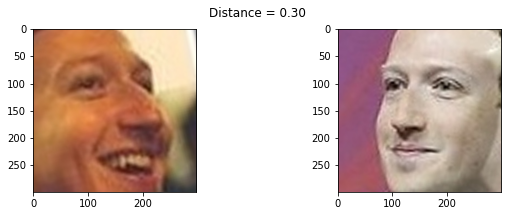

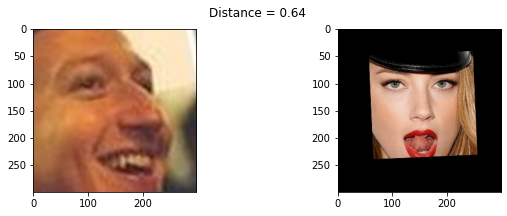

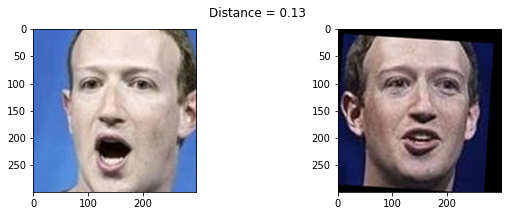

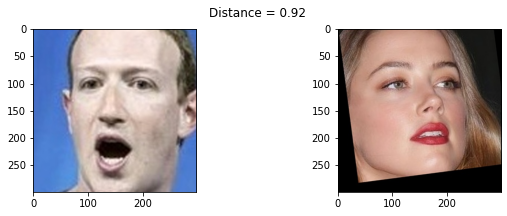

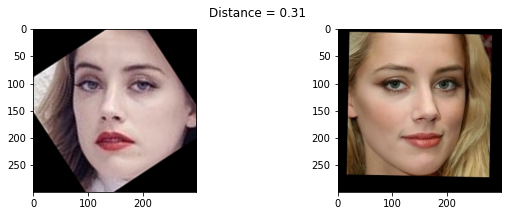

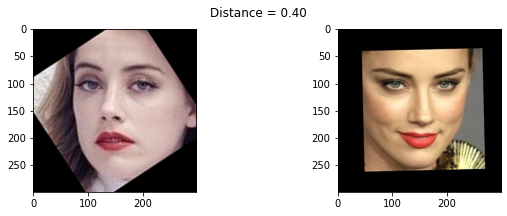

In [55]:
def photo_pair(idx1, idx2):
    plt.figure(figsize=(10,3))
    plt.suptitle(f'Distance = {distance_btw_photo(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

photo_pair(2, 3)
photo_pair(2, 180)

photo_pair(30, 31)
photo_pair(30, 100)

photo_pair(70, 72)
photo_pair(70, 115)

6.

In [56]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0


X_train = embeddings[train_idx]

X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])

y_train = targets[train_idx]

y_test = targets[test_idx]
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [57]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [58]:
from sklearn.preprocessing import StandardScaler 
SS= StandardScaler()
X_train_ss = SS.fit_transform(X_train)
X_test_ss = SS.transform(X_test)
print(X_train_ss)

[[ 1.01259599  1.50950177  0.29281411 ...  0.41421063  0.69123451
  -1.17165333]
 [-0.30229644  3.12414742  1.94676532 ...  0.82522083  1.00856709
   0.2849892 ]
 [ 0.38452147  1.31208742 -0.68565779 ...  0.964679    1.59038878
   0.54344618]
 ...
 [-0.5887049  -0.18055319 -0.4695441  ...  0.28115156  1.40175565
   0.37727055]
 [-1.19820354 -0.50629338 -0.70875397 ...  0.79512488  0.43267639
   0.26863984]
 [-0.95795935 -0.41344596  0.44561798 ...  0.8014221   0.9145346
   0.11207892]]


In [59]:
from sklearn.decomposition import PCA

n_components = 128
  
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train_ss)
X_train_pca = pca.transform(X_train_ss) 
X_test_pca = pca.transform(X_test_ss) 

7.

In [60]:
from sklearn.svm import SVC

model_svc= SVC(kernel='linear')
model_svc.fit(X_train_pca, y_train)
print('Accuracy for svc train set: {0:.6f}'.format(model_svc.score(X_train_pca, y_train)))

Accuracy for svc train set: 0.999791


8. & 9.

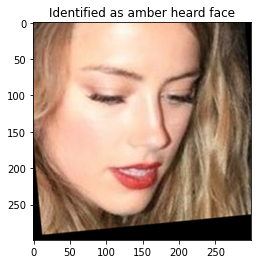

In [61]:
example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = model_svc.predict([X_test_pca[example_idx]])
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');